In [1]:
# Ensemble Variant 1: S: Densenet201, W: ResNet152d (Best Model)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from backbones import DenseNet201
from backbones import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran2 import CTranEncoder
torch.cuda.empty_cache()
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
embed_dim = 1024
num_workers = 8
num_labels = 21
thresholds = [0.5] * num_labels
in_channels = 3
num_classes = 21
data_dir = '../../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../../data/GT-main/./set1/train.csv
384
../../../../data/GT-main/./set1/val.csv
384
../../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = embed_dim)
model1 = CTranEncoder(num_classes=num_classes, in_channels = 3, embed_dim=embed_dim, num_layers=4, num_heads=num_workers, backbone=backbone1)
model1.to(device)

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = embed_dim)
model2 = CTranEncoder(num_classes=num_classes, in_channels = 3, embed_dim=embed_dim, num_layers=4, num_heads=num_workers, backbone=backbone2)
model2.to(device)

# Wrap your model with DataParallel
# model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
# model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-6, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

torch.Size([1, 21, 1024])


/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weigh

torch.Size([1, 21, 1024])


In [5]:
# summary(model1, input_size=(3, 384, 384))

In [6]:
# summary(model2, input_size=(3, 384, 384))

In [7]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)
metric3 = Metric(num_classes=num_classes)

thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.6,0.4

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        # Perform weighted average of model predictions
        weighted_outputs = a * outputs1 + b * outputs2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels)
            
        with torch.no_grad():
            metric2.update(outputs2, labels)
        
        with torch.no_grad():
            metric3.update(weighted_outputs, labels)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh1 = metric2.compute()
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh1)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh2 = metric1.compute()
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh2)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh3 = metric3.compute()
    print("Ensemble:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh3)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    metric3.reset()
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric3.update(weighted_outputs, labels)

        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh3 = metric3.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric3.reset()
        torch.cuda.empty_cache()   
    print(thresh3)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
    # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += weighted_outputs.tolist()
            test_labels += labels.tolist()
            metric3.update(weighted_outputs, labels)

        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh3 = metric3.compute(thresholds = thresh3)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model1, 'models2/strongrn_rn1-js.pth')
            torch.save(model2, 'models2/strongrn_dn1-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        
        # Reset Metric class for next epoch
        metric3.reset()
        torch.cuda.empty_cache()     
    
    print(thresh3)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    print()
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


DenseNet201:
 Epoch [1/200], Loss: 0.6724, ML mAP: 0.1031, ML F1: 0.8816, ML AUC: 0.5740, ML Score: 0.3386, Bin AUC: 0.6316, Model Score: 0.4851, Bin F1: 1.0000
[0.63 0.66 0.57 0.64 0.65 0.69 0.64 0.66 0.66 0.64 0.68 0.67 0.59 0.66
 0.65 0.66 0.53 0.64 0.64 0.55 0.63]
Accuracy list: [0.8479239619809905, 0.9574787393696849, 0.8824412206103052, 0.8994497248624312, 0.9134567283641821, 0.8784392196098049, 0.9234617308654327, 0.9299649824912456, 0.9324662331165583, 0.935967983991996, 0.9429714857428715, 0.9294647323661831, 0.9469734867433717, 0.9489744872436218, 0.9249624812406203, 0.9634817408704353, 0.8584292146073037, 0.9339669834917459, 0.9454727363681841, 0.7858929464732366, 0.950975487743872]
Specificity list: [0.9994103773584906, 0.9994778067885117, 0.9454054054054054, 0.9988888888888889, 0.9994526546250684, 0.9994308480364257, 0.9994585814834868, 0.9994623655913979, 0.9994638069705094, 0.999465811965812, 0.9994697773064687, 0.9994620763851533, 0.9989445910290238, 0.9994731296101159,

100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [1/200], Loss: 0.6695, ML mAP: 0.2432, ML F1: 0.5910, ML AUC: 0.7987, ML Score: 0.5210, Bin AUC: 0.8000, Model Score: 0.6605, Bin F1: 0.6667
[0.51 0.51 0.51 0.51 0.51 0.55 0.52 0.52 0.51 0.52 0.52 0.52 0.5  0.51
 0.52 0.53 0.52 0.53 0.51 0.51 0.52]
Accuracy list: [0.8291571753986332, 0.8246013667425968, 0.9202733485193622, 0.8633257403189066, 0.9248291571753986, 0.9407744874715261, 0.8747152619589977, 0.9453302961275627, 0.9567198177676538, 0.958997722095672, 0.979498861047836, 0.9681093394077449, 0.9476082004555809, 0.9476082004555809, 0.9681093394077449, 0.979498861047836, 0.979498861047836, 0.979498861047836, 0.9544419134396356, 0.7175398633257403, 0.9703872437357631]
Specificity list: [0.8743016759776536, 0.9541284403669725, 0.9705882352941176, 0.9242424242424242, 0.9779951100244498, 0.9975845410628019, 0.9152542372881356, 0.9714964370546318, 0.9859154929577465, 0.9790697674418605, 0.9976798143851509, 0.9791183294663574, 0.9627906976744186, 0.9672131147540983, 0.9929906

100%|██████████| 27/27 [00:06<00:00,  4.34it/s]


Test - Epoch [1/200], Loss: 18.4159, ML mAP: 0.2339, ML F1: 0.5158, ML AUC: 0.8013, ML Score: 0.5176, Bin AUC: 0.8500, Model Score: 0.6838, Bin F1: 1.0000
[0.51 0.51 0.51 0.51 0.51 0.55 0.52 0.52 0.51 0.52 0.52 0.52 0.5  0.51
 0.52 0.53 0.52 0.53 0.51 0.51 0.52]
Accuracy list: [0.8507109004739336, 0.8293838862559242, 0.9383886255924171, 0.8530805687203792, 0.9289099526066351, 0.9360189573459715, 0.8649289099526066, 0.943127962085308, 0.957345971563981, 0.957345971563981, 0.990521327014218, 0.9478672985781991, 0.9218009478672986, 0.9502369668246445, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9597156398104265, 0.6777251184834123, 0.957345971563981]
Specificity list: [0.8959537572254336, 0.9448051948051948, 0.9769820971867008, 0.9263157894736842, 0.9772727272727273, 0.9974747474747475, 0.9, 0.9727047146401985, 0.9901960784313726, 0.9829268292682927, 1.0, 0.9612590799031477, 0.9390243902439024, 0.9685230024213075, 0.9856115107913669, 0.9879518072289156

100%|██████████| 125/125 [00:53<00:00,  2.35it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.5246, ML mAP: 0.1671, ML F1: 0.7238, ML AUC: 0.6707, ML Score: 0.4189, Bin AUC: 0.8947, Model Score: 0.6568, Bin F1: 0.5000
[0.51 0.62 0.65 0.67 0.52 0.76 0.61 0.54 0.62 0.67 0.6  0.79 0.58 0.56
 0.68 0.68 0.55 0.61 0.63 0.66 0.57]
Accuracy list: [0.8039019509754878, 0.9479739869934968, 0.9219609804902451, 0.8834417208604303, 0.8444222111055528, 0.8664332166083042, 0.9269634817408704, 0.8959479739869936, 0.9394697348674337, 0.9294647323661831, 0.9244622311155578, 0.9239619809904952, 0.9484742371185593, 0.888944472236118, 0.9424712356178089, 0.9499749874937469, 0.8894447223611806, 0.9154577288644322, 0.9539769884942472, 0.9029514757378689, 0.9459729864932466]
Specificity list: [0.8793103448275862, 0.9994725738396625, 0.9989159891598915, 0.998868778280543, 0.897563676633444, 0.9988465974625144, 0.9994606256742179, 0.9436695278969958, 0.9989361702127659, 0.9994620763851533, 0.9697933227344993, 0.9994588744588745, 0.9994728518713759, 0.9340776182881446,

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [2/200], Loss: 0.5070, ML mAP: 0.1456, ML F1: 0.7822, ML AUC: 0.7137, ML Score: 0.4297, Bin AUC: 0.5500, Model Score: 0.4898, Bin F1: 0.5000
[0.42 0.39 0.44 0.5  0.5  0.49 0.49 0.49 0.49 0.49 0.49 0.51 0.45 0.49
 0.49 0.49 0.51 0.53 0.49 0.44 0.44]
Accuracy list: [0.7517084282460137, 0.7198177676537585, 0.9111617312072893, 0.8997722095671982, 0.929384965831435, 0.9271070615034168, 0.9316628701594533, 0.958997722095672, 0.9658314350797267, 0.9772209567198178, 0.9772209567198178, 0.979498861047836, 0.9772209567198178, 0.9658314350797267, 0.9726651480637813, 0.979498861047836, 0.9840546697038725, 0.979498861047836, 0.9772209567198178, 0.8086560364464692, 0.9362186788154897]
Specificity list: [0.7625698324022346, 0.7217125382262997, 0.9681372549019608, 0.9974747474747475, 0.9975550122249389, 0.9710144927536232, 0.9903147699757869, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9976635

100%|██████████| 27/27 [00:06<00:00,  4.04it/s]


Test - Epoch [2/200], Loss: 14.6357, ML mAP: 0.1558, ML F1: 0.5419, ML AUC: 0.7432, ML Score: 0.4495, Bin AUC: 0.7000, Model Score: 0.5747, Bin F1: 0.6667
[0.42 0.39 0.44 0.5  0.5  0.49 0.49 0.49 0.49 0.49 0.49 0.51 0.45 0.49
 0.49 0.49 0.51 0.53 0.49 0.44 0.44]
Accuracy list: [0.7227488151658767, 0.7037914691943128, 0.8981042654028436, 0.9004739336492891, 0.9383886255924171, 0.933649289099526, 0.9312796208530806, 0.9454976303317536, 0.9644549763033176, 0.9620853080568721, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.7985781990521327, 0.933649289099526]
Specificity list: [0.7514450867052023, 0.7012987012987013, 0.9539641943734015, 1.0, 0.9974747474747475, 0.9873737373737373, 0.98, 0.9776674937965261, 0.9975490196078431, 0.9902439024390244, 0.9951923076923077, 1.0, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.9879518072289156, 0.997613365

100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.4936, ML mAP: 0.1171, ML F1: 0.6005, ML AUC: 0.6620, ML Score: 0.3896, Bin AUC: 0.8421, Model Score: 0.6158, Bin F1: 0.3333
[0.32 0.5  0.5  0.51 0.53 0.55 0.5  0.3  0.51 0.51 0.52 0.29 0.41 0.47
 0.52 0.42 0.53 0.37 0.48 0.36 0.5 ]
Accuracy list: [0.7453726863431716, 0.9534767383691846, 0.919959979989995, 0.8899449724862432, 0.9004502251125562, 0.8694347173586794, 0.9289644822411206, 0.7908954477238619, 0.9429714857428715, 0.9314657328664332, 0.9299649824912456, 0.7158579289644822, 0.8649324662331166, 0.8619309654827414, 0.9324662331165583, 0.8459229614807404, 0.9369684842421211, 0.7943971985992997, 0.8534267133566783, 0.8039019509754878, 0.9569784892446224]
Specificity list: [0.7986030267753201, 0.9994756161510225, 0.9994565217391305, 0.999438202247191, 0.9994447529150472, 0.9994249568717654, 0.9994617868675996, 0.8285404232230059, 0.9994697773064687, 0.9994632313472893, 0.9994623655913979, 0.7096949891067538, 0.9012086179716238, 0.8973284442116292

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [3/200], Loss: 0.4695, ML mAP: 0.1786, ML F1: 0.7227, ML AUC: 0.7628, ML Score: 0.4707, Bin AUC: 0.5500, Model Score: 0.5104, Bin F1: 1.0000
[0.42 0.38 0.43 0.44 0.44 0.48 0.44 0.49 0.46 0.45 0.49 0.49 0.42 0.47
 0.47 0.47 0.49 0.49 0.46 0.41 0.41]
Accuracy list: [0.7995444191343963, 0.8337129840546698, 0.9043280182232346, 0.8177676537585421, 0.8656036446469249, 0.9225512528473804, 0.8952164009111617, 0.9567198177676538, 0.9658314350797267, 0.9726651480637813, 0.979498861047836, 0.979498861047836, 0.9726651480637813, 0.9703872437357631, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.826879271070615, 0.9476082004555809]
Specificity list: [0.8212290502793296, 0.9204892966360856, 0.9534313725490197, 0.8585858585858586, 0.8997555012224939, 0.9710144927536232, 0.9443099273607748, 0.997624703087886, 0.9953051643192489, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 0.9930232558139535, 0.9976580796252927, 0.997663

100%|██████████| 27/27 [00:06<00:00,  3.90it/s]


Test - Epoch [3/200], Loss: 13.8122, ML mAP: 0.1688, ML F1: 0.5837, ML AUC: 0.7638, ML Score: 0.4663, Bin AUC: 0.5000, Model Score: 0.4831, Bin F1: 0.0000
[0.42 0.38 0.43 0.44 0.44 0.48 0.44 0.49 0.46 0.45 0.49 0.49 0.42 0.47
 0.47 0.47 0.49 0.49 0.46 0.41 0.41]
Accuracy list: [0.7819905213270142, 0.8080568720379147, 0.9218009478672986, 0.8033175355450237, 0.8791469194312796, 0.9265402843601895, 0.8933649289099526, 0.9502369668246445, 0.9644549763033176, 0.957345971563981, 0.985781990521327, 0.976303317535545, 0.9597156398104265, 0.9739336492890995, 0.9881516587677726, 0.9691943127962085, 0.990521327014218, 0.990521327014218, 0.966824644549763, 0.8222748815165877, 0.9407582938388626]
Specificity list: [0.8092485549132948, 0.8863636363636364, 0.9514066496163683, 0.8421052631578947, 0.9015151515151515, 0.9848484848484849, 0.935, 0.9950372208436724, 0.9975490196078431, 0.9853658536585366, 1.0, 0.9975786924939467, 0.9878048780487805, 0.9951573849878934, 1.0, 0.9855421686746988, 0.997613365

100%|██████████| 125/125 [00:52<00:00,  2.36it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.3605, ML mAP: 0.1255, ML F1: 0.3804, ML AUC: 0.6988, ML Score: 0.4121, Bin AUC: 0.8704, Model Score: 0.6412, Bin F1: 0.4000
[0.27 0.15 0.18 0.22 0.54 0.52 0.29 0.21 0.17 0.18 0.48 0.28 0.5  0.4
 0.5  0.5  0.5  0.31 0.3  0.2  0.19]
Accuracy list: [0.7538769384692346, 0.7868934467233617, 0.7623811905952976, 0.7153576788394197, 0.8924462231115557, 0.8754377188594297, 0.8269134567283641, 0.8049024512256128, 0.742871435717859, 0.7693846923461731, 0.8589294647323662, 0.7743871935967984, 0.959479739869935, 0.8619309654827414, 0.9414707353676839, 0.9469734867433717, 0.9459729864932466, 0.8299149574787393, 0.855927963981991, 0.7393696848424212, 0.8304152076038019]
Specificity list: [0.8040462427745665, 0.8029504741833509, 0.795751633986928, 0.744920993227991, 0.9994397759103641, 0.9994288977727013, 0.8795245813074014, 0.8333333333333334, 0.7765212708669897, 0.8054809242342826, 0.9058510638297872, 0.7738287560581584, 1.0, 0.901578947368421, 0.9994689325544344

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [4/200], Loss: 0.2087, ML mAP: 0.1450, ML F1: 0.8338, ML AUC: 0.7115, ML Score: 0.4282, Bin AUC: 0.7500, Model Score: 0.5891, Bin F1: 0.0000
[0.32 0.4  0.35 0.32 0.45 0.5  0.41 0.43 0.4  0.41 0.43 0.46 0.36 0.41
 0.42 0.4  0.43 0.41 0.4  0.41 0.39]
Accuracy list: [0.7835990888382688, 0.7425968109339408, 0.8678815489749431, 0.785876993166287, 0.929384965831435, 0.9407744874715261, 0.9384965831435079, 0.9658314350797267, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.9772209567198178, 0.9703872437357631, 0.9703872437357631, 0.9817767653758542, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.8883826879271071, 0.9521640091116174]
Specificity list: [0.8463687150837989, 0.9969418960244648, 0.9191176470588235, 0.8257575757575758, 0.9975550122249389, 0.9975845410628019, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9953271

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [4/200], Loss: 7.9739, ML mAP: 0.1556, ML F1: 0.2898, ML AUC: 0.7147, ML Score: 0.4351, Bin AUC: 0.8000, Model Score: 0.6176, Bin F1: 0.0000
[0.32 0.4  0.35 0.32 0.45 0.5  0.41 0.43 0.4  0.41 0.43 0.46 0.36 0.41
 0.42 0.4  0.43 0.41 0.4  0.41 0.39]
Accuracy list: [0.7914691943127962, 0.7298578199052133, 0.8838862559241706, 0.7701421800947867, 0.9407582938388626, 0.9383886255924171, 0.9478672985781991, 0.9454976303317536, 0.9620853080568721, 0.9597156398104265, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.9715639810426541, 0.909952606635071, 0.9454976303317536]
Specificity list: [0.8728323699421965, 1.0, 0.9360613810741688, 0.8184210526315789, 0.9974747474747475, 1.0, 1.0, 0.9900744416873449, 0.9950980392156863, 0.9878048780487805, 1.0, 1.0, 1.0, 1.0, 0.9952038369304557, 0.9975903614457832, 1.0, 1.0, 1.0, 1.0, 0.9974937343358395]

Epoch 5/200
----------


100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [5/200], Loss: 0.3030, ML mAP: 0.1379, ML F1: 0.3266, ML AUC: 0.7193, ML Score: 0.4286, Bin AUC: 0.4211, Model Score: 0.4248, Bin F1: 1.0000
[0.25 0.17 0.18 0.5  0.56 0.54 0.39 0.21 0.19 0.18 0.22 0.24 0.12 0.19
 0.15 0.17 0.22 0.25 0.16 0.19 0.17]
Accuracy list: [0.7873936968484242, 0.8414207103551776, 0.7878939469734867, 0.8989494747373686, 0.9074537268634317, 0.8639319659829915, 0.8414207103551776, 0.8034017008504252, 0.8034017008504252, 0.7923961980990495, 0.8444222111055528, 0.7628814407203601, 0.8099049524762382, 0.8294147073536768, 0.8089044522261131, 0.8159079539769885, 0.7863931965982992, 0.8224112056028015, 0.7953976988494247, 0.7583791895947974, 0.8299149574787393]
Specificity list: [0.8273299028016009, 0.8657577346617724, 0.8166849615806806, 0.9994438264738599, 0.9994490358126722, 0.9994212962962963, 0.8990280777537797, 0.8214867064568638, 0.843482905982906, 0.8304812834224599, 0.8783570300157978, 0.7660723933009185, 0.8365840801265155, 0.866737739872068

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [5/200], Loss: 0.1660, ML mAP: 0.1873, ML F1: 0.7908, ML AUC: 0.7592, ML Score: 0.4732, Bin AUC: 0.7500, Model Score: 0.6116, Bin F1: 0.0000
[0.29 0.35 0.27 0.4  0.33 0.47 0.29 0.33 0.31 0.34 0.27 0.26 0.32 0.33
 0.32 0.33 0.37 0.34 0.33 0.29 0.24]
Accuracy list: [0.8405466970387244, 0.7425968109339408, 0.8997722095671982, 0.8997722095671982, 0.9316628701594533, 0.9407744874715261, 0.9271070615034168, 0.9612756264236902, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.9316628701594533, 0.9772209567198178, 0.9703872437357631, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9703872437357631]
Specificity list: [0.9385474860335196, 0.9969418960244648, 0.946078431372549, 0.9974747474747475, 0.9828850855745721, 0.9975845410628019, 0.9782082324455206, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9327146171693735, 0.9976744186046511, 0.9976580796252927, 0.9929

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [5/200], Loss: 6.4822, ML mAP: 0.1900, ML F1: 0.5938, ML AUC: 0.7500, ML Score: 0.4700, Bin AUC: 0.7500, Model Score: 0.6100, Bin F1: 0.0000
[0.29 0.35 0.27 0.4  0.33 0.47 0.29 0.33 0.31 0.34 0.27 0.26 0.32 0.33
 0.32 0.33 0.37 0.34 0.33 0.29 0.24]
Accuracy list: [0.8412322274881516, 0.7274881516587678, 0.9075829383886256, 0.8981042654028436, 0.9407582938388626, 0.9383886255924171, 0.9241706161137441, 0.9407582938388626, 0.9644549763033176, 0.966824644549763, 0.9834123222748815, 0.9478672985781991, 0.966824644549763, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.9928909952606635, 0.990521327014218, 0.9644549763033176, 0.9052132701421801, 0.9597156398104265]
Specificity list: [0.930635838150289, 0.9967532467532467, 0.948849104859335, 0.9947368421052631, 0.9823232323232324, 1.0, 0.9725, 0.9776674937965261, 0.9975490196078431, 0.9951219512195122, 0.9975961538461539, 0.9588377723970944, 0.9951219512195122, 0.9927360774818402, 0.988009592326139, 0.990361445783132

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


DenseNet201:
 Epoch [6/200], Loss: 0.3051, ML mAP: 0.1549, ML F1: 0.3459, ML AUC: 0.7398, ML Score: 0.4473, Bin AUC: 0.9605, Model Score: 0.7039, Bin F1: 0.2857
[0.32 0.15 0.21 0.23 0.67 0.35 0.19 0.73 0.16 0.16 0.15 0.36 0.12 0.15
 0.2  0.17 0.26 0.5  0.22 0.17 0.23]
Accuracy list: [0.8059029514757379, 0.8334167083541771, 0.8009004502251126, 0.7813906953476738, 0.9119559779889945, 0.7988994497248624, 0.7978989494747374, 0.9099549774887443, 0.743871935967984, 0.7708854427213607, 0.7953976988494247, 0.8349174587293647, 0.7948974487243622, 0.7648824412206103, 0.8094047023511756, 0.8114057028514257, 0.824912456228114, 0.9414707353676839, 0.8554277138569285, 0.7413706853426714, 0.8604302151075538]
Specificity list: [0.852974828375286, 0.8498419388830347, 0.8336079077429983, 0.8272017837235228, 0.9994517543859649, 0.8407789232531501, 0.8343982960596379, 0.9994505494505495, 0.7684835402050728, 0.7983914209115281, 0.8253715498938429, 0.8488308863512779, 0.822434875066454, 0.7881669307976756, 

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [6/200], Loss: 0.1609, ML mAP: 0.2301, ML F1: 0.7762, ML AUC: 0.7833, ML Score: 0.5067, Bin AUC: 0.7500, Model Score: 0.6284, Bin F1: 0.0000
[0.25 0.3  0.3  0.31 0.36 0.4  0.19 0.43 0.27 0.31 0.27 0.25 0.28 0.32
 0.28 0.33 0.34 0.3  0.29 0.29 0.24]
Accuracy list: [0.8610478359908884, 0.7425968109339408, 0.9453302961275627, 0.8633257403189066, 0.9384965831435079, 0.9384965831435079, 0.8223234624145785, 0.9567198177676538, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.9407744874715261, 0.9749430523917996, 0.9749430523917996, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9931662870159453]
Specificity list: [0.9357541899441341, 0.9969418960244648, 1.0, 0.9141414141414141, 0.9926650366748166, 0.9951690821256038, 0.847457627118644, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9396751740139211, 0.9953488372093023, 1.0, 0.9976635514018691, 0.997685185185185

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [6/200], Loss: 6.1311, ML mAP: 0.2293, ML F1: 0.5544, ML AUC: 0.7739, ML Score: 0.5016, Bin AUC: 0.7500, Model Score: 0.6258, Bin F1: 0.0000
[0.25 0.3  0.3  0.31 0.36 0.4  0.19 0.43 0.27 0.31 0.27 0.25 0.28 0.32
 0.28 0.33 0.34 0.3  0.29 0.29 0.24]
Accuracy list: [0.8507109004739336, 0.7251184834123223, 0.9289099526066351, 0.8672985781990521, 0.9407582938388626, 0.9383886255924171, 0.8459715639810427, 0.9549763033175356, 0.9620853080568721, 0.9691943127962085, 0.985781990521327, 0.9454976303317536, 0.9644549763033176, 0.976303317535545, 0.9786729857819905, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9075829383886256, 0.9834123222748815]
Specificity list: [0.9277456647398844, 0.9935064935064936, 0.9974424552429667, 0.9394736842105263, 0.9949494949494949, 1.0, 0.865, 0.9975186104218362, 0.9950980392156863, 0.9975609756097561, 1.0, 0.9515738498789347, 0.9926829268292683, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662, 1.0, 1.0, 

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


DenseNet201:
 Epoch [7/200], Loss: 0.2730, ML mAP: 0.1692, ML F1: 0.3740, ML AUC: 0.7550, ML Score: 0.4621, Bin AUC: 0.7632, Model Score: 0.6126, Bin F1: 0.2500
[0.29 0.17 0.17 0.2  0.23 0.27 0.14 0.7  0.16 0.18 0.16 0.29 0.11 0.16
 0.18 0.5  0.27 0.52 0.13 0.17 0.5 ]
Accuracy list: [0.8149074537268635, 0.8329164582291145, 0.7953976988494247, 0.7473736868434218, 0.8094047023511756, 0.7658829414707353, 0.7448724362181091, 0.9249624812406203, 0.8129064532266133, 0.8024012006003002, 0.784392196098049, 0.8459229614807404, 0.7798899449724862, 0.807903951975988, 0.8234117058529264, 0.9539769884942472, 0.8309154577288644, 0.9304652326163082, 0.7983991995997999, 0.7638819409704852, 0.968984492246123]
Specificity list: [0.8646616541353384, 0.8426315789473684, 0.8205546492659054, 0.7797183098591549, 0.8332403792526492, 0.796962879640045, 0.7744198596869941, 0.9994594594594595, 0.8477103301384451, 0.8365695792880259, 0.8100588550026753, 0.8648504273504274, 0.7971623751970572, 0.8293838862559242, 

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [7/200], Loss: 0.1561, ML mAP: 0.2373, ML F1: 0.8709, ML AUC: 0.7978, ML Score: 0.5176, Bin AUC: 0.7500, Model Score: 0.6338, Bin F1: 0.0000
[0.28 0.19 0.3  0.32 0.41 0.39 0.3  0.39 0.26 0.3  0.24 0.35 0.26 0.31
 0.31 0.33 0.34 0.28 0.26 0.27 0.26]
Accuracy list: [0.8815489749430524, 0.8405466970387244, 0.9384965831435079, 0.8701594533029613, 0.9384965831435079, 0.9407744874715261, 0.9384965831435079, 0.9544419134396356, 0.9681093394077449, 0.9749430523917996, 0.9772209567198178, 0.979498861047836, 0.9749430523917996, 0.9703872437357631, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.9497206703910615, 0.908256880733945, 0.9901960784313726, 0.9267676767676768, 0.9926650366748166, 0.9975845410628019, 0.9975786924939467, 0.995249406175772, 0.9976525821596244, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 0.99766

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [7/200], Loss: 5.9967, ML mAP: 0.2286, ML F1: 0.5570, ML AUC: 0.7871, ML Score: 0.5078, Bin AUC: 0.7500, Model Score: 0.6289, Bin F1: 0.0000
[0.28 0.19 0.3  0.32 0.41 0.39 0.3  0.39 0.26 0.3  0.24 0.35 0.26 0.31
 0.31 0.33 0.34 0.28 0.26 0.27 0.26]
Accuracy list: [0.8696682464454977, 0.7985781990521327, 0.9265402843601895, 0.8649289099526066, 0.933649289099526, 0.9383886255924171, 0.9454976303317536, 0.9549763033175356, 0.9644549763033176, 0.9691943127962085, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9644549763033176, 0.909952606635071, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.8474025974025974, 0.989769820971867, 0.9368421052631579, 0.9949494949494949, 1.0, 0.9975, 0.9975186104218362, 0.9975490196078431, 0.9975609756097561, 0.9951923076923077, 1.0, 0.9975609756097561, 1.0, 0.9952038369304557, 1.0, 1.0, 0.9976076555023924, 0.992682926829

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


DenseNet201:
 Epoch [8/200], Loss: 0.2784, ML mAP: 0.1772, ML F1: 0.4866, ML AUC: 0.7660, ML Score: 0.4716, Bin AUC: 0.8000, Model Score: 0.6358, Bin F1: 1.0000
[0.26 0.6  0.19 0.63 0.27 0.5  0.15 0.8  0.13 0.16 0.16 0.26 0.11 0.15
 0.5  0.5  0.3  0.28 0.13 0.18 0.5 ]
Accuracy list: [0.7998999499749875, 0.9479739869934968, 0.8064032016008004, 0.8854427213606804, 0.815407703851926, 0.871935967983992, 0.7798899449724862, 0.9289644822411206, 0.7713856928464232, 0.7538769384692346, 0.8009004502251126, 0.8199099549774888, 0.7938969484742371, 0.8014007003501751, 0.9379689844922461, 0.9464732366183092, 0.8519259629814907, 0.8439219609804902, 0.7733866933466733, 0.7663831915957979, 0.9739869934967483]
Specificity list: [0.8345735546651403, 0.9994725738396625, 0.8339663591969615, 0.9994353472614342, 0.8372732270478285, 0.9994266055045872, 0.8160301237224314, 0.9994617868675996, 0.795864262990456, 0.7694369973190348, 0.8204168893639765, 0.8257372654155496, 0.8107255520504731, 0.8218602207041513,

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [8/200], Loss: 0.1492, ML mAP: 0.2504, ML F1: 0.7842, ML AUC: 0.8132, ML Score: 0.5318, Bin AUC: 0.7000, Model Score: 0.6159, Bin F1: 0.0000
[0.24 0.3  0.28 0.32 0.32 0.44 0.2  0.41 0.25 0.3  0.21 0.26 0.25 0.28
 0.32 0.31 0.33 0.29 0.27 0.24 0.25]
Accuracy list: [0.8701594533029613, 0.7403189066059226, 0.9316628701594533, 0.8861047835990888, 0.9225512528473804, 0.9407744874715261, 0.8883826879271071, 0.9521640091116174, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.9567198177676538, 0.9772209567198178, 0.9749430523917996, 0.9726651480637813, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9245810055865922, 0.9938837920489296, 0.9828431372549019, 0.946969696969697, 0.9682151589242054, 0.9975845410628019, 0.927360774818402, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9582366589327146, 0.9976744186046511, 1.0, 0.9976635514018691, 0.

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [8/200], Loss: 5.8159, ML mAP: 0.2361, ML F1: 0.4807, ML AUC: 0.7976, ML Score: 0.5168, Bin AUC: 0.7500, Model Score: 0.6334, Bin F1: 0.0000
[0.24 0.3  0.28 0.32 0.32 0.44 0.2  0.41 0.25 0.3  0.21 0.26 0.25 0.28
 0.32 0.31 0.33 0.29 0.27 0.24 0.25]
Accuracy list: [0.8625592417061612, 0.7274881516587678, 0.9312796208530806, 0.8791469194312796, 0.9502369668246445, 0.9383886255924171, 0.9052132701421801, 0.9549763033175356, 0.966824644549763, 0.9715639810426541, 0.981042654028436, 0.957345971563981, 0.966824644549763, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.9052132701421801, 0.990521327014218]
Specificity list: [0.9364161849710982, 0.9935064935064936, 0.9923273657289002, 0.9578947368421052, 0.9823232323232324, 1.0, 0.94, 0.9975186104218362, 1.0, 1.0, 0.9951923076923077, 0.9709443099273608, 0.9951219512195122, 0.9951573849878934, 1.0, 0.9975903614457832, 1.0, 0.9976076555023924, 0.9975609756097561

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [9/200], Loss: 0.2778, ML mAP: 0.1970, ML F1: 0.4015, ML AUC: 0.7705, ML Score: 0.4837, Bin AUC: 0.4500, Model Score: 0.4669, Bin F1: 1.0000
[0.28 0.21 0.21 0.24 0.78 0.3  0.16 0.27 0.14 0.15 0.2  0.29 0.12 0.15
 0.58 0.53 0.24 0.24 0.13 0.18 0.5 ]
Accuracy list: [0.7873936968484242, 0.8589294647323662, 0.8204102051025512, 0.7743871935967984, 0.9024512256128064, 0.784392196098049, 0.7808904452226113, 0.8464232116058029, 0.775887943971986, 0.7328664332166083, 0.8404202101050525, 0.8279139569784892, 0.8124062031015508, 0.8149074537268635, 0.9304652326163082, 0.9579789894947474, 0.8024012006003002, 0.8049024512256128, 0.7593796898449224, 0.7463731865932967, 0.9784892446223111]
Specificity list: [0.826945412311266, 0.8703606900156822, 0.8530857454942654, 0.8156424581005587, 0.9994459833795014, 0.8132875143184422, 0.8103632478632479, 0.867862969004894, 0.8107963655799038, 0.7425373134328358, 0.8686440677966102, 0.8389553862894451, 0.8335100742311771, 0.8351764086361243, 

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [9/200], Loss: 0.1532, ML mAP: 0.2518, ML F1: 0.8468, ML AUC: 0.8129, ML Score: 0.5323, Bin AUC: 0.7000, Model Score: 0.6162, Bin F1: 0.0000
[0.29 0.2  0.32 0.29 0.41 0.43 0.31 0.43 0.26 0.3  0.24 0.3  0.26 0.31
 0.33 0.33 0.34 0.31 0.26 0.27 0.28]
Accuracy list: [0.8906605922551253, 0.8428246013667426, 0.9430523917995444, 0.8428246013667426, 0.9362186788154897, 0.9407744874715261, 0.9384965831435079, 0.9544419134396356, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.9703872437357631, 0.9772209567198178, 0.9703872437357631, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.908256880733945, 1.0, 0.8863636363636364, 0.9902200488997555, 0.9975845410628019, 0.9975786924939467, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.974477958236659, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [9/200], Loss: 5.9477, ML mAP: 0.2411, ML F1: 0.6704, ML AUC: 0.7996, ML Score: 0.5204, Bin AUC: 0.8000, Model Score: 0.6602, Bin F1: 0.0000
[0.29 0.2  0.32 0.29 0.41 0.43 0.31 0.43 0.26 0.3  0.24 0.3  0.26 0.31
 0.33 0.33 0.34 0.31 0.26 0.27 0.28]
Accuracy list: [0.8791469194312796, 0.8270142180094787, 0.9289099526066351, 0.8507109004739336, 0.9383886255924171, 0.9383886255924171, 0.9454976303317536, 0.957345971563981, 0.9644549763033176, 0.9691943127962085, 0.9834123222748815, 0.9715639810426541, 0.9691943127962085, 0.976303317535545, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.9075829383886256, 0.990521327014218]
Specificity list: [0.9595375722543352, 0.8798701298701299, 0.9974424552429667, 0.9131578947368421, 0.9949494949494949, 1.0, 0.9975, 1.0, 0.9975490196078431, 0.9975609756097561, 0.9975961538461539, 0.9878934624697336, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 1.0, 0.99

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [10/200], Loss: 0.2680, ML mAP: 0.2048, ML F1: 0.3698, ML AUC: 0.7813, ML Score: 0.4930, Bin AUC: 0.7500, Model Score: 0.6215, Bin F1: 1.0000
[0.27 0.17 0.19 0.22 0.26 0.32 0.15 0.82 0.15 0.16 0.17 0.52 0.12 0.15
 0.18 0.2  0.23 0.27 0.15 0.18 0.5 ]
Accuracy list: [0.7973986993496749, 0.8364182091045522, 0.8084042021010506, 0.7733866933466733, 0.8149074537268635, 0.7838919459729865, 0.7753876938469234, 0.9179589794897449, 0.8104052026013007, 0.7373686843421711, 0.8334167083541771, 0.9329664832416208, 0.8189094547273637, 0.8114057028514257, 0.8349174587293647, 0.8404202101050525, 0.8144072036018009, 0.8304152076038019, 0.8264132066033016, 0.7478739369684843, 0.9804902451225613]
Specificity list: [0.8351906158357771, 0.8495018353434715, 0.8311331133113311, 0.80125284738041, 0.8364145658263306, 0.820250284414107, 0.8083961248654468, 0.9994553376906318, 0.8462354188759279, 0.7555315704263357, 0.857218124341412, 0.9994640943193998, 0.8378803777544596, 0.8266596417281349,

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [10/200], Loss: 0.1482, ML mAP: 0.2494, ML F1: 0.8579, ML AUC: 0.8165, ML Score: 0.5329, Bin AUC: 0.7000, Model Score: 0.6165, Bin F1: 0.0000
[0.27 0.32 0.31 0.31 0.34 0.44 0.28 0.45 0.25 0.29 0.21 0.27 0.24 0.29
 0.32 0.32 0.33 0.3  0.25 0.25 0.29]
Accuracy list: [0.8883826879271071, 0.7425968109339408, 0.9339407744874715, 0.8747152619589977, 0.9111617312072893, 0.9407744874715261, 0.9362186788154897, 0.9567198177676538, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.9567198177676538, 0.9726651480637813, 0.9703872437357631, 0.9703872437357631, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9969418960244648, 0.9901960784313726, 0.9318181818181818, 0.9559902200488998, 0.9975845410628019, 0.9951573849878934, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9582366589327146, 0.9930232558139535, 0.9976580796252927, 0.995

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [10/200], Loss: 5.8183, ML mAP: 0.2406, ML F1: 0.6582, ML AUC: 0.8032, ML Score: 0.5219, Bin AUC: 0.7000, Model Score: 0.6109, Bin F1: 0.0000
[0.27 0.32 0.31 0.31 0.34 0.44 0.28 0.45 0.25 0.29 0.21 0.27 0.24 0.29
 0.32 0.32 0.33 0.3  0.25 0.25 0.29]
Accuracy list: [0.8815165876777251, 0.7298578199052133, 0.9289099526066351, 0.8720379146919431, 0.943127962085308, 0.9383886255924171, 0.9454976303317536, 0.957345971563981, 0.9644549763033176, 0.9691943127962085, 0.9834123222748815, 0.9597156398104265, 0.9691943127962085, 0.976303317535545, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.9075829383886256, 0.9928909952606635]
Specificity list: [0.9624277456647399, 1.0, 0.9948849104859335, 0.9447368421052632, 0.9747474747474747, 1.0, 0.9975, 1.0, 0.9975490196078431, 0.9975609756097561, 0.9975961538461539, 0.9733656174334141, 0.9975609756097561, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832, 1.0, 0.9976076555023924,

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [11/200], Loss: 0.2639, ML mAP: 0.2163, ML F1: 0.3663, ML AUC: 0.7805, ML Score: 0.4984, Bin AUC: 0.8684, Model Score: 0.6834, Bin F1: 0.4000
[0.5  0.2  0.68 0.71 0.23 0.26 0.22 0.21 0.14 0.21 0.17 0.23 0.13 0.15
 0.16 0.15 0.25 0.22 0.14 0.21 0.5 ]
Accuracy list: [0.887943971985993, 0.855927963981991, 0.9219609804902451, 0.8914457228614308, 0.7903951975987994, 0.7593796898449224, 0.824912456228114, 0.8309154577288644, 0.7478739369684843, 0.8194097048524263, 0.8139069534767384, 0.7923961980990495, 0.8164082041020511, 0.8224112056028015, 0.8094047023511756, 0.7863931965982992, 0.8339169584792396, 0.8044022011005503, 0.8034017008504252, 0.8044022011005503, 0.9769884942471235]
Specificity list: [0.9912536443148688, 0.8693361433087461, 0.9994577006507592, 0.9994391475042064, 0.8044077134986226, 0.784458309699376, 0.8692098092643051, 0.8344975819451907, 0.7712, 0.8656636217087588, 0.8404482390608324, 0.7920043219881145, 0.8344791115811739, 0.8384736016727653, 0.818716577

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [11/200], Loss: 0.1261, ML mAP: 0.2797, ML F1: 0.8420, ML AUC: 0.8421, ML Score: 0.5609, Bin AUC: 0.7000, Model Score: 0.6305, Bin F1: 0.0000
[0.32 0.19 0.33 0.35 0.39 0.4  0.34 0.49 0.24 0.31 0.22 0.35 0.26 0.31
 0.29 0.29 0.33 0.31 0.26 0.28 0.32]
Accuracy list: [0.8861047835990888, 0.8542141230068337, 0.9316628701594533, 0.8883826879271071, 0.9271070615034168, 0.9407744874715261, 0.9384965831435079, 0.9544419134396356, 0.9658314350797267, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.9772209567198178, 0.9703872437357631, 0.9430523917995444, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8861047835990888, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9418960244648318, 0.9803921568627451, 0.952020202020202, 0.9755501222493888, 0.9975845410628019, 0.9975786924939467, 0.995249406175772, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.95327

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [11/200], Loss: 5.5837, ML mAP: 0.2907, ML F1: 0.2794, ML AUC: 0.8249, ML Score: 0.5578, Bin AUC: 0.8000, Model Score: 0.6789, Bin F1: 0.0000
[0.32 0.19 0.33 0.35 0.39 0.4  0.34 0.49 0.24 0.31 0.22 0.35 0.26 0.31
 0.29 0.29 0.33 0.31 0.26 0.28 0.32]
Accuracy list: [0.8720379146919431, 0.8436018957345972, 0.9360189573459715, 0.8744075829383886, 0.95260663507109, 0.9383886255924171, 0.9478672985781991, 0.957345971563981, 0.966824644549763, 0.9715639810426541, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.9786729857819905, 0.9383886255924171, 0.9834123222748815, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.922077922077922, 0.9872122762148338, 0.95, 0.9823232323232324, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9496402877697842, 1.0, 1.0, 0.9952153110047847, 1.0, 0.9973958333333334, 1.0]

Epoch 12/200
----------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [12/200], Loss: 0.2931, ML mAP: 0.2689, ML F1: 0.4050, ML AUC: 0.8115, ML Score: 0.5402, Bin AUC: 0.6579, Model Score: 0.5990, Bin F1: 0.5000
[0.5  0.5  0.22 0.69 0.24 0.28 0.18 0.5  0.14 0.18 0.19 0.34 0.14 0.18
 0.5  0.19 0.21 0.28 0.16 0.55 0.5 ]
Accuracy list: [0.8959479739869936, 0.9549774887443722, 0.8184092046023012, 0.8834417208604303, 0.7898949474737369, 0.7988994497248624, 0.7958979489744873, 0.9379689844922461, 0.7698849424712356, 0.7958979489744873, 0.848424212106053, 0.8569284642321161, 0.8194097048524263, 0.8454227113556778, 0.943471735867934, 0.832416208104052, 0.8064032016008004, 0.8359179589794897, 0.8144072036018009, 0.9109554777388694, 0.9904952476238119]
Specificity list: [0.9821016166281755, 0.996309963099631, 0.8453551912568306, 0.9994340690435767, 0.8034140969162996, 0.8059360730593608, 0.8260399783900594, 0.9897629310344828, 0.7893617021276595, 0.8277896995708155, 0.8678646934460887, 0.8657681940700809, 0.8383677795442501, 0.8616684266103485,

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [12/200], Loss: 0.1071, ML mAP: 0.3022, ML F1: 0.7851, ML AUC: 0.8489, ML Score: 0.5755, Bin AUC: 0.7500, Model Score: 0.6628, Bin F1: 1.0000
[0.27 0.15 0.39 0.39 0.44 0.43 0.18 0.49 0.29 0.35 0.3  0.37 0.28 0.32
 0.49 0.3  0.31 0.37 0.29 0.19 0.36]
Accuracy list: [0.9111617312072893, 0.835990888382688, 0.9453302961275627, 0.9020501138952164, 0.9362186788154897, 0.9407744874715261, 0.8451025056947609, 0.9567198177676538, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.9772209567198178, 0.9703872437357631, 0.979498861047836, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8633257403189066, 0.9977220956719818]
Specificity list: [0.9245810055865922, 0.8746177370030581, 0.9975490196078431, 0.9646464646464646, 0.9902200488997555, 0.9975845410628019, 0.864406779661017, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 1.0, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [12/200], Loss: 5.3703, ML mAP: 0.3121, ML F1: 0.3578, ML AUC: 0.8334, ML Score: 0.5728, Bin AUC: 0.8000, Model Score: 0.6864, Bin F1: 0.0000
[0.27 0.15 0.39 0.39 0.44 0.43 0.18 0.49 0.29 0.35 0.3  0.37 0.28 0.32
 0.49 0.3  0.31 0.37 0.29 0.19 0.36]
Accuracy list: [0.8933649289099526, 0.8270142180094787, 0.9407582938388626, 0.8767772511848341, 0.943127962085308, 0.9383886255924171, 0.8696682464454977, 0.957345971563981, 0.966824644549763, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.976303317535545, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9248554913294798, 0.8409090909090909, 0.9974424552429667, 0.9526315789473684, 0.9873737373737373, 1.0, 0.895, 1.0, 1.0, 0.9975609756097561, 1.0, 1.0, 1.0, 1.0, 0.9976019184652278, 1.0, 1.0, 0.9952153110047847, 1.0, 0.9166666666666666, 1.0]

Epoch 13/200
----------


100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.2453, ML mAP: 0.2986, ML F1: 0.4991, ML AUC: 0.8293, ML Score: 0.5639, Bin AUC: 0.8500, Model Score: 0.7070, Bin F1: 0.6667
[0.5  0.5  0.29 0.58 0.86 0.5  0.16 0.52 0.14 0.16 0.17 0.5  0.19 0.15
 0.5  0.5  0.3  0.5  0.16 0.59 0.5 ]
Accuracy list: [0.888944472236118, 0.961480740370185, 0.8489244622311155, 0.894447223611806, 0.8989494747373686, 0.9094547273636818, 0.7548774387193596, 0.951975987993997, 0.7748874437218609, 0.7753876938469234, 0.8184092046023012, 0.9484742371185593, 0.8539269634817409, 0.8334167083541771, 0.9409704852426213, 0.9549774887443722, 0.8604302151075538, 0.9384692346173087, 0.8169084542271136, 0.9019509754877438, 0.9844922461230615]
Specificity list: [0.9794600938967136, 0.9978880675818373, 0.875, 0.9994410285075461, 0.9994438264738599, 0.9870276367738297, 0.7679255610290093, 0.991411701556629, 0.797650827549386, 0.7870074547390842, 0.8247202983484283, 0.9957219251336898, 0.8712715855572999, 0.8410630536737884, 0.989806866952

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [13/200], Loss: 0.1013, ML mAP: 0.3432, ML F1: 0.7409, ML AUC: 0.8677, ML Score: 0.6055, Bin AUC: 0.9000, Model Score: 0.7527, Bin F1: 1.0000
[0.25 0.23 0.36 0.32 0.36 0.46 0.22 0.48 0.3  0.25 0.18 0.41 0.27 0.24
 0.29 0.31 0.33 0.45 0.28 0.21 0.4 ]
Accuracy list: [0.9179954441913439, 0.8542141230068337, 0.929384965831435, 0.8997722095671982, 0.9157175398633257, 0.9407744874715261, 0.8633257403189066, 0.9544419134396356, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.9772209567198178, 0.9612756264236902, 0.9612756264236902, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8701594533029613, 0.9977220956719818]
Specificity list: [0.9245810055865922, 0.908256880733945, 0.9705882352941176, 0.9595959595959596, 0.9535452322738386, 0.9975845410628019, 0.8861985472154964, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 0.9860788863109049, 0.9976798143851509, 0.9976744186046511, 0.9789227166276346, 0.976635

100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


Test - Epoch [13/200], Loss: 5.1028, ML mAP: 0.3451, ML F1: 0.5546, ML AUC: 0.8559, ML Score: 0.6005, Bin AUC: 0.9500, Model Score: 0.7753, Bin F1: 0.0000
[0.25 0.23 0.36 0.32 0.36 0.46 0.22 0.48 0.3  0.25 0.18 0.41 0.27 0.24
 0.29 0.31 0.33 0.45 0.28 0.21 0.4 ]
Accuracy list: [0.9004739336492891, 0.8625592417061612, 0.9312796208530806, 0.8767772511848341, 0.943127962085308, 0.9360189573459715, 0.8815165876777251, 0.957345971563981, 0.9644549763033176, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.95260663507109, 0.9715639810426541, 0.9786729857819905, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.8578199052132701, 0.9928909952606635]
Specificity list: [0.9277456647398844, 0.9025974025974026, 0.9616368286445013, 0.9473684210526315, 0.9621212121212122, 0.9974747474747475, 0.91, 1.0, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 1.0, 1.0, 0.9733656174334141, 0.9808153477218226, 0.9951807228915662, 1.0, 0.9952153110047847, 1.0,

100%|██████████| 125/125 [01:25<00:00,  1.45it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.2608, ML mAP: 0.3456, ML F1: 0.4427, ML AUC: 0.8443, ML Score: 0.5950, Bin AUC: 0.9500, Model Score: 0.7725, Bin F1: 0.6667
[0.5  0.5  0.5  0.26 0.5  0.5  0.19 0.52 0.16 0.21 0.5  0.9  0.19 0.23
 0.85 0.14 0.22 0.5  0.17 0.25 0.5 ]
Accuracy list: [0.9194597298649325, 0.9589794897448725, 0.9289644822411206, 0.783391695847924, 0.9154577288644322, 0.9094547273636818, 0.806903451725863, 0.9419709854927464, 0.7968984492246123, 0.8384192096048024, 0.9564782391195598, 0.9329664832416208, 0.8649324662331166, 0.8549274637318659, 0.9389694847423712, 0.8059029514757379, 0.8259129564782391, 0.9514757378689345, 0.8224112056028015, 0.8209104552276139, 0.9909954977488744]
Specificity list: [0.9829738933030647, 0.9962982548915917, 0.9956403269754769, 0.8162464985994398, 0.9828444936358606, 0.9830795262267343, 0.8334228909188608, 0.9880043620501636, 0.8167817312798725, 0.8752676659528907, 0.9978768577494692, 0.9994640943193998, 0.8837453971593898, 0.872948650079407

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [14/200], Loss: 0.0890, ML mAP: 0.3787, ML F1: 0.6971, ML AUC: 0.8754, ML Score: 0.6271, Bin AUC: 0.9500, Model Score: 0.7885, Bin F1: 1.0000
[0.28 0.2  0.31 0.33 0.26 0.28 0.25 0.58 0.23 0.33 0.19 0.42 0.29 0.33
 0.56 0.47 0.38 0.33 0.3  0.22 0.44]
Accuracy list: [0.9225512528473804, 0.8496583143507973, 0.9430523917995444, 0.8861047835990888, 0.8883826879271071, 0.9544419134396356, 0.9271070615034168, 0.9567198177676538, 0.9635535307517085, 0.9772209567198178, 0.9772209567198178, 0.979498861047836, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8496583143507973, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.8929663608562691, 0.9852941176470589, 0.9343434343434344, 0.902200488997555, 0.9734299516908212, 0.9685230024213075, 0.997624703087886, 0.9859154929577465, 0.9976744186046511, 0.9860788863109049, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 1.0, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [14/200], Loss: 5.0914, ML mAP: 0.3617, ML F1: 0.5089, ML AUC: 0.8575, ML Score: 0.6096, Bin AUC: 0.9000, Model Score: 0.7548, Bin F1: 1.0000
[0.28 0.2  0.31 0.33 0.26 0.28 0.25 0.58 0.23 0.33 0.19 0.42 0.29 0.33
 0.56 0.47 0.38 0.33 0.3  0.22 0.44]
Accuracy list: [0.9075829383886256, 0.8554502369668247, 0.9407582938388626, 0.8507109004739336, 0.8981042654028436, 0.9360189573459715, 0.9218009478672986, 0.9597156398104265, 0.9620853080568721, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.9715639810426541, 0.8246445497630331, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.8863636363636364, 0.9744245524296675, 0.9078947368421053, 0.9090909090909091, 0.9722222222222222, 0.96, 1.0, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 1.0, 1.0, 0.9903147699757869, 0.9976019184652278, 1.0, 1.0, 0.9976076555023924, 1.0, 0.880208333

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.2563, ML mAP: 0.3627, ML F1: 0.6158, ML AUC: 0.8518, ML Score: 0.6073, Bin AUC: 0.7000, Model Score: 0.6536, Bin F1: 1.0000
[0.51 0.5  0.5  0.66 0.25 0.5  0.59 0.53 0.56 0.18 0.5  0.5  0.2  0.5
 0.5  0.64 0.5  0.77 0.55 0.18 0.5 ]
Accuracy list: [0.912456228114057, 0.966983491745873, 0.9309654827413707, 0.903951975987994, 0.8164082041020511, 0.9194597298649325, 0.9304652326163082, 0.9574787393696849, 0.9354677338669335, 0.7908954477238619, 0.9569784892446224, 0.951975987993997, 0.8594297148574287, 0.9564782391195598, 0.961480740370185, 0.9469734867433717, 0.9439719859929965, 0.9404702351175588, 0.951975987993997, 0.7818909454727364, 0.9909954977488744]
Specificity list: [0.9855658198614319, 0.9978835978835979, 0.9929539295392954, 0.9994469026548672, 0.823721436343852, 0.9869983041266253, 0.999462654486835, 0.9924812030075187, 0.9994655264564404, 0.8173491379310345, 0.9968304278922345, 0.9913700107874865, 0.8806998939554613, 1.0, 0.9941333333333333,

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [15/200], Loss: 0.0760, ML mAP: 0.3803, ML F1: 0.6457, ML AUC: 0.8712, ML Score: 0.6258, Bin AUC: 0.9000, Model Score: 0.7629, Bin F1: 0.0000
[0.27 0.16 0.39 0.36 0.32 0.38 0.24 0.34 0.31 0.33 0.2  0.47 0.26 0.34
 0.6  0.48 0.4  0.41 0.27 0.17 0.39]
Accuracy list: [0.9043280182232346, 0.8451025056947609, 0.9339407744874715, 0.9066059225512528, 0.9020501138952164, 0.9521640091116174, 0.9179954441913439, 0.958997722095672, 0.9703872437357631, 0.9749430523917996, 0.9817767653758542, 0.979498861047836, 0.9840546697038725, 0.9772209567198178, 0.979498861047836, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.7630979498861048, 0.9977220956719818]
Specificity list: [0.9329608938547486, 0.8807339449541285, 0.9754901960784313, 0.9595959595959596, 0.921760391198044, 0.9830917874396136, 0.9588377723970944, 0.9714964370546318, 0.9929577464788732, 0.9953488372093023, 0.9907192575406032, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 1.0, 0.

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [15/200], Loss: 4.9954, ML mAP: 0.3819, ML F1: 0.4380, ML AUC: 0.8623, ML Score: 0.6221, Bin AUC: 0.9000, Model Score: 0.7611, Bin F1: 0.0000
[0.27 0.16 0.39 0.36 0.32 0.38 0.24 0.34 0.31 0.33 0.2  0.47 0.26 0.34
 0.6  0.48 0.4  0.41 0.27 0.17 0.39]
Accuracy list: [0.8957345971563981, 0.8459715639810427, 0.943127962085308, 0.8696682464454977, 0.9146919431279621, 0.9383886255924171, 0.9265402843601895, 0.9597156398104265, 0.966824644549763, 0.966824644549763, 0.9928909952606635, 0.981042654028436, 0.976303317535545, 0.966824644549763, 0.9881516587677726, 0.9834123222748815, 0.995260663507109, 0.990521327014218, 0.9715639810426541, 0.7606635071090048, 0.995260663507109]
Specificity list: [0.9277456647398844, 0.8636363636363636, 0.9718670076726342, 0.9315789473684211, 0.9267676767676768, 0.9848484848484849, 0.97, 0.967741935483871, 0.9950980392156863, 0.9951219512195122, 0.9951923076923077, 1.0, 0.9975609756097561, 0.9878934624697336, 1.0, 1.0, 1.0, 1.0, 1.0, 0.80989583333333

100%|██████████| 125/125 [01:19<00:00,  1.58it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.2201, ML mAP: 0.3934, ML F1: 0.5774, ML AUC: 0.8648, ML Score: 0.6291, Bin AUC: 0.8500, Model Score: 0.7396, Bin F1: 1.0000
[0.5  0.5  0.2  0.7  0.24 0.51 0.59 0.5  0.67 0.18 0.5  0.53 0.5  0.21
 0.52 0.54 0.5  0.52 0.22 0.21 0.5 ]
Accuracy list: [0.9099549774887443, 0.9639819909954978, 0.8219109554777388, 0.8959479739869936, 0.8289144572286143, 0.9224612306153076, 0.9294647323661831, 0.9514757378689345, 0.935967983991996, 0.7913956978489245, 0.9649824912456229, 0.9639819909954978, 0.9619809904952477, 0.8599299649824912, 0.9524762381190596, 0.9529764882441221, 0.9549774887443722, 0.9494747373686844, 0.8339169584792396, 0.7968984492246123, 0.9929964982491246]
Specificity list: [0.9779454439930354, 0.9968437664387164, 0.8260869565217391, 0.9988845510317903, 0.8428650749583565, 0.9858356940509915, 0.9994620763851533, 0.9881016765819362, 0.999465811965812, 0.8106951871657754, 0.9968536969061353, 0.9919914575547251, 0.9989545216936748, 0.870389884088514

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [16/200], Loss: 0.0771, ML mAP: 0.4122, ML F1: 0.7205, ML AUC: 0.8794, ML Score: 0.6458, Bin AUC: 0.8000, Model Score: 0.7229, Bin F1: 1.0000
[0.25 0.17 0.4  0.34 0.77 0.33 0.37 0.37 0.3  0.29 0.19 0.32 0.24 0.39
 0.35 0.48 0.4  0.37 0.31 0.24 0.38]
Accuracy list: [0.9271070615034168, 0.8496583143507973, 0.9384965831435079, 0.89749430523918, 0.929384965831435, 0.9612756264236902, 0.9384965831435079, 0.9612756264236902, 0.9726651480637813, 0.9749430523917996, 0.9817767653758542, 0.9931662870159453, 0.979498861047836, 0.9840546697038725, 0.9681093394077449, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8815489749430524, 1.0]
Specificity list: [0.952513966480447, 0.9021406727828746, 0.9779411764705882, 0.9444444444444444, 0.9975550122249389, 0.9806763285024155, 0.9975786924939467, 0.9714964370546318, 0.9953051643192489, 0.9953488372093023, 0.9907192575406032, 0.9953596287703016, 0.9930232558139535, 1.0, 0.9836448598130841, 0.9953703703703703,

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [16/200], Loss: 4.8261, ML mAP: 0.3952, ML F1: 0.4977, ML AUC: 0.8732, ML Score: 0.6342, Bin AUC: 0.8500, Model Score: 0.7421, Bin F1: 0.0000
[0.25 0.17 0.4  0.34 0.77 0.33 0.37 0.37 0.3  0.29 0.19 0.32 0.24 0.39
 0.35 0.48 0.4  0.37 0.31 0.24 0.38]
Accuracy list: [0.919431279620853, 0.8459715639810427, 0.9360189573459715, 0.8554502369668247, 0.9383886255924171, 0.9502369668246445, 0.9478672985781991, 0.9502369668246445, 0.966824644549763, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.981042654028436, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.8672985781990521, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.8733766233766234, 0.9667519181585678, 0.9052631578947369, 1.0, 0.9823232323232324, 1.0, 0.9578163771712159, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.2630, ML mAP: 0.4351, ML F1: 0.5453, ML AUC: 0.8736, ML Score: 0.6543, Bin AUC: 0.7500, Model Score: 0.7022, Bin F1: 1.0000
[0.5  0.5  0.52 0.76 0.5  0.5  0.21 0.5  0.69 0.14 0.5  0.5  0.16 0.5
 0.5  0.22 0.5  0.5  0.17 0.28 0.5 ]
Accuracy list: [0.9139569784892446, 0.9599799899949975, 0.9344672336168084, 0.8984492246123061, 0.9329664832416208, 0.9194597298649325, 0.8189094547273637, 0.9649824912456229, 0.9379689844922461, 0.7773886943471736, 0.9664832416208105, 0.9634817408704353, 0.8629314657328664, 0.9654827413706853, 0.9684842421210605, 0.8499249624812406, 0.9469734867433717, 0.9529764882441221, 0.832416208104052, 0.8339169584792396, 0.9909954977488744]
Specificity list: [0.9895531050493326, 0.9947229551451188, 0.9934462042599672, 0.9994435169727324, 0.9840746842394289, 0.9811320754716981, 0.8447537473233405, 0.9940891993551854, 0.9994669509594882, 0.7849117174959872, 0.996292372881356, 0.9907558455682436, 0.8748674443266172, 0.998952331063384,

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [17/200], Loss: 0.0547, ML mAP: 0.4168, ML F1: 0.6837, ML AUC: 0.8825, ML Score: 0.6497, Bin AUC: 0.9500, Model Score: 0.7998, Bin F1: 1.0000
[0.24 0.18 0.4  0.34 0.76 0.37 0.23 0.35 0.3  0.35 0.2  0.32 0.27 0.35
 0.37 0.5  0.4  0.39 0.34 0.24 0.44]
Accuracy list: [0.9225512528473804, 0.8451025056947609, 0.9453302961275627, 0.8952164009111617, 0.929384965831435, 0.9658314350797267, 0.9248291571753986, 0.9635535307517085, 0.9749430523917996, 0.9772209567198178, 0.9817767653758542, 0.9931662870159453, 0.979498861047836, 0.9817767653758542, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9385474860335196, 0.8929663608562691, 0.9852941176470589, 0.9393939393939394, 0.9975550122249389, 0.9903381642512077, 0.9612590799031477, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 0.9930232558139535, 0.9929742388758782, 0.983

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [17/200], Loss: 4.6369, ML mAP: 0.3962, ML F1: 0.4430, ML AUC: 0.8731, ML Score: 0.6347, Bin AUC: 0.9000, Model Score: 0.7673, Bin F1: 0.0000
[0.24 0.18 0.4  0.34 0.76 0.37 0.23 0.35 0.3  0.35 0.2  0.32 0.27 0.35
 0.37 0.5  0.4  0.39 0.34 0.24 0.44]
Accuracy list: [0.9146919431279621, 0.8507109004739336, 0.9454976303317536, 0.8625592417061612, 0.9383886255924171, 0.9454976303317536, 0.9265402843601895, 0.9502369668246445, 0.966824644549763, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.976303317535545, 0.9597156398104265, 0.966824644549763, 0.9834123222748815, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.8733766233766234, 0.9744245524296675, 0.9131578947368421, 1.0, 0.9924242424242424, 0.9675, 0.9578163771712159, 0.9975490196078431, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9975609756097561, 0.9782082324455206, 0.9760191846522782, 1.0, 1.0, 0.99

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.2300, ML mAP: 0.4599, ML F1: 0.4983, ML AUC: 0.8809, ML Score: 0.6704, Bin AUC: 0.9737, Model Score: 0.8220, Bin F1: 0.5000
[0.5  0.5  0.51 0.21 0.5  0.5  0.22 0.5  0.2  0.2  0.5  0.5  0.54 0.5
 0.5  0.22 0.5  0.51 0.2  0.23 0.5 ]
Accuracy list: [0.9219609804902451, 0.9684842421210605, 0.9389694847423712, 0.7658829414707353, 0.9189594797398699, 0.9279639819909955, 0.8289144572286143, 0.9599799899949975, 0.8239119559779889, 0.8209104552276139, 0.959479739869935, 0.9709854927463731, 0.9634817408704353, 0.9564782391195598, 0.968984492246123, 0.8649324662331166, 0.9539769884942472, 0.9499749874937469, 0.8434217108554277, 0.7968984492246123, 0.9929964982491246]
Specificity list: [0.9885452462772051, 0.9973684210526316, 0.9913185024416712, 0.7818791946308725, 0.9812050856826976, 0.9818799546998868, 0.8473938742611499, 0.9935240151106314, 0.846484165324745, 0.8458666666666667, 0.996232508073197, 0.9935135135135135, 0.9978958442924777, 0.9978779840848806, 

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [18/200], Loss: 0.0595, ML mAP: 0.4298, ML F1: 0.7270, ML AUC: 0.8822, ML Score: 0.6560, Bin AUC: 0.9500, Model Score: 0.8030, Bin F1: 0.6667
[0.25 0.15 0.38 0.45 0.73 0.32 0.45 0.41 0.3  0.37 0.2  0.29 0.38 0.39
 0.3  0.61 0.4  0.39 0.34 0.2  0.33]
Accuracy list: [0.9339407744874715, 0.8405466970387244, 0.9430523917995444, 0.9157175398633257, 0.929384965831435, 0.9612756264236902, 0.9384965831435079, 0.9635535307517085, 0.9749430523917996, 0.9772209567198178, 0.979498861047836, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.9407744874715261, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8200455580865603, 1.0]
Specificity list: [0.952513966480447, 0.8593272171253823, 0.9828431372549019, 0.9671717171717171, 0.9975550122249389, 0.9806763285024155, 0.9975786924939467, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9860788863109049, 0.9907192575406032, 1.0, 0.9882903981264637, 0.9462616822429907, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [18/200], Loss: 4.7742, ML mAP: 0.4113, ML F1: 0.5376, ML AUC: 0.8767, ML Score: 0.6440, Bin AUC: 0.9000, Model Score: 0.7720, Bin F1: 1.0000
[0.25 0.15 0.38 0.45 0.73 0.32 0.45 0.41 0.3  0.37 0.2  0.29 0.38 0.39
 0.3  0.61 0.4  0.39 0.34 0.2  0.33]
Accuracy list: [0.9052132701421801, 0.8436018957345972, 0.9478672985781991, 0.8862559241706162, 0.9383886255924171, 0.9502369668246445, 0.9454976303317536, 0.9454976303317536, 0.966824644549763, 0.9691943127962085, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.9597156398104265, 0.9241706161137441, 0.981042654028436, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8056872037914692, 1.0]
Specificity list: [0.9364161849710982, 0.8474025974025974, 0.9718670076726342, 0.95, 1.0, 0.9797979797979798, 0.9975, 0.9553349875930521, 0.9975490196078431, 0.9975609756097561, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9757869249394673, 0.9280575539568345, 0.9975903614457832, 1.0, 0.9904306220095693, 1.0, 0.861979

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [19/200], Loss: 0.1994, ML mAP: 0.4860, ML F1: 0.5194, ML AUC: 0.8912, ML Score: 0.6886, Bin AUC: 0.8704, Model Score: 0.7795, Bin F1: 0.0000
[0.5  0.51 0.5  0.32 0.5  0.5  0.2  0.52 0.17 0.22 0.5  0.5  0.5  0.5
 0.5  0.27 0.5  0.5  0.24 0.17 0.56]
Accuracy list: [0.9214607303651826, 0.9684842421210605, 0.9399699849924963, 0.8149074537268635, 0.9239619809904952, 0.927463731865933, 0.8129064532266133, 0.9589794897448725, 0.8259129564782391, 0.8134067033516759, 0.9694847423711856, 0.9729864932466233, 0.961480740370185, 0.9694847423711856, 0.9639819909954978, 0.8699349674837419, 0.9544772386193097, 0.9634817408704353, 0.8679339669834918, 0.7738869434717359, 0.9919959979989995]
Specificity list: [0.9831100757134537, 0.9973725696269049, 0.9908058409951325, 0.8456375838926175, 0.9845389287686361, 0.9825646794150731, 0.8260869565217391, 0.9908008658008658, 0.8477453580901857, 0.8380281690140845, 0.9957173447537473, 0.993006993006993, 0.9952731092436975, 0.9978891820580474,

100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [19/200], Loss: 0.0568, ML mAP: 0.4385, ML F1: 0.7305, ML AUC: 0.8896, ML Score: 0.6640, Bin AUC: 0.9500, Model Score: 0.8070, Bin F1: 0.6667
[0.27 0.17 0.34 0.43 0.71 0.33 0.39 0.34 0.33 0.35 0.23 0.34 0.36 0.44
 0.32 0.61 0.41 0.42 0.35 0.18 0.4 ]
Accuracy list: [0.9271070615034168, 0.8587699316628702, 0.9407744874715261, 0.908883826879271, 0.929384965831435, 0.9612756264236902, 0.9384965831435079, 0.9612756264236902, 0.9772209567198178, 0.9772209567198178, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9521640091116174, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8086560364464692, 1.0]
Specificity list: [0.9441340782122905, 0.8929663608562691, 0.9779411764705882, 0.9545454545454546, 0.9975550122249389, 0.9782608695652174, 0.9975786924939467, 0.9667458432304038, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9930394431554525, 1.0, 0.9953161592505855, 0.9626168224299065, 0.9953703703703703, 0.997690531

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [19/200], Loss: 4.6851, ML mAP: 0.4220, ML F1: 0.5148, ML AUC: 0.8807, ML Score: 0.6513, Bin AUC: 0.9000, Model Score: 0.7757, Bin F1: 1.0000
[0.27 0.17 0.34 0.43 0.71 0.33 0.39 0.34 0.33 0.35 0.23 0.34 0.36 0.44
 0.32 0.61 0.41 0.42 0.35 0.18 0.4 ]
Accuracy list: [0.919431279620853, 0.8578199052132701, 0.9454976303317536, 0.8791469194312796, 0.9383886255924171, 0.9478672985781991, 0.9454976303317536, 0.9407582938388626, 0.9691943127962085, 0.966824644549763, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.976303317535545, 0.9360189573459715, 0.9834123222748815, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.7938388625592417, 1.0]
Specificity list: [0.9479768786127167, 0.8766233766233766, 0.969309462915601, 0.9421052631578948, 1.0, 0.9797979797979798, 0.9975, 0.9454094292803971, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 1.0, 1.0, 0.9951573849878934, 0.9424460431654677, 0.9975903614457832, 1.0, 0.9952153110047847, 1.0, 0.846354166

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


DenseNet201:
 Epoch [20/200], Loss: 0.2141, ML mAP: 0.4808, ML F1: 0.5407, ML AUC: 0.8926, ML Score: 0.6867, Bin AUC: 0.9250, Model Score: 0.8059, Bin F1: 0.5000
[0.5  0.56 0.5  0.83 0.5  0.51 0.16 0.5  0.18 0.19 0.5  0.51 0.5  0.5
 0.5  0.5  0.52 0.5  0.2  0.25 0.5 ]
Accuracy list: [0.9319659829914958, 0.9604802401200601, 0.9369684842421211, 0.8954477238619309, 0.9309654827413707, 0.9189594797398699, 0.8049024512256128, 0.9704852426213106, 0.8264132066033016, 0.8184092046023012, 0.9579789894947474, 0.9699849924962481, 0.9634817408704353, 0.9664832416208105, 0.9724862431215607, 0.9589794897448725, 0.9649824912456229, 0.9574787393696849, 0.8449224612306153, 0.8074037018509255, 0.9939969984992496]
Specificity list: [0.9852020489470689, 0.9989417989417989, 0.9940572663425176, 0.9994416527079844, 0.9832589285714286, 0.9849884526558892, 0.8159871244635193, 0.9924283396430503, 0.8432835820895522, 0.8400214018191546, 0.9951742627345844, 0.9950792782941498, 0.9978947368421053, 0.99685204616998

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [20/200], Loss: 0.0518, ML mAP: 0.4436, ML F1: 0.7027, ML AUC: 0.8891, ML Score: 0.6664, Bin AUC: 0.9500, Model Score: 0.8082, Bin F1: 0.6667
[0.26 0.2  0.34 0.4  0.75 0.33 0.3  0.51 0.32 0.36 0.22 0.32 0.36 0.46
 0.4  0.66 0.35 0.38 0.39 0.33 0.38]
Accuracy list: [0.9157175398633257, 0.8473804100227791, 0.9453302961275627, 0.89749430523918, 0.929384965831435, 0.9658314350797267, 0.9179954441913439, 0.9681093394077449, 0.9749430523917996, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9544419134396356, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8929384965831435, 1.0]
Specificity list: [0.9217877094972067, 0.8868501529051988, 0.9828431372549019, 0.9393939393939394, 0.9975550122249389, 0.9806763285024155, 0.9491525423728814, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9837587006960556, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9649532710280374, 0.997685185185185

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [20/200], Loss: 4.6316, ML mAP: 0.4232, ML F1: 0.4999, ML AUC: 0.8779, ML Score: 0.6506, Bin AUC: 0.9000, Model Score: 0.7753, Bin F1: 0.0000
[0.26 0.2  0.34 0.4  0.75 0.33 0.3  0.51 0.32 0.36 0.22 0.32 0.36 0.46
 0.4  0.66 0.35 0.38 0.39 0.33 0.38]
Accuracy list: [0.8981042654028436, 0.8649289099526066, 0.9502369668246445, 0.8720379146919431, 0.9383886255924171, 0.95260663507109, 0.9170616113744076, 0.9644549763033176, 0.9691943127962085, 0.9644549763033176, 0.9691943127962085, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.943127962085308, 0.981042654028436, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9277456647398844, 0.8896103896103896, 0.9769820971867008, 0.9315789473684211, 1.0, 0.9873737373737373, 0.955, 0.9801488833746899, 0.9975490196078431, 0.9926829268292683, 0.96875, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9496402877697842, 0.9975903614457832, 1.0, 0.992822966507177, 1.0, 0.979166

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


DenseNet201:
 Epoch [21/200], Loss: 0.2565, ML mAP: 0.5159, ML F1: 0.5408, ML AUC: 0.8992, ML Score: 0.7076, Bin AUC: 0.7500, Model Score: 0.7288, Bin F1: 1.0000
[0.5  0.51 0.52 0.24 0.5  0.5  0.23 0.51 0.19 0.17 0.5  0.51 0.5  0.5
 0.51 0.5  0.51 0.5  0.25 0.36 0.5 ]
Accuracy list: [0.9179589794897449, 0.968984492246123, 0.9424712356178089, 0.8109054527263632, 0.927463731865933, 0.9349674837418709, 0.8329164582291145, 0.9574787393696849, 0.8379189594797398, 0.8059029514757379, 0.9704852426213106, 0.9739869934967483, 0.9609804902451226, 0.967983991995998, 0.9659829914957478, 0.9629814907453726, 0.9564782391195598, 0.961480740370185, 0.8604302151075538, 0.8284142071035517, 0.9949974987493747]
Specificity list: [0.9786497403346798, 0.9994756161510225, 0.9919006479481641, 0.8208124652198108, 0.9816462736373749, 0.9890867317633544, 0.8500806018269748, 0.987601078167116, 0.85193019566367, 0.8224598930481284, 0.9952279957582184, 0.9951351351351352, 0.9984101748807631, 0.9978824775013234, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [21/200], Loss: 0.0478, ML mAP: 0.4398, ML F1: 0.7334, ML AUC: 0.8880, ML Score: 0.6639, Bin AUC: 0.9500, Model Score: 0.8069, Bin F1: 0.6667
[0.3  0.16 0.35 0.45 0.77 0.34 0.42 0.33 0.35 0.38 0.27 0.31 0.3  0.47
 0.36 0.62 0.37 0.45 0.38 0.33 0.32]
Accuracy list: [0.9407744874715261, 0.8473804100227791, 0.9430523917995444, 0.9066059225512528, 0.929384965831435, 0.9681093394077449, 0.9362186788154897, 0.9612756264236902, 0.9772209567198178, 0.9772209567198178, 0.9817767653758542, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9498861047835991, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9749430523917996, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.8746177370030581, 0.9828431372549019, 0.9545454545454546, 0.9975550122249389, 0.9806763285024155, 0.9951573849878934, 0.9667458432304038, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9930394431554525, 0.9953488372093023, 0.9953161592505855, 0.9579439252336449, 0.997685185185

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [21/200], Loss: 4.6667, ML mAP: 0.4167, ML F1: 0.4989, ML AUC: 0.8773, ML Score: 0.6470, Bin AUC: 0.9000, Model Score: 0.7735, Bin F1: 0.0000
[0.3  0.16 0.35 0.45 0.77 0.34 0.42 0.33 0.35 0.38 0.27 0.31 0.3  0.47
 0.36 0.62 0.37 0.45 0.38 0.33 0.32]
Accuracy list: [0.9146919431279621, 0.8554502369668247, 0.9478672985781991, 0.8909952606635071, 0.9407582938388626, 0.943127962085308, 0.9454976303317536, 0.9454976303317536, 0.9691943127962085, 0.9691943127962085, 0.9834123222748815, 0.976303317535545, 0.976303317535545, 0.9715639810426541, 0.9312796208530806, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9691943127962085, 0.9075829383886256, 1.0]
Specificity list: [0.953757225433526, 0.8668831168831169, 0.9718670076726342, 0.9578947368421052, 1.0, 0.9772727272727273, 0.995, 0.9503722084367245, 0.9975490196078431, 0.9975609756097561, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9903147699757869, 0.9376498800959233, 0.9975903614457832, 1.0, 0.992

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


DenseNet201:
 Epoch [22/200], Loss: 0.2296, ML mAP: 0.5263, ML F1: 0.5484, ML AUC: 0.9017, ML Score: 0.7140, Bin AUC: 1.0000, Model Score: 0.8570, Bin F1: 0.8000
[0.51 0.5  0.51 0.27 0.5  0.5  0.26 0.5  0.18 0.17 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.26 0.2  0.5 ]
Accuracy list: [0.9334667333666833, 0.966983491745873, 0.9409704852426213, 0.8284142071035517, 0.92096048024012, 0.9299649824912456, 0.8494247123561781, 0.9604802401200601, 0.8344172086043021, 0.8239119559779889, 0.9694847423711856, 0.968984492246123, 0.959479739869935, 0.9734867433716858, 0.9694847423711856, 0.9644822411205602, 0.9629814907453726, 0.9659829914957478, 0.8599299649824912, 0.7923961980990495, 0.991495747873937]
Specificity list: [0.9907940161104718, 0.9968421052631579, 0.9924036896364623, 0.8437849944008958, 0.9793526785714286, 0.9817455790074159, 0.8734584450402145, 0.9881529348411416, 0.8486772486772487, 0.8383137673425827, 0.9967897271268058, 0.9913885898815931, 0.9968354430379747, 0.9968371112282551, 0.

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [22/200], Loss: 0.0471, ML mAP: 0.4529, ML F1: 0.7379, ML AUC: 0.8922, ML Score: 0.6725, Bin AUC: 0.9500, Model Score: 0.8113, Bin F1: 0.6667
[0.28 0.16 0.38 0.38 0.74 0.32 0.45 0.25 0.33 0.38 0.2  0.32 0.43 0.54
 0.36 0.67 0.41 0.45 0.42 0.29 0.34]
Accuracy list: [0.9407744874715261, 0.856492027334852, 0.9476082004555809, 0.8929384965831435, 0.929384965831435, 0.9681093394077449, 0.9384965831435079, 0.9612756264236902, 0.9772209567198178, 0.9772209567198178, 0.9749430523917996, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9544419134396356, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.8776758409785933, 0.9852941176470589, 0.9267676767676768, 0.9975550122249389, 0.9806763285024155, 0.9975786924939467, 0.9643705463182898, 1.0, 0.9976744186046511, 0.9791183294663574, 0.9930394431554525, 1.0, 1.0, 0.9626168224299065, 0.9976851851851852, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Test - Epoch [22/200], Loss: 4.5703, ML mAP: 0.4317, ML F1: 0.4445, ML AUC: 0.8820, ML Score: 0.6569, Bin AUC: 0.9000, Model Score: 0.7784, Bin F1: 0.0000
[0.28 0.16 0.38 0.38 0.74 0.32 0.45 0.25 0.33 0.38 0.2  0.32 0.43 0.54
 0.36 0.67 0.41 0.45 0.42 0.29 0.34]
Accuracy list: [0.9123222748815166, 0.8530805687203792, 0.9454976303317536, 0.8436018957345972, 0.9407582938388626, 0.9478672985781991, 0.9478672985781991, 0.9407582938388626, 0.966824644549763, 0.966824644549763, 0.966824644549763, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.9360189573459715, 0.981042654028436, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9479768786127167, 0.8636363636363636, 0.9718670076726342, 0.8842105263157894, 1.0, 0.9823232323232324, 0.9975, 0.9429280397022333, 0.9975490196078431, 0.9951219512195122, 0.9663461538461539, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9448441247002398, 0.9951807228915662, 1.0, 0.992822966507177, 

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


DenseNet201:
 Epoch [23/200], Loss: 0.2075, ML mAP: 0.5503, ML F1: 0.5686, ML AUC: 0.9059, ML Score: 0.7281, Bin AUC: 0.9474, Model Score: 0.8377, Bin F1: 1.0000
[0.5  0.52 0.5  0.27 0.52 0.5  0.2  0.5  0.21 0.2  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.51 0.24 0.57]
Accuracy list: [0.9134567283641821, 0.9789894947473737, 0.9389694847423712, 0.8109054527263632, 0.928464232116058, 0.9264632316158079, 0.8284142071035517, 0.9654827413706853, 0.8449224612306153, 0.8344172086043021, 0.9719859929964982, 0.9774887443721861, 0.9629814907453726, 0.968984492246123, 0.9754877438719359, 0.959479739869935, 0.9699849924962481, 0.9634817408704353, 0.9619809904952477, 0.8099049524762382, 0.9929964982491246]
Specificity list: [0.981547619047619, 0.9989653388515262, 0.9907255864702673, 0.8300395256916996, 0.9855955678670361, 0.9777904328018223, 0.8429035752979415, 0.9929386203150462, 0.8646496815286624, 0.849919311457773, 0.9952254641909815, 0.9957219251336898, 0.994750656167979, 0.9978858350951374, 0.

100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [23/200], Loss: 0.0422, ML mAP: 0.4547, ML F1: 0.7161, ML AUC: 0.8942, ML Score: 0.6745, Bin AUC: 0.9500, Model Score: 0.8122, Bin F1: 0.6667
[0.28 0.15 0.37 0.41 0.34 0.32 0.45 0.27 0.31 0.43 0.2  0.29 0.35 0.39
 0.37 0.66 0.39 0.42 0.4  0.29 0.41]
Accuracy list: [0.9362186788154897, 0.8587699316628702, 0.9498861047835991, 0.8997722095671982, 0.929384965831435, 0.9703872437357631, 0.9384965831435079, 0.958997722095672, 0.9772209567198178, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9544419134396356, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.8906605922551253, 1.0]
Specificity list: [0.952513966480447, 0.8807339449541285, 0.9877450980392157, 0.9419191919191919, 0.9511002444987775, 0.9879227053140096, 0.9975786924939467, 0.9643705463182898, 1.0, 0.9976744186046511, 0.9837587006960556, 0.9930394431554525, 0.9976744186046511, 0.9859484777517564, 0.9626168224299065, 0.997685185185185

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [23/200], Loss: 4.4463, ML mAP: 0.4364, ML F1: 0.4778, ML AUC: 0.8881, ML Score: 0.6622, Bin AUC: 0.9000, Model Score: 0.7811, Bin F1: 0.0000
[0.28 0.15 0.37 0.41 0.34 0.32 0.45 0.27 0.31 0.43 0.2  0.29 0.35 0.39
 0.37 0.66 0.39 0.42 0.4  0.29 0.41]
Accuracy list: [0.9123222748815166, 0.8601895734597157, 0.9454976303317536, 0.8815165876777251, 0.9241706161137441, 0.943127962085308, 0.9478672985781991, 0.9407582938388626, 0.9691943127962085, 0.966824644549763, 0.9691943127962085, 0.9834123222748815, 0.9786729857819905, 0.9620853080568721, 0.9454976303317536, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.8957345971563981, 1.0]
Specificity list: [0.9421965317919075, 0.8701298701298701, 0.9744245524296675, 0.9394736842105263, 0.9368686868686869, 0.9772727272727273, 0.9975, 0.9429280397022333, 0.9975490196078431, 0.9951219512195122, 0.96875, 0.9951573849878934, 1.0, 0.9757869249394673, 0.9544364508393285, 0.9975903614457832, 1.0, 0.99282296650

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [24/200], Loss: 0.2077, ML mAP: 0.5730, ML F1: 0.5909, ML AUC: 0.9091, ML Score: 0.7410, Bin AUC: 0.8158, Model Score: 0.7784, Bin F1: 0.4000
[0.5  0.5  0.54 0.29 0.5  0.52 0.2  0.55 0.18 0.16 0.5  0.53 0.5  0.5
 0.54 0.5  0.5  0.5  0.5  0.19 0.5 ]
Accuracy list: [0.9289644822411206, 0.9739869934967483, 0.9439719859929965, 0.8214107053526764, 0.9279639819909955, 0.927463731865933, 0.8269134567283641, 0.9659829914957478, 0.8344172086043021, 0.8049024512256128, 0.9794897448724362, 0.9759879939969985, 0.9734867433716858, 0.9719859929964982, 0.967983991995998, 0.9659829914957478, 0.967983991995998, 0.967983991995998, 0.961480740370185, 0.7968984492246123, 0.9949974987493747]
Specificity list: [0.9820289855072464, 0.998953427524856, 0.9967087218869994, 0.8375491849353569, 0.9827105409927496, 0.9778283115406481, 0.8435632808256383, 0.9946062567421791, 0.8467269824374667, 0.8117333333333333, 0.9984168865435357, 0.9930332261521972, 1.0, 0.9968304278922345, 0.993579454253611

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [24/200], Loss: 0.0409, ML mAP: 0.4541, ML F1: 0.7147, ML AUC: 0.8898, ML Score: 0.6719, Bin AUC: 0.9500, Model Score: 0.8110, Bin F1: 0.6667
[0.28 0.17 0.43 0.54 0.44 0.39 0.47 0.28 0.35 0.39 0.25 0.37 0.46 0.49
 0.31 0.65 0.47 0.46 0.41 0.18 0.3 ]
Accuracy list: [0.9362186788154897, 0.8473804100227791, 0.9407744874715261, 0.9225512528473804, 0.9407744874715261, 0.9726651480637813, 0.9384965831435079, 0.958997722095672, 0.9749430523917996, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.9521640091116174, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.7881548974943052, 1.0]
Specificity list: [0.952513966480447, 0.8807339449541285, 0.9754901960784313, 0.9772727272727273, 0.9731051344743277, 0.9951690821256038, 0.9975786924939467, 0.9619952494061758, 0.9976525821596244, 0.9976744186046511, 0.988399071925754, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9602803738317757, 0.997685185185185

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [24/200], Loss: 4.6152, ML mAP: 0.4193, ML F1: 0.4764, ML AUC: 0.8809, ML Score: 0.6501, Bin AUC: 0.9000, Model Score: 0.7750, Bin F1: 0.0000
[0.28 0.17 0.43 0.54 0.44 0.39 0.47 0.28 0.35 0.39 0.25 0.37 0.46 0.49
 0.31 0.65 0.47 0.46 0.41 0.18 0.3 ]
Accuracy list: [0.9146919431279621, 0.8625592417061612, 0.9454976303317536, 0.8981042654028436, 0.9478672985781991, 0.9478672985781991, 0.9478672985781991, 0.9383886255924171, 0.9715639810426541, 0.9644549763033176, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.976303317535545, 0.9312796208530806, 0.981042654028436, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.7274881516587678, 1.0]
Specificity list: [0.9508670520231214, 0.8831168831168831, 0.969309462915601, 0.9657894736842105, 0.9696969696969697, 0.9949494949494949, 0.9975, 0.9404466501240695, 0.9975490196078431, 0.9926829268292683, 0.9807692307692307, 1.0, 1.0, 0.9951573849878934, 0.9376498800959233, 0.9951807228915662, 1.0, 0.9904306220095693, 

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [25/200], Loss: 0.2190, ML mAP: 0.5686, ML F1: 0.5812, ML AUC: 0.9128, ML Score: 0.7407, Bin AUC: 1.0000, Model Score: 0.8703, Bin F1: 0.5000
[0.5  0.64 0.5  0.5  0.5  0.5  0.22 0.51 0.19 0.18 0.5  0.5  0.5  0.52
 0.5  0.52 0.5  0.5  0.5  0.23 0.5 ]
Accuracy list: [0.9389694847423712, 0.968984492246123, 0.9384692346173087, 0.9109554777388694, 0.9299649824912456, 0.9374687343671836, 0.847423711855928, 0.9634817408704353, 0.8444222111055528, 0.8509254627313657, 0.9694847423711856, 0.9829914957478739, 0.9629814907453726, 0.9709854927463731, 0.9794897448724362, 0.9654827413706853, 0.9704852426213106, 0.9704852426213106, 0.9524762381190596, 0.8129064532266133, 0.9929964982491246]
Specificity list: [0.9861989649223691, 1.0, 0.9890290729566649, 0.9864940911648846, 0.987825124515772, 0.9842075578116187, 0.867574931880109, 0.994054054054054, 0.8592154755507792, 0.8634666666666667, 0.9941427050053249, 0.9952025586353944, 0.9968437664387164, 0.9968270756213644, 0.9957671957671

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [25/200], Loss: 0.0420, ML mAP: 0.4592, ML F1: 0.7142, ML AUC: 0.8964, ML Score: 0.6778, Bin AUC: 0.9500, Model Score: 0.8139, Bin F1: 0.6667
[0.27 0.18 0.41 0.42 0.45 0.35 0.51 0.27 0.39 0.4  0.27 0.3  0.45 0.52
 0.35 0.68 0.47 0.44 0.44 0.21 0.27]
Accuracy list: [0.929384965831435, 0.8519362186788155, 0.9453302961275627, 0.8952164009111617, 0.9430523917995444, 0.9703872437357631, 0.9362186788154897, 0.958997722095672, 0.9772209567198178, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9863325740318907, 0.979498861047836, 0.9567198177676538, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8086560364464692, 1.0]
Specificity list: [0.9497206703910615, 0.8899082568807339, 0.9828431372549019, 0.9343434343434344, 0.9755501222493888, 0.9855072463768116, 0.9951573849878934, 0.9619952494061758, 1.0, 0.9976744186046511, 0.988399071925754, 0.9930394431554525, 1.0, 0.990632318501171, 0.9672897196261683, 0.9976851851851852, 0.997690531177

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [25/200], Loss: 4.5466, ML mAP: 0.4361, ML F1: 0.4958, ML AUC: 0.8867, ML Score: 0.6614, Bin AUC: 0.9000, Model Score: 0.7807, Bin F1: 1.0000
[0.27 0.18 0.41 0.42 0.45 0.35 0.51 0.27 0.39 0.4  0.27 0.3  0.45 0.52
 0.35 0.68 0.47 0.44 0.44 0.21 0.27]
Accuracy list: [0.9123222748815166, 0.8625592417061612, 0.9478672985781991, 0.8815165876777251, 0.943127962085308, 0.943127962085308, 0.9478672985781991, 0.9407582938388626, 0.9691943127962085, 0.966824644549763, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9383886255924171, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.7962085308056872, 1.0]
Specificity list: [0.9421965317919075, 0.8798701298701299, 0.9718670076726342, 0.9342105263157895, 0.9671717171717171, 0.9823232323232324, 1.0, 0.9429280397022333, 0.9975490196078431, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9448441247002398, 0.9975903614457832, 1.0, 0.990430

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [26/200], Loss: 0.2429, ML mAP: 0.5577, ML F1: 0.5776, ML AUC: 0.9107, ML Score: 0.7342, Bin AUC: 0.6500, Model Score: 0.6921, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.5  0.51 0.5  0.5  0.14 0.19 0.5  0.5  0.5  0.5
 0.51 0.5  0.5  0.5  0.5  0.21 0.5 ]
Accuracy list: [0.9234617308654327, 0.9639819909954978, 0.9444722361180591, 0.9159579789894947, 0.9389694847423712, 0.9374687343671836, 0.9394697348674337, 0.9659829914957478, 0.824912456228114, 0.8244122061030515, 0.9759879939969985, 0.9729864932466233, 0.967983991995998, 0.9724862431215607, 0.9699849924962481, 0.9644822411205602, 0.9654827413706853, 0.968984492246123, 0.9554777388694348, 0.8049024512256128, 0.9939969984992496]
Specificity list: [0.9829712272460364, 0.9978936282253817, 0.9896626768226333, 0.9894209354120267, 0.9845047039291643, 0.9863713798977853, 0.997289972899729, 0.9914484233030465, 0.8252631578947368, 0.832348199892531, 0.9967982924226254, 0.9935240151106314, 0.9952780692549843, 0.9968186638388123, 0

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [26/200], Loss: 0.0415, ML mAP: 0.4556, ML F1: 0.7432, ML AUC: 0.8949, ML Score: 0.6753, Bin AUC: 0.9500, Model Score: 0.8126, Bin F1: 0.6667
[0.25 0.15 0.45 0.45 0.77 0.38 0.51 0.34 0.32 0.41 0.26 0.38 0.35 0.49
 0.29 0.69 0.44 0.38 0.44 0.2  0.29]
Accuracy list: [0.9362186788154897, 0.8451025056947609, 0.9430523917995444, 0.9043280182232346, 0.929384965831435, 0.9703872437357631, 0.9362186788154897, 0.9635535307517085, 0.9703872437357631, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9498861047835991, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8132118451025057, 1.0]
Specificity list: [0.952513966480447, 0.8593272171253823, 0.9803921568627451, 0.9444444444444444, 0.9975550122249389, 0.9855072463768116, 0.9951573849878934, 0.9691211401425178, 0.9906103286384976, 0.9976744186046511, 0.988399071925754, 0.9953596287703016, 0.9953488372093023, 0.990632318501171, 0.9579439252336449, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [26/200], Loss: 4.5941, ML mAP: 0.4308, ML F1: 0.4747, ML AUC: 0.8845, ML Score: 0.6576, Bin AUC: 0.9000, Model Score: 0.7788, Bin F1: 0.0000
[0.25 0.15 0.45 0.45 0.77 0.38 0.51 0.34 0.32 0.41 0.26 0.38 0.35 0.49
 0.29 0.69 0.44 0.38 0.44 0.2  0.29]
Accuracy list: [0.909952606635071, 0.8507109004739336, 0.9478672985781991, 0.8909952606635071, 0.9407582938388626, 0.95260663507109, 0.9502369668246445, 0.9454976303317536, 0.966824644549763, 0.9644549763033176, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9312796208530806, 0.9786729857819905, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.7843601895734598, 1.0]
Specificity list: [0.9393063583815029, 0.8603896103896104, 0.9744245524296675, 0.9447368421052632, 1.0, 0.98989898989899, 1.0, 0.9503722084367245, 0.9926470588235294, 0.9926829268292683, 0.9831730769230769, 1.0, 1.0, 0.9951573849878934, 0.9376498800959233, 0.9927710843373494, 1.0, 0.9904306220095693, 1.0, 0.8359375, 1.0]


100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [27/200], Loss: 0.2250, ML mAP: 0.5776, ML F1: 0.6050, ML AUC: 0.9144, ML Score: 0.7460, Bin AUC: 0.9474, Model Score: 0.8467, Bin F1: 0.5000
[0.53 0.5  0.5  0.5  0.92 0.52 0.23 0.52 0.22 0.22 0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.26 0.5 ]
Accuracy list: [0.9374687343671836, 0.9664832416208105, 0.9294647323661831, 0.9029514757378689, 0.9044522261130565, 0.9484742371185593, 0.8429214607303652, 0.9609804902451226, 0.8614307153576788, 0.8519259629814907, 0.9754877438719359, 0.9744872436218109, 0.9674837418709354, 0.9769884942471235, 0.976488244122061, 0.9624812406203102, 0.9699849924962481, 0.9659829914957478, 0.9529764882441221, 0.8179089544772387, 0.9929964982491246]
Specificity list: [0.9851258581235698, 0.9963196635120926, 0.9856035437430787, 0.9903354178510517, 0.9994472084024323, 0.9920318725099602, 0.8557588805166846, 0.9907859078590786, 0.874866879659212, 0.8682666666666666, 0.9978802331743508, 0.9956639566395664, 0.9968553459119497, 0.9973753280839895

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [27/200], Loss: 0.0393, ML mAP: 0.4599, ML F1: 0.7207, ML AUC: 0.8988, ML Score: 0.6793, Bin AUC: 0.9500, Model Score: 0.8147, Bin F1: 0.6667
[0.25 0.17 0.44 0.49 0.45 0.34 0.47 0.34 0.36 0.4  0.27 0.43 0.33 0.44
 0.25 0.66 0.45 0.47 0.42 0.22 0.32]
Accuracy list: [0.9362186788154897, 0.8496583143507973, 0.9407744874715261, 0.908883826879271, 0.9430523917995444, 0.9658314350797267, 0.9362186788154897, 0.9635535307517085, 0.9772209567198178, 0.9772209567198178, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9498861047835991, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8451025056947609, 1.0]
Specificity list: [0.952513966480447, 0.8899082568807339, 0.9779411764705882, 0.952020202020202, 0.9755501222493888, 0.9782608695652174, 0.9951573849878934, 0.9691211401425178, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 0.9579439252336449, 0.997685185185185

100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


Test - Epoch [27/200], Loss: 4.5200, ML mAP: 0.4331, ML F1: 0.4940, ML AUC: 0.8877, ML Score: 0.6604, Bin AUC: 0.9000, Model Score: 0.7802, Bin F1: 1.0000
[0.25 0.17 0.44 0.49 0.45 0.34 0.47 0.34 0.36 0.4  0.27 0.43 0.33 0.44
 0.25 0.66 0.45 0.47 0.42 0.22 0.32]
Accuracy list: [0.9052132701421801, 0.8625592417061612, 0.9454976303317536, 0.8981042654028436, 0.943127962085308, 0.9502369668246445, 0.9478672985781991, 0.9454976303317536, 0.9715639810426541, 0.966824644549763, 0.976303317535545, 0.985781990521327, 0.9786729857819905, 0.9644549763033176, 0.9312796208530806, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8222748815165877, 1.0]
Specificity list: [0.9364161849710982, 0.8831168831168831, 0.9718670076726342, 0.9578947368421052, 0.9671717171717171, 0.9848484848484849, 0.9975, 0.9478908188585607, 0.9975490196078431, 0.9951219512195122, 0.9783653846153846, 1.0, 1.0, 0.9782082324455206, 0.935251798561151, 0.9975903614457832, 1.0, 0.9904306220095693, 1

100%|██████████| 125/125 [01:30<00:00,  1.39it/s]


DenseNet201:
 Epoch [28/200], Loss: 0.1996, ML mAP: 0.5792, ML F1: 0.6245, ML AUC: 0.9157, ML Score: 0.7475, Bin AUC: 0.8947, Model Score: 0.8211, Bin F1: 0.5000
[0.5  0.52 0.5  0.5  0.5  0.5  0.24 0.5  0.69 0.17 0.52 0.53 0.5  0.5
 0.55 0.51 0.5  0.5  0.5  0.23 0.5 ]
Accuracy list: [0.935967983991996, 0.9629814907453726, 0.9439719859929965, 0.9139569784892446, 0.9374687343671836, 0.9409704852426213, 0.8584292146073037, 0.9654827413706853, 0.9394697348674337, 0.8119059529764883, 0.9739869934967483, 0.9714857428714357, 0.9654827413706853, 0.9749874937468734, 0.9754877438719359, 0.9674837418709354, 0.9714857428714357, 0.9634817408704353, 0.9574787393696849, 0.8259129564782391, 0.9949974987493747]
Specificity list: [0.9861830742659758, 0.9968371112282551, 0.9902014153511159, 0.9854423292273237, 0.9856591285162714, 0.983926521239954, 0.8750673128702208, 0.9935205183585313, 0.9994678020223523, 0.8199786324786325, 0.9973247726056714, 0.9929386203150462, 0.9979024646040902, 0.9973572938689218

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [28/200], Loss: 0.0393, ML mAP: 0.4539, ML F1: 0.7184, ML AUC: 0.8890, ML Score: 0.6715, Bin AUC: 0.9500, Model Score: 0.8107, Bin F1: 0.6667
[0.3  0.16 0.49 0.55 0.55 0.3  0.51 0.47 0.35 0.44 0.28 0.38 0.43 0.62
 0.37 0.75 0.45 0.45 0.5  0.34 0.34]
Accuracy list: [0.9339407744874715, 0.8473804100227791, 0.9453302961275627, 0.9225512528473804, 0.9453302961275627, 0.9658314350797267, 0.9384965831435079, 0.9658314350797267, 0.9703872437357631, 0.9772209567198178, 0.9772209567198178, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9521640091116174, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8952164009111617, 1.0]
Specificity list: [0.952513966480447, 0.8654434250764526, 0.9852941176470589, 0.9772727272727273, 0.9828850855745721, 0.9782608695652174, 0.9975786924939467, 0.9762470308788599, 0.9906103286384976, 0.9976744186046511, 0.9860788863109049, 0.9976798143851509, 1.0, 1.0, 0.9602803738317757, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:09<00:00,  2.76it/s]


Test - Epoch [28/200], Loss: 4.8254, ML mAP: 0.4210, ML F1: 0.5296, ML AUC: 0.8807, ML Score: 0.6509, Bin AUC: 0.9000, Model Score: 0.7754, Bin F1: 1.0000
[0.3  0.16 0.49 0.55 0.55 0.3  0.51 0.47 0.35 0.44 0.28 0.38 0.43 0.62
 0.37 0.75 0.45 0.45 0.5  0.34 0.34]
Accuracy list: [0.9075829383886256, 0.8554502369668247, 0.9502369668246445, 0.9075829383886256, 0.9549763033175356, 0.9360189573459715, 0.9478672985781991, 0.9620853080568721, 0.966824644549763, 0.9620853080568721, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9265402843601895, 0.981042654028436, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8933649289099526, 1.0]
Specificity list: [0.9364161849710982, 0.8603896103896104, 0.9744245524296675, 0.968421052631579, 0.9823232323232324, 0.9595959595959596, 0.9975, 0.9702233250620348, 0.9926470588235294, 0.9902439024390244, 0.9711538461538461, 1.0, 1.0, 0.9975786924939467, 0.9328537170263789, 0.9975903614457832, 1.0, 0.9904306220095693,

100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


DenseNet201:
 Epoch [29/200], Loss: 0.2087, ML mAP: 0.5820, ML F1: 0.5887, ML AUC: 0.9177, ML Score: 0.7498, Bin AUC: 1.0000, Model Score: 0.8749, Bin F1: 1.0000
[0.52 0.51 0.5  0.51 0.5  0.5  0.23 0.5  0.18 0.21 0.5  0.52 0.53 0.5
 0.51 0.5  0.51 0.51 0.25 0.5  0.5 ]
Accuracy list: [0.9319659829914958, 0.9604802401200601, 0.9514757378689345, 0.9189594797398699, 0.9304652326163082, 0.9424712356178089, 0.8429214607303652, 0.9709854927463731, 0.8404202101050525, 0.8494247123561781, 0.9759879939969985, 0.9759879939969985, 0.9654827413706853, 0.9769884942471235, 0.9809904952476238, 0.9714857428714357, 0.966983491745873, 0.961480740370185, 0.8639319659829915, 0.9109554777388694, 0.9929964982491246]
Specificity list: [0.9851936218678815, 0.9963080168776371, 0.9924528301886792, 0.9877981142540211, 0.9844789356984479, 0.9879931389365352, 0.862012987012987, 0.9929577464788732, 0.8508583690987125, 0.8645610278372591, 0.9936373276776246, 0.9951272333513806, 0.998421052631579, 0.9968371112282551, 

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [29/200], Loss: 0.0376, ML mAP: 0.4653, ML F1: 0.7213, ML AUC: 0.8981, ML Score: 0.6817, Bin AUC: 0.9500, Model Score: 0.8158, Bin F1: 0.6667
[0.29 0.17 0.39 0.46 0.42 0.34 0.47 0.22 0.34 0.41 0.27 0.37 0.45 0.58
 0.38 0.68 0.46 0.43 0.43 0.21 0.28]
Accuracy list: [0.9384965831435079, 0.8519362186788155, 0.9430523917995444, 0.9066059225512528, 0.9362186788154897, 0.9703872437357631, 0.9384965831435079, 0.9567198177676538, 0.9772209567198178, 0.9772209567198178, 0.9817767653758542, 0.9954441913439636, 0.9863325740318907, 0.9840546697038725, 0.9567198177676538, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8291571753986332, 1.0]
Specificity list: [0.952513966480447, 0.8837920489296636, 0.9803921568627451, 0.9494949494949495, 0.9657701711491442, 0.9855072463768116, 0.9975786924939467, 0.9596199524940617, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9649532710280374, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [29/200], Loss: 4.4221, ML mAP: 0.4428, ML F1: 0.4880, ML AUC: 0.8886, ML Score: 0.6657, Bin AUC: 0.9000, Model Score: 0.7829, Bin F1: 1.0000
[0.29 0.17 0.39 0.46 0.42 0.34 0.47 0.22 0.34 0.41 0.27 0.37 0.45 0.58
 0.38 0.68 0.46 0.43 0.43 0.21 0.28]
Accuracy list: [0.9146919431279621, 0.8625592417061612, 0.9478672985781991, 0.8933649289099526, 0.9407582938388626, 0.9549763033175356, 0.9502369668246445, 0.933649289099526, 0.9691943127962085, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.9383886255924171, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8104265402843602, 1.0]
Specificity list: [0.9421965317919075, 0.8798701298701299, 0.9718670076726342, 0.9526315789473684, 0.9621212121212122, 0.9924242424242424, 1.0, 0.9354838709677419, 0.9975490196078431, 0.9951219512195122, 0.9855769230769231, 1.0, 1.0, 0.9975786924939467, 0.9448441247002398, 0.9975903614457832, 1.0, 0.9904306220095693, 1.

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


DenseNet201:
 Epoch [30/200], Loss: 0.1830, ML mAP: 0.5786, ML F1: 0.5914, ML AUC: 0.9180, ML Score: 0.7483, Bin AUC: 1.0000, Model Score: 0.8742, Bin F1: 0.5000
[0.5  0.5  0.5  0.5  0.5  0.5  0.23 0.51 0.22 0.17 0.53 0.52 0.52 0.52
 0.5  0.5  0.51 0.51 0.5  0.26 0.5 ]
Accuracy list: [0.9479739869934968, 0.9609804902451226, 0.9379689844922461, 0.9104552276138069, 0.9299649824912456, 0.9399699849924963, 0.8389194597298649, 0.966983491745873, 0.8504252126063031, 0.8274137068534267, 0.9729864932466233, 0.9754877438719359, 0.9674837418709354, 0.9779889944972486, 0.9744872436218109, 0.966983491745873, 0.9709854927463731, 0.9629814907453726, 0.9539769884942472, 0.8314157078539269, 0.992496248124062]
Specificity list: [0.9904009034443817, 0.9936541512427287, 0.9917627677100495, 0.9882022471910112, 0.9870786516853932, 0.9857061177815895, 0.8539205155746509, 0.9908602150537634, 0.8661670235546038, 0.8360215053763441, 0.9989350372736954, 0.9951377633711507, 0.9968586387434555, 0.9968586387434555

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [30/200], Loss: 0.0384, ML mAP: 0.4638, ML F1: 0.7258, ML AUC: 0.8959, ML Score: 0.6798, Bin AUC: 0.9500, Model Score: 0.8149, Bin F1: 0.6667
[0.29 0.16 0.39 0.43 0.47 0.36 0.49 0.25 0.36 0.43 0.3  0.35 0.4  0.57
 0.38 0.7  0.44 0.44 0.46 0.2  0.31]
Accuracy list: [0.9339407744874715, 0.8496583143507973, 0.9476082004555809, 0.9020501138952164, 0.9476082004555809, 0.9726651480637813, 0.9384965831435079, 0.958997722095672, 0.9772209567198178, 0.9772209567198178, 0.9817767653758542, 0.9954441913439636, 0.9863325740318907, 0.9840546697038725, 0.9567198177676538, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.806378132118451, 1.0]
Specificity list: [0.9497206703910615, 0.8807339449541285, 0.9852941176470589, 0.9419191919191919, 0.9853300733496333, 0.9903381642512077, 0.9975786924939467, 0.9619952494061758, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9649532710280374, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [30/200], Loss: 4.5243, ML mAP: 0.4341, ML F1: 0.4913, ML AUC: 0.8854, ML Score: 0.6598, Bin AUC: 0.9000, Model Score: 0.7799, Bin F1: 1.0000
[0.29 0.16 0.39 0.43 0.47 0.36 0.49 0.25 0.36 0.43 0.3  0.35 0.4  0.57
 0.38 0.7  0.44 0.44 0.46 0.2  0.31]
Accuracy list: [0.9170616113744076, 0.8554502369668247, 0.9502369668246445, 0.8838862559241706, 0.9502369668246445, 0.9478672985781991, 0.9502369668246445, 0.933649289099526, 0.9715639810426541, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9383886255924171, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.7677725118483413, 1.0]
Specificity list: [0.9479768786127167, 0.8668831168831169, 0.9769820971867008, 0.9394736842105263, 0.9772727272727273, 0.98989898989899, 1.0, 0.9354838709677419, 0.9975490196078431, 0.9951219512195122, 0.9831730769230769, 1.0, 1.0, 0.9975786924939467, 0.9448441247002398, 0.9975903614457832, 1.0, 0.992822966507177, 1.0,

100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


DenseNet201:
 Epoch [31/200], Loss: 0.2072, ML mAP: 0.5808, ML F1: 0.5904, ML AUC: 0.9131, ML Score: 0.7470, Bin AUC: 0.8500, Model Score: 0.7985, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.51 0.5  0.23 0.5  0.5  0.18 0.5  0.5  0.5  0.5
 0.5  0.51 0.51 0.5  0.5  0.26 0.5 ]
Accuracy list: [0.927463731865933, 0.9634817408704353, 0.9364682341170585, 0.9144572286143071, 0.9379689844922461, 0.9419709854927464, 0.8459229614807404, 0.9729864932466233, 0.9474737368684342, 0.8599299649824912, 0.9729864932466233, 0.9789894947473737, 0.9674837418709354, 0.9719859929964982, 0.9734867433716858, 0.961480740370185, 0.968984492246123, 0.9639819909954978, 0.9534767383691846, 0.8189094547273637, 0.9949974987493747]
Specificity list: [0.9837303893085415, 0.9973572938689218, 0.9890948745910578, 0.9861419068736141, 0.9845132743362832, 0.9869466515323496, 0.8623110151187905, 0.9951403887688985, 0.9973290598290598, 0.8681842244573849, 0.9962546816479401, 0.9956873315363881, 0.9968487394957983, 0.9963041182682154,

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [31/200], Loss: 0.0354, ML mAP: 0.4530, ML F1: 0.7255, ML AUC: 0.8886, ML Score: 0.6708, Bin AUC: 0.9500, Model Score: 0.8104, Bin F1: 0.6667
[0.3  0.17 0.5  0.48 0.32 0.34 0.48 0.62 0.32 0.53 0.26 0.27 0.35 0.6
 0.43 0.76 0.47 0.35 0.49 0.33 0.26]
Accuracy list: [0.9384965831435079, 0.856492027334852, 0.9521640091116174, 0.9111617312072893, 0.9225512528473804, 0.9772209567198178, 0.9384965831435079, 0.9726651480637813, 0.9749430523917996, 0.9772209567198178, 0.9772209567198178, 0.9954441913439636, 0.9863325740318907, 0.9840546697038725, 0.9544419134396356, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.9553072625698324, 0.8746177370030581, 0.9950980392156863, 0.9570707070707071, 0.9315403422982885, 0.9927536231884058, 0.9975786924939467, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9860788863109049, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9626168224299065, 

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [31/200], Loss: 4.6039, ML mAP: 0.4281, ML F1: 0.4775, ML AUC: 0.8775, ML Score: 0.6528, Bin AUC: 0.9000, Model Score: 0.7764, Bin F1: 0.0000
[0.3  0.17 0.5  0.48 0.32 0.34 0.48 0.62 0.32 0.53 0.26 0.27 0.35 0.6
 0.43 0.76 0.47 0.35 0.49 0.33 0.26]
Accuracy list: [0.9123222748815166, 0.8649289099526066, 0.9502369668246445, 0.9004739336492891, 0.9170616113744076, 0.9407582938388626, 0.9502369668246445, 0.9715639810426541, 0.9691943127962085, 0.9691943127962085, 0.9715639810426541, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.9360189573459715, 0.9786729857819905, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.9028436018957346, 1.0]
Specificity list: [0.9421965317919075, 0.8733766233766234, 0.9846547314578005, 0.95, 0.9217171717171717, 0.9772727272727273, 1.0, 0.9975186104218362, 0.9926470588235294, 0.9975609756097561, 0.9735576923076923, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9448441247002398, 0.9927710843373494, 1.0, 0.992822966507177,

100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


DenseNet201:
 Epoch [32/200], Loss: 0.1862, ML mAP: 0.6085, ML F1: 0.6457, ML AUC: 0.9202, ML Score: 0.7643, Bin AUC: 0.8500, Model Score: 0.8072, Bin F1: 1.0000
[0.55 0.5  0.5  0.9  0.5  0.5  0.19 0.51 0.5  0.16 0.5  0.53 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.21 0.5 ]
Accuracy list: [0.9459729864932466, 0.9644822411205602, 0.9419709854927464, 0.894447223611806, 0.9364682341170585, 0.9424712356178089, 0.8369184592296148, 0.9724862431215607, 0.9529764882441221, 0.8189094547273637, 0.9724862431215607, 0.9739869934967483, 0.9699849924962481, 0.9769884942471235, 0.9774887443721861, 0.968984492246123, 0.9734867433716858, 0.9699849924962481, 0.9644822411205602, 0.807903951975988, 0.9949974987493747]
Specificity list: [0.9920454545454546, 0.9947285187137586, 0.9902014153511159, 0.9994410285075461, 0.9839955849889624, 0.9835880022637238, 0.846195652173913, 0.9929994614970382, 0.9968237162519852, 0.8255687973997833, 0.9951897381079636, 0.9913978494623656, 0.9984160506863781, 0.997874601487779, 0

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [32/200], Loss: 0.0323, ML mAP: 0.4702, ML F1: 0.7538, ML AUC: 0.9087, ML Score: 0.6895, Bin AUC: 0.9500, Model Score: 0.8197, Bin F1: 0.6667
[0.3  0.15 0.37 0.41 0.49 0.31 0.55 0.84 0.25 0.56 0.31 0.33 0.34 0.63
 0.34 0.64 0.46 0.46 0.44 0.21 0.36]
Accuracy list: [0.9339407744874715, 0.8656036446469249, 0.9362186788154897, 0.9043280182232346, 0.9316628701594533, 0.9658314350797267, 0.9384965831435079, 0.9567198177676538, 0.9749430523917996, 0.9772209567198178, 0.9817767653758542, 0.9954441913439636, 0.9863325740318907, 0.9863325740318907, 0.9567198177676538, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.856492027334852, 1.0]
Specificity list: [0.9636871508379888, 0.8837920489296636, 0.9681372549019608, 0.9343434343434344, 0.960880195599022, 0.9806763285024155, 0.9975786924939467, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 0.9907192575406032, 0.9953596287703016, 0.9976744186046511, 1.0, 0.9649532710280374, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [32/200], Loss: 4.3520, ML mAP: 0.4509, ML F1: 0.4827, ML AUC: 0.8970, ML Score: 0.6740, Bin AUC: 0.9000, Model Score: 0.7870, Bin F1: 0.0000
[0.3  0.15 0.37 0.41 0.49 0.31 0.55 0.84 0.25 0.56 0.31 0.33 0.34 0.63
 0.34 0.64 0.46 0.46 0.44 0.21 0.36]
Accuracy list: [0.919431279620853, 0.8578199052132701, 0.943127962085308, 0.8507109004739336, 0.9383886255924171, 0.9454976303317536, 0.9478672985781991, 0.9620853080568721, 0.9644549763033176, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.933649289099526, 0.981042654028436, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.8151658767772512, 1.0]
Specificity list: [0.953757225433526, 0.8766233766233766, 0.9641943734015346, 0.8842105263157894, 0.9621212121212122, 0.9797979797979798, 0.9975, 1.0, 0.9877450980392157, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9376498800959233, 0.9951807228915662, 1.0, 0.9952153110047847, 1.

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [33/200], Loss: 0.2022, ML mAP: 0.6098, ML F1: 0.6116, ML AUC: 0.9235, ML Score: 0.7667, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 1.0000
[0.53 0.5  0.51 0.5  0.5  0.5  0.51 0.51 0.5  0.21 0.5  0.5  0.5  0.51
 0.53 0.5  0.52 0.5  0.5  0.27 0.5 ]
Accuracy list: [0.9314657328664332, 0.9654827413706853, 0.9334667333666833, 0.9074537268634317, 0.9449724862431216, 0.9364682341170585, 0.9479739869934968, 0.9699849924962481, 0.9504752376188094, 0.8354177088544272, 0.9709854927463731, 0.9749874937468734, 0.9699849924962481, 0.983991995997999, 0.9814907453726863, 0.9629814907453726, 0.9734867433716858, 0.9654827413706853, 0.9579789894947474, 0.8344172086043021, 0.992496248124062]
Specificity list: [0.9879518072289156, 0.9952556668423828, 0.988950276243094, 0.9808773903262092, 0.9856591285162714, 0.9821016166281755, 0.9989316239316239, 0.994060475161987, 0.9973175965665236, 0.8480810234541578, 0.9957127545551983, 0.9929232444202504, 0.9979013641133263, 0.9984415584415585,

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [33/200], Loss: 0.0282, ML mAP: 0.4823, ML F1: 0.7429, ML AUC: 0.9053, ML Score: 0.6938, Bin AUC: 0.9500, Model Score: 0.8219, Bin F1: 0.6667
[0.26 0.23 0.45 0.52 0.4  0.28 0.52 0.42 0.29 0.4  0.43 0.27 0.31 0.59
 0.34 0.77 0.38 0.37 0.54 0.17 0.3 ]
Accuracy list: [0.9407744874715261, 0.8701594533029613, 0.9453302961275627, 0.9248291571753986, 0.9316628701594533, 0.9703872437357631, 0.9384965831435079, 0.9681093394077449, 0.9703872437357631, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9863325740318907, 0.9840546697038725, 0.9544419134396356, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8154897494305239, 1.0]
Specificity list: [0.9608938547486033, 0.9143730886850153, 0.9803921568627451, 0.9722222222222222, 0.9559902200488998, 0.9830917874396136, 0.9975786924939467, 0.9786223277909739, 0.9859154929577465, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9626168224299065

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [33/200], Loss: 4.2412, ML mAP: 0.4410, ML F1: 0.5443, ML AUC: 0.8918, ML Score: 0.6664, Bin AUC: 0.9500, Model Score: 0.8082, Bin F1: 0.0000
[0.26 0.23 0.45 0.52 0.4  0.28 0.52 0.42 0.29 0.4  0.43 0.27 0.31 0.59
 0.34 0.77 0.38 0.37 0.54 0.17 0.3 ]
Accuracy list: [0.9218009478672986, 0.8815165876777251, 0.9407582938388626, 0.9170616113744076, 0.9289099526066351, 0.9454976303317536, 0.9502369668246445, 0.981042654028436, 0.9620853080568721, 0.966824644549763, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.976303317535545, 0.9312796208530806, 0.981042654028436, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.7701421800947867, 1.0]
Specificity list: [0.9566473988439307, 0.9090909090909091, 0.9667519181585678, 0.9763157894736842, 0.9444444444444444, 0.9823232323232324, 1.0, 0.9875930521091811, 0.9852941176470589, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9376498800959233, 0.9975903614457832, 1.0, 0.99043062

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [34/200], Loss: 0.2034, ML mAP: 0.6428, ML F1: 0.6437, ML AUC: 0.9291, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 0.0000
[0.52 0.51 0.52 0.5  0.5  0.5  0.5  0.5  0.51 0.2  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9294647323661831, 0.9719859929964982, 0.9469734867433717, 0.9204602301150575, 0.9369684842421211, 0.9454727363681841, 0.9389694847423712, 0.9709854927463731, 0.9549774887443722, 0.8444222111055528, 0.9784892446223111, 0.9734867433716858, 0.9699849924962481, 0.9769884942471235, 0.9744872436218109, 0.9734867433716858, 0.976488244122061, 0.9649824912456229, 0.9634817408704353, 0.9174587293646823, 0.9949974987493747]
Specificity list: [0.9842931937172775, 0.996875, 0.9907306434023991, 0.9876473891072431, 0.984225352112676, 0.9852691218130312, 0.9951113525258012, 0.9940700808625337, 0.9968, 0.8529253891572732, 0.9973333333333333, 0.9913793103448276, 0.9963060686015831, 0.9973642593568793, 0.9951690821256038, 

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [34/200], Loss: 0.0289, ML mAP: 0.4898, ML F1: 0.7551, ML AUC: 0.9043, ML Score: 0.6970, Bin AUC: 0.9500, Model Score: 0.8235, Bin F1: 0.6667
[0.23 0.2  0.4  0.5  0.51 0.25 0.56 0.86 0.35 0.44 0.39 0.35 0.43 0.39
 0.36 0.76 0.54 0.52 0.57 0.2  0.36]
Accuracy list: [0.9271070615034168, 0.8701594533029613, 0.9498861047835991, 0.9339407744874715, 0.9430523917995444, 0.9567198177676538, 0.9362186788154897, 0.9567198177676538, 0.9772209567198178, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9886104783599089, 0.9772209567198178, 0.9612756264236902, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8473804100227791, 1.0]
Specificity list: [0.9385474860335196, 0.8929663608562691, 0.9852941176470589, 0.9924242424242424, 0.9682151589242054, 0.966183574879227, 0.9951573849878934, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 1.0, 0.9836065573770492, 0.969626168224299, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [34/200], Loss: 4.1337, ML mAP: 0.4563, ML F1: 0.4860, ML AUC: 0.8973, ML Score: 0.6768, Bin AUC: 0.9500, Model Score: 0.8134, Bin F1: 0.6667
[0.23 0.2  0.4  0.5  0.51 0.25 0.56 0.86 0.35 0.44 0.39 0.35 0.43 0.39
 0.36 0.76 0.54 0.52 0.57 0.2  0.36]
Accuracy list: [0.909952606635071, 0.8838862559241706, 0.9407582938388626, 0.919431279620853, 0.943127962085308, 0.9383886255924171, 0.9478672985781991, 0.957345971563981, 0.966824644549763, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9739336492890995, 0.9407582938388626, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8199052132701422, 1.0]
Specificity list: [0.9277456647398844, 0.8928571428571429, 0.9667519181585678, 0.9868421052631579, 0.9646464646464646, 0.9595959595959596, 0.9975, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9496402877697842, 0.9975903614457832, 1.0, 0.9904306220095693, 1.0

100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [35/200], Loss: 0.1845, ML mAP: 0.6564, ML F1: 0.6507, ML AUC: 0.9343, ML Score: 0.7954, Bin AUC: 0.7000, Model Score: 0.7477, Bin F1: 0.0000
[0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.22 0.5  0.5  0.53 0.5
 0.5  0.5  0.51 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9414707353676839, 0.9659829914957478, 0.9474737368684342, 0.9264632316158079, 0.9404702351175588, 0.9414707353676839, 0.9504752376188094, 0.9699849924962481, 0.9499749874937469, 0.864432216108054, 0.967983991995998, 0.9799899949974987, 0.9699849924962481, 0.9824912456228114, 0.9754877438719359, 0.9729864932466233, 0.9729864932466233, 0.9724862431215607, 0.967983991995998, 0.9259629814907454, 0.9934967483741871]
Specificity list: [0.991869918699187, 0.9952731092436975, 0.9917853231106243, 0.9882877858337981, 0.9823691460055096, 0.9851428571428571, 0.9967707212055974, 0.9919871794871795, 0.9941207910208445, 0.8712765957446809, 0.9951638903815153, 0.9946380697050938, 0.9973753280839895, 0.9984284965950759, 

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [35/200], Loss: 0.0298, ML mAP: 0.5211, ML F1: 0.7690, ML AUC: 0.9175, ML Score: 0.7193, Bin AUC: 1.0000, Model Score: 0.8596, Bin F1: 0.6667
[0.24 0.17 0.53 0.53 0.44 0.3  0.54 0.42 0.24 0.5  0.41 0.38 0.37 0.59
 0.38 0.85 0.54 0.49 0.57 0.19 0.31]
Accuracy list: [0.9316628701594533, 0.8724373576309795, 0.9544419134396356, 0.929384965831435, 0.9339407744874715, 0.9703872437357631, 0.9384965831435079, 0.9681093394077449, 0.9817767653758542, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9612756264236902, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8656036446469249, 1.0]
Specificity list: [0.9385474860335196, 0.8654434250764526, 0.9950980392156863, 0.9747474747474747, 0.9535452322738386, 0.9830917874396136, 0.9975786924939467, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 0.969626168224299, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [35/200], Loss: 4.1293, ML mAP: 0.4816, ML F1: 0.5451, ML AUC: 0.9067, ML Score: 0.6942, Bin AUC: 0.9500, Model Score: 0.8221, Bin F1: 1.0000
[0.24 0.17 0.53 0.53 0.44 0.3  0.54 0.42 0.24 0.5  0.41 0.38 0.37 0.59
 0.38 0.85 0.54 0.49 0.57 0.19 0.31]
Accuracy list: [0.9170616113744076, 0.8530805687203792, 0.9502369668246445, 0.9146919431279621, 0.9360189573459715, 0.943127962085308, 0.9502369668246445, 0.9715639810426541, 0.957345971563981, 0.9691943127962085, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.9265402843601895, 0.981042654028436, 0.995260663507109, 0.9786729857819905, 0.9715639810426541, 0.8507109004739336, 1.0]
Specificity list: [0.9393063583815029, 0.8409090909090909, 0.9872122762148338, 0.9789473684210527, 0.952020202020202, 0.9772727272727273, 1.0, 0.9776674937965261, 0.9803921568627451, 0.9975609756097561, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9951573849878934, 0.935251798561151, 0.9975903614457832, 1.0, 0.9880382

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [36/200], Loss: 0.1869, ML mAP: 0.6649, ML F1: 0.6580, ML AUC: 0.9341, ML Score: 0.7995, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 1.0000
[0.53 0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.57 0.5  0.5
 0.5  0.53 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9404702351175588, 0.9714857428714357, 0.9489744872436218, 0.9134567283641821, 0.9399699849924963, 0.9464732366183092, 0.9469734867433717, 0.9649824912456229, 0.959479739869935, 0.9484742371185593, 0.9799899949974987, 0.9744872436218109, 0.968984492246123, 0.9784892446223111, 0.9804902451225613, 0.9814907453726863, 0.9744872436218109, 0.9789894947473737, 0.9619809904952477, 0.9219609804902451, 0.9909954977488744]
Specificity list: [0.9901620370370371, 0.9973753280839895, 0.9918256130790191, 0.9790368271954675, 0.9823496966354109, 0.9839449541284404, 0.9945916711736074, 0.993431855500821, 0.9973670352817272, 0.9983957219251337, 0.9947089947089947, 0.9962121212121212, 0.9978902953586498, 0.9973586899101955,

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [36/200], Loss: 0.0245, ML mAP: 0.5095, ML F1: 0.7570, ML AUC: 0.9148, ML Score: 0.7122, Bin AUC: 1.0000, Model Score: 0.8561, Bin F1: 0.6667
[0.23 0.23 0.48 0.48 0.35 0.39 0.57 0.53 0.26 0.55 0.54 0.29 0.44 0.56
 0.38 0.86 0.51 0.45 0.69 0.2  0.25]
Accuracy list: [0.9271070615034168, 0.8815489749430524, 0.9476082004555809, 0.929384965831435, 0.9476082004555809, 0.9749430523917996, 0.9384965831435079, 0.9726651480637813, 0.979498861047836, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9635535307517085, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8610478359908884, 1.0]
Specificity list: [0.9301675977653632, 0.9296636085626911, 0.9877450980392157, 0.9772727272727273, 0.9682151589242054, 0.9951690821256038, 0.9975786924939467, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9719626168224299, 0.9976851851851

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [36/200], Loss: 4.0932, ML mAP: 0.4797, ML F1: 0.5354, ML AUC: 0.9054, ML Score: 0.6926, Bin AUC: 0.9500, Model Score: 0.8213, Bin F1: 0.6667
[0.23 0.23 0.48 0.48 0.35 0.39 0.57 0.53 0.26 0.55 0.54 0.29 0.44 0.56
 0.38 0.86 0.51 0.45 0.69 0.2  0.25]
Accuracy list: [0.909952606635071, 0.8815165876777251, 0.95260663507109, 0.9146919431279621, 0.9383886255924171, 0.9478672985781991, 0.95260663507109, 0.9739336492890995, 0.9620853080568721, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.943127962085308, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8364928909952607, 1.0]
Specificity list: [0.9248554913294798, 0.9188311688311688, 0.9820971867007673, 0.9710526315789474, 0.952020202020202, 0.9924242424242424, 1.0, 0.9900744416873449, 0.9852941176470589, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9496402877697842, 0.9975903614457832, 1.0, 0.99043062200

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.1885, ML mAP: 0.6939, ML F1: 0.6866, ML AUC: 0.9421, ML Score: 0.8180, Bin AUC: 0.9868, Model Score: 0.9024, Bin F1: 0.6667
[0.5  0.51 0.5  0.5  0.5  0.51 0.5  0.53 0.5  0.5  0.5  0.51 0.61 0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9494747373686844, 0.9634817408704353, 0.9489744872436218, 0.9289644822411206, 0.9454727363681841, 0.9464732366183092, 0.9479739869934968, 0.961480740370185, 0.9634817408704353, 0.951975987993997, 0.9809904952476238, 0.976488244122061, 0.9779889944972486, 0.9794897448724362, 0.9854927463731866, 0.9729864932466233, 0.9784892446223111, 0.9809904952476238, 0.9699849924962481, 0.9279639819909955, 0.9934967483741871]
Specificity list: [0.9846938775510204, 0.9984067976633032, 0.9897186147186147, 0.9871794871794872, 0.9879452054794521, 0.9826889786497404, 0.9945945945945946, 0.9923705722070845, 0.9968085106382979, 0.9983914209115281, 0.9973530968766543, 0.99511665762344, 0.9994761655316919, 0.9968287526427061, 0

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [37/200], Loss: 0.0186, ML mAP: 0.5211, ML F1: 0.7218, ML AUC: 0.9112, ML Score: 0.7162, Bin AUC: 1.0000, Model Score: 0.8581, Bin F1: 0.6667
[0.32 0.26 0.49 0.48 0.48 0.36 0.55 0.55 0.3  0.59 0.45 0.37 0.43 0.68
 0.38 0.89 0.62 0.37 0.69 0.21 0.27]
Accuracy list: [0.9362186788154897, 0.8838268792710706, 0.9521640091116174, 0.9225512528473804, 0.9476082004555809, 0.9681093394077449, 0.9384965831435079, 0.9703872437357631, 0.9817767653758542, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9567198177676538, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8747152619589977, 1.0]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9950980392156863, 0.9570707070707071, 0.9755501222493888, 0.9879227053140096, 0.9975786924939467, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9602803738317757, 0.99768518518

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [37/200], Loss: 4.0340, ML mAP: 0.4717, ML F1: 0.5471, ML AUC: 0.9041, ML Score: 0.6879, Bin AUC: 0.9500, Model Score: 0.8189, Bin F1: 1.0000
[0.32 0.26 0.49 0.48 0.48 0.36 0.55 0.55 0.3  0.59 0.45 0.37 0.43 0.68
 0.38 0.89 0.62 0.37 0.69 0.21 0.27]
Accuracy list: [0.9241706161137441, 0.8791469194312796, 0.9502369668246445, 0.8862559241706162, 0.95260663507109, 0.9454976303317536, 0.9502369668246445, 0.976303317535545, 0.9597156398104265, 0.9691943127962085, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.9312796208530806, 0.981042654028436, 0.995260663507109, 0.9786729857819905, 0.9715639810426541, 0.8341232227488151, 1.0]
Specificity list: [0.9508670520231214, 0.9058441558441559, 0.989769820971867, 0.9368421052631579, 0.9823232323232324, 0.9848484848484849, 0.9975, 0.9875930521091811, 0.9828431372549019, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9328537170263789, 0.9975903614457832, 1.0, 0.988038

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.1724, ML mAP: 0.7007, ML F1: 0.6992, ML AUC: 0.9403, ML Score: 0.8205, Bin AUC: 0.9250, Model Score: 0.8727, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.51 0.5  0.5  0.5  0.61 0.51 0.5
 0.5  0.5  0.53 0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9424712356178089, 0.9674837418709354, 0.943471735867934, 0.9294647323661831, 0.9384692346173087, 0.9534767383691846, 0.9484742371185593, 0.9779889944972486, 0.9619809904952477, 0.9459729864932466, 0.9824912456228114, 0.983991995997999, 0.9739869934967483, 0.9829914957478739, 0.9829914957478739, 0.9774887443721861, 0.9784892446223111, 0.984992496248124, 0.9704852426213106, 0.9239619809904952, 0.9939969984992496]
Specificity list: [0.9879240943070731, 0.9957604663487016, 0.9912948857453754, 0.9832869080779945, 0.9888579387186629, 0.9886941775014132, 0.9962141698215251, 0.9946638207043756, 0.993048128342246, 0.996232508073197, 0.9973290598290598, 0.9962746141564662, 0.9978925184404637, 0.9984235417761429, 0

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [38/200], Loss: 0.0197, ML mAP: 0.5357, ML F1: 0.7276, ML AUC: 0.9220, ML Score: 0.7289, Bin AUC: 1.0000, Model Score: 0.8644, Bin F1: 0.6667
[0.29 0.21 0.32 0.44 0.4  0.36 0.56 0.49 0.22 0.52 0.43 0.35 0.43 0.5
 0.35 0.86 0.55 0.48 0.16 0.22 0.23]
Accuracy list: [0.9339407744874715, 0.8747152619589977, 0.9430523917995444, 0.9225512528473804, 0.9407744874715261, 0.9681093394077449, 0.9384965831435079, 0.9726651480637813, 0.979498861047836, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9863325740318907, 0.9817767653758542, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9339407744874715, 0.8792710706150342, 1.0]
Specificity list: [0.9497206703910615, 0.908256880733945, 0.9779411764705882, 0.9696969696969697, 0.9657701711491442, 0.9855072463768116, 0.9975786924939467, 0.9857482185273159, 0.9882629107981221, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9742990654205608, 0

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [38/200], Loss: 3.8151, ML mAP: 0.4938, ML F1: 0.5482, ML AUC: 0.9143, ML Score: 0.7041, Bin AUC: 0.9500, Model Score: 0.8270, Bin F1: 0.6667
[0.29 0.21 0.32 0.44 0.4  0.36 0.56 0.49 0.22 0.52 0.43 0.35 0.43 0.5
 0.35 0.86 0.55 0.48 0.16 0.22 0.23]
Accuracy list: [0.9218009478672986, 0.8886255924170616, 0.943127962085308, 0.9146919431279621, 0.9383886255924171, 0.9502369668246445, 0.9549763033175356, 0.9739336492890995, 0.9644549763033176, 0.966824644549763, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.9312796208530806, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.933649289099526, 0.8601895734597157, 1.0]
Specificity list: [0.9479768786127167, 0.9058441558441559, 0.9641943734015346, 0.968421052631579, 0.9570707070707071, 0.9848484848484849, 1.0, 0.9900744416873449, 0.9852941176470589, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9927360774818402, 0.935251798561151, 0.9975903614457832, 1.0, 0.99282296

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.1691, ML mAP: 0.7203, ML F1: 0.7120, ML AUC: 0.9459, ML Score: 0.8331, Bin AUC: 1.0000, Model Score: 0.9165, Bin F1: 1.0000
[0.54 0.5  0.54 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5
 0.5  0.51 0.52 0.5  0.5  0.5  0.51]
Accuracy list: [0.9454727363681841, 0.9694847423711856, 0.9514757378689345, 0.9229614807403702, 0.9489744872436218, 0.9464732366183092, 0.9504752376188094, 0.9699849924962481, 0.9699849924962481, 0.9524762381190596, 0.9784892446223111, 0.9804902451225613, 0.9779889944972486, 0.9814907453726863, 0.9809904952476238, 0.9814907453726863, 0.9739869934967483, 0.9779889944972486, 0.9749874937468734, 0.9259629814907454, 0.9974987493746873]
Specificity list: [0.9885779554540263, 0.9973642593568793, 0.9923747276688453, 0.988268156424581, 0.9867549668874173, 0.9840273816314888, 0.9967654986522911, 0.9940087145969498, 0.996272630457934, 0.9946351931330472, 0.9984143763213531, 0.9973204715969989, 0.9973586899101955, 0.9963021658742737

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [39/200], Loss: 0.0177, ML mAP: 0.5422, ML F1: 0.7032, ML AUC: 0.9214, ML Score: 0.7318, Bin AUC: 1.0000, Model Score: 0.8659, Bin F1: 0.6667
[0.19 0.22 0.42 0.5  0.45 0.34 0.29 0.42 0.26 0.41 0.26 0.31 0.47 0.42
 0.25 0.85 0.43 0.34 0.16 0.2  0.17]
Accuracy list: [0.9362186788154897, 0.8861047835990888, 0.9498861047835991, 0.9202733485193622, 0.9476082004555809, 0.9726651480637813, 0.9339407744874715, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.979498861047836, 0.9567198177676538, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9362186788154897, 0.8587699316628702, 1.0]
Specificity list: [0.9497206703910615, 0.9204892966360856, 0.9877450980392157, 0.9621212121212122, 0.9779951100244498, 0.9951690821256038, 0.9588377723970944, 0.9786223277909739, 0.9953051643192489, 0.9976744186046511, 0.988399071925754, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9602803738317757, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [39/200], Loss: 3.7686, ML mAP: 0.4967, ML F1: 0.5583, ML AUC: 0.9110, ML Score: 0.7039, Bin AUC: 1.0000, Model Score: 0.8519, Bin F1: 0.0000
[0.19 0.22 0.42 0.5  0.45 0.34 0.29 0.42 0.26 0.41 0.26 0.31 0.47 0.42
 0.25 0.85 0.43 0.34 0.16 0.2  0.17]
Accuracy list: [0.919431279620853, 0.8767772511848341, 0.95260663507109, 0.9123222748815166, 0.9549763033175356, 0.95260663507109, 0.9170616113744076, 0.9715639810426541, 0.9644549763033176, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9218009478672986, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9265402843601895, 0.8388625592417062, 1.0]
Specificity list: [0.9450867052023122, 0.9058441558441559, 0.979539641943734, 0.9605263157894737, 0.9772727272727273, 0.98989898989899, 0.9475, 0.9801488833746899, 0.9877450980392157, 0.9951219512195122, 0.9831730769230769, 1.0, 1.0, 0.9903147699757869, 0.9232613908872902, 0.9975903614457832, 1.0, 0.9904306220095693, 0.9463

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.1679, ML mAP: 0.7497, ML F1: 0.7434, ML AUC: 0.9533, ML Score: 0.8515, Bin AUC: 0.9211, Model Score: 0.8863, Bin F1: 0.6667
[0.5  0.5  0.51 0.55 0.5  0.5  0.53 0.53 0.52 0.51 0.5  0.53 0.5  0.51
 0.51 0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9474737368684342, 0.9724862431215607, 0.9494747373686844, 0.9349674837418709, 0.9484742371185593, 0.9599799899949975, 0.9489744872436218, 0.9759879939969985, 0.9699849924962481, 0.959479739869935, 0.9909954977488744, 0.9819909954977488, 0.9734867433716858, 0.9884942471235618, 0.9829914957478739, 0.9824912456228114, 0.983991995997999, 0.9834917458729364, 0.9744872436218109, 0.9249624812406203, 0.9934967483741871]
Specificity list: [0.9918887601390498, 0.9973711882229233, 0.9922308546059934, 0.9904117315284828, 0.9848908785674314, 0.9892229154849688, 0.99728555917481, 0.9951325040562466, 0.9973432518597237, 0.9989350372736954, 0.9978936282253817, 0.9978401727861771, 0.9979002624671915, 0.9984101748807631,

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [40/200], Loss: 0.0189, ML mAP: 0.5586, ML F1: 0.7425, ML AUC: 0.9257, ML Score: 0.7422, Bin AUC: 1.0000, Model Score: 0.8711, Bin F1: 0.6667
[0.3  0.15 0.56 0.46 0.46 0.3  0.59 0.39 0.27 0.51 0.28 0.46 0.37 0.46
 0.29 0.91 0.47 0.47 0.25 0.24 0.28]
Accuracy list: [0.9362186788154897, 0.8701594533029613, 0.9521640091116174, 0.9202733485193622, 0.9498861047835991, 0.9726651480637813, 0.9384965831435079, 0.9703872437357631, 0.9817767653758542, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9886104783599089, 0.979498861047836, 0.9544419134396356, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9567198177676538, 0.8724373576309795, 1.0]
Specificity list: [0.9664804469273743, 0.8868501529051988, 0.9950980392156863, 0.9621212121212122, 0.9779951100244498, 0.9879227053140096, 0.9975786924939467, 0.9786223277909739, 0.9906103286384976, 0.9976744186046511, 0.988399071925754, 1.0, 1.0, 0.9836065573770492, 0.9579439252336449, 0.9976851851851852, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [40/200], Loss: 3.8787, ML mAP: 0.5054, ML F1: 0.5887, ML AUC: 0.9172, ML Score: 0.7113, Bin AUC: 0.9000, Model Score: 0.8057, Bin F1: 0.0000
[0.3  0.15 0.56 0.46 0.46 0.3  0.59 0.39 0.27 0.51 0.28 0.46 0.37 0.46
 0.29 0.91 0.47 0.47 0.25 0.24 0.28]
Accuracy list: [0.9312796208530806, 0.8696682464454977, 0.95260663507109, 0.919431279620853, 0.9478672985781991, 0.9549763033175356, 0.9502369668246445, 0.9620853080568721, 0.9644549763033176, 0.9691943127962085, 0.9786729857819905, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.9241706161137441, 0.981042654028436, 0.995260663507109, 0.9786729857819905, 0.957345971563981, 0.8412322274881516, 1.0]
Specificity list: [0.9624277456647399, 0.8831168831168831, 0.9846547314578005, 0.968421052631579, 0.9696969696969697, 0.9873737373737373, 0.9975, 0.967741935483871, 0.9877450980392157, 0.9975609756097561, 0.9783653846153846, 1.0, 1.0, 0.9927360774818402, 0.9256594724220624, 0.9975903614457832, 1.0, 0.9880382775119617, 0.

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.1733, ML mAP: 0.7404, ML F1: 0.7276, ML AUC: 0.9527, ML Score: 0.8465, Bin AUC: 0.6500, Model Score: 0.7483, Bin F1: 0.0000
[0.51 0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.53
 0.5  0.5  0.51 0.57 0.52 0.5  0.5 ]
Accuracy list: [0.9474737368684342, 0.9684842421210605, 0.9444722361180591, 0.9379689844922461, 0.9514757378689345, 0.9514757378689345, 0.9549774887443722, 0.9739869934967483, 0.9609804902451226, 0.9559779889944973, 0.9799899949974987, 0.9834917458729364, 0.9809904952476238, 0.9844922461230615, 0.9799899949974987, 0.9854927463731866, 0.9879939969984992, 0.984992496248124, 0.9759879939969985, 0.9299649824912456, 0.9929964982491246]
Specificity list: [0.988, 0.9989517819706499, 0.9885120350109409, 0.9882286995515696, 0.9866888519134775, 0.9891242129364625, 0.9946149703823371, 0.9951325040562466, 0.994655264564404, 0.9957012358946803, 0.9983905579399142, 0.9956966110812264, 0.9994747899159664, 0.9973600844772967, 0.99680511

100%|██████████| 28/28 [00:10<00:00,  2.78it/s]


Val - Epoch [41/200], Loss: 0.0163, ML mAP: 0.5512, ML F1: 0.7383, ML AUC: 0.9191, ML Score: 0.7351, Bin AUC: 1.0000, Model Score: 0.8676, Bin F1: 1.0000
[0.29 0.24 0.44 0.39 0.49 0.32 0.65 0.44 0.36 0.56 0.57 0.28 0.45 0.72
 0.67 0.93 0.6  0.51 0.18 0.2  0.23]
Accuracy list: [0.9362186788154897, 0.8883826879271071, 0.9521640091116174, 0.9179954441913439, 0.9521640091116174, 0.9681093394077449, 0.9384965831435079, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9248291571753986, 0.8496583143507973, 1.0]
Specificity list: [0.9664804469273743, 0.9174311926605505, 0.9901960784313726, 0.9494949494949495, 0.9779951100244498, 0.9806763285024155, 0.9975786924939467, 0.9762470308788599, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9929906542056075, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [41/200], Loss: 4.0474, ML mAP: 0.5111, ML F1: 0.5908, ML AUC: 0.9140, ML Score: 0.7126, Bin AUC: 1.0000, Model Score: 0.8563, Bin F1: 1.0000
[0.29 0.24 0.44 0.39 0.49 0.32 0.65 0.44 0.36 0.56 0.57 0.28 0.45 0.72
 0.67 0.93 0.6  0.51 0.18 0.2  0.23]
Accuracy list: [0.9265402843601895, 0.8791469194312796, 0.957345971563981, 0.9028436018957346, 0.943127962085308, 0.9407582938388626, 0.95260663507109, 0.9691943127962085, 0.9715639810426541, 0.966824644549763, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.995260663507109, 0.9786729857819905, 0.9052132701421801, 0.8222748815165877, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9058441558441559, 0.9820971867007673, 0.9394736842105263, 0.9696969696969697, 0.9696969696969697, 1.0, 0.9727047146401985, 0.9950980392156863, 0.9951219512195122, 0.9951923076923077, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9975903614457832, 1.0,

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.1680, ML mAP: 0.7673, ML F1: 0.7635, ML AUC: 0.9560, ML Score: 0.8617, Bin AUC: 0.8000, Model Score: 0.8308, Bin F1: 0.0000
[0.5  0.5  0.51 0.5  0.51 0.5  0.52 0.54 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9464732366183092, 0.9774887443721861, 0.9534767383691846, 0.9379689844922461, 0.9564782391195598, 0.9559779889944973, 0.9504752376188094, 0.9754877438719359, 0.966983491745873, 0.9704852426213106, 0.9809904952476238, 0.9859929964982491, 0.9834917458729364, 0.9899949974987494, 0.984992496248124, 0.983991995997999, 0.9789894947473737, 0.9789894947473737, 0.9749874937468734, 0.9324662331165583, 0.9964982491245623]
Specificity list: [0.9902073732718893, 0.9973876698014629, 0.9901800327332242, 0.9871364653243848, 0.9917264202978489, 0.9886169607285145, 0.9940152339499456, 0.9973175965665236, 0.9946294307196563, 0.9968068121341139, 0.9973016729627631, 0.9989270386266095, 0.998953427524856, 0.9984309623430963, 

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [42/200], Loss: 0.0154, ML mAP: 0.5510, ML F1: 0.7464, ML AUC: 0.9236, ML Score: 0.7373, Bin AUC: 1.0000, Model Score: 0.8687, Bin F1: 0.6667
[0.23 0.14 0.32 0.44 0.51 0.29 0.72 0.51 0.3  0.5  0.45 0.36 0.38 0.43
 0.38 0.93 0.6  0.42 0.26 0.18 0.19]
Accuracy list: [0.9271070615034168, 0.8656036446469249, 0.9407744874715261, 0.9225512528473804, 0.9453302961275627, 0.9658314350797267, 0.9384965831435079, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9840546697038725, 0.9817767653758542, 0.9635535307517085, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9567198177676538, 0.8154897494305239, 1.0]
Specificity list: [0.9329608938547486, 0.8440366972477065, 0.9705882352941176, 0.9595959595959596, 0.9731051344743277, 0.9782608695652174, 0.9975786924939467, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9859484777517564, 0.9672897196261683, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [42/200], Loss: 3.9020, ML mAP: 0.5090, ML F1: 0.5563, ML AUC: 0.9164, ML Score: 0.7127, Bin AUC: 0.9500, Model Score: 0.8314, Bin F1: 0.6667
[0.23 0.14 0.32 0.44 0.51 0.29 0.72 0.51 0.3  0.5  0.45 0.36 0.38 0.43
 0.38 0.93 0.6  0.42 0.26 0.18 0.19]
Accuracy list: [0.919431279620853, 0.8507109004739336, 0.9478672985781991, 0.9170616113744076, 0.9407582938388626, 0.9478672985781991, 0.9478672985781991, 0.9715639810426541, 0.9691943127962085, 0.9644549763033176, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9312796208530806, 0.9834123222748815, 0.995260663507109, 0.976303317535545, 0.957345971563981, 0.7582938388625592, 1.0]
Specificity list: [0.9335260115606936, 0.8409090909090909, 0.9641943734015346, 0.9578947368421052, 0.9621212121212122, 0.9747474747474747, 0.9975, 0.9900744416873449, 0.9926470588235294, 0.9926829268292683, 0.9879807692307693, 1.0, 1.0, 0.9927360774818402, 0.9328537170263789, 0.9975903614457832, 1.0, 0.9856459330143541,

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.1670, ML mAP: 0.7741, ML F1: 0.7634, ML AUC: 0.9590, ML Score: 0.8666, Bin AUC: 1.0000, Model Score: 0.9333, Bin F1: 1.0000
[0.5  0.54 0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9524762381190596, 0.9704852426213106, 0.9609804902451226, 0.9424712356178089, 0.9589794897448725, 0.951975987993997, 0.9589794897448725, 0.9819909954977488, 0.9774887443721861, 0.9644822411205602, 0.9819909954977488, 0.976488244122061, 0.9809904952476238, 0.9834917458729364, 0.9854927463731866, 0.984992496248124, 0.983991995997999, 0.9844922461230615, 0.9739869934967483, 0.9269634817408704, 0.9944972486243121]
Specificity list: [0.9925586720091586, 0.9978947368421053, 0.9929881337648327, 0.9843312814773363, 0.9878318584070797, 0.9901790872328134, 0.9967637540453075, 0.9956942949407965, 0.9973516949152542, 0.9968, 0.9968102073365231, 0.9956474428726877, 0.9984084880636604, 0.9968553459119497, 0.9968152866

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [43/200], Loss: 0.0150, ML mAP: 0.5539, ML F1: 0.7354, ML AUC: 0.9248, ML Score: 0.7393, Bin AUC: 1.0000, Model Score: 0.8697, Bin F1: 0.6667
[0.29 0.23 0.37 0.49 0.47 0.27 0.71 0.4  0.35 0.55 0.49 0.27 0.41 0.49
 0.38 0.9  0.65 0.47 0.39 0.2  0.34]
Accuracy list: [0.9362186788154897, 0.8952164009111617, 0.9453302961275627, 0.929384965831435, 0.9453302961275627, 0.9635535307517085, 0.9384965831435079, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9840546697038725, 0.979498861047836, 0.9658314350797267, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9635535307517085, 0.8382687927107062, 1.0]
Specificity list: [0.9581005586592178, 0.9113149847094801, 0.9754901960784313, 0.9646464646464646, 0.9706601466992665, 0.9758454106280193, 0.9975786924939467, 0.9738717339667459, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9953488372093023, 0.9836065573770492, 0.9719626168224299, 0.9976851851851

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [43/200], Loss: 3.9345, ML mAP: 0.5123, ML F1: 0.6016, ML AUC: 0.9131, ML Score: 0.7127, Bin AUC: 1.0000, Model Score: 0.8563, Bin F1: 0.6667
[0.29 0.23 0.37 0.49 0.47 0.27 0.71 0.4  0.35 0.55 0.49 0.27 0.41 0.49
 0.38 0.9  0.65 0.47 0.39 0.2  0.34]
Accuracy list: [0.9241706161137441, 0.8909952606635071, 0.943127962085308, 0.9123222748815166, 0.9454976303317536, 0.943127962085308, 0.9502369668246445, 0.966824644549763, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9360189573459715, 0.981042654028436, 0.995260663507109, 0.9739336492890995, 0.966824644549763, 0.7962085308056872, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9090909090909091, 0.9641943734015346, 0.9578947368421052, 0.9621212121212122, 0.9671717171717171, 1.0, 0.9702233250620348, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9424460431654677, 0.9975903614457832, 

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.1804, ML mAP: 0.7848, ML F1: 0.7759, ML AUC: 0.9612, ML Score: 0.8730, Bin AUC: 0.9500, Model Score: 0.9115, Bin F1: 0.6667
[0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.54 0.51 0.63 0.5  0.5
 0.54 0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9484742371185593, 0.9749874937468734, 0.9539769884942472, 0.9354677338669335, 0.950975487743872, 0.9574787393696849, 0.9539769884942472, 0.9744872436218109, 0.9759879939969985, 0.9704852426213106, 0.9814907453726863, 0.9859929964982491, 0.983991995997999, 0.9879939969984992, 0.9854927463731866, 0.9824912456228114, 0.9844922461230615, 0.9854927463731866, 0.9789894947473737, 0.9354677338669335, 0.9959979989994997]
Specificity list: [0.9895953757225433, 0.9958115183246073, 0.9900826446280991, 0.9847887323943662, 0.99, 0.9862778730703259, 0.9935240151106314, 0.9945858148348673, 0.9962904080551139, 0.9973175965665236, 0.9962666666666666, 0.997836668469443, 0.9989539748953975, 0.9979002624671915, 0.99839486356

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [44/200], Loss: 0.0105, ML mAP: 0.5635, ML F1: 0.7425, ML AUC: 0.9244, ML Score: 0.7439, Bin AUC: 1.0000, Model Score: 0.8720, Bin F1: 0.6667
[0.28 0.18 0.37 0.34 0.4  0.27 0.63 0.54 0.29 0.54 0.37 0.44 0.42 0.71
 0.45 0.92 0.58 0.42 0.21 0.21 0.21]
Accuracy list: [0.9384965831435079, 0.8952164009111617, 0.9430523917995444, 0.9134396355353075, 0.9407744874715261, 0.9658314350797267, 0.9384965831435079, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9567198177676538, 0.8701594533029613, 1.0]
Specificity list: [0.9581005586592178, 0.9235474006116208, 0.9730392156862745, 0.9368686868686869, 0.9633251833740831, 0.9782608695652174, 0.9975786924939467, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 0.9953488372093023, 0.9953161592505855, 0.9789719626168224, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [44/200], Loss: 3.6895, ML mAP: 0.5154, ML F1: 0.5991, ML AUC: 0.9151, ML Score: 0.7152, Bin AUC: 0.9500, Model Score: 0.8326, Bin F1: 0.6667
[0.28 0.18 0.37 0.34 0.4  0.27 0.63 0.54 0.29 0.54 0.37 0.44 0.42 0.71
 0.45 0.92 0.58 0.42 0.21 0.21 0.21]
Accuracy list: [0.9265402843601895, 0.8767772511848341, 0.9502369668246445, 0.8744075829383886, 0.943127962085308, 0.9502369668246445, 0.95260663507109, 0.976303317535545, 0.9715639810426541, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9454976303317536, 0.981042654028436, 0.995260663507109, 0.9715639810426541, 0.9383886255924171, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.8961038961038961, 0.9667519181585678, 0.8973684210526316, 0.9621212121212122, 0.9747474747474747, 0.9975, 0.9950372208436724, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9520383693045563, 0.9975903614457832

100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.1407, ML mAP: 0.7868, ML F1: 0.7771, ML AUC: 0.9608, ML Score: 0.8738, Bin AUC: 0.8500, Model Score: 0.8619, Bin F1: 0.0000
[0.5  0.5  0.55 0.5  0.5  0.52 0.55 0.5  0.54 0.5  0.55 0.51 0.52 0.5
 0.51 0.5  0.51 0.5  0.5  0.5  0.65]
Accuracy list: [0.9494747373686844, 0.9714857428714357, 0.9539769884942472, 0.9449724862431216, 0.9634817408704353, 0.9619809904952477, 0.9559779889944973, 0.9829914957478739, 0.966983491745873, 0.9694847423711856, 0.9859929964982491, 0.9879939969984992, 0.9869934967483742, 0.9854927463731866, 0.9859929964982491, 0.9879939969984992, 0.9869934967483742, 0.983991995997999, 0.976488244122061, 0.9339669834917459, 0.9919959979989995]
Specificity list: [0.9907514450867052, 0.9973739495798319, 0.9923747276688453, 0.9882352941176471, 0.986784140969163, 0.9911012235817576, 0.9978378378378379, 0.9967776584317938, 0.9967793880837359, 0.9973347547974414, 0.9984008528784648, 0.9984, 0.9994706193753309, 0.9978891820580474, 0.9957196361

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [45/200], Loss: 0.0140, ML mAP: 0.5759, ML F1: 0.7458, ML AUC: 0.9313, ML Score: 0.7536, Bin AUC: 1.0000, Model Score: 0.8768, Bin F1: 0.6667
[0.33 0.17 0.41 0.45 0.47 0.3  0.75 0.66 0.26 0.46 0.42 0.41 0.53 0.7
 0.36 0.88 0.65 0.49 0.18 0.27 0.25]
Accuracy list: [0.9384965831435079, 0.8838268792710706, 0.9521640091116174, 0.9248291571753986, 0.9521640091116174, 0.9658314350797267, 0.9384965831435079, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9362186788154897, 0.8952164009111617, 1.0]
Specificity list: [0.9636871508379888, 0.9021406727828746, 0.9852941176470589, 0.9595959595959596, 0.980440097799511, 0.9830917874396136, 0.9975786924939467, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 0.9742990654205608, 0.9976851851851852, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [45/200], Loss: 3.6988, ML mAP: 0.5234, ML F1: 0.5580, ML AUC: 0.9210, ML Score: 0.7222, Bin AUC: 0.9500, Model Score: 0.8361, Bin F1: 0.6667
[0.33 0.17 0.41 0.45 0.47 0.3  0.75 0.66 0.26 0.46 0.42 0.41 0.53 0.7
 0.36 0.88 0.65 0.49 0.18 0.27 0.25]
Accuracy list: [0.9312796208530806, 0.8767772511848341, 0.9502369668246445, 0.919431279620853, 0.943127962085308, 0.9549763033175356, 0.9502369668246445, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9383886255924171, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.9241706161137441, 0.8933649289099526, 1.0]
Specificity list: [0.9595375722543352, 0.8928571428571429, 0.9718670076726342, 0.9605263157894737, 0.9696969696969697, 0.9823232323232324, 0.9975, 0.9950372208436724, 0.9901960784313726, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9400479616306955, 0.9975903614457832, 1.0, 0.98803

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.2082, ML mAP: 0.7922, ML F1: 0.7812, ML AUC: 0.9637, ML Score: 0.8779, Bin AUC: 1.0000, Model Score: 0.9390, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.54 0.51 0.5  0.56 0.51 0.5  0.55
 0.5  0.51 0.5  0.52 0.51 0.5  0.5 ]
Accuracy list: [0.9574787393696849, 0.9704852426213106, 0.9544772386193097, 0.9454727363681841, 0.9489744872436218, 0.9539769884942472, 0.9589794897448725, 0.9819909954977488, 0.9734867433716858, 0.9674837418709354, 0.9844922461230615, 0.9844922461230615, 0.9794897448724362, 0.9869934967483742, 0.9894947473736868, 0.9869934967483742, 0.9864932466233116, 0.9899949974987494, 0.9834917458729364, 0.9304652326163082, 0.9934967483741871]
Specificity list: [0.9913594470046083, 0.9957939011566772, 0.989685124864278, 0.9894385769872152, 0.9904868494683827, 0.9885714285714285, 0.9929653679653679, 0.9972914409534128, 0.9984008528784648, 0.9967776584317938, 0.9978734715576821, 0.9983748645720477, 0.9963350785340314, 0.99788471708090

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [46/200], Loss: 0.0122, ML mAP: 0.5592, ML F1: 0.7608, ML AUC: 0.9267, ML Score: 0.7429, Bin AUC: 1.0000, Model Score: 0.8715, Bin F1: 0.6667
[0.28 0.26 0.53 0.35 0.41 0.36 0.67 0.9  0.32 0.48 0.34 0.52 0.53 0.68
 0.34 0.92 0.71 0.41 0.18 0.25 0.18]
Accuracy list: [0.9339407744874715, 0.8929384965831435, 0.9544419134396356, 0.9248291571753986, 0.9498861047835991, 0.9749430523917996, 0.9384965831435079, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9863325740318907, 0.9840546697038725, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9271070615034168, 0.8883826879271071, 1.0]
Specificity list: [0.9441340782122905, 0.926605504587156, 0.9926470588235294, 0.9545454545454546, 0.9755501222493888, 0.9879227053140096, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 0.9719626168224299, 0.9976851851851852, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Test - Epoch [46/200], Loss: 3.6038, ML mAP: 0.5170, ML F1: 0.5270, ML AUC: 0.9181, ML Score: 0.7176, Bin AUC: 0.9500, Model Score: 0.8338, Bin F1: 1.0000
[0.28 0.26 0.53 0.35 0.41 0.36 0.67 0.9  0.32 0.48 0.34 0.52 0.53 0.68
 0.34 0.92 0.71 0.41 0.18 0.25 0.18]
Accuracy list: [0.9241706161137441, 0.8862559241706162, 0.9502369668246445, 0.9052132701421801, 0.943127962085308, 0.9478672985781991, 0.95260663507109, 0.9620853080568721, 0.966824644549763, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.933649289099526, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9265402843601895, 0.8838862559241706, 1.0]
Specificity list: [0.9479768786127167, 0.9155844155844156, 0.979539641943734, 0.9421052631578948, 0.9671717171717171, 0.9772727272727273, 0.9975, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.935251798561151, 0.9975903614457832, 1.0, 0.9904306220095693, 0.94878

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.1887, ML mAP: 0.8027, ML F1: 0.7927, ML AUC: 0.9654, ML Score: 0.8841, Bin AUC: 0.6000, Model Score: 0.7420, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.51
 0.51 0.5  0.63 0.56 0.51 0.5  0.51]
Accuracy list: [0.9559779889944973, 0.9779889944972486, 0.9604802401200601, 0.9474737368684342, 0.9584792396198099, 0.9549774887443722, 0.9619809904952477, 0.9794897448724362, 0.9704852426213106, 0.9739869934967483, 0.9879939969984992, 0.9824912456228114, 0.9809904952476238, 0.9879939969984992, 0.984992496248124, 0.9784892446223111, 0.9819909954977488, 0.9869934967483742, 0.983991995997999, 0.9399699849924963, 0.9954977488744372]
Specificity list: [0.9907300115874855, 0.998952331063384, 0.9901907356948229, 0.9905080960357342, 0.9843662758235623, 0.9884125144843569, 0.9951820128479657, 0.9961769524849808, 0.9952102182011708, 0.9968085106382979, 1.0, 0.9962203023758099, 0.9989395546129375, 0.9973711882229233, 0.99732190680

100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [47/200], Loss: 0.0123, ML mAP: 0.5758, ML F1: 0.7700, ML AUC: 0.9272, ML Score: 0.7515, Bin AUC: 1.0000, Model Score: 0.8758, Bin F1: 0.6667
[0.31 0.2  0.48 0.38 0.29 0.25 0.68 0.94 0.37 0.49 0.36 0.27 0.55 0.49
 0.73 0.96 0.71 0.51 0.2  0.19 0.21]
Accuracy list: [0.9407744874715261, 0.89749430523918, 0.9567198177676538, 0.9271070615034168, 0.9316628701594533, 0.9658314350797267, 0.9384965831435079, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9886104783599089, 0.979498861047836, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9339407744874715, 0.8519362186788155, 1.0]
Specificity list: [0.9608938547486033, 0.9235474006116208, 0.9926470588235294, 0.9621212121212122, 0.9462102689486552, 0.9758454106280193, 0.9975786924939467, 0.997624703087886, 1.0, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [47/200], Loss: 3.7357, ML mAP: 0.5317, ML F1: 0.5983, ML AUC: 0.9210, ML Score: 0.7263, Bin AUC: 0.9500, Model Score: 0.8382, Bin F1: 0.6667
[0.31 0.2  0.48 0.38 0.29 0.25 0.68 0.94 0.37 0.49 0.36 0.27 0.55 0.49
 0.73 0.96 0.71 0.51 0.2  0.19 0.21]
Accuracy list: [0.9360189573459715, 0.8767772511848341, 0.9597156398104265, 0.9289099526066351, 0.9218009478672986, 0.9407582938388626, 0.95260663507109, 0.9620853080568721, 0.9691943127962085, 0.9644549763033176, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.995260663507109, 0.9834123222748815, 0.9241706161137441, 0.8412322274881516, 1.0]
Specificity list: [0.9624277456647399, 0.8993506493506493, 0.9846547314578005, 0.9657894736842105, 0.9318181818181818, 0.9646464646464646, 0.9975, 1.0, 0.9926470588235294, 0.9926829268292683, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9975903614457832, 1.0, 0.992822966507177, 0.9

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.1502, ML mAP: 0.8043, ML F1: 0.7930, ML AUC: 0.9658, ML Score: 0.8850, Bin AUC: 1.0000, Model Score: 0.9425, Bin F1: 1.0000
[0.53 0.5  0.51 0.53 0.5  0.56 0.5  0.5  0.55 0.5  0.51 0.5  0.5  0.5
 0.5  0.57 0.52 0.53 0.5  0.5  0.5 ]
Accuracy list: [0.9479739869934968, 0.9659829914957478, 0.9579789894947474, 0.9479739869934968, 0.9624812406203102, 0.967983991995998, 0.9539769884942472, 0.9829914957478739, 0.9719859929964982, 0.9754877438719359, 0.9869934967483742, 0.9909954977488744, 0.9829914957478739, 0.9909954977488744, 0.9824912456228114, 0.9854927463731866, 0.9854927463731866, 0.9844922461230615, 0.9824912456228114, 0.9364682341170585, 0.9934967483741871]
Specificity list: [0.988479262672811, 0.9968337730870712, 0.9928414096916299, 0.9864406779661017, 0.9904548006737788, 0.9932318104906938, 0.9951534733441034, 0.9972914409534128, 0.9973418394471026, 0.9968119022316685, 0.9984025559105432, 0.9989247311827957, 0.9994753410283316, 0.9989501312335958

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [48/200], Loss: 0.0106, ML mAP: 0.5779, ML F1: 0.7148, ML AUC: 0.9291, ML Score: 0.7535, Bin AUC: 1.0000, Model Score: 0.8768, Bin F1: 0.6667
[0.27 0.22 0.53 0.28 0.44 0.3  0.69 0.27 0.31 0.42 0.4  0.26 0.45 0.55
 0.37 0.91 0.62 0.44 0.14 0.26 0.23]
Accuracy list: [0.9430523917995444, 0.8929384965831435, 0.9567198177676538, 0.9157175398633257, 0.9476082004555809, 0.9726651480637813, 0.9384965831435079, 0.9681093394077449, 0.9908883826879271, 0.9726651480637813, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.9817767653758542, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9316628701594533, 0.8929384965831435, 1.0]
Specificity list: [0.9553072625698324, 0.9143730886850153, 0.9950980392156863, 0.9393939393939394, 0.9731051344743277, 0.9903381642512077, 0.9975786924939467, 0.9738717339667459, 1.0, 0.9883720930232558, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9789719626168224, 0.99768518518

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [48/200], Loss: 3.4957, ML mAP: 0.5278, ML F1: 0.5995, ML AUC: 0.9218, ML Score: 0.7248, Bin AUC: 0.9500, Model Score: 0.8374, Bin F1: 0.6667
[0.27 0.22 0.53 0.28 0.44 0.3  0.69 0.27 0.31 0.42 0.4  0.26 0.45 0.55
 0.37 0.91 0.62 0.44 0.14 0.26 0.23]
Accuracy list: [0.9312796208530806, 0.8767772511848341, 0.9644549763033176, 0.8909952606635071, 0.943127962085308, 0.95260663507109, 0.9549763033175356, 0.9715639810426541, 0.9715639810426541, 0.9644549763033176, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9502369668246445, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9265402843601895, 0.8909952606635071, 1.0]
Specificity list: [0.9566473988439307, 0.8896103896103896, 0.989769820971867, 0.9131578947368421, 0.9671717171717171, 0.9823232323232324, 1.0, 0.9751861042183623, 0.9926470588235294, 0.9926829268292683, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9520383693045563, 0.9975903614457832, 1.0, 0.99043062

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.1650, ML mAP: 0.8030, ML F1: 0.7947, ML AUC: 0.9656, ML Score: 0.8843, Bin AUC: 1.0000, Model Score: 0.9422, Bin F1: 1.0000
[0.52 0.5  0.5  0.5  0.51 0.53 0.5  0.52 0.5  0.52 0.52 0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.51 0.5  0.5 ]
Accuracy list: [0.9574787393696849, 0.9714857428714357, 0.9639819909954978, 0.951975987993997, 0.9599799899949975, 0.9589794897448725, 0.9554777388694348, 0.9759879939969985, 0.9729864932466233, 0.9709854927463731, 0.9804902451225613, 0.9919959979989995, 0.9854927463731866, 0.9859929964982491, 0.984992496248124, 0.9834917458729364, 0.9909954977488744, 0.9854927463731866, 0.984992496248124, 0.9354677338669335, 0.9974987493746873]
Specificity list: [0.9936599423631124, 0.9952581664910432, 0.9929116684841875, 0.9888765294771968, 0.9895718990120747, 0.9948717948717949, 0.9929956896551724, 0.9940119760479041, 0.9978768577494692, 0.9957219251336898, 0.9962706446457112, 0.9983982915109451, 0.9973600844772967, 0.9973739495798319,

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Val - Epoch [49/200], Loss: 0.0095, ML mAP: 0.5801, ML F1: 0.7269, ML AUC: 0.9286, ML Score: 0.7544, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 0.6667
[0.33 0.25 0.37 0.29 0.42 0.35 0.72 0.25 0.36 0.52 0.4  0.34 0.53 0.55
 0.35 0.94 0.53 0.62 0.15 0.23 0.19]
Accuracy list: [0.9430523917995444, 0.8952164009111617, 0.9476082004555809, 0.9111617312072893, 0.9476082004555809, 0.9703872437357631, 0.9362186788154897, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.979498861047836, 0.9703872437357631, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9316628701594533, 0.8838268792710706, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9779411764705882, 0.9318181818181818, 0.9731051344743277, 0.9903381642512077, 0.9951573849878934, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9859484777517564, 0.9766355140186916, 0.9976851851851852, 0.9861431870669746, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [49/200], Loss: 3.6374, ML mAP: 0.5281, ML F1: 0.6125, ML AUC: 0.9212, ML Score: 0.7246, Bin AUC: 0.9500, Model Score: 0.8373, Bin F1: 1.0000
[0.33 0.25 0.37 0.29 0.42 0.35 0.72 0.25 0.36 0.52 0.4  0.34 0.53 0.55
 0.35 0.94 0.53 0.62 0.15 0.23 0.19]
Accuracy list: [0.933649289099526, 0.8767772511848341, 0.9502369668246445, 0.8981042654028436, 0.9407582938388626, 0.9502369668246445, 0.9549763033175356, 0.9597156398104265, 0.9715639810426541, 0.966824644549763, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9454976303317536, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.9218009478672986, 0.8649289099526066, 1.0]
Specificity list: [0.9595375722543352, 0.9123376623376623, 0.969309462915601, 0.9157894736842105, 0.9671717171717171, 0.9848484848484849, 1.0, 0.9627791563275434, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.947242206235012, 0.9975903614457832, 0.9976133651551

100%|██████████| 125/125 [01:38<00:00,  1.26it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.1551, ML mAP: 0.8002, ML F1: 0.7838, ML AUC: 0.9663, ML Score: 0.8832, Bin AUC: 1.0000, Model Score: 0.9416, Bin F1: 1.0000
[0.5  0.5  0.5  0.51 0.5  0.58 0.5  0.54 0.5  0.5  0.54 0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9564782391195598, 0.9629814907453726, 0.9674837418709354, 0.9444722361180591, 0.9619809904952477, 0.9619809904952477, 0.9554777388694348, 0.9754877438719359, 0.976488244122061, 0.9719859929964982, 0.9854927463731866, 0.9879939969984992, 0.9819909954977488, 0.9854927463731866, 0.9829914957478739, 0.983991995997999, 0.983991995997999, 0.984992496248124, 0.9819909954977488, 0.9314657328664332, 0.9954977488744372]
Specificity list: [0.9924593967517401, 0.9968237162519852, 0.9929956896551724, 0.9882022471910112, 0.991106170094497, 0.9943052391799544, 0.9929729729729729, 0.9972943722943723, 0.9978586723768736, 0.9967862881628281, 0.9984084880636604, 0.9994612068965517, 0.9963235294117647, 0.9968102073365231, 0

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [50/200], Loss: 0.0102, ML mAP: 0.5820, ML F1: 0.7460, ML AUC: 0.9296, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.6667
[0.25 0.25 0.29 0.35 0.33 0.29 0.37 0.94 0.44 0.53 0.39 0.51 0.5  0.62
 0.74 0.91 0.63 0.54 0.2  0.24 0.24]
Accuracy list: [0.9316628701594533, 0.9020501138952164, 0.9430523917995444, 0.9225512528473804, 0.9453302961275627, 0.9681093394077449, 0.9339407744874715, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9476082004555809, 0.8861047835990888, 1.0]
Specificity list: [0.9441340782122905, 0.9327217125382263, 0.9705882352941176, 0.952020202020202, 0.9633251833740831, 0.9806763285024155, 0.9564164648910412, 0.997624703087886, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9882903981264637, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 0.9581395348837

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [50/200], Loss: 3.4915, ML mAP: 0.5356, ML F1: 0.5729, ML AUC: 0.9247, ML Score: 0.7301, Bin AUC: 0.9500, Model Score: 0.8401, Bin F1: 1.0000
[0.25 0.25 0.29 0.35 0.33 0.29 0.37 0.94 0.44 0.53 0.39 0.51 0.5  0.62
 0.74 0.91 0.63 0.54 0.2  0.24 0.24]
Accuracy list: [0.9289099526066351, 0.8838862559241706, 0.9454976303317536, 0.919431279620853, 0.9312796208530806, 0.9549763033175356, 0.919431279620853, 0.9620853080568721, 0.9691943127962085, 0.966824644549763, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9478672985781991, 0.8672985781990521, 1.0]
Specificity list: [0.953757225433526, 0.9188311688311688, 0.959079283887468, 0.9447368421052632, 0.946969696969697, 0.9772727272727273, 0.9475, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 1.0, 0.9975903614457832, 1.0, 0.9904306220095693, 0.9682926829268292,

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.1416, ML mAP: 0.8228, ML F1: 0.8130, ML AUC: 0.9701, ML Score: 0.8964, Bin AUC: 1.0000, Model Score: 0.9482, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.53 0.5  0.5  0.51 0.5  0.51
 0.5  0.54 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9619809904952477, 0.9684842421210605, 0.9559779889944973, 0.9524762381190596, 0.9644822411205602, 0.9634817408704353, 0.9579789894947474, 0.983991995997999, 0.9804902451225613, 0.9779889944972486, 0.9899949974987494, 0.9874937468734367, 0.9844922461230615, 0.9864932466233116, 0.9869934967483742, 0.9899949974987494, 0.9834917458729364, 0.9869934967483742, 0.9809904952476238, 0.9479739869934968, 0.9934967483741871]
Specificity list: [0.995958429561201, 0.996292372881356, 0.9922992299229924, 0.9871651785714286, 0.9867476532302595, 0.9932126696832579, 0.9924487594390508, 0.9951456310679612, 0.9973474801061007, 0.9957058507783145, 0.9978655282817502, 0.9973147153598282, 0.9989506820566632, 0.9973628691983122

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [51/200], Loss: 0.0081, ML mAP: 0.5789, ML F1: 0.7182, ML AUC: 0.9290, ML Score: 0.7540, Bin AUC: 1.0000, Model Score: 0.8770, Bin F1: 0.6667
[0.21 0.24 0.52 0.31 0.34 0.24 0.44 0.93 0.36 0.49 0.36 0.46 0.5  0.5
 0.41 0.93 0.54 0.43 0.21 0.23 0.19]
Accuracy list: [0.9339407744874715, 0.89749430523918, 0.9567198177676538, 0.9179954441913439, 0.9521640091116174, 0.9681093394077449, 0.9316628701594533, 0.9567198177676538, 0.9908883826879271, 0.9749430523917996, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9726651480637813, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9407744874715261, 0.8815489749430524, 1.0]
Specificity list: [0.9385474860335196, 0.9204892966360856, 0.9950980392156863, 0.9444444444444444, 0.9706601466992665, 0.9806763285024155, 0.9539951573849879, 0.997624703087886, 1.0, 0.9883720930232558, 0.9930394431554525, 1.0, 1.0, 0.9812646370023419, 0.9789719626168224, 0.9976851851851852, 0.9953810623556582, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [51/200], Loss: 3.5021, ML mAP: 0.5344, ML F1: 0.5620, ML AUC: 0.9235, ML Score: 0.7290, Bin AUC: 0.9500, Model Score: 0.8395, Bin F1: 0.6667
[0.21 0.24 0.52 0.31 0.34 0.24 0.44 0.93 0.36 0.49 0.36 0.46 0.5  0.5
 0.41 0.93 0.54 0.43 0.21 0.23 0.19]
Accuracy list: [0.919431279620853, 0.8720379146919431, 0.9597156398104265, 0.9075829383886256, 0.9360189573459715, 0.9502369668246445, 0.9170616113744076, 0.9620853080568721, 0.9715639810426541, 0.9644549763033176, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9454976303317536, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9407582938388626, 0.8625592417061612, 1.0]
Specificity list: [0.9364161849710982, 0.8961038961038961, 0.9846547314578005, 0.9342105263157895, 0.9545454545454546, 0.9696969696969697, 0.945, 1.0, 0.9926470588235294, 0.9926829268292683, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9854721549636803, 0.947242206235012, 0.9975903614457832, 1.0, 0.992822966507177, 0.

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.1693, ML mAP: 0.8228, ML F1: 0.8070, ML AUC: 0.9686, ML Score: 0.8957, Bin AUC: 0.9907, Model Score: 0.9432, Bin F1: 0.8000
[0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.63 0.53 0.5
 0.54 0.5  0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.951975987993997, 0.9684842421210605, 0.9639819909954978, 0.9539769884942472, 0.9629814907453726, 0.9719859929964982, 0.959479739869935, 0.9639819909954978, 0.9739869934967483, 0.9699849924962481, 0.983991995997999, 0.9834917458729364, 0.9869934967483742, 0.9909954977488744, 0.9879939969984992, 0.9909954977488744, 0.9894947473736868, 0.9844922461230615, 0.9854927463731866, 0.9534767383691846, 0.9949974987493747]
Specificity list: [0.9941245593419507, 0.9931794333683106, 0.9923622476813966, 0.9898132427843803, 0.987825124515772, 0.9937782805429864, 0.9930666666666667, 0.99235807860262, 0.9967914438502674, 0.9973161567364466, 0.9978598180845372, 0.9994612068965517, 0.9978936282253817, 0.9984168865435357, 0.

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [52/200], Loss: 0.0099, ML mAP: 0.5857, ML F1: 0.7380, ML AUC: 0.9321, ML Score: 0.7589, Bin AUC: 1.0000, Model Score: 0.8795, Bin F1: 0.6667
[0.28 0.23 0.35 0.58 0.28 0.28 0.41 0.42 0.37 0.46 0.37 0.44 0.49 0.68
 0.33 0.89 0.62 0.55 0.19 0.17 0.2 ]
Accuracy list: [0.9339407744874715, 0.8997722095671982, 0.9407744874715261, 0.9362186788154897, 0.9407744874715261, 0.9772209567198178, 0.9384965831435079, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9521640091116174, 0.8496583143507973, 1.0]
Specificity list: [0.9497206703910615, 0.926605504587156, 0.9681372549019608, 0.9797979797979798, 0.9559902200488998, 0.9855072463768116, 0.9636803874092009, 0.9762470308788599, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.990632318501171, 0.9719626168224299, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 

100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


Test - Epoch [52/200], Loss: 3.4262, ML mAP: 0.5421, ML F1: 0.5878, ML AUC: 0.9253, ML Score: 0.7337, Bin AUC: 0.9500, Model Score: 0.8418, Bin F1: 0.6667
[0.28 0.23 0.35 0.58 0.28 0.28 0.41 0.42 0.37 0.46 0.37 0.44 0.49 0.68
 0.33 0.89 0.62 0.55 0.19 0.17 0.2 ]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9454976303317536, 0.9218009478672986, 0.9123222748815166, 0.957345971563981, 0.9360189573459715, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.9407582938388626, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.95260663507109, 0.8080568720379147, 1.0]
Specificity list: [0.9624277456647399, 0.9188311688311688, 0.9616368286445013, 0.9789473684210527, 0.9242424242424242, 0.9797979797979798, 0.9675, 0.9776674937965261, 0.9926470588235294, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9424460431654677, 0.9975903614457832, 1.0, 0.9904

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.1686, ML mAP: 0.8118, ML F1: 0.8047, ML AUC: 0.9691, ML Score: 0.8904, Bin AUC: 1.0000, Model Score: 0.9452, Bin F1: 1.0000
[0.5  0.51 0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5
 0.64 0.5  0.54 0.52 0.54 0.5  0.5 ]
Accuracy list: [0.9609804902451226, 0.9714857428714357, 0.968984492246123, 0.9574787393696849, 0.9634817408704353, 0.9639819909954978, 0.9514757378689345, 0.9789894947473737, 0.9744872436218109, 0.9724862431215607, 0.9899949974987494, 0.9874937468734367, 0.9859929964982491, 0.983991995997999, 0.9854927463731866, 0.9884942471235618, 0.9859929964982491, 0.9864932466233116, 0.9844922461230615, 0.9439719859929965, 0.9954977488744372]
Specificity list: [0.9902298850574712, 0.9978779840848806, 0.9946033459255261, 0.9860956618464961, 0.9922651933701657, 0.992112676056338, 0.9951664876476907, 0.9962039045553145, 0.9978354978354979, 0.995710455764075, 0.9994694960212201, 0.9989327641408752, 0.9994725738396625, 0.9973614775725593, 

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [53/200], Loss: 0.0083, ML mAP: 0.5891, ML F1: 0.7022, ML AUC: 0.9303, ML Score: 0.7597, Bin AUC: 1.0000, Model Score: 0.8799, Bin F1: 0.6667
[0.25 0.23 0.25 0.32 0.35 0.35 0.4  0.29 0.43 0.49 0.29 0.39 0.52 0.51
 0.33 0.91 0.69 0.52 0.33 0.21 0.23]
Accuracy list: [0.9316628701594533, 0.9066059225512528, 0.9453302961275627, 0.9225512528473804, 0.9521640091116174, 0.9726651480637813, 0.9134396355353075, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.979498861047836, 0.9658314350797267, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9703872437357631, 0.8747152619589977, 1.0]
Specificity list: [0.9357541899441341, 0.9388379204892966, 0.9730392156862745, 0.9494949494949495, 0.9731051344743277, 0.9879227053140096, 0.9297820823244553, 0.9762470308788599, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9859484777517564, 0.969626168224299, 0.9976851851851852, 0.9976905311778291, 1.0, 0.9837209302325

100%|██████████| 27/27 [00:09<00:00,  2.76it/s]


Test - Epoch [53/200], Loss: 3.4551, ML mAP: 0.5377, ML F1: 0.5844, ML AUC: 0.9225, ML Score: 0.7301, Bin AUC: 0.9500, Model Score: 0.8400, Bin F1: 0.6667
[0.25 0.23 0.25 0.32 0.35 0.35 0.4  0.29 0.43 0.49 0.29 0.39 0.52 0.51
 0.33 0.91 0.69 0.52 0.33 0.21 0.23]
Accuracy list: [0.9218009478672986, 0.8791469194312796, 0.9502369668246445, 0.909952606635071, 0.9360189573459715, 0.9502369668246445, 0.9052132701421801, 0.9691943127962085, 0.9691943127962085, 0.966824644549763, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9383886255924171, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.966824644549763, 0.8388625592417062, 1.0]
Specificity list: [0.9393063583815029, 0.9155844155844156, 0.9616368286445013, 0.9394736842105263, 0.9570707070707071, 0.9797979797979798, 0.9275, 0.9727047146401985, 0.9926470588235294, 0.9951219512195122, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9400479616306955, 0.9975903614457832, 1.0, 0.992

100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.1570, ML mAP: 0.8149, ML F1: 0.8037, ML AUC: 0.9695, ML Score: 0.8922, Bin AUC: 1.0000, Model Score: 0.9461, Bin F1: 1.0000
[0.53 0.5  0.5  0.52 0.54 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.51 0.5  0.52 0.5  0.5  0.5  0.73]
Accuracy list: [0.9539769884942472, 0.9699849924962481, 0.9619809904952477, 0.950975487743872, 0.9694847423711856, 0.9714857428714357, 0.9619809904952477, 0.9829914957478739, 0.9804902451225613, 0.9709854927463731, 0.9844922461230615, 0.9829914957478739, 0.9844922461230615, 0.9854927463731866, 0.9819909954977488, 0.9899949974987494, 0.984992496248124, 0.9869934967483742, 0.9874937468734367, 0.9404702351175588, 0.9929964982491246]
Specificity list: [0.9942096120440069, 0.9968470835522859, 0.9913185024416712, 0.9866666666666667, 0.9939824945295405, 0.992588369441277, 0.9967497291440953, 0.995682676740421, 0.9968152866242038, 0.9973233404710921, 0.9957219251336898, 0.997289972899729, 0.9978847170809095, 0.998422712933754, 0.

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [54/200], Loss: 0.0117, ML mAP: 0.5989, ML F1: 0.7376, ML AUC: 0.9318, ML Score: 0.7653, Bin AUC: 1.0000, Model Score: 0.8827, Bin F1: 0.6667
[0.26 0.25 0.35 0.36 0.46 0.37 0.41 0.95 0.45 0.58 0.37 0.33 0.53 0.54
 0.37 0.69 0.66 0.54 0.24 0.23 0.2 ]
Accuracy list: [0.929384965831435, 0.908883826879271, 0.9430523917995444, 0.9202733485193622, 0.9544419134396356, 0.9726651480637813, 0.9202733485193622, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9886104783599089, 0.979498861047836, 0.9658314350797267, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9453302961275627, 0.8587699316628702, 1.0]
Specificity list: [0.9301675977653632, 0.926605504587156, 0.9705882352941176, 0.9444444444444444, 0.9779951100244498, 0.9903381642512077, 0.9346246973365617, 0.997624703087886, 1.0, 0.9976744186046511, 0.9907192575406032, 1.0, 1.0, 0.9836065573770492, 0.9672897196261683, 0.9953703703703703, 0.9976905311778291, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [54/200], Loss: 3.6990, ML mAP: 0.5400, ML F1: 0.5816, ML AUC: 0.9234, ML Score: 0.7317, Bin AUC: 0.9500, Model Score: 0.8408, Bin F1: 0.6667
[0.26 0.25 0.35 0.36 0.46 0.37 0.41 0.95 0.45 0.58 0.37 0.33 0.53 0.54
 0.37 0.69 0.66 0.54 0.24 0.23 0.2 ]
Accuracy list: [0.919431279620853, 0.8838862559241706, 0.9454976303317536, 0.909952606635071, 0.943127962085308, 0.9502369668246445, 0.9123222748815166, 0.9620853080568721, 0.9691943127962085, 0.966824644549763, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9312796208530806, 0.981042654028436, 0.995260663507109, 0.981042654028436, 0.943127962085308, 0.8270142180094787, 1.0]
Specificity list: [0.930635838150289, 0.9058441558441559, 0.9616368286445013, 0.9342105263157895, 0.9646464646464646, 0.9823232323232324, 0.935, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9878934624697336, 0.9328537170263789, 0.980722891566265, 1.0, 0.9904306220095693, 0.9634146

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.1536, ML mAP: 0.8280, ML F1: 0.8142, ML AUC: 0.9724, ML Score: 0.9002, Bin AUC: 1.0000, Model Score: 0.9501, Bin F1: 1.0000
[0.5  0.53 0.5  0.52 0.51 0.5  0.52 0.5  0.57 0.5  0.54 0.54 0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.5  0.5 ]
Accuracy list: [0.961480740370185, 0.9719859929964982, 0.9654827413706853, 0.9524762381190596, 0.9634817408704353, 0.9704852426213106, 0.9604802401200601, 0.9854927463731866, 0.9779889944972486, 0.9749874937468734, 0.9794897448724362, 0.9859929964982491, 0.9824912456228114, 0.9904952476238119, 0.9859929964982491, 0.9894947473736868, 0.9869934967483742, 0.9894947473736868, 0.9844922461230615, 0.9374687343671836, 0.9939969984992496]
Specificity list: [0.9924330616996507, 0.9968337730870712, 0.9917987971569163, 0.9922351636161952, 0.9894795127353266, 0.9903846153846154, 0.9951456310679612, 0.9957035445757251, 0.9989361702127659, 0.9957242116515232, 0.99786438868126, 0.9983775013520823, 0.9989445910290238, 0.9984243697478992,

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [55/200], Loss: 0.0111, ML mAP: 0.5937, ML F1: 0.7415, ML AUC: 0.9322, ML Score: 0.7629, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 0.6667
[0.25 0.21 0.31 0.33 0.32 0.29 0.37 0.32 0.38 0.52 0.31 0.42 0.52 0.44
 0.28 0.96 0.55 0.47 0.17 0.25 0.15]
Accuracy list: [0.9384965831435079, 0.8997722095671982, 0.9453302961275627, 0.9248291571753986, 0.9476082004555809, 0.9726651480637813, 0.9316628701594533, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.979498861047836, 0.9703872437357631, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9521640091116174, 0.8815489749430524, 1.0]
Specificity list: [0.952513966480447, 0.9113149847094801, 0.9730392156862745, 0.9494949494949495, 0.9633251833740831, 0.9855072463768116, 0.9491525423728814, 0.9762470308788599, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9836065573770492, 0.9742990654205608, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 

100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Test - Epoch [55/200], Loss: 3.3977, ML mAP: 0.5450, ML F1: 0.5960, ML AUC: 0.9254, ML Score: 0.7352, Bin AUC: 0.9500, Model Score: 0.8426, Bin F1: 0.6667
[0.25 0.21 0.31 0.33 0.32 0.29 0.37 0.32 0.38 0.52 0.31 0.42 0.52 0.44
 0.28 0.96 0.55 0.47 0.17 0.25 0.15]
Accuracy list: [0.933649289099526, 0.8767772511848341, 0.943127962085308, 0.919431279620853, 0.9241706161137441, 0.95260663507109, 0.9170616113744076, 0.9715639810426541, 0.9691943127962085, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.943127962085308, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.943127962085308, 0.8672985781990521, 1.0]
Specificity list: [0.9595375722543352, 0.8896103896103896, 0.959079283887468, 0.9421052631578948, 0.9368686868686869, 0.9772727272727273, 0.94, 0.9776674937965261, 0.9926470588235294, 0.9951219512195122, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9448441247002398, 0.9975903614457832, 1.0, 0.990430622009

100%|██████████| 125/125 [01:38<00:00,  1.27it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.1686, ML mAP: 0.8385, ML F1: 0.8250, ML AUC: 0.9734, ML Score: 0.9060, Bin AUC: 1.0000, Model Score: 0.9530, Bin F1: 1.0000
[0.55 0.51 0.52 0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.53 0.55 0.51 0.5
 0.59 0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.959479739869935, 0.976488244122061, 0.967983991995998, 0.9634817408704353, 0.9674837418709354, 0.9609804902451226, 0.9624812406203102, 0.9864932466233116, 0.9779889944972486, 0.9709854927463731, 0.9859929964982491, 0.9879939969984992, 0.9854927463731866, 0.9889944972486243, 0.9859929964982491, 0.9859929964982491, 0.9879939969984992, 0.9859929964982491, 0.9874937468734367, 0.9449724862431216, 0.9959979989994997]
Specificity list: [0.9925330269959793, 0.9984243697478992, 0.9924160346695557, 0.9899944413563091, 0.9950193691200886, 0.9913941480206541, 0.9946380697050938, 0.9967654986522911, 0.998393144081414, 0.9973190348525469, 0.9978712080894092, 0.9989130434782608, 0.9984110169491526, 0.9973656480505796, 

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [56/200], Loss: 0.0102, ML mAP: 0.5987, ML F1: 0.7487, ML AUC: 0.9381, ML Score: 0.7684, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 0.6667
[0.27 0.24 0.31 0.41 0.33 0.35 0.45 0.31 0.42 0.49 0.34 0.4  0.49 0.7
 0.39 0.94 0.69 0.61 0.16 0.19 0.22]
Accuracy list: [0.9384965831435079, 0.9066059225512528, 0.9476082004555809, 0.9271070615034168, 0.9476082004555809, 0.9749430523917996, 0.9453302961275627, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9407744874715261, 0.8633257403189066, 1.0]
Specificity list: [0.9441340782122905, 0.9357798165137615, 0.9730392156862745, 0.9545454545454546, 0.9633251833740831, 0.9903381642512077, 0.9757869249394673, 0.9738717339667459, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9929742388758782, 0.9766355140186916, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291,

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [56/200], Loss: 3.3737, ML mAP: 0.5488, ML F1: 0.5877, ML AUC: 0.9294, ML Score: 0.7391, Bin AUC: 0.9500, Model Score: 0.8446, Bin F1: 0.6667
[0.27 0.24 0.31 0.41 0.33 0.35 0.45 0.31 0.42 0.49 0.34 0.4  0.49 0.7
 0.39 0.94 0.69 0.61 0.16 0.19 0.22]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9454976303317536, 0.9289099526066351, 0.9218009478672986, 0.95260663507109, 0.943127962085308, 0.9739336492890995, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9478672985781991, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9407582938388626, 0.8270142180094787, 1.0]
Specificity list: [0.9421965317919075, 0.9155844155844156, 0.959079283887468, 0.9605263157894737, 0.9368686868686869, 0.9823232323232324, 0.9725, 0.9776674937965261, 0.9950980392156863, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9496402877697842, 0.9975903614457832, 1.0, 0.99043062

100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.1371, ML mAP: 0.8368, ML F1: 0.8259, ML AUC: 0.9725, ML Score: 0.9047, Bin AUC: 1.0000, Model Score: 0.9523, Bin F1: 1.0000
[0.5  0.51 0.53 0.51 0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.55
 0.51 0.51 0.55 0.5  0.51 0.52 0.5 ]
Accuracy list: [0.9549774887443722, 0.9734867433716858, 0.966983491745873, 0.9444722361180591, 0.9619809904952477, 0.9654827413706853, 0.9674837418709354, 0.9769884942471235, 0.9769884942471235, 0.9759879939969985, 0.9884942471235618, 0.983991995997999, 0.9904952476238119, 0.9884942471235618, 0.9904952476238119, 0.9894947473736868, 0.9879939969984992, 0.9904952476238119, 0.9899949974987494, 0.9464732366183092, 0.9964982491245623]
Specificity list: [0.9947582993593477, 0.9957872564507636, 0.9945622620989668, 0.9859786876051598, 0.9905450500556173, 0.9914285714285714, 0.9973132724341752, 0.9956709956709957, 0.9973432518597237, 0.9978575254418853, 0.9978914074855034, 0.9983739837398374, 0.9989468141126909, 0.997891407485503

100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [57/200], Loss: 0.0094, ML mAP: 0.5934, ML F1: 0.7360, ML AUC: 0.9315, ML Score: 0.7625, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 0.6667
[0.25 0.22 0.33 0.4  0.36 0.26 0.37 0.95 0.39 0.57 0.33 0.48 0.47 0.64
 0.31 0.93 0.47 0.55 0.21 0.17 0.17]
Accuracy list: [0.9339407744874715, 0.9020501138952164, 0.9476082004555809, 0.9225512528473804, 0.9430523917995444, 0.9703872437357631, 0.9271070615034168, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9681093394077449, 0.9817767653758542, 0.9863325740318907, 0.9840546697038725, 0.9476082004555809, 0.8314350797266514, 1.0]
Specificity list: [0.9413407821229051, 0.926605504587156, 0.9730392156862745, 0.9494949494949495, 0.9584352078239609, 0.9758454106280193, 0.9394673123486683, 0.997624703087886, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9929742388758782, 0.9719626168224299, 0.9976851851851852, 0.9907621247113164, 0.9976905311778291, 

100%|██████████| 27/27 [00:06<00:00,  3.97it/s]


Test - Epoch [57/200], Loss: 3.4321, ML mAP: 0.5442, ML F1: 0.5611, ML AUC: 0.9247, ML Score: 0.7344, Bin AUC: 0.9500, Model Score: 0.8422, Bin F1: 0.6667
[0.25 0.22 0.33 0.4  0.36 0.26 0.37 0.95 0.39 0.57 0.33 0.48 0.47 0.64
 0.31 0.93 0.47 0.55 0.21 0.17 0.17]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.943127962085308, 0.919431279620853, 0.9241706161137441, 0.9454976303317536, 0.9052132701421801, 0.9620853080568721, 0.9691943127962085, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9407582938388626, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.95260663507109, 0.7914691943127962, 1.0]
Specificity list: [0.9508670520231214, 0.9090909090909091, 0.959079283887468, 0.9447368421052632, 0.9368686868686869, 0.9671717171717171, 0.9275, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9424460431654677, 0.9975903614457832, 0.9976133651551312, 0.9904306

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.1732, ML mAP: 0.8447, ML F1: 0.8328, ML AUC: 0.9745, ML Score: 0.9096, Bin AUC: 1.0000, Model Score: 0.9548, Bin F1: 1.0000
[0.5  0.5  0.52 0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5
 0.52 0.55 0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9599799899949975, 0.967983991995998, 0.966983491745873, 0.959479739869935, 0.9644822411205602, 0.9559779889944973, 0.9629814907453726, 0.9834917458729364, 0.9769884942471235, 0.976488244122061, 0.9904952476238119, 0.9884942471235618, 0.9894947473736868, 0.9879939969984992, 0.9894947473736868, 0.9899949974987494, 0.9904952476238119, 0.9929964982491246, 0.9889944972486243, 0.950975487743872, 0.9939969984992496]
Specificity list: [0.9886685552407932, 0.9962805526036131, 0.9961283185840708, 0.9928057553956835, 0.9872576177285318, 0.9912638322655795, 0.994092373791622, 0.9967567567567568, 0.9989356040447046, 0.9973175965665236, 0.9989384288747346, 0.997275204359673, 0.9994764397905759, 0.9994739610731194, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [58/200], Loss: 0.0091, ML mAP: 0.5989, ML F1: 0.7268, ML AUC: 0.9358, ML Score: 0.7674, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 0.6667
[0.24 0.19 0.3  0.31 0.32 0.18 0.48 0.26 0.33 0.53 0.39 0.31 0.47 0.48
 0.37 0.68 0.61 0.57 0.13 0.19 0.16]
Accuracy list: [0.9362186788154897, 0.8997722095671982, 0.9476082004555809, 0.9225512528473804, 0.9498861047835991, 0.9658314350797267, 0.9453302961275627, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.979498861047836, 0.9726651480637813, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9202733485193622, 0.8314350797266514, 1.0]
Specificity list: [0.9413407821229051, 0.908256880733945, 0.9730392156862745, 0.9444444444444444, 0.9657701711491442, 0.9710144927536232, 0.9757869249394673, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9812646370023419, 0.9766355140186916, 0.9953703703703703, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:06<00:00,  4.09it/s]


Test - Epoch [58/200], Loss: 3.4091, ML mAP: 0.5470, ML F1: 0.6124, ML AUC: 0.9261, ML Score: 0.7365, Bin AUC: 0.9500, Model Score: 0.8433, Bin F1: 0.6667
[0.24 0.19 0.3  0.31 0.32 0.18 0.48 0.26 0.33 0.53 0.39 0.31 0.47 0.48
 0.37 0.68 0.61 0.57 0.13 0.19 0.16]
Accuracy list: [0.9289099526066351, 0.8767772511848341, 0.9454976303317536, 0.9146919431279621, 0.9241706161137441, 0.9312796208530806, 0.9478672985781991, 0.9739336492890995, 0.9691943127962085, 0.966824644549763, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.943127962085308, 0.9881516587677726, 0.995260663507109, 0.981042654028436, 0.9289099526066351, 0.8056872037914692, 1.0]
Specificity list: [0.9393063583815029, 0.8798701298701299, 0.9616368286445013, 0.9394736842105263, 0.9419191919191919, 0.952020202020202, 0.9775, 0.9751861042183623, 0.9901960784313726, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9448441247002398, 0.9879518072289156, 1.0, 0.99

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.1463, ML mAP: 0.8551, ML F1: 0.8424, ML AUC: 0.9759, ML Score: 0.9155, Bin AUC: 1.0000, Model Score: 0.9578, Bin F1: 1.0000
[0.52 0.5  0.5  0.5  0.5  0.56 0.51 0.5  0.5  0.5  0.5  0.52 0.5  0.5
 0.5  0.5  0.5  0.56 0.5  0.51 0.5 ]
Accuracy list: [0.9629814907453726, 0.9759879939969985, 0.9664832416208105, 0.9559779889944973, 0.9704852426213106, 0.9724862431215607, 0.9609804902451226, 0.9834917458729364, 0.9809904952476238, 0.9784892446223111, 0.9889944972486243, 0.9884942471235618, 0.9899949974987494, 0.9874937468734367, 0.9929964982491246, 0.9904952476238119, 0.9879939969984992, 0.9874937468734367, 0.984992496248124, 0.9524762381190596, 0.9969984992496248]
Specificity list: [0.9936998854524628, 0.9968470835522859, 0.9907908992416035, 0.9910364145658264, 0.9922480620155039, 0.996011396011396, 0.994060475161987, 0.9962264150943396, 0.9973262032085561, 0.9951690821256038, 0.9984084880636604, 0.997836668469443, 0.9984260230849947, 0.9973516949152542, 

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [59/200], Loss: 0.0094, ML mAP: 0.5889, ML F1: 0.7322, ML AUC: 0.9317, ML Score: 0.7603, Bin AUC: 1.0000, Model Score: 0.8802, Bin F1: 1.0000
[0.37 0.21 0.55 0.36 0.37 0.2  0.43 0.93 0.35 0.63 0.37 0.37 0.48 0.52
 0.33 0.73 0.68 0.53 0.26 0.33 0.14]
Accuracy list: [0.9407744874715261, 0.9043280182232346, 0.9567198177676538, 0.9248291571753986, 0.9407744874715261, 0.9703872437357631, 0.9225512528473804, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.979498861047836, 0.9635535307517085, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9521640091116174, 0.89749430523918, 1.0]
Specificity list: [0.9776536312849162, 0.9113149847094801, 0.9950980392156863, 0.9545454545454546, 0.9559902200488998, 0.9758454106280193, 0.937046004842615, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9859484777517564, 0.9649532710280374, 0.9953703703703703, 0.9976905311778291, 0.997690

100%|██████████| 27/27 [00:06<00:00,  4.20it/s]


Test - Epoch [59/200], Loss: 3.5985, ML mAP: 0.5461, ML F1: 0.6002, ML AUC: 0.9261, ML Score: 0.7361, Bin AUC: 0.9500, Model Score: 0.8431, Bin F1: 0.6667
[0.37 0.21 0.55 0.36 0.37 0.2  0.43 0.93 0.35 0.63 0.37 0.37 0.48 0.52
 0.33 0.73 0.68 0.53 0.26 0.33 0.14]
Accuracy list: [0.9360189573459715, 0.8838862559241706, 0.957345971563981, 0.919431279620853, 0.9241706161137441, 0.9407582938388626, 0.9123222748815166, 0.9620853080568721, 0.9691943127962085, 0.9691943127962085, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9383886255924171, 0.985781990521327, 0.995260663507109, 0.981042654028436, 0.9597156398104265, 0.8981042654028436, 1.0]
Specificity list: [0.9710982658959537, 0.8896103896103896, 0.9820971867007673, 0.9473684210526315, 0.9343434343434344, 0.9621212121212122, 0.9325, 1.0, 0.9877450980392157, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9400479616306955, 0.9903614457831326, 1.0, 0.9904306220095693, 

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.1495, ML mAP: 0.8382, ML F1: 0.8239, ML AUC: 0.9731, ML Score: 0.9056, Bin AUC: 1.0000, Model Score: 0.9528, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.53 0.56 0.52 0.54 0.5  0.5 ]
Accuracy list: [0.9659829914957478, 0.9749874937468734, 0.9609804902451226, 0.9534767383691846, 0.9674837418709354, 0.9674837418709354, 0.961480740370185, 0.9834917458729364, 0.9769884942471235, 0.9779889944972486, 0.9884942471235618, 0.984992496248124, 0.9864932466233116, 0.9874937468734367, 0.9859929964982491, 0.9864932466233116, 0.9874937468734367, 0.9864932466233116, 0.9864932466233116, 0.9459729864932466, 0.9929964982491246]
Specificity list: [0.9959931310818546, 0.9968569931901519, 0.9928414096916299, 0.988155668358714, 0.9939192924267551, 0.9937178754997145, 0.9945858148348673, 0.9961832061068703, 0.9978517722878625, 0.9957150508837708, 0.9973656480505796, 0.9956686518678939, 0.9984168865435357, 0.9973656480505796,

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [60/200], Loss: 0.0087, ML mAP: 0.5973, ML F1: 0.6906, ML AUC: 0.9324, ML Score: 0.7648, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 0.6667
[0.25 0.26 0.34 0.31 0.38 0.29 0.36 0.3  0.41 0.61 0.35 0.37 0.47 0.44
 0.31 0.64 0.7  0.58 0.2  0.24 0.22]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9476082004555809, 0.9157175398633257, 0.9498861047835991, 0.9749430523917996, 0.9202733485193622, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9681093394077449, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9498861047835991, 0.8792710706150342, 1.0]
Specificity list: [0.946927374301676, 0.9480122324159022, 0.9730392156862745, 0.9343434343434344, 0.9682151589242054, 0.9855072463768116, 0.9322033898305084, 0.9762470308788599, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9789227166276346, 0.969626168224299, 0.9953703703703703, 0.9976905311778291, 1.0, 0.9581395348837

100%|██████████| 27/27 [00:07<00:00,  3.74it/s]


Test - Epoch [60/200], Loss: 3.4427, ML mAP: 0.5435, ML F1: 0.6221, ML AUC: 0.9260, ML Score: 0.7348, Bin AUC: 0.9500, Model Score: 0.8424, Bin F1: 0.6667
[0.25 0.26 0.34 0.31 0.38 0.29 0.36 0.3  0.41 0.61 0.35 0.37 0.47 0.44
 0.31 0.64 0.7  0.58 0.2  0.24 0.22]
Accuracy list: [0.9289099526066351, 0.8886255924170616, 0.9454976303317536, 0.9123222748815166, 0.9312796208530806, 0.9502369668246445, 0.909952606635071, 0.9786729857819905, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9360189573459715, 0.985781990521327, 0.995260663507109, 0.981042654028436, 0.9454976303317536, 0.8601895734597157, 1.0]
Specificity list: [0.953757225433526, 0.922077922077922, 0.9616368286445013, 0.9289473684210526, 0.9494949494949495, 0.9772727272727273, 0.93, 0.9801488833746899, 0.9950980392156863, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9376498800959233, 0.9855421686746988, 1.0, 0.9904306

100%|██████████| 125/125 [01:38<00:00,  1.27it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.1494, ML mAP: 0.8422, ML F1: 0.8302, ML AUC: 0.9737, ML Score: 0.9079, Bin AUC: 1.0000, Model Score: 0.9540, Bin F1: 1.0000
[0.5  0.6  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.6  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9609804902451226, 0.9754877438719359, 0.9609804902451226, 0.9579789894947474, 0.9674837418709354, 0.9634817408704353, 0.9619809904952477, 0.9829914957478739, 0.9829914957478739, 0.9794897448724362, 0.9864932466233116, 0.9869934967483742, 0.9899949974987494, 0.991495747873937, 0.984992496248124, 0.9879939969984992, 0.9874937468734367, 0.992496248124062, 0.9874937468734367, 0.935967983991996, 0.9954977488744372]
Specificity list: [0.9914383561643836, 0.9984235417761429, 0.9928845101258894, 0.9916013437849944, 0.9917446340121079, 0.9896788990825688, 0.9956498096791735, 0.9983704508419338, 0.9984118581259925, 0.9967828418230563, 0.9994683678894205, 0.996199782844734, 0.9994734070563455, 0.9978847170809095, 0

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Val - Epoch [61/200], Loss: 0.0090, ML mAP: 0.5964, ML F1: 0.7224, ML AUC: 0.9323, ML Score: 0.7644, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 0.6667
[0.26 0.2  0.32 0.44 0.31 0.21 0.39 0.96 0.44 0.62 0.34 0.38 0.5  0.51
 0.35 0.96 0.74 0.54 0.28 0.34 0.15]
Accuracy list: [0.9316628701594533, 0.9066059225512528, 0.9453302961275627, 0.9248291571753986, 0.9498861047835991, 0.9703872437357631, 0.9271070615034168, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9658314350797267, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9544419134396356, 0.89749430523918, 1.0]
Specificity list: [0.9357541899441341, 0.9327217125382263, 0.9705882352941176, 0.9570707070707071, 0.9657701711491442, 0.9758454106280193, 0.9394673123486683, 0.997624703087886, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9859484777517564, 0.9672897196261683, 0.9976851851851852, 0.9976905311778291, 1.0, 0.96511627906976

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [61/200], Loss: 3.5618, ML mAP: 0.5488, ML F1: 0.5643, ML AUC: 0.9260, ML Score: 0.7374, Bin AUC: 0.9500, Model Score: 0.8437, Bin F1: 0.6667
[0.26 0.2  0.32 0.44 0.31 0.21 0.39 0.96 0.44 0.62 0.34 0.38 0.5  0.51
 0.35 0.96 0.74 0.54 0.28 0.34 0.15]
Accuracy list: [0.9265402843601895, 0.8838862559241706, 0.943127962085308, 0.919431279620853, 0.9265402843601895, 0.9407582938388626, 0.9123222748815166, 0.9597156398104265, 0.9715639810426541, 0.9691943127962085, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9360189573459715, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9549763033175356, 0.8933649289099526, 1.0]
Specificity list: [0.9421965317919075, 0.9123376623376623, 0.9565217391304348, 0.9526315789473684, 0.9419191919191919, 0.9621212121212122, 0.93, 1.0, 0.9950980392156863, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9376498800959233, 0.9975903614457832, 1.0, 0.9904306220095693, 0.

100%|██████████| 125/125 [01:40<00:00,  1.24it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.1375, ML mAP: 0.8408, ML F1: 0.8294, ML AUC: 0.9747, ML Score: 0.9077, Bin AUC: 1.0000, Model Score: 0.9539, Bin F1: 1.0000
[0.5  0.51 0.55 0.5  0.51 0.5  0.53 0.5  0.5  0.51 0.5  0.53 0.5  0.5
 0.51 0.5  0.5  0.5  0.52 0.52 0.5 ]
Accuracy list: [0.9619809904952477, 0.9664832416208105, 0.9649824912456229, 0.961480740370185, 0.9714857428714357, 0.9704852426213106, 0.9634817408704353, 0.9789894947473737, 0.9799899949974987, 0.9769884942471235, 0.9879939969984992, 0.9904952476238119, 0.9824912456228114, 0.9909954977488744, 0.9864932466233116, 0.9939969984992496, 0.9904952476238119, 0.984992496248124, 0.9869934967483742, 0.9554777388694348, 0.9929964982491246]
Specificity list: [0.9902242668200115, 0.9968017057569296, 0.9934924078091106, 0.9911209766925638, 0.9907002188183808, 0.9926595143986449, 0.9946524064171123, 0.99617903930131, 0.9978802331743508, 0.9967637540453075, 0.9984, 0.9973060344827587, 0.9989417989417989, 0.9979002624671915, 0.9973233404

100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [62/200], Loss: 0.0092, ML mAP: 0.5894, ML F1: 0.7490, ML AUC: 0.9341, ML Score: 0.7618, Bin AUC: 1.0000, Model Score: 0.8809, Bin F1: 0.6667
[0.26 0.16 0.29 0.35 0.34 0.21 0.42 0.96 0.41 0.55 0.3  0.39 0.43 0.36
 0.27 0.91 0.64 0.62 0.29 0.29 0.21]
Accuracy list: [0.9339407744874715, 0.9020501138952164, 0.9453302961275627, 0.9225512528473804, 0.9476082004555809, 0.9703872437357631, 0.9430523917995444, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9726651480637813, 0.9635535307517085, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.8906605922551253, 1.0]
Specificity list: [0.946927374301676, 0.9113149847094801, 0.9730392156862745, 0.9494949494949495, 0.9633251833740831, 0.9758454106280193, 0.9709443099273608, 0.997624703087886, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9742388758782201, 0.9649532710280374, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [62/200], Loss: 3.3886, ML mAP: 0.5440, ML F1: 0.5593, ML AUC: 0.9253, ML Score: 0.7347, Bin AUC: 0.9500, Model Score: 0.8423, Bin F1: 0.6667
[0.26 0.16 0.29 0.35 0.34 0.21 0.42 0.96 0.41 0.55 0.3  0.39 0.43 0.36
 0.27 0.91 0.64 0.62 0.29 0.29 0.21]
Accuracy list: [0.9265402843601895, 0.8744075829383886, 0.943127962085308, 0.9146919431279621, 0.9241706161137441, 0.9383886255924171, 0.943127962085308, 0.9597156398104265, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9360189573459715, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9597156398104265, 0.8720379146919431, 1.0]
Specificity list: [0.953757225433526, 0.8863636363636364, 0.9565217391304348, 0.9394736842105263, 0.9419191919191919, 0.9621212121212122, 0.97, 1.0, 0.9950980392156863, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9830508474576272, 0.9376498800959233, 0.9975903614457832, 1.0, 0.992822966507177, 0.982

100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.1642, ML mAP: 0.8278, ML F1: 0.8108, ML AUC: 0.9718, ML Score: 0.8998, Bin AUC: 0.9500, Model Score: 0.9249, Bin F1: 0.0000
[0.5  0.54 0.6  0.5  0.5  0.5  0.5  0.52 0.5  0.54 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.64 0.5  0.54 0.5 ]
Accuracy list: [0.959479739869935, 0.9719859929964982, 0.9639819909954978, 0.9499749874937469, 0.9684842421210605, 0.966983491745873, 0.951975987993997, 0.9854927463731866, 0.9744872436218109, 0.9759879939969985, 0.9889944972486243, 0.9834917458729364, 0.983991995997999, 0.9899949974987494, 0.9889944972486243, 0.9854927463731866, 0.9859929964982491, 0.9869934967483742, 0.9879939969984992, 0.9384692346173087, 0.9939969984992496]
Specificity list: [0.9919401266551525, 0.9973739495798319, 0.9961852861035423, 0.9932923420905534, 0.9944008958566629, 0.9942954934398175, 0.9924119241192412, 0.9983801295896328, 0.9957446808510638, 0.9983827493261456, 0.9989378651088688, 0.9957196361690743, 0.9989468141126909, 0.9978813559322034, 

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [63/200], Loss: 0.0097, ML mAP: 0.5920, ML F1: 0.7528, ML AUC: 0.9339, ML Score: 0.7629, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 0.6667
[0.22 0.22 0.55 0.35 0.37 0.22 0.39 0.95 0.38 0.61 0.28 0.38 0.52 0.75
 0.68 0.94 0.69 0.53 0.17 0.31 0.18]
Accuracy list: [0.929384965831435, 0.9043280182232346, 0.9567198177676538, 0.9248291571753986, 0.9476082004555809, 0.9681093394077449, 0.929384965831435, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9453302961275627, 0.89749430523918, 1.0]
Specificity list: [0.9357541899441341, 0.926605504587156, 0.9950980392156863, 0.9494949494949495, 0.9657701711491442, 0.9758454106280193, 0.9443099273607748, 0.997624703087886, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 0.9534883720930233,

100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Test - Epoch [63/200], Loss: 3.4198, ML mAP: 0.5494, ML F1: 0.5713, ML AUC: 0.9249, ML Score: 0.7372, Bin AUC: 0.9500, Model Score: 0.8436, Bin F1: 0.6667
[0.22 0.22 0.55 0.35 0.37 0.22 0.39 0.95 0.38 0.61 0.28 0.38 0.52 0.75
 0.68 0.94 0.69 0.53 0.17 0.31 0.18]
Accuracy list: [0.9265402843601895, 0.8862559241706162, 0.9620853080568721, 0.919431279620853, 0.933649289099526, 0.943127962085308, 0.9146919431279621, 0.9620853080568721, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9407582938388626, 0.8862559241706162, 1.0]
Specificity list: [0.9393063583815029, 0.9090909090909091, 0.9846547314578005, 0.9447368421052632, 0.9494949494949495, 0.9621212121212122, 0.9375, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9928057553956835, 0.9975903614457832, 1.0, 0.9904306220095693, 0.

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.1269, ML mAP: 0.8581, ML F1: 0.8451, ML AUC: 0.9777, ML Score: 0.9179, Bin AUC: 1.0000, Model Score: 0.9590, Bin F1: 1.0000
[0.57 0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.52 0.51 0.5  0.5  0.5  0.59
 0.53 0.55 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9619809904952477, 0.9674837418709354, 0.9739869934967483, 0.968984492246123, 0.9699849924962481, 0.9664832416208105, 0.9604802401200601, 0.9774887443721861, 0.983991995997999, 0.9769884942471235, 0.9889944972486243, 0.9869934967483742, 0.9899949974987494, 0.9944972486243121, 0.992496248124062, 0.9904952476238119, 0.9899949974987494, 0.9864932466233116, 0.9899949974987494, 0.9559779889944973, 0.991495747873937]
Specificity list: [0.9982678983833718, 0.9957514604354754, 0.9961977186311787, 0.9894911504424779, 0.9917400881057269, 0.9954337899543378, 0.9956686518678939, 0.9978331527627302, 0.9978768577494692, 0.9983870967741936, 0.999465811965812, 0.9983722192078134, 0.9994750656167979, 0.9989484752891693, 

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [64/200], Loss: 0.0092, ML mAP: 0.5979, ML F1: 0.7528, ML AUC: 0.9354, ML Score: 0.7666, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 0.6667
[0.22 0.22 0.53 0.38 0.34 0.2  0.35 0.96 0.32 0.58 0.33 0.39 0.5  0.68
 0.39 0.93 0.73 0.49 0.14 0.25 0.18]
Accuracy list: [0.9316628701594533, 0.9066059225512528, 0.9567198177676538, 0.9225512528473804, 0.9476082004555809, 0.9681093394077449, 0.9271070615034168, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9271070615034168, 0.8838268792710706, 1.0]
Specificity list: [0.9357541899441341, 0.9327217125382263, 0.9950980392156863, 0.9494949494949495, 0.9657701711491442, 0.9758454106280193, 0.9394673123486683, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9929742388758782, 0.9766355140186916, 0.9976851851851852, 0.9976905311778291, 0.99

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [64/200], Loss: 3.3834, ML mAP: 0.5504, ML F1: 0.5586, ML AUC: 0.9267, ML Score: 0.7385, Bin AUC: 0.9500, Model Score: 0.8443, Bin F1: 0.6667
[0.22 0.22 0.53 0.38 0.34 0.2  0.35 0.96 0.32 0.58 0.33 0.39 0.5  0.68
 0.39 0.93 0.73 0.49 0.14 0.25 0.18]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.9597156398104265, 0.9241706161137441, 0.9241706161137441, 0.9360189573459715, 0.9123222748815166, 0.9620853080568721, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9478672985781991, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9265402843601895, 0.8507109004739336, 1.0]
Specificity list: [0.9393063583815029, 0.9155844155844156, 0.9820971867007673, 0.9447368421052632, 0.9419191919191919, 0.9595959595959596, 0.9325, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9496402877697842, 0.9975903614457832, 1.0, 0.992822966507177,

100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.1530, ML mAP: 0.8478, ML F1: 0.8365, ML AUC: 0.9744, ML Score: 0.9111, Bin AUC: 0.9605, Model Score: 0.9358, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.53 0.56 0.5  0.51 0.55 0.56 0.52 0.5  0.51
 0.51 0.55 0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9554777388694348, 0.9734867433716858, 0.9694847423711856, 0.959479739869935, 0.9664832416208105, 0.9639819909954978, 0.9684842421210605, 0.9859929964982491, 0.9869934967483742, 0.9729864932466233, 0.9909954977488744, 0.9834917458729364, 0.9869934967483742, 0.9854927463731866, 0.9854927463731866, 0.9909954977488744, 0.9869934967483742, 0.9889944972486243, 0.9904952476238119, 0.9429714857428715, 0.9934967483741871]
Specificity list: [0.9912739965095986, 0.9931901519119958, 0.9934426229508196, 0.9871937639198218, 0.9938616071428571, 0.9920045688178184, 0.9967672413793104, 0.9983870967741936, 1.0, 0.9967444384156267, 0.9994717379820391, 0.9972987574284171, 0.9989417989417989, 0.9989412387506618, 0.998917748

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [65/200], Loss: 0.0098, ML mAP: 0.5996, ML F1: 0.7561, ML AUC: 0.9382, ML Score: 0.7689, Bin AUC: 1.0000, Model Score: 0.8844, Bin F1: 0.6667
[0.22 0.23 0.52 0.33 0.36 0.22 0.37 0.96 0.42 0.57 0.35 0.45 0.5  0.81
 0.3  0.96 0.67 0.5  0.17 0.34 0.2 ]
Accuracy list: [0.929384965831435, 0.9043280182232346, 0.9567198177676538, 0.9225512528473804, 0.9498861047835991, 0.9703872437357631, 0.9339407744874715, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9476082004555809, 0.8997722095671982, 1.0]
Specificity list: [0.9413407821229051, 0.9327217125382263, 0.9950980392156863, 0.9494949494949495, 0.9657701711491442, 0.9758454106280193, 0.9491525423728814, 0.997624703087886, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 0.9719626168224299, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [65/200], Loss: 3.3818, ML mAP: 0.5533, ML F1: 0.5732, ML AUC: 0.9270, ML Score: 0.7401, Bin AUC: 0.9500, Model Score: 0.8451, Bin F1: 0.6667
[0.22 0.23 0.52 0.33 0.36 0.22 0.37 0.96 0.42 0.57 0.35 0.45 0.5  0.81
 0.3  0.96 0.67 0.5  0.17 0.34 0.2 ]
Accuracy list: [0.9241706161137441, 0.8838862559241706, 0.9597156398104265, 0.9170616113744076, 0.9289099526066351, 0.943127962085308, 0.909952606635071, 0.9620853080568721, 0.9739336492890995, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.943127962085308, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.9454976303317536, 0.8957345971563981, 1.0]
Specificity list: [0.9450867052023122, 0.9155844155844156, 0.9820971867007673, 0.9421052631578948, 0.9444444444444444, 0.9621212121212122, 0.9325, 1.0, 0.9975490196078431, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9448441247002398, 0.9975903614457832, 1.0, 0.9880382775119617, 

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.1583, ML mAP: 0.8466, ML F1: 0.8312, ML AUC: 0.9742, ML Score: 0.9104, Bin AUC: 1.0000, Model Score: 0.9552, Bin F1: 1.0000
[0.56 0.5  0.5  0.52 0.51 0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52
 0.5  0.5  0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9579789894947474, 0.9639819909954978, 0.9694847423711856, 0.951975987993997, 0.9704852426213106, 0.9654827413706853, 0.9664832416208105, 0.983991995997999, 0.9739869934967483, 0.9784892446223111, 0.9899949974987494, 0.9819909954977488, 0.9859929964982491, 0.9879939969984992, 0.9859929964982491, 0.9939969984992496, 0.9929964982491246, 0.9934967483741871, 0.9854927463731866, 0.9454727363681841, 0.9964982491245623]
Specificity list: [0.9925373134328358, 0.9973460721868365, 0.9945295404814004, 0.9899103139013453, 0.9933296275708727, 0.9920318725099602, 0.9951742627345844, 0.9983624454148472, 0.9978471474703983, 0.9941018766756032, 0.9989384288747346, 0.9956780118854673, 0.998949027850762, 0.9973849372384938

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [66/200], Loss: 0.0100, ML mAP: 0.5936, ML F1: 0.7581, ML AUC: 0.9376, ML Score: 0.7656, Bin AUC: 1.0000, Model Score: 0.8828, Bin F1: 0.6667
[0.27 0.29 0.59 0.34 0.34 0.32 0.35 0.95 0.35 0.57 0.37 0.34 0.5  0.49
 0.3  0.94 0.69 0.5  0.17 0.17 0.18]
Accuracy list: [0.9339407744874715, 0.9066059225512528, 0.9567198177676538, 0.9202733485193622, 0.9521640091116174, 0.9749430523917996, 0.9339407744874715, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.979498861047836, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9476082004555809, 0.8291571753986332, 1.0]
Specificity list: [0.952513966480447, 0.9571865443425076, 0.9950980392156863, 0.946969696969697, 0.9682151589242054, 0.9903381642512077, 0.9467312348668281, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9812646370023419, 0.9719626168224299, 0.9976851851851852, 0.9976905311778291, 0.99769

100%|██████████| 27/27 [00:06<00:00,  3.90it/s]


Test - Epoch [66/200], Loss: 3.3676, ML mAP: 0.5499, ML F1: 0.5833, ML AUC: 0.9272, ML Score: 0.7386, Bin AUC: 0.9500, Model Score: 0.8443, Bin F1: 1.0000
[0.27 0.29 0.59 0.34 0.34 0.32 0.35 0.95 0.35 0.57 0.37 0.34 0.5  0.49
 0.3  0.94 0.69 0.5  0.17 0.17 0.18]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.9549763033175356, 0.9146919431279621, 0.9360189573459715, 0.957345971563981, 0.9123222748815166, 0.9620853080568721, 0.9691943127962085, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.943127962085308, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.943127962085308, 0.7890995260663507, 1.0]
Specificity list: [0.9682080924855492, 0.9383116883116883, 0.9846547314578005, 0.9342105263157895, 0.9494949494949495, 0.9848484848484849, 0.93, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9448441247002398, 0.9975903614457832, 1.0, 0.9904306220095693, 0.9

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.1253, ML mAP: 0.8494, ML F1: 0.8342, ML AUC: 0.9755, ML Score: 0.9125, Bin AUC: 1.0000, Model Score: 0.9562, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.51 0.53 0.5  0.5  0.51 0.58 0.5  0.5  0.58
 0.51 0.51 0.53 0.52 0.5  0.51 0.5 ]
Accuracy list: [0.9634817408704353, 0.9754877438719359, 0.961480740370185, 0.9584792396198099, 0.966983491745873, 0.9759879939969985, 0.9634817408704353, 0.9769884942471235, 0.9834917458729364, 0.9819909954977488, 0.9864932466233116, 0.9819909954977488, 0.9889944972486243, 0.9874937468734367, 0.9854927463731866, 0.9879939969984992, 0.9899949974987494, 0.9884942471235618, 0.9904952476238119, 0.943471735867934, 0.9954977488744372]
Specificity list: [0.9954128440366973, 0.9984243697478992, 0.9933993399339934, 0.9904708520179372, 0.9923119165293794, 0.9954467842914058, 0.994060475161987, 0.9940087145969498, 0.9973233404710921, 0.9983965793693212, 0.9978655282817502, 0.996195652173913, 0.9978969505783386, 0.9978958442924777, 

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [67/200], Loss: 0.0099, ML mAP: 0.5956, ML F1: 0.7527, ML AUC: 0.9364, ML Score: 0.7660, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 0.6667
[0.23 0.2  0.51 0.37 0.36 0.2  0.36 0.95 0.34 0.57 0.39 0.29 0.32 0.77
 0.66 0.95 0.68 0.53 0.17 0.17 0.2 ]
Accuracy list: [0.9316628701594533, 0.89749430523918, 0.9567198177676538, 0.9202733485193622, 0.9498861047835991, 0.9681093394077449, 0.9316628701594533, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9521640091116174, 0.8291571753986332, 1.0]
Specificity list: [0.9413407821229051, 0.9051987767584098, 0.9926470588235294, 0.9444444444444444, 0.9657701711491442, 0.9758454106280193, 0.9443099273607748, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 0.9976851851851852, 0.997690531

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [67/200], Loss: 3.3737, ML mAP: 0.5534, ML F1: 0.5806, ML AUC: 0.9264, ML Score: 0.7399, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 0.6667
[0.23 0.2  0.51 0.37 0.36 0.2  0.36 0.95 0.34 0.57 0.39 0.29 0.32 0.77
 0.66 0.95 0.68 0.53 0.17 0.17 0.2 ]
Accuracy list: [0.9265402843601895, 0.8791469194312796, 0.957345971563981, 0.909952606635071, 0.9312796208530806, 0.9478672985781991, 0.9123222748815166, 0.9620853080568721, 0.9691943127962085, 0.966824644549763, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.95260663507109, 0.7843601895734598, 1.0]
Specificity list: [0.9421965317919075, 0.8863636363636364, 0.979539641943734, 0.9342105263157895, 0.946969696969697, 0.9696969696969697, 0.935, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457832, 1.0, 0.9880382775119617, 0.970

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.1395, ML mAP: 0.8524, ML F1: 0.8397, ML AUC: 0.9765, ML Score: 0.9144, Bin AUC: 1.0000, Model Score: 0.9572, Bin F1: 1.0000
[0.51 0.5  0.5  0.52 0.5  0.5  0.56 0.55 0.5  0.53 0.51 0.53 0.5  0.5
 0.5  0.51 0.51 0.57 0.5  0.5  0.5 ]
Accuracy list: [0.9609804902451226, 0.9734867433716858, 0.9744872436218109, 0.9554777388694348, 0.966983491745873, 0.9624812406203102, 0.9634817408704353, 0.9819909954977488, 0.9824912456228114, 0.9819909954977488, 0.9859929964982491, 0.9884942471235618, 0.991495747873937, 0.9884942471235618, 0.9919959979989995, 0.991495747873937, 0.9824912456228114, 0.9854927463731866, 0.9934967483741871, 0.9424712356178089, 0.9939969984992496]
Specificity list: [0.992, 0.9963157894736843, 0.9929501084598699, 0.9856115107913669, 0.9884297520661157, 0.9937357630979499, 0.9973016729627631, 0.9983870967741936, 0.9973103819257665, 0.995710455764075, 0.9983905579399142, 0.9989212513484358, 1.0, 0.9989429175475687, 0.9978734715576821, 0.998412

100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Val - Epoch [68/200], Loss: 0.0090, ML mAP: 0.5965, ML F1: 0.7517, ML AUC: 0.9365, ML Score: 0.7665, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 0.6667
[0.24 0.21 0.51 0.31 0.3  0.32 0.35 0.96 0.3  0.58 0.36 0.3  0.5  0.51
 0.4  0.94 0.67 0.52 0.31 0.33 0.14]
Accuracy list: [0.9339407744874715, 0.9020501138952164, 0.9567198177676538, 0.9179954441913439, 0.9498861047835991, 0.9726651480637813, 0.9271070615034168, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.979498861047836, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9658314350797267, 0.8952164009111617, 1.0]
Specificity list: [0.9385474860335196, 0.9174311926605505, 0.9950980392156863, 0.9393939393939394, 0.9657701711491442, 0.9903381642512077, 0.9443099273607748, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9836065573770492, 0.9766355140186916, 0.9976851851851852, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:06<00:00,  4.01it/s]


Test - Epoch [68/200], Loss: 3.3885, ML mAP: 0.5533, ML F1: 0.5906, ML AUC: 0.9263, ML Score: 0.7398, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 0.6667
[0.24 0.21 0.51 0.31 0.3  0.32 0.35 0.96 0.3  0.58 0.36 0.3  0.5  0.51
 0.4  0.94 0.67 0.52 0.31 0.33 0.14]
Accuracy list: [0.919431279620853, 0.8720379146919431, 0.957345971563981, 0.9170616113744076, 0.9265402843601895, 0.9549763033175356, 0.9146919431279621, 0.9620853080568721, 0.966824644549763, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.943127962085308, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.9597156398104265, 0.8957345971563981, 1.0]
Specificity list: [0.9364161849710982, 0.8961038961038961, 0.979539641943734, 0.9368421052631579, 0.9393939393939394, 0.9823232323232324, 0.935, 1.0, 0.9877450980392157, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9448441247002398, 0.9975903614457832, 1.0, 0.9904306220095693, 0.9

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.1327, ML mAP: 0.8528, ML F1: 0.8404, ML AUC: 0.9754, ML Score: 0.9141, Bin AUC: 1.0000, Model Score: 0.9570, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.51 0.5
 0.5  0.5  0.56 0.57 0.5  0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9744872436218109, 0.967983991995998, 0.961480740370185, 0.968984492246123, 0.967983991995998, 0.9634817408704353, 0.9844922461230615, 0.9769884942471235, 0.9789894947473737, 0.9894947473736868, 0.9884942471235618, 0.9889944972486243, 0.9894947473736868, 0.9884942471235618, 0.9869934967483742, 0.9909954977488744, 0.9899949974987494, 0.9909954977488744, 0.9464732366183092, 0.9939969984992496]
Specificity list: [0.9909348441926346, 0.9942528735632183, 0.9934676102340773, 0.9944227551589515, 0.992294991744634, 0.9965437788018433, 0.9951325040562466, 0.9983810037776578, 0.9951820128479657, 0.9962385814078453, 0.9994632313472893, 0.998371335504886, 0.9989479221462388, 0.9989501312335958, 0.

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [69/200], Loss: 0.0092, ML mAP: 0.5983, ML F1: 0.7295, ML AUC: 0.9337, ML Score: 0.7660, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 0.6667
[0.28 0.24 0.62 0.35 0.43 0.21 0.36 0.97 0.47 0.6  0.33 0.38 0.51 0.53
 0.72 0.95 0.56 0.53 0.18 0.32 0.22]
Accuracy list: [0.9339407744874715, 0.9111617312072893, 0.9567198177676538, 0.9225512528473804, 0.9476082004555809, 0.9681093394077449, 0.9225512528473804, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9840546697038725, 0.9476082004555809, 0.89749430523918, 1.0]
Specificity list: [0.9441340782122905, 0.9418960244648318, 0.9950980392156863, 0.9444444444444444, 0.9657701711491442, 0.9758454106280193, 0.9346246973365617, 0.997624703087886, 1.0, 0.9976744186046511, 0.9907192575406032, 1.0, 1.0, 0.9859484777517564, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 0.95348837209302

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [69/200], Loss: 3.5005, ML mAP: 0.5499, ML F1: 0.5671, ML AUC: 0.9259, ML Score: 0.7379, Bin AUC: 0.9500, Model Score: 0.8439, Bin F1: 0.6667
[0.28 0.24 0.62 0.35 0.43 0.21 0.36 0.97 0.47 0.6  0.33 0.38 0.51 0.53
 0.72 0.95 0.56 0.53 0.18 0.32 0.22]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9549763033175356, 0.919431279620853, 0.933649289099526, 0.9383886255924171, 0.9123222748815166, 0.957345971563981, 0.9715639810426541, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.943127962085308, 0.8933649289099526, 1.0]
Specificity list: [0.9508670520231214, 0.9188311688311688, 0.9846547314578005, 0.9368421052631579, 0.952020202020202, 0.9621212121212122, 0.93, 1.0, 0.9950980392156863, 0.9951219512195122, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9928057553956835, 0.9975903614457832, 1.0, 0.9904306220095693, 0.96341

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.1438, ML mAP: 0.8555, ML F1: 0.8349, ML AUC: 0.9771, ML Score: 0.9163, Bin AUC: 1.0000, Model Score: 0.9581, Bin F1: 1.0000
[0.5  0.52 0.5  0.5  0.5  0.62 0.5  0.57 0.5  0.52 0.5  0.53 0.53 0.54
 0.59 0.5  0.5  0.5  0.51 0.5  0.5 ]
Accuracy list: [0.9599799899949975, 0.9704852426213106, 0.9629814907453726, 0.9539769884942472, 0.9754877438719359, 0.967983991995998, 0.9654827413706853, 0.9879939969984992, 0.9769884942471235, 0.9769884942471235, 0.9879939969984992, 0.9884942471235618, 0.9879939969984992, 0.9929964982491246, 0.9884942471235618, 0.9894947473736868, 0.991495747873937, 0.9859929964982491, 0.9844922461230615, 0.951975987993997, 0.992496248124062]
Specificity list: [0.9890741805635422, 0.9963331587218439, 0.9939293598233996, 0.9915919282511211, 0.9927777777777778, 0.9943946188340808, 0.9962284482758621, 0.9983792544570502, 0.9967862881628281, 0.9967462039045553, 0.9978666666666667, 0.9984034060670569, 0.9994734070563455, 0.9989440337909187,

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [70/200], Loss: 0.0089, ML mAP: 0.6017, ML F1: 0.7183, ML AUC: 0.9365, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 0.6667
[0.29 0.26 0.6  0.33 0.32 0.2  0.32 0.33 0.44 0.56 0.39 0.42 0.52 0.79
 0.69 0.92 0.47 0.58 0.27 0.22 0.19]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.9567198177676538, 0.9225512528473804, 0.9430523917995444, 0.9681093394077449, 0.9225512528473804, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.8701594533029613, 1.0]
Specificity list: [0.9497206703910615, 0.9541284403669725, 0.9950980392156863, 0.9494949494949495, 0.960880195599022, 0.9758454106280193, 0.9346246973365617, 0.9738717339667459, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 0.9953810623556582, 0.9976905311778291, 0.9860465116279

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [70/200], Loss: 3.3218, ML mAP: 0.5529, ML F1: 0.5820, ML AUC: 0.9270, ML Score: 0.7400, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 1.0000
[0.29 0.26 0.6  0.33 0.32 0.2  0.32 0.33 0.44 0.56 0.39 0.42 0.52 0.79
 0.69 0.92 0.47 0.58 0.27 0.22 0.19]
Accuracy list: [0.9218009478672986, 0.8862559241706162, 0.9549763033175356, 0.919431279620853, 0.9289099526066351, 0.943127962085308, 0.9146919431279621, 0.9739336492890995, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9620853080568721, 0.8483412322274881, 1.0]
Specificity list: [0.9479768786127167, 0.935064935064935, 0.9872122762148338, 0.9447368421052632, 0.9444444444444444, 0.9671717171717171, 0.9325, 0.9751861042183623, 0.9950980392156863, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457832, 1.0, 0.9928

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.1775, ML mAP: 0.8425, ML F1: 0.8283, ML AUC: 0.9741, ML Score: 0.9083, Bin AUC: 1.0000, Model Score: 0.9541, Bin F1: 1.0000
[0.51 0.51 0.51 0.5  0.5  0.54 0.53 0.51 0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.56 0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9609804902451226, 0.9699849924962481, 0.9644822411205602, 0.9539769884942472, 0.9659829914957478, 0.9624812406203102, 0.968984492246123, 0.983991995997999, 0.9779889944972486, 0.9804902451225613, 0.9904952476238119, 0.9859929964982491, 0.9864932466233116, 0.9899949974987494, 0.9884942471235618, 0.9879939969984992, 0.9884942471235618, 0.9834917458729364, 0.9884942471235618, 0.9449724862431216, 0.9964982491245623]
Specificity list: [0.9936231884057971, 0.9978824775013234, 0.991332611050921, 0.9877573734001113, 0.9912376779846659, 0.9924985574148875, 0.9973347547974414, 0.9967948717948718, 0.9968, 0.9967931587386424, 0.9984059511158342, 0.9972987574284171, 0.9984168865435357, 0.9984284965950759, 0.996779388

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [71/200], Loss: 0.0086, ML mAP: 0.5983, ML F1: 0.7479, ML AUC: 0.9308, ML Score: 0.7646, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 0.6667
[0.24 0.23 0.5  0.57 0.32 0.23 0.36 0.28 0.39 0.6  0.35 0.38 0.51 0.49
 0.75 0.95 0.75 0.63 0.2  0.16 0.2 ]
Accuracy list: [0.9271070615034168, 0.9134396355353075, 0.958997722095672, 0.9384965831435079, 0.9453302961275627, 0.9681093394077449, 0.9407744874715261, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9544419134396356, 0.8177676537585421, 1.0]
Specificity list: [0.9301675977653632, 0.944954128440367, 0.9950980392156863, 0.9797979797979798, 0.9633251833740831, 0.9734299516908212, 0.9636803874092009, 0.9738717339667459, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9836065573770492, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 0.9627906976744

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [71/200], Loss: 3.4355, ML mAP: 0.5471, ML F1: 0.6035, ML AUC: 0.9233, ML Score: 0.7352, Bin AUC: 0.9500, Model Score: 0.8426, Bin F1: 0.6667
[0.24 0.23 0.5  0.57 0.32 0.23 0.36 0.28 0.39 0.6  0.35 0.38 0.51 0.49
 0.75 0.95 0.75 0.63 0.2  0.16 0.2 ]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.95260663507109, 0.9289099526066351, 0.9383886255924171, 0.9360189573459715, 0.9241706161137441, 0.9644549763033176, 0.9739336492890995, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.995260663507109, 0.981042654028436, 0.957345971563981, 0.7819905213270142, 1.0]
Specificity list: [0.9421965317919075, 0.9383116883116883, 0.979539641943734, 0.9763157894736842, 0.9570707070707071, 0.9570707070707071, 0.95, 0.9652605459057072, 0.9950980392156863, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9952038369304557, 0.9975903614457832, 1.0, 0.990430

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.1518, ML mAP: 0.8314, ML F1: 0.8141, ML AUC: 0.9712, ML Score: 0.9013, Bin AUC: 1.0000, Model Score: 0.9507, Bin F1: 1.0000
[0.5  0.62 0.5  0.5  0.5  0.56 0.51 0.59 0.51 0.5  0.5  0.65 0.5  0.59
 0.5  0.5  0.5  0.53 0.5  0.53 0.5 ]
Accuracy list: [0.9489744872436218, 0.976488244122061, 0.959479739869935, 0.951975987993997, 0.961480740370185, 0.9674837418709354, 0.9619809904952477, 0.9829914957478739, 0.9749874937468734, 0.9759879939969985, 0.9879939969984992, 0.9814907453726863, 0.9879939969984992, 0.9884942471235618, 0.9819909954977488, 0.9879939969984992, 0.9879939969984992, 0.9904952476238119, 0.9844922461230615, 0.9464732366183092, 0.9964982491245623]
Specificity list: [0.9899764150943396, 1.0, 0.9901261656609983, 0.9856591285162714, 0.9900881057268722, 0.9914334665905197, 0.996244635193133, 0.9983862291554599, 0.9973375931842385, 0.9962345346960731, 0.9983991462113126, 0.9967707212055974, 0.9994692144373672, 0.9978936282253817, 0.9962304792676

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [72/200], Loss: 0.0089, ML mAP: 0.6149, ML F1: 0.7447, ML AUC: 0.9419, ML Score: 0.7784, Bin AUC: 0.9500, Model Score: 0.8642, Bin F1: 0.6667
[0.34 0.19 0.33 0.45 0.3  0.22 0.31 0.95 0.35 0.53 0.53 0.33 0.56 0.6
 0.34 0.93 0.6  0.61 0.37 0.2  0.18]
Accuracy list: [0.9339407744874715, 0.9066059225512528, 0.9476082004555809, 0.9271070615034168, 0.9430523917995444, 0.9681093394077449, 0.9134396355353075, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9726651480637813, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.8496583143507973, 1.0]
Specificity list: [0.9441340782122905, 0.9327217125382263, 0.9754901960784313, 0.952020202020202, 0.960880195599022, 0.9782608695652174, 0.9200968523002422, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9766355140186916, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 0.9883720930232558

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [72/200], Loss: 3.3191, ML mAP: 0.5639, ML F1: 0.5886, ML AUC: 0.9309, ML Score: 0.7474, Bin AUC: 0.9000, Model Score: 0.8237, Bin F1: 1.0000
[0.34 0.19 0.33 0.45 0.3  0.22 0.31 0.95 0.35 0.53 0.53 0.33 0.56 0.6
 0.34 0.93 0.6  0.61 0.37 0.2  0.18]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.9454976303317536, 0.9241706161137441, 0.9312796208530806, 0.9478672985781991, 0.9028436018957346, 0.9597156398104265, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9502369668246445, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8222748815165877, 1.0]
Specificity list: [0.953757225433526, 0.9285714285714286, 0.9616368286445013, 0.9526315789473684, 0.9419191919191919, 0.9696969696969697, 0.9175, 1.0, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9520383693045563, 0.9975903614457832, 0.9976133651551312, 0.99

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.1507, ML mAP: 0.8418, ML F1: 0.8356, ML AUC: 0.9744, ML Score: 0.9081, Bin AUC: 1.0000, Model Score: 0.9541, Bin F1: 1.0000
[0.56 0.5  0.51 0.5  0.55 0.5  0.5  0.5  0.54 0.56 0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.55 0.52 0.5 ]
Accuracy list: [0.9589794897448725, 0.9749874937468734, 0.9719859929964982, 0.9649824912456229, 0.9674837418709354, 0.9659829914957478, 0.9579789894947474, 0.9834917458729364, 0.9819909954977488, 0.9794897448724362, 0.9899949974987494, 0.9854927463731866, 0.9879939969984992, 0.984992496248124, 0.9874937468734367, 0.9894947473736868, 0.9859929964982491, 0.9834917458729364, 0.9889944972486243, 0.9514757378689345, 0.9949974987493747]
Specificity list: [0.9919632606199771, 0.9957716701902748, 0.9934604904632153, 0.9893497757847534, 0.9923203510696654, 0.9943342776203966, 0.9945414847161572, 0.9983836206896551, 0.9968371112282551, 0.9978734715576821, 0.9984, 0.9973103819257665, 0.9994731296101159, 0.9984017048481619, 0.9989287

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [73/200], Loss: 0.0071, ML mAP: 0.6144, ML F1: 0.7085, ML AUC: 0.9413, ML Score: 0.7779, Bin AUC: 1.0000, Model Score: 0.8889, Bin F1: 0.6667
[0.24 0.14 0.52 0.44 0.36 0.45 0.45 0.95 0.39 0.46 0.35 0.35 0.29 0.67
 0.36 0.93 0.39 0.08 0.2  0.2  0.2 ]
Accuracy list: [0.9316628701594533, 0.9043280182232346, 0.9567198177676538, 0.9248291571753986, 0.9476082004555809, 0.9772209567198178, 0.9407744874715261, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9863325740318907, 0.9840546697038725, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9498861047835991, 0.9703872437357631, 0.8656036446469249, 1.0]
Specificity list: [0.952513966480447, 0.8990825688073395, 0.9950980392156863, 0.9494949494949495, 0.9657701711491442, 0.9975845410628019, 0.9661016949152542, 0.997624703087886, 1.0, 0.9976744186046511, 0.9907192575406032, 1.0, 0.9930232558139535, 0.9929742388758782, 0.9766355140186916, 0.9976851851851852, 0.9907621247113164, 0.951

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [73/200], Loss: 3.2812, ML mAP: 0.5635, ML F1: 0.5362, ML AUC: 0.9316, ML Score: 0.7476, Bin AUC: 0.9500, Model Score: 0.8488, Bin F1: 0.6667
[0.24 0.14 0.52 0.44 0.36 0.45 0.45 0.95 0.39 0.46 0.35 0.35 0.29 0.67
 0.36 0.93 0.39 0.08 0.2  0.2  0.2 ]
Accuracy list: [0.9360189573459715, 0.8791469194312796, 0.9597156398104265, 0.9241706161137441, 0.9407582938388626, 0.9549763033175356, 0.9383886255924171, 0.9620853080568721, 0.9739336492890995, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9502369668246445, 0.9834123222748815, 0.990521327014218, 0.9383886255924171, 0.957345971563981, 0.8364928909952607, 1.0]
Specificity list: [0.9595375722543352, 0.8831168831168831, 0.9872122762148338, 0.9526315789473684, 0.9570707070707071, 0.9924242424242424, 0.965, 1.0, 0.9950980392156863, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9520383693045563, 0.9975903614457832, 0.9952267

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.1496, ML mAP: 0.8506, ML F1: 0.8330, ML AUC: 0.9760, ML Score: 0.9133, Bin AUC: 1.0000, Model Score: 0.9566, Bin F1: 1.0000
[0.5  0.57 0.5  0.54 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.56 0.62
 0.58 0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9569784892446224, 0.9694847423711856, 0.9649824912456229, 0.9534767383691846, 0.9684842421210605, 0.9599799899949975, 0.9624812406203102, 0.983991995997999, 0.9769884942471235, 0.9724862431215607, 0.9899949974987494, 0.9859929964982491, 0.9909954977488744, 0.9874937468734367, 0.9859929964982491, 0.9929964982491246, 0.9909954977488744, 0.9894947473736868, 0.991495747873937, 0.9524762381190596, 0.9934967483741871]
Specificity list: [0.9913594470046083, 0.9973530968766543, 0.991218441273326, 0.9871723368655884, 0.990027700831025, 0.987549518958687, 0.9956686518678939, 0.9962345346960731, 0.9978563772775991, 0.9962080173347779, 0.9994669509594882, 0.9978655282817502, 0.9989473684210526, 0.9978958442924777, 

100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [74/200], Loss: 0.0061, ML mAP: 0.6046, ML F1: 0.7391, ML AUC: 0.9379, ML Score: 0.7712, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 0.6667
[0.17 0.15 0.55 0.52 0.31 0.32 0.28 0.98 0.48 0.59 0.47 0.39 0.52 0.54
 0.21 0.9  0.45 0.47 0.17 0.17 0.2 ]
Accuracy list: [0.9248291571753986, 0.9020501138952164, 0.9567198177676538, 0.9362186788154897, 0.9430523917995444, 0.9772209567198178, 0.929384965831435, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9681093394077449, 0.9817767653758542, 0.9886104783599089, 0.9840546697038725, 0.9612756264236902, 0.8314350797266514, 1.0]
Specificity list: [0.9301675977653632, 0.9021406727828746, 0.9950980392156863, 0.9797979797979798, 0.9559902200488998, 0.9927536231884058, 0.9394673123486683, 0.997624703087886, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9719626168224299, 0.9976851851851852, 0.9953810623556582, 0.9976905311778291, 

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [74/200], Loss: 3.2541, ML mAP: 0.5598, ML F1: 0.5902, ML AUC: 0.9282, ML Score: 0.7440, Bin AUC: 0.9500, Model Score: 0.8470, Bin F1: 0.6667
[0.17 0.15 0.55 0.52 0.31 0.32 0.28 0.98 0.48 0.59 0.47 0.39 0.52 0.54
 0.21 0.9  0.45 0.47 0.17 0.17 0.2 ]
Accuracy list: [0.943127962085308, 0.8720379146919431, 0.9549763033175356, 0.9289099526066351, 0.9289099526066351, 0.95260663507109, 0.9075829383886256, 0.9597156398104265, 0.9739336492890995, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9478672985781991, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.9549763033175356, 0.7867298578199052, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.8766233766233766, 0.9846547314578005, 0.9789473684210527, 0.9368686868686869, 0.9848484848484849, 0.9225, 1.0, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9496402877697842, 0.9975903614457832, 1.0, 0.9

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.1414, ML mAP: 0.8482, ML F1: 0.8346, ML AUC: 0.9755, ML Score: 0.9119, Bin AUC: 1.0000, Model Score: 0.9559, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.54 0.5  0.5  0.5  0.5  0.52
 0.51 0.63 0.55 0.5  0.5  0.5  0.51]
Accuracy list: [0.9639819909954978, 0.9699849924962481, 0.9704852426213106, 0.9534767383691846, 0.9589794897448725, 0.966983491745873, 0.9734867433716858, 0.9814907453726863, 0.9784892446223111, 0.9779889944972486, 0.9899949974987494, 0.983991995997999, 0.9854927463731866, 0.9889944972486243, 0.9894947473736868, 0.9904952476238119, 0.9854927463731866, 0.9869934967483742, 0.9919959979989995, 0.9489744872436218, 0.9969984992496248]
Specificity list: [0.9908519153802172, 0.9947312961011591, 0.9918032786885246, 0.9859865470852018, 0.9866369710467706, 0.9925841414717627, 0.9962805526036131, 0.9967550027041644, 0.9989389920424403, 0.9962546816479401, 0.9983914209115281, 0.9983827493261456, 0.9994678020223523, 0.997890295358649

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [75/200], Loss: 0.0075, ML mAP: 0.6168, ML F1: 0.7320, ML AUC: 0.9387, ML Score: 0.7777, Bin AUC: 1.0000, Model Score: 0.8889, Bin F1: 0.6667
[0.34 0.18 0.48 0.32 0.26 0.28 0.68 0.97 0.3  0.6  0.34 0.16 0.49 0.44
 0.38 0.96 0.53 0.14 0.18 0.21 0.18]
Accuracy list: [0.9362186788154897, 0.9043280182232346, 0.9567198177676538, 0.9271070615034168, 0.9476082004555809, 0.979498861047836, 0.9384965831435079, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9817767653758542, 0.9886104783599089, 0.958997722095672, 0.9612756264236902, 0.8906605922551253, 1.0]
Specificity list: [0.9553072625698324, 0.9143730886850153, 0.9926470588235294, 0.9494949494949495, 0.960880195599022, 0.9927536231884058, 0.9975786924939467, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 1.0, 0.9812646370023419, 0.9813084112149533, 0.9976851851851852

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [75/200], Loss: 3.2873, ML mAP: 0.5694, ML F1: 0.5327, ML AUC: 0.9298, ML Score: 0.7496, Bin AUC: 0.9500, Model Score: 0.8498, Bin F1: 0.6667
[0.34 0.18 0.48 0.32 0.26 0.28 0.68 0.97 0.3  0.6  0.34 0.16 0.49 0.44
 0.38 0.96 0.53 0.14 0.18 0.21 0.18]
Accuracy list: [0.933649289099526, 0.8815165876777251, 0.9549763033175356, 0.9241706161137441, 0.9312796208530806, 0.957345971563981, 0.9549763033175356, 0.9597156398104265, 0.9691943127962085, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9478672985781991, 0.9834123222748815, 0.9928909952606635, 0.943127962085308, 0.957345971563981, 0.8436018957345972, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.8961038961038961, 0.9744245524296675, 0.9447368421052632, 0.9393939393939394, 0.9823232323232324, 1.0, 1.0, 0.9877450980392157, 0.9975609756097561, 0.9831730769230769, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9520383693045563, 0.9975903614457832, 0.9976133651

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.1180, ML mAP: 0.8495, ML F1: 0.8354, ML AUC: 0.9762, ML Score: 0.9129, Bin AUC: 0.9737, Model Score: 0.9433, Bin F1: 0.0000
[0.5  0.5  0.58 0.5  0.56 0.55 0.5  0.51 0.5  0.5  0.53 0.51 0.53 0.5
 0.5  0.53 0.5  0.53 0.52 0.5  0.5 ]
Accuracy list: [0.9559779889944973, 0.9694847423711856, 0.9739869934967483, 0.9504752376188094, 0.9664832416208105, 0.9624812406203102, 0.967983991995998, 0.9824912456228114, 0.9854927463731866, 0.9774887443721861, 0.9894947473736868, 0.983991995997999, 0.9874937468734367, 0.9904952476238119, 0.984992496248124, 0.9864932466233116, 0.9884942471235618, 0.9929964982491246, 0.9874937468734367, 0.9564782391195598, 0.9974987493746873]
Specificity list: [0.9908256880733946, 0.997355896351137, 0.9962223421478683, 0.9877573734001113, 0.9938956714761377, 0.9924768518518519, 0.996232508073197, 0.9989130434782608, 0.9978880675818373, 0.9973347547974414, 0.9994706193753309, 0.997843665768194, 0.998936735778841, 0.9989473684210526, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [76/200], Loss: 0.0099, ML mAP: 0.6231, ML F1: 0.7012, ML AUC: 0.9439, ML Score: 0.7835, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 0.6667
[0.23 0.24 0.52 0.47 0.47 0.33 0.34 0.98 0.36 0.53 0.37 0.45 0.3  0.72
 0.32 0.79 0.54 0.11 0.17 0.22 0.18]
Accuracy list: [0.9271070615034168, 0.9066059225512528, 0.9567198177676538, 0.929384965831435, 0.9476082004555809, 0.9749430523917996, 0.929384965831435, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9817767653758542, 0.958997722095672, 0.9567198177676538, 0.89749430523918, 1.0]
Specificity list: [0.9301675977653632, 0.9235474006116208, 0.9926470588235294, 0.9545454545454546, 0.9706601466992665, 0.9830917874396136, 0.9418886198547215, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9953488372093023, 0.9929742388758782, 0.9813084112149533, 0.9976851851851852, 0.988452655889

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [76/200], Loss: 3.2663, ML mAP: 0.5775, ML F1: 0.5739, ML AUC: 0.9323, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.6667
[0.23 0.24 0.52 0.47 0.47 0.33 0.34 0.98 0.36 0.53 0.37 0.45 0.3  0.72
 0.32 0.79 0.54 0.11 0.17 0.22 0.18]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.957345971563981, 0.9289099526066351, 0.9383886255924171, 0.957345971563981, 0.909952606635071, 0.9597156398104265, 0.9739336492890995, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.9478672985781991, 0.9928909952606635, 0.9928909952606635, 0.9454976303317536, 0.9597156398104265, 0.8672985781990521, 1.0]
Specificity list: [0.9479768786127167, 0.9123376623376623, 0.9820971867007673, 0.9605263157894737, 0.9545454545454546, 0.9797979797979798, 0.9275, 1.0, 0.9950980392156863, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9496402877697842, 0.9951807228915662, 0.99761

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.1333, ML mAP: 0.8560, ML F1: 0.8448, ML AUC: 0.9768, ML Score: 0.9164, Bin AUC: 1.0000, Model Score: 0.9582, Bin F1: 0.8000
[0.5  0.5  0.5  0.5  0.5  0.6  0.5  0.51 0.51 0.5  0.58 0.52 0.5  0.5
 0.52 0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9684842421210605, 0.9694847423711856, 0.9629814907453726, 0.9544772386193097, 0.9704852426213106, 0.9724862431215607, 0.9574787393696849, 0.9884942471235618, 0.9814907453726863, 0.9809904952476238, 0.991495747873937, 0.9894947473736868, 0.9884942471235618, 0.991495747873937, 0.9864932466233116, 0.9919959979989995, 0.9894947473736868, 0.9894947473736868, 0.9889944972486243, 0.950975487743872, 0.9944972486243121]
Specificity list: [0.9954154727793696, 0.9957537154989384, 0.9901369863013698, 0.9858597285067874, 0.9939427312775331, 0.9971687429218573, 0.9913653534808419, 0.9978343259339469, 0.9989327641408752, 0.9973418394471026, 0.9989389920424403, 0.9989310529128808, 0.9989440337909187, 0.9984093319194062,

100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [77/200], Loss: 0.0091, ML mAP: 0.6297, ML F1: 0.7019, ML AUC: 0.9403, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 0.6667
[0.28 0.22 0.48 0.43 0.33 0.37 0.4  0.97 0.41 0.48 0.39 0.53 0.32 0.41
 0.64 0.79 0.5  0.52 0.24 0.14 0.18]
Accuracy list: [0.9316628701594533, 0.9134396355353075, 0.9544419134396356, 0.9316628701594533, 0.9407744874715261, 0.9772209567198178, 0.9407744874715261, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9703872437357631, 0.8519362186788155, 1.0]
Specificity list: [0.9441340782122905, 0.963302752293578, 0.9901960784313726, 0.9621212121212122, 0.9559902200488998, 0.9903381642512077, 0.9636803874092009, 0.997624703087886, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9836065573770492, 1.0, 0.9976851851851852, 0.9953810623556582, 1.0, 0.98139534883720

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [77/200], Loss: 3.1697, ML mAP: 0.5642, ML F1: 0.5796, ML AUC: 0.9342, ML Score: 0.7492, Bin AUC: 0.9500, Model Score: 0.8496, Bin F1: 0.6667
[0.28 0.22 0.48 0.43 0.33 0.37 0.4  0.97 0.41 0.48 0.39 0.53 0.32 0.41
 0.64 0.79 0.5  0.52 0.24 0.14 0.18]
Accuracy list: [0.9289099526066351, 0.909952606635071, 0.95260663507109, 0.9312796208530806, 0.919431279620853, 0.9549763033175356, 0.9218009478672986, 0.957345971563981, 0.976303317535545, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.8246445497630331, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.9577922077922078, 0.9744245524296675, 0.9657894736842105, 0.9318181818181818, 0.9848484848484849, 0.9475, 1.0, 0.9975490196078431, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662,

100%|██████████| 125/125 [01:38<00:00,  1.28it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.1343, ML mAP: 0.8670, ML F1: 0.8498, ML AUC: 0.9789, ML Score: 0.9230, Bin AUC: 1.0000, Model Score: 0.9615, Bin F1: 1.0000
[0.53 0.58 0.5  0.52 0.5  0.54 0.52 0.5  0.53 0.51 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.55 0.5  0.55]
Accuracy list: [0.9649824912456229, 0.9744872436218109, 0.968984492246123, 0.9619809904952477, 0.9654827413706853, 0.9674837418709354, 0.968984492246123, 0.984992496248124, 0.9824912456228114, 0.9844922461230615, 0.9889944972486243, 0.9879939969984992, 0.9909954977488744, 0.9884942471235618, 0.9909954977488744, 0.9899949974987494, 0.9864932466233116, 0.9894947473736868, 0.9919959979989995, 0.9544772386193097, 0.9949974987493747]
Specificity list: [0.9936562860438293, 0.9973863042341872, 0.9945175438596491, 0.9920724801812004, 0.992757660167131, 0.9959793222286043, 0.9935587761674718, 0.9962162162162163, 0.9978529253891573, 0.9978563772775991, 0.9984017048481619, 0.9983810037776578, 0.9994736842105263, 0.9973794549266247, 

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [78/200], Loss: 0.0061, ML mAP: 0.6239, ML F1: 0.6974, ML AUC: 0.9383, ML Score: 0.7811, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 0.6667
[0.28 0.27 0.49 0.5  0.36 0.23 0.4  0.96 0.43 0.55 0.4  0.5  0.29 0.52
 0.39 0.74 0.49 0.46 0.29 0.21 0.18]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9544419134396356, 0.9316628701594533, 0.9476082004555809, 0.9749430523917996, 0.9407744874715261, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9726651480637813, 0.8792710706150342, 1.0]
Specificity list: [0.9553072625698324, 0.9694189602446484, 0.9877450980392157, 0.9595959595959596, 0.9657701711491442, 0.9806763285024155, 0.9612590799031477, 0.997624703087886, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9953488372093023, 0.990632318501171, 0.9883177570093458, 0.9976851851851852, 0.9907621247113164, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [78/200], Loss: 3.2307, ML mAP: 0.5701, ML F1: 0.6106, ML AUC: 0.9321, ML Score: 0.7511, Bin AUC: 0.9500, Model Score: 0.8506, Bin F1: 0.6667
[0.28 0.27 0.49 0.5  0.36 0.23 0.4  0.96 0.43 0.55 0.4  0.5  0.29 0.52
 0.39 0.74 0.49 0.46 0.29 0.21 0.18]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.95260663507109, 0.9312796208530806, 0.943127962085308, 0.957345971563981, 0.933649289099526, 0.957345971563981, 0.976303317535545, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9597156398104265, 0.9881516587677726, 0.995260663507109, 0.976303317535545, 0.966824644549763, 0.8530805687203792, 1.0]
Specificity list: [0.9624277456647399, 0.961038961038961, 0.9744245524296675, 0.9631578947368421, 0.9545454545454546, 0.9772727272727273, 0.955, 1.0, 0.9975490196078431, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9640287769784173, 0.9951807228915662, 1.0, 0.9856459330

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.1528, ML mAP: 0.8650, ML F1: 0.8528, ML AUC: 0.9784, ML Score: 0.9217, Bin AUC: 0.8500, Model Score: 0.8859, Bin F1: 0.0000
[0.5  0.5  0.5  0.55 0.52 0.52 0.5  0.53 0.54 0.52 0.5  0.5  0.5  0.54
 0.5  0.5  0.52 0.51 0.5  0.5  0.5 ]
Accuracy list: [0.966983491745873, 0.9744872436218109, 0.9779889944972486, 0.959479739869935, 0.968984492246123, 0.968984492246123, 0.9624812406203102, 0.984992496248124, 0.9794897448724362, 0.9859929964982491, 0.991495747873937, 0.9874937468734367, 0.9859929964982491, 0.991495747873937, 0.9874937468734367, 0.9894947473736868, 0.9894947473736868, 0.9859929964982491, 0.9919959979989995, 0.9539769884942472, 0.9944972486243121]
Specificity list: [0.9931545921277809, 0.9968470835522859, 0.9961685823754789, 0.9887829500841279, 0.9927657206455203, 0.9924898902368573, 0.9912996193583469, 0.9994556341861731, 0.9968, 0.9983801295896328, 0.9989417989417989, 0.9962039045553145, 0.9989373007438895, 0.998953427524856, 0.9978734715576

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [79/200], Loss: 0.0072, ML mAP: 0.6218, ML F1: 0.7385, ML AUC: 0.9407, ML Score: 0.7813, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 1.0000
[0.33 0.43 0.6  0.38 0.44 0.22 0.33 0.45 0.58 0.7  0.46 0.3  0.51 0.46
 0.4  0.94 0.57 0.57 0.22 0.19 0.16]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9567198177676538, 0.9316628701594533, 0.9567198177676538, 0.9703872437357631, 0.9339407744874715, 0.9703872437357631, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9817767653758542, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9567198177676538, 0.8747152619589977, 1.0]
Specificity list: [0.9776536312849162, 0.9785932721712538, 0.9926470588235294, 0.9570707070707071, 0.9755501222493888, 0.9806763285024155, 0.9491525423728814, 0.9786223277909739, 1.0, 0.9953488372093023, 1.0, 1.0, 1.0, 0.990632318501171, 0.9883177570093458, 0.9976851851851852, 0.9976905311778291, 0.9976905311778291, 0.965116279069

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [79/200], Loss: 3.2151, ML mAP: 0.5715, ML F1: 0.6252, ML AUC: 0.9319, ML Score: 0.7517, Bin AUC: 1.0000, Model Score: 0.8758, Bin F1: 0.6667
[0.33 0.43 0.6  0.38 0.44 0.22 0.33 0.45 0.58 0.7  0.46 0.3  0.51 0.46
 0.4  0.94 0.57 0.57 0.22 0.19 0.16]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.95260663507109, 0.9241706161137441, 0.9454976303317536, 0.9502369668246445, 0.9218009478672986, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9644549763033176, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.9644549763033176, 0.8530805687203792, 1.0]
Specificity list: [0.9710982658959537, 0.9675324675324676, 0.979539641943734, 0.95, 0.9621212121212122, 0.9722222222222222, 0.9425, 0.9801488833746899, 0.9975490196078431, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9712230215827338, 0.9975903614457832, 1.0, 0.9880382775119617,

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.1139, ML mAP: 0.8746, ML F1: 0.8602, ML AUC: 0.9803, ML Score: 0.9275, Bin AUC: 1.0000, Model Score: 0.9637, Bin F1: 1.0000
[0.5  0.5  0.56 0.5  0.5  0.5  0.52 0.5  0.5  0.56 0.5  0.52 0.5  0.5
 0.5  0.54 0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9659829914957478, 0.9749874937468734, 0.9784892446223111, 0.9649824912456229, 0.9739869934967483, 0.9684842421210605, 0.9639819909954978, 0.9814907453726863, 0.9824912456228114, 0.9859929964982491, 0.9884942471235618, 0.9894947473736868, 0.9909954977488744, 0.9894947473736868, 0.9919959979989995, 0.992496248124062, 0.9859929964982491, 0.9879939969984992, 0.9919959979989995, 0.9584792396198099, 0.9939969984992496]
Specificity list: [0.9931428571428571, 0.995280545359203, 0.9956403269754769, 0.9904440697020798, 0.9929386203150462, 0.9897025171624714, 0.9940249864204237, 0.9935240151106314, 0.9968270756213644, 0.9989327641408752, 0.9994669509594882, 0.99836867862969, 0.9984218832193582, 1.0, 0.9973474801061

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [80/200], Loss: 0.0070, ML mAP: 0.6352, ML F1: 0.7111, ML AUC: 0.9407, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.6667
[0.31 0.28 0.44 0.36 0.3  0.3  0.51 0.98 0.48 0.68 0.54 0.19 0.39 0.55
 0.63 0.81 0.46 0.11 0.31 0.18 0.15]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9544419134396356, 0.9316628701594533, 0.9476082004555809, 0.9726651480637813, 0.9407744874715261, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9544419134396356, 0.9772209567198178, 0.8473804100227791, 1.0]
Specificity list: [0.952513966480447, 0.9785932721712538, 0.9877450980392157, 0.9595959595959596, 0.9633251833740831, 0.9830917874396136, 0.9636803874092009, 0.997624703087886, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 1.0, 0.9976851851851852, 0.993071593

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [80/200], Loss: 3.2929, ML mAP: 0.5740, ML F1: 0.5631, ML AUC: 0.9322, ML Score: 0.7531, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.6667
[0.31 0.28 0.44 0.36 0.3  0.3  0.51 0.98 0.48 0.68 0.54 0.19 0.39 0.55
 0.63 0.81 0.46 0.11 0.31 0.18 0.15]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.9549763033175356, 0.919431279620853, 0.9265402843601895, 0.95260663507109, 0.9360189573459715, 0.957345971563981, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.943127962085308, 0.966824644549763, 0.8033175355450237, 1.0]
Specificity list: [0.9566473988439307, 0.9642857142857143, 0.9846547314578005, 0.9526315789473684, 0.9393939393939394, 0.9772727272727273, 0.9575, 1.0, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9878934624697336, 0.9926829268292683, 0.9951573849878934, 0.9952038369304557, 0.9951807228915662, 0.9976133651551

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.1281, ML mAP: 0.8925, ML F1: 0.8767, ML AUC: 0.9830, ML Score: 0.9378, Bin AUC: 1.0000, Model Score: 0.9689, Bin F1: 1.0000
[0.5  0.5  0.51 0.52 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.6  0.5  0.5
 0.58 0.52 0.5  0.5  0.51 0.55 0.5 ]
Accuracy list: [0.966983491745873, 0.9759879939969985, 0.9789894947473737, 0.966983491745873, 0.9729864932466233, 0.9699849924962481, 0.9694847423711856, 0.9889944972486243, 0.9894947473736868, 0.9859929964982491, 0.9894947473736868, 0.992496248124062, 0.9969984992496248, 0.9879939969984992, 0.9879939969984992, 0.9879939969984992, 0.9934967483741871, 0.9904952476238119, 0.9904952476238119, 0.9589794897448725, 0.9954977488744372]
Specificity list: [0.9953943580886586, 0.9973780807551127, 0.9945385035499726, 0.9921037789058094, 0.9921568627450981, 0.9931545921277809, 0.9902650081124933, 0.9972914409534128, 0.9973767051416579, 0.9967776584317938, 0.9968135953266065, 0.9989310529128808, 1.0, 0.997355896351137, 0.9994672349493

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [81/200], Loss: 0.0054, ML mAP: 0.6373, ML F1: 0.7124, ML AUC: 0.9440, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 0.6667
[0.26 0.2  0.51 0.39 0.38 0.44 0.42 0.98 0.34 0.67 0.46 0.15 0.31 0.5
 0.4  0.72 0.42 0.07 0.23 0.18 0.2 ]
Accuracy list: [0.929384965831435, 0.9111617312072893, 0.9567198177676538, 0.9316628701594533, 0.9544419134396356, 0.9749430523917996, 0.9430523917995444, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9521640091116174, 0.9749430523917996, 0.8815489749430524, 1.0]
Specificity list: [0.9497206703910615, 0.9418960244648318, 0.9901960784313726, 0.9646464646464646, 0.9731051344743277, 0.9927536231884058, 0.9661016949152542, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9906542056074766, 0

100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


Test - Epoch [81/200], Loss: 3.1784, ML mAP: 0.5806, ML F1: 0.5419, ML AUC: 0.9309, ML Score: 0.7558, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.6667
[0.26 0.2  0.51 0.39 0.38 0.44 0.42 0.98 0.34 0.67 0.46 0.15 0.31 0.5
 0.4  0.72 0.42 0.07 0.23 0.18 0.2 ]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.957345971563981, 0.9312796208530806, 0.9360189573459715, 0.9620853080568721, 0.9312796208530806, 0.957345971563981, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9644549763033176, 0.9928909952606635, 0.9881516587677726, 0.933649289099526, 0.9739336492890995, 0.8507109004739336, 1.0]
Specificity list: [0.9566473988439307, 0.948051948051948, 0.9846547314578005, 0.9605263157894737, 0.952020202020202, 0.98989898989899, 0.955, 1.0, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9688249400479616, 0.9951807228915662, 0.992840095465

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.1003, ML mAP: 0.8774, ML F1: 0.8659, ML AUC: 0.9817, ML Score: 0.9295, Bin AUC: 1.0000, Model Score: 0.9648, Bin F1: 1.0000
[0.5  0.5  0.52 0.52 0.57 0.5  0.53 0.57 0.53 0.5  0.56 0.6  0.5  0.56
 0.54 0.51 0.61 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.966983491745873, 0.9709854927463731, 0.9694847423711856, 0.9584792396198099, 0.9744872436218109, 0.9754877438719359, 0.9774887443721861, 0.9859929964982491, 0.9804902451225613, 0.9829914957478739, 0.9909954977488744, 0.9869934967483742, 0.9919959979989995, 0.9939969984992496, 0.9909954977488744, 0.9919959979989995, 0.991495747873937, 0.9869934967483742, 0.9874937468734367, 0.961480740370185, 0.9969984992496248]
Specificity list: [0.9924286546301689, 0.9941798941798942, 0.9940184883088635, 0.9899216125419933, 0.9977985690698954, 0.9949295774647887, 0.9952051145444859, 0.9983991462113126, 0.9973347547974414, 0.9967689822294022, 0.9989356040447046, 0.9989229940764675, 0.999474513925381, 0.9994697773064687,

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [82/200], Loss: 0.0063, ML mAP: 0.6362, ML F1: 0.6978, ML AUC: 0.9380, ML Score: 0.7871, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 0.6667
[0.25 0.22 0.38 0.3  0.36 0.3  0.46 0.34 0.29 0.67 0.34 0.34 0.31 0.62
 0.42 0.9  0.49 0.55 0.29 0.16 0.19]
Accuracy list: [0.929384965831435, 0.9202733485193622, 0.9521640091116174, 0.9271070615034168, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9726651480637813, 0.8337129840546698, 1.0]
Specificity list: [0.9497206703910615, 0.9480122324159022, 0.9852941176470589, 0.9494949494949495, 0.9706601466992665, 0.9855072463768116, 0.9709443099273608, 0.9762470308788599, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9906542056074766, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [82/200], Loss: 3.3322, ML mAP: 0.5747, ML F1: 0.6467, ML AUC: 0.9260, ML Score: 0.7504, Bin AUC: 0.9500, Model Score: 0.8502, Bin F1: 0.6667
[0.25 0.22 0.38 0.3  0.36 0.3  0.46 0.34 0.29 0.67 0.34 0.34 0.31 0.62
 0.42 0.9  0.49 0.55 0.29 0.16 0.19]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9597156398104265, 0.9265402843601895, 0.9360189573459715, 0.9549763033175356, 0.9407582938388626, 0.9739336492890995, 0.966824644549763, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.966824644549763, 0.990521327014218, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8127962085308057, 1.0]
Specificity list: [0.953757225433526, 0.9285714285714286, 0.9820971867007673, 0.9447368421052632, 0.952020202020202, 0.9797979797979798, 0.965, 0.9776674937965261, 0.9877450980392157, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9688249400479616, 0.9975903614457832, 

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.1222, ML mAP: 0.8678, ML F1: 0.8578, ML AUC: 0.9805, ML Score: 0.9242, Bin AUC: 1.0000, Model Score: 0.9621, Bin F1: 1.0000
[0.5  0.62 0.5  0.5  0.51 0.53 0.54 0.51 0.5  0.56 0.5  0.5  0.5  0.5
 0.65 0.5  0.5  0.5  0.55 0.52 0.5 ]
Accuracy list: [0.9624812406203102, 0.9754877438719359, 0.9664832416208105, 0.959479739869935, 0.9744872436218109, 0.9759879939969985, 0.9709854927463731, 0.983991995997999, 0.9884942471235618, 0.9844922461230615, 0.9819909954977488, 0.9889944972486243, 0.9949974987493747, 0.9864932466233116, 0.9859929964982491, 0.991495747873937, 0.9909954977488744, 0.9904952476238119, 0.9919959979989995, 0.9544772386193097, 0.9949974987493747]
Specificity list: [0.994128009395185, 0.9978914074855034, 0.9900771775082691, 0.9888205701509223, 0.9934102141680395, 0.9943342776203966, 0.9957196361690743, 0.9962182603997839, 0.9994714587737844, 0.9973319103521878, 0.9989327641408752, 0.9983775013520823, 1.0, 0.9968102073365231, 0.9994606256742

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [83/200], Loss: 0.0060, ML mAP: 0.6279, ML F1: 0.7413, ML AUC: 0.9379, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 0.6667
[0.3  0.22 0.48 0.97 0.35 0.25 0.42 0.5  0.37 0.58 0.48 0.34 0.35 0.51
 0.37 0.71 0.46 0.55 0.19 0.22 0.13]
Accuracy list: [0.9362186788154897, 0.9066059225512528, 0.9567198177676538, 0.8997722095671982, 0.9498861047835991, 0.9681093394077449, 0.9453302961275627, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.979498861047836, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9703872437357631, 0.8838268792710706, 1.0]
Specificity list: [0.9581005586592178, 0.9296636085626911, 0.9926470588235294, 0.9974747474747475, 0.9633251833740831, 0.9782608695652174, 0.9661016949152542, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9836448598130841, 0.9976851851851852, 0.9930715935334873, 0.9976905311778291, 

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [83/200], Loss: 3.0961, ML mAP: 0.5813, ML F1: 0.5776, ML AUC: 0.9294, ML Score: 0.7554, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.6667
[0.3  0.22 0.48 0.97 0.35 0.25 0.42 0.5  0.37 0.58 0.48 0.34 0.35 0.51
 0.37 0.71 0.46 0.55 0.19 0.22 0.13]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.957345971563981, 0.9075829383886256, 0.9312796208530806, 0.957345971563981, 0.9360189573459715, 0.966824644549763, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9644549763033176, 0.985781990521327, 0.995260663507109, 0.981042654028436, 0.9644549763033176, 0.8578199052132701, 1.0]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9820971867007673, 1.0, 0.946969696969697, 0.9797979797979798, 0.9575, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9688249400479616, 0.9927710843373494, 1.0, 0.99043

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.1291, ML mAP: 0.8820, ML F1: 0.8721, ML AUC: 0.9822, ML Score: 0.9321, Bin AUC: 1.0000, Model Score: 0.9661, Bin F1: 1.0000
[0.5  0.54 0.54 0.5  0.5  0.55 0.5  0.58 0.56 0.5  0.51 0.5  0.5  0.5
 0.5  0.5  0.5  0.58 0.5  0.5  0.5 ]
Accuracy list: [0.966983491745873, 0.9774887443721861, 0.9709854927463731, 0.966983491745873, 0.9754877438719359, 0.9744872436218109, 0.9724862431215607, 0.983991995997999, 0.9844922461230615, 0.9874937468734367, 0.9909954977488744, 0.9844922461230615, 0.9904952476238119, 0.9899949974987494, 0.9884942471235618, 0.9944972486243121, 0.9909954977488744, 0.992496248124062, 0.9919959979989995, 0.9564782391195598, 0.9959979989994997]
Specificity list: [0.9948186528497409, 0.9978869519281564, 0.9933774834437086, 0.9905607995558023, 0.9955703211517165, 0.993637941006362, 0.9946178686759957, 0.9989264626945786, 0.999468085106383, 0.9983991462113126, 0.9984051036682615, 0.9989082969432315, 0.998421052631579, 0.9973642593568793, 0.9

100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [84/200], Loss: 0.0068, ML mAP: 0.6432, ML F1: 0.6915, ML AUC: 0.9421, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 0.6667
[0.24 0.19 0.54 0.3  0.37 0.42 0.4  0.49 0.48 0.61 0.42 0.26 0.34 0.59
 0.41 0.77 0.35 0.05 0.22 0.25 0.14]
Accuracy list: [0.9271070615034168, 0.9111617312072893, 0.9544419134396356, 0.9339407744874715, 0.9544419134396356, 0.9772209567198178, 0.9430523917995444, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9521640091116174, 0.9726651480637813, 0.8997722095671982, 1.0]
Specificity list: [0.9413407821229051, 0.9296636085626911, 0.9901960784313726, 0.9646464646464646, 0.9731051344743277, 0.9951690821256038, 0.9661016949152542, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9929906542056075, 0.9976851851851852, 0.993071

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [84/200], Loss: 3.0491, ML mAP: 0.5826, ML F1: 0.5581, ML AUC: 0.9337, ML Score: 0.7581, Bin AUC: 0.9500, Model Score: 0.8541, Bin F1: 0.6667
[0.24 0.19 0.54 0.3  0.37 0.42 0.4  0.49 0.48 0.61 0.42 0.26 0.34 0.59
 0.41 0.77 0.35 0.05 0.22 0.25 0.14]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9549763033175356, 0.9312796208530806, 0.9383886255924171, 0.9597156398104265, 0.9289099526066351, 0.9644549763033176, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.943127962085308, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.953757225433526, 0.9123376623376623, 0.9820971867007673, 0.9657894736842105, 0.9545454545454546, 0.9873737373737373, 0.9525, 0.9801488833746899, 1.0, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9951807228915662, 0.9976133

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.1117, ML mAP: 0.8881, ML F1: 0.8725, ML AUC: 0.9822, ML Score: 0.9352, Bin AUC: 1.0000, Model Score: 0.9676, Bin F1: 1.0000
[0.51 0.5  0.5  0.52 0.5  0.54 0.52 0.5  0.5  0.6  0.5  0.64 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9584792396198099, 0.9804902451225613, 0.9724862431215607, 0.9549774887443722, 0.9744872436218109, 0.9674837418709354, 0.9704852426213106, 0.9854927463731866, 0.9854927463731866, 0.9859929964982491, 0.9884942471235618, 0.9899949974987494, 0.9884942471235618, 0.9944972486243121, 0.9884942471235618, 0.9929964982491246, 0.9934967483741871, 0.9964982491245623, 0.9904952476238119, 0.9579789894947474, 0.9959979989994997]
Specificity list: [0.98947983635301, 0.9984293193717277, 0.9919050188882893, 0.9876404494382023, 0.9906490649064906, 0.993637941006362, 0.9935240151106314, 0.9967302452316076, 0.9984051036682615, 0.9994640943193998, 0.9989327641408752, 0.9978343259339469, 0.9994672349493873, 0.9994736842105263,

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [85/200], Loss: 0.0066, ML mAP: 0.6478, ML F1: 0.6635, ML AUC: 0.9430, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 0.6667
[0.16 0.25 0.46 0.51 0.29 0.33 0.37 0.48 0.38 0.38 0.36 0.16 0.35 0.44
 0.59 0.84 0.43 0.46 0.36 0.2  0.19]
Accuracy list: [0.9271070615034168, 0.9179954441913439, 0.9544419134396356, 0.9316628701594533, 0.9612756264236902, 0.9726651480637813, 0.9362186788154897, 0.9749430523917996, 0.9886104783599089, 0.9726651480637813, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.9329608938547486, 0.944954128440367, 0.9877450980392157, 0.9646464646464646, 0.9779951100244498, 0.9830917874396136, 0.9491525423728814, 0.9857482185273159, 1.0, 0.9837209302325581, 1.0, 0.9953596287703016, 0.9953488372093023, 0.990632318501171, 1.0, 0.9976851851851852, 0.9930715935334873, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [85/200], Loss: 3.1075, ML mAP: 0.5859, ML F1: 0.6004, ML AUC: 0.9348, ML Score: 0.7604, Bin AUC: 0.9500, Model Score: 0.8552, Bin F1: 0.6667
[0.16 0.25 0.46 0.51 0.29 0.33 0.37 0.48 0.38 0.38 0.36 0.16 0.35 0.44
 0.59 0.84 0.43 0.46 0.36 0.2  0.19]
Accuracy list: [0.9265402843601895, 0.9052132701421801, 0.9620853080568721, 0.9312796208530806, 0.933649289099526, 0.9597156398104265, 0.9218009478672986, 0.9644549763033176, 0.976303317535545, 0.9597156398104265, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9715639810426541, 0.8696682464454977, 1.0]
Specificity list: [0.9393063583815029, 0.948051948051948, 0.9820971867007673, 0.9605263157894737, 0.952020202020202, 0.9823232323232324, 0.9375, 0.9801488833746899, 0.9950980392156863, 0.9829268292682927, 0.9855769230769231, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.9951807228915662

100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.1440, ML mAP: 0.8897, ML F1: 0.8800, ML AUC: 0.9841, ML Score: 0.9369, Bin AUC: 1.0000, Model Score: 0.9684, Bin F1: 1.0000
[0.51 0.5  0.53 0.5  0.5  0.53 0.53 0.5  0.52 0.5  0.51 0.64 0.52 0.5
 0.5  0.5  0.5  0.5  0.61 0.5  0.5 ]
Accuracy list: [0.9684842421210605, 0.976488244122061, 0.9744872436218109, 0.968984492246123, 0.9734867433716858, 0.976488244122061, 0.9704852426213106, 0.9889944972486243, 0.9844922461230615, 0.9869934967483742, 0.9864932466233116, 0.9899949974987494, 0.9919959979989995, 0.991495747873937, 0.9919959979989995, 0.9939969984992496, 0.9894947473736868, 0.992496248124062, 0.991495747873937, 0.961480740370185, 0.9939969984992496]
Specificity list: [0.9959770114942529, 0.9941644562334218, 0.9956331877729258, 0.9911209766925638, 0.9922907488986784, 0.994269340974212, 0.9962059620596206, 0.9983879634605051, 0.9994649545211343, 0.9983974358974359, 0.9994638069705094, 0.9994574064026045, 0.9989468141126909, 0.9978947368421053, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [86/200], Loss: 0.0072, ML mAP: 0.6554, ML F1: 0.6950, ML AUC: 0.9449, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.6667
[0.36 0.17 0.53 0.24 0.23 0.32 0.34 0.23 0.24 0.48 0.41 0.36 0.42 0.64
 0.31 0.85 0.47 0.48 0.33 0.25 0.14]
Accuracy list: [0.9316628701594533, 0.908883826879271, 0.9567198177676538, 0.9316628701594533, 0.9476082004555809, 0.9749430523917996, 0.9362186788154897, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9749430523917996, 0.9043280182232346, 1.0]
Specificity list: [0.9581005586592178, 0.9113149847094801, 0.9950980392156863, 0.9545454545454546, 0.9633251833740831, 0.9903381642512077, 0.9467312348668281, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9883177570093458, 0.9976851851851852, 0.9930715935334873, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [86/200], Loss: 3.0017, ML mAP: 0.5908, ML F1: 0.6124, ML AUC: 0.9366, ML Score: 0.7637, Bin AUC: 0.9500, Model Score: 0.8569, Bin F1: 0.6667
[0.36 0.17 0.53 0.24 0.23 0.32 0.34 0.23 0.24 0.48 0.41 0.36 0.42 0.64
 0.31 0.85 0.47 0.48 0.33 0.25 0.14]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.957345971563981, 0.9289099526066351, 0.9289099526066351, 0.9597156398104265, 0.9218009478672986, 0.9739336492890995, 0.9644549763033176, 0.966824644549763, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9691943127962085, 0.990521327014218, 0.995260663507109, 0.976303317535545, 0.9739336492890995, 0.8933649289099526, 1.0]
Specificity list: [0.9739884393063584, 0.8993506493506493, 0.9923273657289002, 0.9473684210526315, 0.9419191919191919, 0.9848484848484849, 0.9375, 0.9776674937965261, 0.9803921568627451, 0.9926829268292683, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.973621103117506, 0.99759036144578

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.1147, ML mAP: 0.8772, ML F1: 0.8647, ML AUC: 0.9822, ML Score: 0.9297, Bin AUC: 1.0000, Model Score: 0.9649, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.56 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9599799899949975, 0.9739869934967483, 0.9704852426213106, 0.9564782391195598, 0.9714857428714357, 0.9729864932466233, 0.9754877438719359, 0.9844922461230615, 0.9834917458729364, 0.9864932466233116, 0.9869934967483742, 0.9889944972486243, 0.9949974987493747, 0.9869934967483742, 0.9894947473736868, 0.9904952476238119, 0.9929964982491246, 0.991495747873937, 0.992496248124062, 0.9579789894947474, 0.9964982491245623]
Specificity list: [0.9901334881021474, 0.995778364116095, 0.9917987971569163, 0.9915158371040724, 0.9917081260364843, 0.9959862385321101, 0.996268656716418, 0.9972958355868037, 0.9973460721868365, 0.9994623655913979, 0.9989384288747346, 0.9983606557377049, 1.0, 0.9978869519281564, 0.9989270386266

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [87/200], Loss: 0.0060, ML mAP: 0.6392, ML F1: 0.6980, ML AUC: 0.9422, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.6667
[0.25 0.22 0.62 0.42 0.31 0.4  0.37 0.46 0.23 0.53 0.49 0.37 0.45 0.41
 0.25 0.67 0.38 0.52 0.33 0.31 0.09]
Accuracy list: [0.9271070615034168, 0.9179954441913439, 0.9567198177676538, 0.9384965831435079, 0.9430523917995444, 0.9749430523917996, 0.9476082004555809, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.979498861047836, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.979498861047836, 0.8929384965831435, 1.0]
Specificity list: [0.9441340782122905, 0.9480122324159022, 0.9926470588235294, 0.9646464646464646, 0.9511002444987775, 0.9879227053140096, 0.9661016949152542, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9836065573770492, 0.9883177570093458, 0.9953703703703703, 0.9861431870669746, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [87/200], Loss: 3.1010, ML mAP: 0.5941, ML F1: 0.5987, ML AUC: 0.9322, ML Score: 0.7632, Bin AUC: 0.9500, Model Score: 0.8566, Bin F1: 0.6667
[0.25 0.22 0.62 0.42 0.31 0.4  0.37 0.46 0.23 0.53 0.49 0.37 0.45 0.41
 0.25 0.67 0.38 0.52 0.33 0.31 0.09]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.9549763033175356, 0.9312796208530806, 0.9241706161137441, 0.9620853080568721, 0.919431279620853, 0.9715639810426541, 0.966824644549763, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9549763033175356, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9739336492890995, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9448051948051948, 0.9872122762148338, 0.95, 0.9393939393939394, 0.9873737373737373, 0.94, 0.9851116625310173, 0.9852941176470589, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9568345323741008, 0.9903614457831

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.1163, ML mAP: 0.8935, ML F1: 0.8815, ML AUC: 0.9848, ML Score: 0.9391, Bin AUC: 1.0000, Model Score: 0.9696, Bin F1: 1.0000
[0.5  0.51 0.54 0.5  0.5  0.52 0.5  0.52 0.5  0.52 0.61 0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.968984492246123, 0.9779889944972486, 0.9769884942471235, 0.9619809904952477, 0.9769884942471235, 0.9744872436218109, 0.9794897448724362, 0.9859929964982491, 0.9829914957478739, 0.9874937468734367, 0.992496248124062, 0.9919959979989995, 0.9934967483741871, 0.9899949974987494, 0.9864932466233116, 0.9904952476238119, 0.9919959979989995, 0.9934967483741871, 0.9909954977488744, 0.9709854927463731, 0.9944972486243121]
Specificity list: [0.994199535962877, 0.9984268484530676, 0.9972390944229708, 0.9921037789058094, 0.9950055493895672, 0.9949066213921901, 0.9962526766595289, 0.9972987574284171, 0.9983957219251337, 0.9973516949152542, 1.0, 0.9983965793693212, 0.9994720168954594, 0.9989310529128808, 0.995735607675

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [88/200], Loss: 0.0076, ML mAP: 0.6561, ML F1: 0.7133, ML AUC: 0.9455, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.6667
[0.4  0.23 0.35 0.37 0.26 0.44 0.32 0.46 0.5  0.49 0.38 0.27 0.48 0.63
 0.38 0.75 0.37 0.45 0.35 0.23 0.16]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9476082004555809, 0.9339407744874715, 0.9544419134396356, 0.979498861047836, 0.9248291571753986, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.8815489749430524, 1.0]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9754901960784313, 0.9545454545454546, 0.9657701711491442, 0.9975845410628019, 0.9322033898305084, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9953810623556582, 1.0, 0

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [88/200], Loss: 3.0390, ML mAP: 0.5943, ML F1: 0.6167, ML AUC: 0.9367, ML Score: 0.7655, Bin AUC: 0.9500, Model Score: 0.8577, Bin F1: 1.0000
[0.4  0.23 0.35 0.37 0.26 0.44 0.32 0.46 0.5  0.49 0.38 0.27 0.48 0.63
 0.38 0.75 0.37 0.45 0.35 0.23 0.16]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.957345971563981, 0.9289099526066351, 0.9312796208530806, 0.9620853080568721, 0.8957345971563981, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9597156398104265, 0.990521327014218, 0.9928909952606635, 0.976303317535545, 0.9739336492890995, 0.8815165876777251, 1.0]
Specificity list: [0.9653179190751445, 0.9545454545454546, 0.969309462915601, 0.95, 0.9444444444444444, 0.98989898989899, 0.905, 0.9875930521091811, 1.0, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9616306954436451, 0.9927710843373494, 0.9976133651551312, 0.9856459330143541, 

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.1242, ML mAP: 0.8900, ML F1: 0.8746, ML AUC: 0.9838, ML Score: 0.9369, Bin AUC: 0.8500, Model Score: 0.8934, Bin F1: 1.0000
[0.58 0.52 0.5  0.5  0.5  0.55 0.52 0.5  0.58 0.5  0.5  0.67 0.5  0.5
 0.52 0.6  0.53 0.62 0.58 0.51 0.5 ]
Accuracy list: [0.9569784892446224, 0.9749874937468734, 0.9784892446223111, 0.9659829914957478, 0.9749874937468734, 0.9719859929964982, 0.9704852426213106, 0.9874937468734367, 0.9879939969984992, 0.984992496248124, 0.9939969984992496, 0.9884942471235618, 0.9929964982491246, 0.9909954977488744, 0.992496248124062, 0.9904952476238119, 0.9934967483741871, 0.9904952476238119, 0.9969984992496248, 0.9574787393696849, 0.992496248124062]
Specificity list: [0.9923394225103123, 0.9952854897852279, 0.9940119760479041, 0.991652754590985, 0.9895718990120747, 0.9937070938215103, 0.9945975148568341, 0.9967567567567568, 0.9984084880636604, 0.9973361747469366, 1.0, 0.9989218328840971, 0.9994739610731194, 0.9994720168954594, 0.9989148128052

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [89/200], Loss: 0.0067, ML mAP: 0.6527, ML F1: 0.7046, ML AUC: 0.9449, ML Score: 0.7988, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 0.6667
[0.41 0.28 0.49 0.44 0.35 0.34 0.34 0.48 0.36 0.53 0.48 0.26 0.5  0.53
 0.28 0.71 0.4  0.53 0.34 0.18 0.1 ]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.958997722095672, 0.9384965831435079, 0.9521640091116174, 0.9726651480637813, 0.9362186788154897, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9817767653758542, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.8587699316628702, 1.0]
Specificity list: [0.9608938547486033, 0.9663608562691132, 0.9926470588235294, 0.9671717171717171, 0.9682151589242054, 0.9830917874396136, 0.9491525423728814, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9836448598130841, 0.9976851851851852, 0.9907621247113164, 1.0, 0

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [89/200], Loss: 3.0763, ML mAP: 0.6014, ML F1: 0.6103, ML AUC: 0.9361, ML Score: 0.7687, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 1.0000
[0.41 0.28 0.49 0.44 0.35 0.34 0.34 0.48 0.36 0.53 0.48 0.26 0.5  0.53
 0.28 0.71 0.4  0.53 0.34 0.18 0.1 ]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.95260663507109, 0.933649289099526, 0.933649289099526, 0.9597156398104265, 0.9265402843601895, 0.966824644549763, 0.976303317535545, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9478672985781991, 0.990521327014218, 0.995260663507109, 0.976303317535545, 0.9739336492890995, 0.8317535545023697, 1.0]
Specificity list: [0.9682080924855492, 0.9545454545454546, 0.9769820971867008, 0.9657894736842105, 0.946969696969697, 0.9848484848484849, 0.945, 0.9826302729528535, 0.9950980392156863, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9496402877697842, 0.9927710843373494, 1.0, 0.985645933

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.1241, ML mAP: 0.8951, ML F1: 0.8830, ML AUC: 0.9850, ML Score: 0.9400, Bin AUC: 0.9000, Model Score: 0.9200, Bin F1: 0.0000
[0.57 0.5  0.5  0.5  0.65 0.51 0.5  0.5  0.58 0.5  0.62 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9709854927463731, 0.9774887443721861, 0.9759879939969985, 0.9719859929964982, 0.976488244122061, 0.967983991995998, 0.9774887443721861, 0.9889944972486243, 0.984992496248124, 0.9864932466233116, 0.9874937468734367, 0.9899949974987494, 0.9964982491245623, 0.9934967483741871, 0.991495747873937, 0.991495747873937, 0.9904952476238119, 0.9929964982491246, 0.9889944972486243, 0.9604802401200601, 0.9939969984992496]
Specificity list: [0.9959839357429718, 0.9973572938689218, 0.994502473886751, 0.9932508436445444, 0.9988901220865705, 0.9930434782608696, 0.9957196361690743, 0.9983660130718954, 0.9984110169491526, 0.99786438868126, 0.9994666666666666, 0.9994565217391305, 0.9989594172736732, 0.9984218832193582, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [90/200], Loss: 0.0065, ML mAP: 0.6472, ML F1: 0.6930, ML AUC: 0.9423, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 0.6667
[0.33 0.23 0.29 0.34 0.33 0.24 0.28 0.51 0.4  0.6  0.44 0.41 0.27 0.6
 0.28 0.77 0.4  0.36 0.29 0.28 0.13]
Accuracy list: [0.9271070615034168, 0.9157175398633257, 0.9476082004555809, 0.929384965831435, 0.9544419134396356, 0.9703872437357631, 0.9407744874715261, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.979498861047836, 0.8952164009111617, 1.0]
Specificity list: [0.946927374301676, 0.9388379204892966, 0.9754901960784313, 0.952020202020202, 0.9706601466992665, 0.9782608695652174, 0.9539951573849879, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.985981308411215, 0.9976851851851852, 0.9930715935334873, 0.988452655

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [90/200], Loss: 2.9982, ML mAP: 0.6002, ML F1: 0.6112, ML AUC: 0.9350, ML Score: 0.7676, Bin AUC: 0.9500, Model Score: 0.8588, Bin F1: 1.0000
[0.33 0.23 0.29 0.34 0.33 0.24 0.28 0.51 0.4  0.6  0.44 0.41 0.27 0.6
 0.28 0.77 0.4  0.36 0.29 0.28 0.13]
Accuracy list: [0.943127962085308, 0.8886255924170616, 0.9502369668246445, 0.9218009478672986, 0.933649289099526, 0.9478672985781991, 0.933649289099526, 0.9620853080568721, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9620853080568721, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.976303317535545, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9285714285714286, 0.9616368286445013, 0.9447368421052632, 0.946969696969697, 0.9722222222222222, 0.95, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9640287769784173, 0.995

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.1236, ML mAP: 0.8904, ML F1: 0.8760, ML AUC: 0.9838, ML Score: 0.9371, Bin AUC: 1.0000, Model Score: 0.9685, Bin F1: 1.0000
[0.5  0.63 0.54 0.59 0.59 0.5  0.5  0.51 0.5  0.5  0.58 0.55 0.67 0.6
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9629814907453726, 0.9704852426213106, 0.9739869934967483, 0.9654827413706853, 0.9794897448724362, 0.9719859929964982, 0.9759879939969985, 0.9834917458729364, 0.9824912456228114, 0.9894947473736868, 0.9904952476238119, 0.9919959979989995, 0.9939969984992496, 0.9939969984992496, 0.9889944972486243, 0.9929964982491246, 0.9919959979989995, 0.9894947473736868, 0.9944972486243121, 0.9599799899949975, 0.9959979989994997]
Specificity list: [0.9924286546301689, 0.9962785752259437, 0.9929232444202504, 0.9933147632311977, 0.9961894393032118, 0.9943534726143421, 0.9967567567567568, 0.9978459881529348, 0.9963138493944181, 0.99892530897367, 1.0, 0.99892530897367, 0.998953427524856, 0.9989506820566632, 0.99732763228220

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [91/200], Loss: 0.0050, ML mAP: 0.6460, ML F1: 0.6981, ML AUC: 0.9440, ML Score: 0.7950, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 0.6667
[0.36 0.26 0.46 0.38 0.24 0.3  0.46 0.56 0.27 0.52 0.39 0.32 0.31 0.38
 0.36 0.73 0.37 0.36 0.37 0.33 0.12]
Accuracy list: [0.9362186788154897, 0.9134396355353075, 0.9567198177676538, 0.9316628701594533, 0.9476082004555809, 0.9749430523917996, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9817767653758542, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9066059225512528, 1.0]
Specificity list: [0.9636871508379888, 0.9541284403669725, 0.9926470588235294, 0.9545454545454546, 0.9559902200488998, 0.9879227053140096, 0.9782082324455206, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.988399071925754, 1.0, 0.9976744186046511, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.997690531

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [91/200], Loss: 3.0237, ML mAP: 0.5877, ML F1: 0.6005, ML AUC: 0.9344, ML Score: 0.7610, Bin AUC: 0.9500, Model Score: 0.8555, Bin F1: 0.6667
[0.36 0.26 0.46 0.38 0.24 0.3  0.46 0.56 0.27 0.52 0.39 0.32 0.31 0.38
 0.36 0.73 0.37 0.36 0.37 0.33 0.12]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.9549763033175356, 0.9289099526066351, 0.919431279620853, 0.9549763033175356, 0.9502369668246445, 0.9644549763033176, 0.9691943127962085, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9620853080568721, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.8957345971563981, 1.0]
Specificity list: [0.976878612716763, 0.9448051948051948, 0.9872122762148338, 0.9552631578947368, 0.9318181818181818, 0.9823232323232324, 0.97, 0.9851116625310173, 0.9852941176470589, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9640287769784173, 0.995180722891566

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.1257, ML mAP: 0.8995, ML F1: 0.8864, ML AUC: 0.9859, ML Score: 0.9427, Bin AUC: 1.0000, Model Score: 0.9714, Bin F1: 1.0000
[0.54 0.51 0.52 0.52 0.54 0.5  0.5  0.5  0.54 0.51 0.5  0.56 0.5  0.6
 0.5  0.5  0.5  0.51 0.5  0.54 0.5 ]
Accuracy list: [0.9704852426213106, 0.9719859929964982, 0.9774887443721861, 0.9724862431215607, 0.976488244122061, 0.9804902451225613, 0.9759879939969985, 0.9899949974987494, 0.9889944972486243, 0.9889944972486243, 0.9889944972486243, 0.9909954977488744, 0.9884942471235618, 0.9904952476238119, 0.9919959979989995, 0.9874937468734367, 0.9934967483741871, 0.9949974987493747, 0.9939969984992496, 0.9629814907453726, 0.9944972486243121]
Specificity list: [0.9971048060220035, 0.99418911780243, 0.9955947136563876, 0.9921743991056456, 0.9960893854748604, 0.9954954954954955, 0.9962141698215251, 0.9978552278820375, 0.9989350372736954, 0.9989206691851052, 0.9978768577494692, 0.9994635193133047, 0.9994720168954594, 0.9994717379820391,

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [92/200], Loss: 0.0063, ML mAP: 0.6480, ML F1: 0.7120, ML AUC: 0.9413, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000
[0.42 0.27 0.48 0.33 0.94 0.32 0.45 0.29 0.22 0.55 0.46 0.4  0.53 0.56
 0.3  0.84 0.41 0.56 0.33 0.18 0.17]
Accuracy list: [0.9339407744874715, 0.9111617312072893, 0.958997722095672, 0.9271070615034168, 0.929384965831435, 0.9726651480637813, 0.9544419134396356, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.979498861047836, 0.8633257403189066, 1.0]
Specificity list: [0.9748603351955307, 0.9357798165137615, 0.9926470588235294, 0.9444444444444444, 0.9975550122249389, 0.9830917874396136, 0.9830508474576272, 0.9738717339667459, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.990632318501171, 0.9883177570093458, 0.997685185185185

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [92/200], Loss: 3.0531, ML mAP: 0.5953, ML F1: 0.5845, ML AUC: 0.9359, ML Score: 0.7656, Bin AUC: 0.9500, Model Score: 0.8578, Bin F1: 1.0000
[0.42 0.27 0.48 0.33 0.94 0.32 0.45 0.29 0.22 0.55 0.46 0.4  0.53 0.56
 0.3  0.84 0.41 0.56 0.33 0.18 0.17]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.957345971563981, 0.9123222748815166, 0.943127962085308, 0.957345971563981, 0.9454976303317536, 0.9691943127962085, 0.9620853080568721, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9620853080568721, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9739336492890995, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.935064935064935, 0.9872122762148338, 0.9315789473684211, 1.0, 0.9823232323232324, 0.9725, 0.9702233250620348, 0.9754901960784313, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9640287769784173, 0.9951807228915662, 0.992840095

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.1111, ML mAP: 0.9009, ML F1: 0.8899, ML AUC: 0.9869, ML Score: 0.9439, Bin AUC: 1.0000, Model Score: 0.9720, Bin F1: 1.0000
[0.5  0.5  0.5  0.54 0.53 0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5
 0.62 0.5  0.56 0.5  0.55 0.5  0.5 ]
Accuracy list: [0.968984492246123, 0.9814907453726863, 0.9779889944972486, 0.9719859929964982, 0.976488244122061, 0.9819909954977488, 0.9749874937468734, 0.983991995997999, 0.9879939969984992, 0.9879939969984992, 0.9919959979989995, 0.991495747873937, 0.9949974987493747, 0.9934967483741871, 0.9879939969984992, 0.9894947473736868, 0.9884942471235618, 0.9904952476238119, 0.991495747873937, 0.9659829914957478, 0.9949974987493747]
Specificity list: [0.9918793503480279, 0.9973767051416579, 0.9961175818080976, 0.9938752783964365, 0.993858179787828, 0.9982973893303064, 0.994066882416397, 0.9983615510649918, 0.9978791092258749, 0.9978529253891573, 0.9994666666666666, 0.9989195029713668, 0.9994753410283316, 0.9994692144373672, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [93/200], Loss: 0.0063, ML mAP: 0.6522, ML F1: 0.6985, ML AUC: 0.9440, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000
[0.43 0.29 0.61 0.41 0.4  0.33 0.39 0.33 0.31 0.66 0.4  0.36 0.44 0.64
 0.37 0.68 0.54 0.48 0.32 0.16 0.11]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9612756264236902, 0.9339407744874715, 0.9521640091116174, 0.9772209567198178, 0.9339407744874715, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.8656036446469249, 1.0]
Specificity list: [0.9720670391061452, 0.9571865443425076, 1.0, 0.9621212121212122, 0.9706601466992665, 0.9903381642512077, 0.9467312348668281, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 1.0, 1.0, 0.9882903981264637, 0.9906542056074766, 0.9976851851851852, 0.9976905311778291, 1.0, 0.988372093023

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [93/200], Loss: 3.0767, ML mAP: 0.5971, ML F1: 0.6243, ML AUC: 0.9339, ML Score: 0.7655, Bin AUC: 0.9500, Model Score: 0.8577, Bin F1: 0.6667
[0.43 0.29 0.61 0.41 0.4  0.33 0.39 0.33 0.31 0.66 0.4  0.36 0.44 0.64
 0.37 0.68 0.54 0.48 0.32 0.16 0.11]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.957345971563981, 0.9241706161137441, 0.9312796208530806, 0.9549763033175356, 0.9265402843601895, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.976303317535545, 0.8507109004739336, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9512987012987013, 0.9948849104859335, 0.9605263157894737, 0.9494949494949495, 0.9823232323232324, 0.9425, 0.9801488833746899, 0.9901960784313726, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9688249400479616, 0.992771084337349

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.1305, ML mAP: 0.8970, ML F1: 0.8865, ML AUC: 0.9856, ML Score: 0.9413, Bin AUC: 1.0000, Model Score: 0.9707, Bin F1: 1.0000
[0.51 0.62 0.53 0.55 0.5  0.5  0.53 0.51 0.5  0.63 0.5  0.5  0.5  0.7
 0.53 0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9644822411205602, 0.9784892446223111, 0.976488244122061, 0.9724862431215607, 0.9789894947473737, 0.9754877438719359, 0.9799899949974987, 0.9909954977488744, 0.984992496248124, 0.9874937468734367, 0.9869934967483742, 0.9889944972486243, 0.9934967483741871, 0.9929964982491246, 0.9904952476238119, 0.9939969984992496, 0.9929964982491246, 0.9904952476238119, 0.9934967483741871, 0.9664832416208105, 0.9964982491245623]
Specificity list: [0.9947856315179606, 0.997904662126768, 0.994535519125683, 0.9966499162479062, 0.9972497249724972, 0.9948006932409013, 0.9973347547974414, 0.9989247311827957, 0.9984034060670569, 0.9994588744588745, 0.99893219434063, 0.9989177489177489, 0.9994767137624281, 0.9994717379820391, 0.

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [94/200], Loss: 0.0057, ML mAP: 0.6422, ML F1: 0.6933, ML AUC: 0.9405, ML Score: 0.7914, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 0.6667
[0.34 0.23 0.49 0.54 0.21 0.52 0.42 0.31 0.34 0.63 0.32 0.47 0.46 0.5
 0.37 0.76 0.33 0.33 0.26 0.25 0.12]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9567198177676538, 0.9407744874715261, 0.9498861047835991, 0.979498861047836, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.979498861047836, 0.9749430523917996, 0.8838268792710706, 1.0]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9926470588235294, 0.9747474747474747, 0.9584352078239609, 0.9975845410628019, 0.9806295399515739, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 1.0, 0.9976744186046511, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9861431870

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [94/200], Loss: 3.0674, ML mAP: 0.6040, ML F1: 0.6136, ML AUC: 0.9326, ML Score: 0.7683, Bin AUC: 0.9500, Model Score: 0.8592, Bin F1: 0.6667
[0.34 0.23 0.49 0.54 0.21 0.52 0.42 0.31 0.34 0.63 0.32 0.47 0.46 0.5
 0.37 0.76 0.33 0.33 0.26 0.25 0.12]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.9549763033175356, 0.9360189573459715, 0.919431279620853, 0.9597156398104265, 0.95260663507109, 0.9715639810426541, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9620853080568721, 0.990521327014218, 0.9881516587677726, 0.9691943127962085, 0.9739336492890995, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9512987012987013, 0.9846547314578005, 0.9710526315789474, 0.9292929292929293, 0.9924242424242424, 0.975, 0.9776674937965261, 0.9901960784313726, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9640287769784173, 0.992771084337349

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.1029, ML mAP: 0.8974, ML F1: 0.8844, ML AUC: 0.9865, ML Score: 0.9419, Bin AUC: 0.9750, Model Score: 0.9585, Bin F1: 0.0000
[0.56 0.53 0.5  0.5  0.5  0.57 0.51 0.5  0.51 0.56 0.52 0.5  0.5  0.58
 0.5  0.5  0.6  0.5  0.54 0.55 0.5 ]
Accuracy list: [0.966983491745873, 0.9724862431215607, 0.9789894947473737, 0.9704852426213106, 0.9829914957478739, 0.9804902451225613, 0.9769884942471235, 0.9879939969984992, 0.9874937468734367, 0.9859929964982491, 0.9899949974987494, 0.9904952476238119, 0.9929964982491246, 0.9939969984992496, 0.9854927463731866, 0.9899949974987494, 0.9919959979989995, 0.9919959979989995, 0.9894947473736868, 0.9719859929964982, 0.9919959979989995]
Specificity list: [0.9914724275156339, 0.9968253968253968, 0.9939327082184225, 0.9904548006737788, 0.9972572682391662, 0.9971363115693013, 0.9973175965665236, 0.9989247311827957, 0.9973404255319149, 0.9978517722878625, 0.9994649545211343, 0.99892530897367, 1.0, 0.9994739610731194, 0.99679144385

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [95/200], Loss: 0.0045, ML mAP: 0.6485, ML F1: 0.7141, ML AUC: 0.9447, ML Score: 0.7966, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 0.6667
[0.26 0.2  0.52 0.28 0.93 0.42 0.38 0.55 0.42 0.61 0.5  0.33 0.36 0.53
 0.39 0.78 0.27 0.32 0.22 0.28 0.24]
Accuracy list: [0.9316628701594533, 0.9179954441913439, 0.958997722095672, 0.9362186788154897, 0.929384965831435, 0.9772209567198178, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.979498861047836, 0.9681093394077449, 0.8997722095671982, 1.0]
Specificity list: [0.9413407821229051, 0.9480122324159022, 0.9950980392156863, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9612590799031477, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9838337182448037, 0.988452

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [95/200], Loss: 3.0524, ML mAP: 0.5913, ML F1: 0.5890, ML AUC: 0.9338, ML Score: 0.7625, Bin AUC: 0.9500, Model Score: 0.8563, Bin F1: 0.6667
[0.26 0.2  0.52 0.28 0.93 0.42 0.38 0.55 0.42 0.61 0.5  0.33 0.36 0.53
 0.39 0.78 0.27 0.32 0.22 0.28 0.24]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9620853080568721, 0.9383886255924171, 0.943127962085308, 0.957345971563981, 0.9383886255924171, 0.966824644549763, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9644549763033176, 0.990521327014218, 0.985781990521327, 0.9739336492890995, 0.9597156398104265, 0.8957345971563981, 1.0]
Specificity list: [0.9508670520231214, 0.948051948051948, 0.9974424552429667, 0.9631578947368421, 0.9974747474747475, 0.9873737373737373, 0.955, 0.9875930521091811, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9664268585131894, 0.9951807228915662,

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.1475, ML mAP: 0.9009, ML F1: 0.8908, ML AUC: 0.9863, ML Score: 0.9436, Bin AUC: 0.9500, Model Score: 0.9468, Bin F1: 0.0000
[0.57 0.5  0.51 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.55 0.5  0.54 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9659829914957478, 0.9754877438719359, 0.9794897448724362, 0.9694847423711856, 0.9789894947473737, 0.9759879939969985, 0.9784892446223111, 0.9919959979989995, 0.9889944972486243, 0.9919959979989995, 0.9919959979989995, 0.9879939969984992, 0.9934967483741871, 0.9949974987493747, 0.9884942471235618, 0.9954977488744372, 0.9954977488744372, 0.9889944972486243, 0.991495747873937, 0.966983491745873, 0.9959979989994997]
Specificity list: [0.9970997679814385, 0.9957894736842106, 0.9945504087193461, 0.9921831379117811, 0.9961622807017544, 0.9954725523486134, 0.9983853606027987, 0.9983844911147012, 0.9989462592202318, 0.9989389920424403, 0.9994638069705094, 0.9989183342347214, 1.0, 0.9994720168954594, 0.99893105291

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [96/200], Loss: 0.0042, ML mAP: 0.6477, ML F1: 0.7114, ML AUC: 0.9409, ML Score: 0.7943, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 0.6667
[0.32 0.28 0.55 0.5  0.97 0.43 0.32 0.22 0.31 0.56 0.46 0.29 0.49 0.61
 0.29 0.78 0.5  0.46 0.27 0.32 0.17]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9567198177676538, 0.9407744874715261, 0.929384965831435, 0.9772209567198178, 0.9362186788154897, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.908883826879271, 1.0]
Specificity list: [0.952513966480447, 0.9571865443425076, 0.9901960784313726, 0.9722222222222222, 0.9975550122249389, 0.9951690821256038, 0.9443099273607748, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 1.0, 0.990632318501171, 0.9883177570093458, 0.997685185185185

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [96/200], Loss: 3.0095, ML mAP: 0.6059, ML F1: 0.6036, ML AUC: 0.9369, ML Score: 0.7714, Bin AUC: 0.9500, Model Score: 0.8607, Bin F1: 0.6667
[0.32 0.28 0.55 0.5  0.97 0.43 0.32 0.22 0.31 0.56 0.46 0.29 0.49 0.61
 0.29 0.78 0.5  0.46 0.27 0.32 0.17]
Accuracy list: [0.943127962085308, 0.9052132701421801, 0.9549763033175356, 0.9360189573459715, 0.943127962085308, 0.9620853080568721, 0.9170616113744076, 0.9691943127962085, 0.9739336492890995, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9502369668246445, 0.995260663507109, 0.995260663507109, 0.976303317535545, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9595375722543352, 0.9577922077922078, 0.9846547314578005, 0.9710526315789474, 0.9974747474747475, 0.98989898989899, 0.9325, 0.9727047146401985, 0.9901960784313726, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9520383693045563, 0.9975903614457832, 1.0, 0.9856459

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.1142, ML mAP: 0.9004, ML F1: 0.8891, ML AUC: 0.9864, ML Score: 0.9434, Bin AUC: 1.0000, Model Score: 0.9717, Bin F1: 1.0000
[0.6  0.58 0.53 0.5  0.53 0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.58 0.5
 0.5  0.5  0.55 0.62 0.5  0.5  0.5 ]
Accuracy list: [0.9719859929964982, 0.9749874937468734, 0.9739869934967483, 0.9664832416208105, 0.9854927463731866, 0.9769884942471235, 0.9809904952476238, 0.9859929964982491, 0.991495747873937, 0.9844922461230615, 0.9899949974987494, 0.9904952476238119, 0.9944972486243121, 0.992496248124062, 0.9909954977488744, 0.9944972486243121, 0.9909954977488744, 0.9869934967483742, 0.9899949974987494, 0.9704852426213106, 0.9954977488744372]
Specificity list: [0.9971330275229358, 0.9957850368809273, 0.9961664841182913, 0.9904171364148816, 0.9977814753189129, 0.9971477467199087, 0.9951586874663798, 0.9989229940764675, 0.9989344698987747, 0.9978425026968716, 0.9978575254418853, 0.9983836206896551, 1.0, 0.9989517819706499, 0.99946893255

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [97/200], Loss: 0.0053, ML mAP: 0.6605, ML F1: 0.7142, ML AUC: 0.9477, ML Score: 0.8041, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.6667
[0.25 0.25 0.4  0.35 0.23 0.38 0.42 0.32 0.56 0.57 0.43 0.27 0.4  0.53
 0.31 0.72 0.35 0.31 0.26 0.31 0.15]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9544419134396356, 0.9453302961275627, 0.9498861047835991, 0.9772209567198178, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9726651480637813, 0.9134396355353075, 1.0]
Specificity list: [0.9441340782122905, 0.9663608562691132, 0.9852941176470589, 0.9696969696969697, 0.9584352078239609, 0.9927536231884058, 0.9685230024213075, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9883177570093458, 0.9976851851851852, 0.99307159

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [97/200], Loss: 2.9646, ML mAP: 0.6050, ML F1: 0.6326, ML AUC: 0.9369, ML Score: 0.7710, Bin AUC: 0.9500, Model Score: 0.8605, Bin F1: 0.6667
[0.25 0.25 0.4  0.35 0.23 0.38 0.42 0.32 0.56 0.57 0.43 0.27 0.4  0.53
 0.31 0.72 0.35 0.31 0.26 0.31 0.15]
Accuracy list: [0.9454976303317536, 0.909952606635071, 0.9549763033175356, 0.9265402843601895, 0.9218009478672986, 0.9644549763033176, 0.9454976303317536, 0.9691943127962085, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.957345971563981, 0.995260663507109, 0.990521327014218, 0.966824644549763, 0.976303317535545, 0.9052132701421801, 1.0]
Specificity list: [0.9566473988439307, 0.961038961038961, 0.9769820971867008, 0.9578947368421052, 0.9368686868686869, 0.98989898989899, 0.9625, 0.9776674937965261, 0.9975490196078431, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9592326139088729, 0.9975903614457832, 0.995226730310262

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.1087, ML mAP: 0.9047, ML F1: 0.8905, ML AUC: 0.9866, ML Score: 0.9457, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000
[0.5  0.56 0.5  0.5  0.5  0.59 0.5  0.57 0.5  0.5  0.51 0.5  0.5  0.5
 0.61 0.57 0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9714857428714357, 0.9744872436218109, 0.9734867433716858, 0.9724862431215607, 0.9799899949974987, 0.9794897448724362, 0.9834917458729364, 0.9869934967483742, 0.9874937468734367, 0.9894947473736868, 0.9899949974987494, 0.991495747873937, 0.9939969984992496, 0.9944972486243121, 0.9904952476238119, 0.9944972486243121, 0.9919959979989995, 0.9919959979989995, 0.9919959979989995, 0.961480740370185, 0.9949974987493747]
Specificity list: [0.996537795729948, 0.9978991596638656, 0.9934462042599672, 0.9927737632017788, 0.9961283185840708, 0.9965831435079726, 0.99679658302189, 0.999455930359086, 0.998393144081414, 0.9973132724341752, 0.9994706193753309, 0.9994577006507592, 0.999475890985325, 0.9989445910290238, 1.0,

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [98/200], Loss: 0.0053, ML mAP: 0.6522, ML F1: 0.7125, ML AUC: 0.9431, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.6667
[0.38 0.27 0.27 0.42 0.94 0.47 0.42 0.5  0.25 0.56 0.58 0.34 0.48 0.65
 0.27 0.61 0.24 0.25 0.39 0.24 0.21]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9430523917995444, 0.9407744874715261, 0.929384965831435, 0.9772209567198178, 0.9384965831435079, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.9772209567198178, 0.8883826879271071, 1.0]
Specificity list: [0.946927374301676, 0.9571865443425076, 0.9656862745098039, 0.9696969696969697, 0.9975550122249389, 0.9951690821256038, 0.9588377723970944, 0.9857482185273159, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9906542056074766, 0.9953703703703703, 0.9907621247

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [98/200], Loss: 2.9787, ML mAP: 0.6035, ML F1: 0.5969, ML AUC: 0.9370, ML Score: 0.7703, Bin AUC: 0.9500, Model Score: 0.8601, Bin F1: 1.0000
[0.38 0.27 0.27 0.42 0.94 0.47 0.42 0.5  0.25 0.56 0.58 0.34 0.48 0.65
 0.27 0.61 0.24 0.25 0.39 0.24 0.21]
Accuracy list: [0.9454976303317536, 0.909952606635071, 0.9478672985781991, 0.9241706161137441, 0.9454976303317536, 0.9620853080568721, 0.9407582938388626, 0.966824644549763, 0.9644549763033176, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.9881516587677726, 0.9881516587677726, 0.9597156398104265, 0.9739336492890995, 0.8909952606635071, 1.0]
Specificity list: [0.9595375722543352, 0.9642857142857143, 0.9616368286445013, 0.9605263157894737, 1.0, 0.98989898989899, 0.955, 0.9875930521091811, 0.9754901960784313, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9616306954436451, 0.9879518072289156, 0.9928400954653938, 0.96889

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.0990, ML mAP: 0.9061, ML F1: 0.8944, ML AUC: 0.9874, ML Score: 0.9468, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 1.0000
[0.53 0.5  0.61 0.51 0.6  0.56 0.51 0.5  0.5  0.5  0.5  0.57 0.5  0.5
 0.61 0.5  0.5  0.5  0.5  0.51 0.57]
Accuracy list: [0.9714857428714357, 0.9774887443721861, 0.983991995997999, 0.9699849924962481, 0.9779889944972486, 0.9754877438719359, 0.9784892446223111, 0.9859929964982491, 0.9899949974987494, 0.991495747873937, 0.992496248124062, 0.9949974987493747, 0.9929964982491246, 0.9904952476238119, 0.992496248124062, 0.9904952476238119, 0.9904952476238119, 0.9929964982491246, 0.9964982491245623, 0.9709854927463731, 0.9939969984992496]
Specificity list: [0.9936926605504587, 0.9973849372384938, 0.9967373572593801, 0.9915158371040724, 0.9978034047226798, 0.9954128440366973, 0.9967672413793104, 0.9989189189189189, 0.9994669509594882, 0.9989384288747346, 1.0, 1.0, 1.0, 0.9984067976633032, 0.9994747899159664, 0.9984076433121019, 0.998

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [99/200], Loss: 0.0045, ML mAP: 0.6559, ML F1: 0.7236, ML AUC: 0.9404, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 0.6667
[0.38 0.14 0.53 0.38 0.97 0.48 0.43 0.28 0.37 0.65 0.49 0.37 0.36 0.57
 0.29 0.61 0.35 0.53 0.37 0.31 0.17]
Accuracy list: [0.929384965831435, 0.9134396355353075, 0.9567198177676538, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9476082004555809, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.9020501138952164, 1.0]
Specificity list: [0.9581005586592178, 0.9174311926605505, 0.9926470588235294, 0.9621212121212122, 0.9975550122249389, 0.9951690821256038, 0.9636803874092009, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9906542056074766, 0.9953703703703703, 0.9930715935334873, 1.0, 0.986046511627907

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [99/200], Loss: 3.0256, ML mAP: 0.6000, ML F1: 0.6330, ML AUC: 0.9362, ML Score: 0.7681, Bin AUC: 0.9500, Model Score: 0.8590, Bin F1: 0.6667
[0.38 0.14 0.53 0.38 0.97 0.48 0.43 0.28 0.37 0.65 0.49 0.37 0.36 0.57
 0.29 0.61 0.35 0.53 0.37 0.31 0.17]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.957345971563981, 0.9312796208530806, 0.9454976303317536, 0.9597156398104265, 0.9241706161137441, 0.966824644549763, 0.9691943127962085, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.9834123222748815, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.8933649289099526, 1.0]
Specificity list: [0.9710982658959537, 0.9090909090909091, 0.9820971867007673, 0.9605263157894737, 1.0, 0.98989898989899, 0.9425, 0.9751861042183623, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9616306954436451, 0.983132530120482, 0.9952267303102625, 0.988038

100%|██████████| 125/125 [01:18<00:00,  1.60it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.1358, ML mAP: 0.9061, ML F1: 0.8982, ML AUC: 0.9873, ML Score: 0.9467, Bin AUC: 1.0000, Model Score: 0.9733, Bin F1: 1.0000
[0.52 0.5  0.54 0.5  0.5  0.61 0.54 0.5  0.55 0.5  0.5  0.68 0.59 0.6
 0.52 0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9729864932466233, 0.9854927463731866, 0.9834917458729364, 0.9714857428714357, 0.9789894947473737, 0.9754877438719359, 0.9809904952476238, 0.9829914957478739, 0.9874937468734367, 0.9824912456228114, 0.9939969984992496, 0.9899949974987494, 0.9929964982491246, 0.9934967483741871, 0.9929964982491246, 0.9934967483741871, 0.9939969984992496, 0.992496248124062, 0.9944972486243121, 0.9699849924962481, 0.9949974987493747]
Specificity list: [0.9937712344280861, 0.9979068550497122, 0.9972929074174337, 0.9916154276131918, 0.9955825510767532, 0.9954022988505747, 0.9978655282817502, 0.997275204359673, 0.9978734715576821, 0.9978586723768736, 0.999468085106383, 1.0, 1.0, 0.9994728518713759, 0.9989445910290238, 1.0, 0.9

100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [100/200], Loss: 0.0044, ML mAP: 0.6553, ML F1: 0.7135, ML AUC: 0.9410, ML Score: 0.7982, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 0.6667
[0.25 0.23 0.45 0.3  0.97 0.4  0.33 0.24 0.16 0.63 0.52 0.27 0.43 0.59
 0.35 0.83 0.28 0.31 0.24 0.38 0.21]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9612756264236902, 0.929384965831435, 0.929384965831435, 0.9749430523917996, 0.9407744874715261, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.979498861047836, 0.979498861047836, 0.9726651480637813, 0.9111617312072893, 1.0]
Specificity list: [0.9441340782122905, 0.9571865443425076, 0.9975490196078431, 0.9545454545454546, 0.9975550122249389, 0.9903381642512077, 0.9539951573849879, 0.9762470308788599, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9906542056074766, 0.9976851851851852, 0.9838337182448037, 0.98845

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


Test - Epoch [100/200], Loss: 3.1060, ML mAP: 0.6010, ML F1: 0.5947, ML AUC: 0.9357, ML Score: 0.7684, Bin AUC: 0.9000, Model Score: 0.8342, Bin F1: 1.0000
[0.25 0.23 0.45 0.3  0.97 0.4  0.33 0.24 0.16 0.63 0.52 0.27 0.43 0.59
 0.35 0.83 0.28 0.31 0.24 0.38 0.21]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9549763033175356, 0.9289099526066351, 0.9454976303317536, 0.9644549763033176, 0.9241706161137441, 0.9644549763033176, 0.966824644549763, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9620853080568721, 0.990521327014218, 0.9881516587677726, 0.966824644549763, 0.9739336492890995, 0.9075829383886256, 1.0]
Specificity list: [0.953757225433526, 0.9415584415584416, 0.979539641943734, 0.9526315789473684, 1.0, 0.98989898989899, 0.94, 0.967741935483871, 0.9754901960784313, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9640287769784173, 0.9951807228915662, 0.9928400954653

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.1159, ML mAP: 0.9114, ML F1: 0.8980, ML AUC: 0.9885, ML Score: 0.9499, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.64 0.5  0.52 0.53 0.56 0.55 0.5  0.5  0.5
 0.51 0.5  0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9709854927463731, 0.976488244122061, 0.9734867433716858, 0.9699849924962481, 0.9804902451225613, 0.9749874937468734, 0.984992496248124, 0.991495747873937, 0.9889944972486243, 0.9894947473736868, 0.9909954977488744, 0.9909954977488744, 0.9949974987493747, 0.9949974987493747, 0.9939969984992496, 0.992496248124062, 0.9944972486243121, 0.9934967483741871, 0.991495747873937, 0.9599799899949975, 0.9949974987493747]
Specificity list: [0.9941961694718514, 0.9973642593568793, 0.9933518005540166, 0.9920993227990971, 0.9955332216638749, 0.9966329966329966, 0.9983748645720477, 0.9984008528784648, 0.9984076433121019, 0.9989247311827957, 0.9989287627209427, 0.9994672349493873, 1.0, 1.0, 0.9994694960212201, 0.99894403

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [101/200], Loss: 0.0045, ML mAP: 0.6504, ML F1: 0.7039, ML AUC: 0.9424, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 0.6667
[0.25 0.28 0.45 0.37 0.96 0.33 0.56 0.49 0.49 0.58 0.44 0.16 0.41 0.3
 0.28 0.62 0.17 0.24 0.2  0.33 0.13]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9498861047835991, 0.9339407744874715, 0.929384965831435, 0.979498861047836, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9749430523917996, 0.908883826879271, 1.0]
Specificity list: [0.946927374301676, 0.9663608562691132, 0.9828431372549019, 0.9621212121212122, 0.9975550122249389, 0.9927536231884058, 0.9830508474576272, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9906542056074766, 0.9930555555555556, 0.9884526558

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [101/200], Loss: 3.0210, ML mAP: 0.6000, ML F1: 0.5918, ML AUC: 0.9346, ML Score: 0.7673, Bin AUC: 0.9000, Model Score: 0.8336, Bin F1: 0.6667
[0.25 0.28 0.45 0.37 0.96 0.33 0.56 0.49 0.49 0.58 0.44 0.16 0.41 0.3
 0.28 0.62 0.17 0.24 0.2  0.33 0.13]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.9549763033175356, 0.9265402843601895, 0.943127962085308, 0.966824644549763, 0.9597156398104265, 0.9691943127962085, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.957345971563981, 0.990521327014218, 0.9834123222748815, 0.966824644549763, 0.9715639810426541, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9642857142857143, 0.9769820971867008, 0.9552631578947368, 0.9974747474747475, 0.98989898989899, 0.9825, 0.9900744416873449, 0.9975490196078431, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.9592326139088729, 0.9927

100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.1098, ML mAP: 0.9057, ML F1: 0.8943, ML AUC: 0.9875, ML Score: 0.9466, Bin AUC: 1.0000, Model Score: 0.9733, Bin F1: 1.0000
[0.56 0.52 0.52 0.56 0.5  0.61 0.52 0.52 0.5  0.61 0.5  0.5  0.5  0.5
 0.64 0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9714857428714357, 0.9769884942471235, 0.9814907453726863, 0.9724862431215607, 0.9829914957478739, 0.9769884942471235, 0.9844922461230615, 0.9884942471235618, 0.992496248124062, 0.9904952476238119, 0.9889944972486243, 0.9899949974987494, 0.9929964982491246, 0.9934967483741871, 0.9899949974987494, 0.992496248124062, 0.9864932466233116, 0.9939969984992496, 0.991495747873937, 0.9609804902451226, 0.9929964982491246]
Specificity list: [0.997716894977169, 0.9963021658742737, 0.9967231021299836, 0.9938271604938271, 0.9972542559033498, 0.997160704145372, 0.9967828418230563, 0.9983748645720477, 0.9984118581259925, 0.9989316239316239, 0.9989344698987747, 0.9983879634605051, 0.9994778067885117, 0.9984218832193582, 

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [102/200], Loss: 0.0050, ML mAP: 0.6604, ML F1: 0.7215, ML AUC: 0.9466, ML Score: 0.8035, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 0.6667
[0.38 0.18 0.45 0.32 0.97 0.46 0.31 0.22 0.35 0.75 0.34 0.43 0.46 0.53
 0.32 0.62 0.39 0.46 0.48 0.36 0.15]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9567198177676538, 0.9384965831435079, 0.929384965831435, 0.9772209567198178, 0.9316628701594533, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9581005586592178, 0.9204892966360856, 0.9901960784313726, 0.9646464646464646, 0.9975550122249389, 0.9951690821256038, 0.9346246973365617, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 1.0, 1.0, 0.9882903981264637, 0.9883177570093458, 0.9953703703703703, 0.9953810623556582, 1.0, 

100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Test - Epoch [102/200], Loss: 3.0183, ML mAP: 0.6104, ML F1: 0.6372, ML AUC: 0.9367, ML Score: 0.7735, Bin AUC: 0.9500, Model Score: 0.8618, Bin F1: 0.5000
[0.38 0.18 0.45 0.32 0.97 0.46 0.31 0.22 0.35 0.75 0.34 0.43 0.46 0.53
 0.32 0.62 0.39 0.46 0.48 0.36 0.15]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.957345971563981, 0.9241706161137441, 0.943127962085308, 0.9644549763033176, 0.909952606635071, 0.9644549763033176, 0.976303317535545, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.95260663507109, 0.9834123222748815, 0.995260663507109, 0.976303317535545, 0.9739336492890995, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.979539641943734, 0.9578947368421052, 0.9974747474747475, 0.98989898989899, 0.92, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9568345323741008, 0.983132530120482, 1.0, 

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.1382, ML mAP: 0.9145, ML F1: 0.9024, ML AUC: 0.9890, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.5  0.59 0.54 0.51 0.51 0.58 0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5
 0.53 0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.976488244122061, 0.9754877438719359, 0.984992496248124, 0.9704852426213106, 0.9824912456228114, 0.9824912456228114, 0.9799899949974987, 0.9944972486243121, 0.991495747873937, 0.9869934967483742, 0.9919959979989995, 0.9874937468734367, 0.9874937468734367, 0.9909954977488744, 0.9929964982491246, 0.9934967483741871, 0.9939969984992496, 0.9929964982491246, 0.9929964982491246, 0.9684842421210605, 0.9984992496248124]
Specificity list: [0.9954022988505747, 0.9973586899101955, 0.9961873638344226, 0.9937606352807714, 0.996134732192159, 0.997134670487106, 0.9941018766756032, 1.0, 0.9994652406417113, 0.9983974358974359, 0.9994663820704376, 0.9989136338946225, 0.9989310529128808, 0.998949027850762, 0.99946638207043

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [103/200], Loss: 0.0039, ML mAP: 0.6631, ML F1: 0.7108, ML AUC: 0.9448, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.6667
[0.34 0.21 0.45 0.32 0.25 0.42 0.39 0.29 0.14 0.62 0.38 0.29 0.42 0.43
 0.31 0.68 0.3  0.36 0.25 0.25 0.11]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9544419134396356, 0.9339407744874715, 0.9453302961275627, 0.9749430523917996, 0.9453302961275627, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.979498861047836, 0.9749430523917996, 0.9020501138952164, 1.0]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9877450980392157, 0.9595959595959596, 0.9511002444987775, 0.9927536231884058, 0.9539951573849879, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9907621247113164, 0.98

100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


Test - Epoch [103/200], Loss: 3.0225, ML mAP: 0.6033, ML F1: 0.6166, ML AUC: 0.9346, ML Score: 0.7689, Bin AUC: 0.9500, Model Score: 0.8595, Bin F1: 0.6667
[0.34 0.21 0.45 0.32 0.25 0.42 0.39 0.29 0.14 0.62 0.38 0.29 0.42 0.43
 0.31 0.68 0.3  0.36 0.25 0.25 0.11]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9549763033175356, 0.9289099526066351, 0.9075829383886256, 0.966824644549763, 0.933649289099526, 0.9644549763033176, 0.9644549763033176, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.957345971563981, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.9715639810426541, 0.8957345971563981, 1.0]
Specificity list: [0.9682080924855492, 0.935064935064935, 0.9769820971867008, 0.9578947368421052, 0.9166666666666666, 0.98989898989899, 0.95, 0.9727047146401985, 0.9730392156862745, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9616306954436451, 0.9951807228915662, 0.99045346062

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.1162, ML mAP: 0.9117, ML F1: 0.9016, ML AUC: 0.9884, ML Score: 0.9500, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 1.0000
[0.5  0.5  0.54 0.5  0.56 0.5  0.5  0.54 0.5  0.59 0.5  0.51 0.5  0.5
 0.5  0.5  0.65 0.5  0.65 0.51 0.5 ]
Accuracy list: [0.9729864932466233, 0.9774887443721861, 0.9844922461230615, 0.9729864932466233, 0.9759879939969985, 0.9794897448724362, 0.9809904952476238, 0.9879939969984992, 0.9884942471235618, 0.9904952476238119, 0.9889944972486243, 0.9929964982491246, 0.9944972486243121, 0.9939969984992496, 0.9919959979989995, 0.9934967483741871, 0.9954977488744372, 0.9879939969984992, 0.9934967483741871, 0.9729864932466233, 0.9944972486243121]
Specificity list: [0.9943214082907439, 0.9963041182682154, 0.9956188389923329, 0.9971783295711061, 0.9954980303882949, 0.9954493742889647, 0.9956942949407965, 0.9983844911147012, 0.9984051036682615, 0.9989264626945786, 0.9978609625668449, 0.998389694041868, 1.0, 0.9994725738396625, 0.998419388

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [104/200], Loss: 0.0037, ML mAP: 0.6582, ML F1: 0.7124, ML AUC: 0.9429, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.6667
[0.32 0.29 0.46 0.37 0.97 0.4  0.4  0.2  0.34 0.65 0.41 0.24 0.38 0.55
 0.27 0.62 0.31 0.43 0.23 0.31 0.15]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9544419134396356, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.9043280182232346, 1.0]
Specificity list: [0.952513966480447, 0.9480122324159022, 0.9877450980392157, 0.9646464646464646, 0.9975550122249389, 0.9951690821256038, 0.9564164648910412, 0.9786223277909739, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9906542056074766, 0.9953703703703703, 0.995381062

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [104/200], Loss: 2.9688, ML mAP: 0.6102, ML F1: 0.6025, ML AUC: 0.9341, ML Score: 0.7721, Bin AUC: 0.9500, Model Score: 0.8611, Bin F1: 0.6667
[0.32 0.29 0.46 0.37 0.97 0.4  0.4  0.2  0.34 0.65 0.41 0.24 0.38 0.55
 0.27 0.62 0.31 0.43 0.23 0.31 0.15]
Accuracy list: [0.9478672985781991, 0.9028436018957346, 0.9597156398104265, 0.933649289099526, 0.9454976303317536, 0.966824644549763, 0.943127962085308, 0.9644549763033176, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9549763033175356, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9846547314578005, 0.9631578947368421, 1.0, 0.98989898989899, 0.96, 0.9727047146401985, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9568345323741008, 0.9903614457831326, 0

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.0939, ML mAP: 0.9065, ML F1: 0.8986, ML AUC: 0.9877, ML Score: 0.9471, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 1.0000
[0.5  0.68 0.57 0.5  0.57 0.57 0.5  0.5  0.5  0.56 0.55 0.5  0.5  0.5
 0.52 0.5  0.5  0.59 0.5  0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9834917458729364, 0.9809904952476238, 0.9739869934967483, 0.9834917458729364, 0.976488244122061, 0.9794897448724362, 0.9859929964982491, 0.9869934967483742, 0.9874937468734367, 0.9929964982491246, 0.991495747873937, 0.9969984992496248, 0.992496248124062, 0.9904952476238119, 0.992496248124062, 0.9879939969984992, 0.9934967483741871, 0.9899949974987494, 0.9714857428714357, 0.9984992496248124]
Specificity list: [0.9965317919075144, 0.9989539748953975, 0.9961601755348327, 0.9954929577464788, 0.9960981047937569, 0.997155858930603, 0.9989165763813651, 0.9967069154774972, 0.9984059511158342, 0.9984051036682615, 1.0, 0.9989293361884368, 1.0, 1.0, 0.9994706193753309, 0.9989473684210526, 0.999

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [105/200], Loss: 0.0050, ML mAP: 0.6666, ML F1: 0.7217, ML AUC: 0.9465, ML Score: 0.8065, Bin AUC: 1.0000, Model Score: 0.9033, Bin F1: 0.6667
[0.28 0.14 0.29 0.33 0.96 0.32 0.58 0.47 0.28 0.65 0.4  0.22 0.44 0.42
 0.41 0.7  0.42 0.41 0.39 0.31 0.07]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9407744874715261, 0.9362186788154897, 0.929384965831435, 0.9749430523917996, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9413407821229051, 0.9204892966360856, 0.9632352941176471, 0.9595959595959596, 0.9975550122249389, 0.9855072463768116, 0.9757869249394673, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9929906542056075, 0.9976851851851852, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [105/200], Loss: 3.0368, ML mAP: 0.6063, ML F1: 0.5932, ML AUC: 0.9350, ML Score: 0.7707, Bin AUC: 0.9500, Model Score: 0.8603, Bin F1: 0.6667
[0.28 0.14 0.29 0.33 0.96 0.32 0.58 0.47 0.28 0.65 0.4  0.22 0.44 0.42
 0.41 0.7  0.42 0.41 0.39 0.31 0.07]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9478672985781991, 0.9312796208530806, 0.9454976303317536, 0.9549763033175356, 0.95260663507109, 0.9644549763033176, 0.9691943127962085, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.9928909952606635, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.9028436018957346, 1.0]
Specificity list: [0.953757225433526, 0.9123376623376623, 0.9616368286445013, 0.9552631578947368, 1.0, 0.9772727272727273, 0.975, 0.9851116625310173, 0.9852941176470589, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9784172661870504, 0.9951807228915662, 0.995226730

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.1202, ML mAP: 0.9153, ML F1: 0.9020, ML AUC: 0.9898, ML Score: 0.9525, Bin AUC: 1.0000, Model Score: 0.9763, Bin F1: 1.0000
[0.52 0.5  0.5  0.5  0.59 0.5  0.5  0.57 0.52 0.5  0.56 0.5  0.5  0.5
 0.55 0.55 0.51 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.976488244122061, 0.9734867433716858, 0.9814907453726863, 0.976488244122061, 0.983991995997999, 0.9789894947473737, 0.9824912456228114, 0.9884942471235618, 0.9879939969984992, 0.9899949974987494, 0.9929964982491246, 0.9869934967483742, 0.9949974987493747, 0.9959979989994997, 0.992496248124062, 0.9909954977488744, 0.9889944972486243, 0.9909954977488744, 0.991495747873937, 0.9729864932466233, 0.9969984992496248]
Specificity list: [0.9965811965811966, 0.9962982548915917, 0.9955654101995566, 0.9966159052453468, 0.9988931931377975, 0.9931310818546079, 0.9978529253891573, 0.9983588621444202, 1.0, 0.9983922829581994, 1.0, 0.9989195029713668, 1.0, 0.9994747899159664, 0.9989389920424403, 0.9989423585404548, 0.999

100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [106/200], Loss: 0.0052, ML mAP: 0.6697, ML F1: 0.7299, ML AUC: 0.9485, ML Score: 0.8091, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 0.6667
[0.32 0.29 0.52 0.33 0.97 0.3  0.33 0.27 0.45 0.5  0.38 0.23 0.41 0.36
 0.34 0.63 0.27 0.12 0.3  0.35 0.06]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.958997722095672, 0.9362186788154897, 0.929384965831435, 0.9817767653758542, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9681093394077449, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.952513966480447, 0.9571865443425076, 0.9975490196078431, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9564164648910412, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9953703703703703, 0.9907621247113164, 0.9745958429561201, 0.9883720930232

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [106/200], Loss: 2.9682, ML mAP: 0.6034, ML F1: 0.5875, ML AUC: 0.9343, ML Score: 0.7689, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 0.6667
[0.32 0.29 0.52 0.33 0.97 0.3  0.33 0.27 0.45 0.5  0.38 0.23 0.41 0.36
 0.34 0.63 0.27 0.12 0.3  0.35 0.06]
Accuracy list: [0.9454976303317536, 0.9123222748815166, 0.9549763033175356, 0.933649289099526, 0.943127962085308, 0.9620853080568721, 0.9289099526066351, 0.966824644549763, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.95260663507109, 0.9715639810426541, 0.919431279620853, 1.0]
Specificity list: [0.9624277456647399, 0.9512987012987013, 0.989769820971867, 0.9526315789473684, 0.9974747474747475, 0.9848484848484849, 0.9425, 0.9751861042183623, 1.0, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9878934624697336, 0.9808153477218226, 0.9951807228915662, 0.99045346062

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.1074, ML mAP: 0.9118, ML F1: 0.9029, ML AUC: 0.9885, ML Score: 0.9502, Bin AUC: 1.0000, Model Score: 0.9751, Bin F1: 1.0000
[0.53 0.54 0.5  0.51 0.51 0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5
 0.52 0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9719859929964982, 0.984992496248124, 0.9804902451225613, 0.9739869934967483, 0.9824912456228114, 0.9724862431215607, 0.976488244122061, 0.9859929964982491, 0.9894947473736868, 0.9854927463731866, 0.9929964982491246, 0.9929964982491246, 0.9909954977488744, 0.9949974987493747, 0.9904952476238119, 0.991495747873937, 0.9889944972486243, 0.9934967483741871, 0.9959979989994997, 0.9749874937468734, 0.9959979989994997]
Specificity list: [0.9971164936562861, 0.9984293193717277, 0.9956379498364231, 0.9931895573212258, 0.9960959286112661, 0.9948036951501155, 0.9940828402366864, 0.997828447339848, 0.99786438868126, 0.9989270386266095, 1.0, 1.0, 1.0, 0.9989473684210526, 0.999462654486835, 0.9989457037427517, 0.99838

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [107/200], Loss: 0.0044, ML mAP: 0.6626, ML F1: 0.7272, ML AUC: 0.9454, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 1.0000
[0.38 0.15 0.33 0.3  0.97 0.43 0.35 0.35 0.47 0.52 0.42 0.31 0.51 0.51
 0.21 0.85 0.37 0.48 0.32 0.34 0.11]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9407744874715261, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9748603351955307, 0.9174311926605505, 0.9828431372549019, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9515738498789347, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9907621247113164, 1.0, 0.9883720930232558, 0.98209718

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [107/200], Loss: 3.0416, ML mAP: 0.5987, ML F1: 0.6000, ML AUC: 0.9315, ML Score: 0.7651, Bin AUC: 0.9500, Model Score: 0.8575, Bin F1: 0.6667
[0.38 0.15 0.33 0.3  0.97 0.43 0.35 0.35 0.47 0.52 0.42 0.31 0.51 0.51
 0.21 0.85 0.37 0.48 0.32 0.34 0.11]
Accuracy list: [0.9454976303317536, 0.9028436018957346, 0.957345971563981, 0.9383886255924171, 0.943127962085308, 0.9644549763033176, 0.9312796208530806, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.95260663507109, 0.995260663507109, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9123376623376623, 0.9769820971867008, 0.9578947368421052, 1.0, 0.98989898989899, 0.9425, 0.9751861042183623, 1.0, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9544364508393285, 0.9975903614457832, 0.9904534606205

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.1160, ML mAP: 0.9078, ML F1: 0.9011, ML AUC: 0.9873, ML Score: 0.9475, Bin AUC: 1.0000, Model Score: 0.9738, Bin F1: 0.6667
[0.73 0.5  0.5  0.51 0.63 0.64 0.5  0.5  0.54 0.5  0.57 0.55 0.5  0.5
 0.5  0.52 0.59 0.57 0.6  0.52 0.5 ]
Accuracy list: [0.9729864932466233, 0.9799899949974987, 0.9814907453726863, 0.9754877438719359, 0.9784892446223111, 0.9794897448724362, 0.9724862431215607, 0.9909954977488744, 0.9869934967483742, 0.9884942471235618, 0.9949974987493747, 0.9929964982491246, 0.9929964982491246, 0.9909954977488744, 0.9894947473736868, 0.9939969984992496, 0.9929964982491246, 0.9939969984992496, 0.9944972486243121, 0.9729864932466233, 0.9959979989994997]
Specificity list: [0.9982748706152962, 0.9952506596306069, 0.9977973568281938, 0.9938650306748467, 0.99945085118067, 0.9982788296041308, 0.99511665762344, 0.9983739837398374, 0.9989293361884368, 0.9984034060670569, 1.0, 0.9994600431965442, 1.0, 0.9994747899159664, 0.9989412387506618, 1.0, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [108/200], Loss: 0.0037, ML mAP: 0.6619, ML F1: 0.7089, ML AUC: 0.9447, ML Score: 0.8033, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 0.6667
[0.21 0.35 0.4  0.39 0.95 0.26 0.33 0.4  0.35 0.64 0.42 0.2  0.37 0.3
 0.24 0.89 0.28 0.42 0.29 0.36 0.08]
Accuracy list: [0.9248291571753986, 0.9248291571753986, 0.9544419134396356, 0.9362186788154897, 0.929384965831435, 0.9726651480637813, 0.9407744874715261, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9245810055865922, 0.963302752293578, 0.9877450980392157, 0.9570707070707071, 0.9975550122249389, 0.9855072463768116, 0.9515738498789347, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9859484777517564, 0.9906542056074766, 1.0, 0.9884526558891455, 1.0, 0.9906976744186047, 0.98976982

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [108/200], Loss: 2.9749, ML mAP: 0.6083, ML F1: 0.5902, ML AUC: 0.9335, ML Score: 0.7709, Bin AUC: 0.9500, Model Score: 0.8604, Bin F1: 1.0000
[0.21 0.35 0.4  0.39 0.95 0.26 0.33 0.4  0.35 0.64 0.42 0.2  0.37 0.3
 0.24 0.89 0.28 0.42 0.29 0.36 0.08]
Accuracy list: [0.9218009478672986, 0.8933649289099526, 0.9549763033175356, 0.9383886255924171, 0.9454976303317536, 0.9597156398104265, 0.9360189573459715, 0.966824644549763, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9597156398104265, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.976303317535545, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9248554913294798, 0.948051948051948, 0.9820971867007673, 0.9631578947368421, 1.0, 0.9848484848484849, 0.95, 0.9751861042183623, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9616306954436451, 0.997590361445783

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.1077, ML mAP: 0.9139, ML F1: 0.9018, ML AUC: 0.9894, ML Score: 0.9516, Bin AUC: 1.0000, Model Score: 0.9758, Bin F1: 1.0000
[0.51 0.57 0.5  0.5  0.5  0.5  0.51 0.67 0.5  0.5  0.5  0.52 0.5  0.57
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9709854927463731, 0.9799899949974987, 0.9829914957478739, 0.9774887443721861, 0.9819909954977488, 0.9804902451225613, 0.9829914957478739, 0.9874937468734367, 0.9824912456228114, 0.9884942471235618, 0.9889944972486243, 0.991495747873937, 0.9934967483741871, 0.9944972486243121, 0.9909954977488744, 0.9939969984992496, 0.9949974987493747, 0.9909954977488744, 0.9929964982491246, 0.9739869934967483, 0.9944972486243121]
Specificity list: [0.9959654178674352, 0.9968437664387164, 0.9961769524849808, 0.996078431372549, 0.9961067853170189, 0.9959816303099885, 0.9956919763058697, 0.9989183342347214, 0.9983974358974359, 0.9973219068023568, 0.999468085106383, 0.99836867862969, 1.0, 0.9994753410283316, 0.998933901918

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [109/200], Loss: 0.0034, ML mAP: 0.6666, ML F1: 0.7117, ML AUC: 0.9461, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.6667
[0.22 0.23 0.41 0.31 0.15 0.34 0.3  0.25 0.46 0.55 0.43 0.31 0.32 0.28
 0.24 0.66 0.47 0.44 0.36 0.38 0.17]
Accuracy list: [0.929384965831435, 0.9248291571753986, 0.9521640091116174, 0.9384965831435079, 0.9498861047835991, 0.9749430523917996, 0.9316628701594533, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9749430523917996, 0.9225512528473804, 1.0]
Specificity list: [0.9385474860335196, 0.9480122324159022, 0.9828431372549019, 0.9621212121212122, 0.9559902200488998, 0.9903381642512077, 0.937046004842615, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9836065573770492, 0.9906542056074766, 0.9976851851851852, 1.0, 1.0, 0.986046511627907, 0.98721227

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [109/200], Loss: 2.9168, ML mAP: 0.6062, ML F1: 0.6158, ML AUC: 0.9340, ML Score: 0.7701, Bin AUC: 0.9500, Model Score: 0.8600, Bin F1: 0.6667
[0.22 0.23 0.41 0.31 0.15 0.34 0.3  0.25 0.46 0.55 0.43 0.31 0.32 0.28
 0.24 0.66 0.47 0.44 0.36 0.38 0.17]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9549763033175356, 0.9312796208530806, 0.9146919431279621, 0.9644549763033176, 0.9241706161137441, 0.966824644549763, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.957345971563981, 0.9928909952606635, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.919431279620853, 1.0]
Specificity list: [0.953757225433526, 0.9383116883116883, 0.9769820971867008, 0.9578947368421052, 0.9217171717171717, 0.98989898989899, 0.935, 0.9727047146401985, 0.9975490196078431, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9592326139088729, 0.995180722891566

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.1079, ML mAP: 0.9125, ML F1: 0.9035, ML AUC: 0.9890, ML Score: 0.9508, Bin AUC: 0.9500, Model Score: 0.9504, Bin F1: 0.0000
[0.56 0.58 0.58 0.58 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9729864932466233, 0.9779889944972486, 0.9829914957478739, 0.9774887443721861, 0.9824912456228114, 0.9844922461230615, 0.976488244122061, 0.992496248124062, 0.9899949974987494, 0.991495747873937, 0.9909954977488744, 0.9879939969984992, 0.9939969984992496, 0.9899949974987494, 0.9934967483741871, 0.9929964982491246, 0.9919959979989995, 0.9884942471235618, 0.9929964982491246, 0.9774887443721861, 0.9949974987493747]
Specificity list: [0.9954311821816105, 0.9994711792702274, 0.9972451790633609, 0.9960718294051627, 0.9966814159292036, 0.9972004479283315, 0.9956803455723542, 0.9994617868675996, 0.999466097170315, 0.9994652406417113, 1.0, 0.999465811965812, 0.9994736842105263, 0.9989462592202318, 0.9994714587737

100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [110/200], Loss: 0.0035, ML mAP: 0.6688, ML F1: 0.7068, ML AUC: 0.9459, ML Score: 0.8073, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 0.6667
[0.24 0.37 0.48 0.41 0.24 0.34 0.27 0.32 0.34 0.57 0.41 0.29 0.38 0.52
 0.43 0.7  0.48 0.26 0.38 0.32 0.18]
Accuracy list: [0.929384965831435, 0.9271070615034168, 0.9544419134396356, 0.9384965831435079, 0.9476082004555809, 0.979498861047836, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9385474860335196, 0.9785932721712538, 0.9877450980392157, 0.9646464646464646, 0.9559902200488998, 0.9927536231884058, 0.9539951573849879, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 0.9907621247113164, 0.9883720930232558, 0.97953964

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [110/200], Loss: 2.9932, ML mAP: 0.6037, ML F1: 0.6245, ML AUC: 0.9326, ML Score: 0.7682, Bin AUC: 0.9500, Model Score: 0.8591, Bin F1: 1.0000
[0.24 0.37 0.48 0.41 0.24 0.34 0.27 0.32 0.34 0.57 0.41 0.29 0.38 0.52
 0.43 0.7  0.48 0.26 0.38 0.32 0.18]
Accuracy list: [0.943127962085308, 0.9075829383886256, 0.9478672985781991, 0.9241706161137441, 0.9218009478672986, 0.9644549763033176, 0.943127962085308, 0.966824644549763, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.995260663507109, 0.995260663507109, 0.9644549763033176, 0.9715639810426541, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9675324675324676, 0.9769820971867008, 0.9552631578947368, 0.9318181818181818, 0.98989898989899, 0.9575, 0.9727047146401985, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.0858, ML mAP: 0.9142, ML F1: 0.9043, ML AUC: 0.9894, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.6  0.52 0.56 0.64 0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9664832416208105, 0.9844922461230615, 0.9854927463731866, 0.9784892446223111, 0.9819909954977488, 0.9694847423711856, 0.9804902451225613, 0.991495747873937, 0.9899949974987494, 0.9859929964982491, 0.9934967483741871, 0.9904952476238119, 0.9904952476238119, 0.9959979989994997, 0.991495747873937, 0.9964982491245623, 0.992496248124062, 0.9899949974987494, 0.992496248124062, 0.9704852426213106, 0.9949974987493747]
Specificity list: [0.995937318630296, 0.9979090433873498, 0.9972870320130223, 0.9994397759103641, 0.9977591036414566, 0.9948394495412844, 0.9983801295896328, 1.0, 0.9984034060670569, 0.9989258861439313, 0.9984067976633032, 1.0, 0.9994786235662148, 1.0, 0.9994606256742179, 0.999474513925381, 0.9994

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [111/200], Loss: 0.0039, ML mAP: 0.6619, ML F1: 0.7139, ML AUC: 0.9427, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.6667
[0.16 0.3  0.39 0.39 0.96 0.43 0.43 0.35 0.24 0.6  0.31 0.34 0.39 0.59
 0.29 0.74 0.49 0.5  0.29 0.28 0.11]
Accuracy list: [0.9248291571753986, 0.9225512528473804, 0.9567198177676538, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9217877094972067, 0.9541284403669725, 0.9926470588235294, 0.9595959595959596, 0.9975550122249389, 0.9927536231884058, 0.9636803874092009, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.990632318501171, 0.9883177570093458, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [111/200], Loss: 3.0535, ML mAP: 0.6055, ML F1: 0.6165, ML AUC: 0.9343, ML Score: 0.7699, Bin AUC: 0.9500, Model Score: 0.8599, Bin F1: 0.6667
[0.16 0.3  0.39 0.39 0.96 0.43 0.43 0.35 0.24 0.6  0.31 0.34 0.39 0.59
 0.29 0.74 0.49 0.5  0.29 0.28 0.11]
Accuracy list: [0.9146919431279621, 0.909952606635071, 0.9620853080568721, 0.9241706161137441, 0.9454976303317536, 0.966824644549763, 0.9383886255924171, 0.966824644549763, 0.9691943127962085, 0.9691943127962085, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.957345971563981, 0.995260663507109, 0.995260663507109, 0.9739336492890995, 0.9715639810426541, 0.9028436018957346, 1.0]
Specificity list: [0.9132947976878613, 0.9512987012987013, 0.9846547314578005, 0.9526315789473684, 1.0, 0.98989898989899, 0.9575, 0.9776674937965261, 0.9852941176470589, 0.9951219512195122, 0.9831730769230769, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9592326139088729, 0.9975903614457832, 1.0, 0.983253

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.1084, ML mAP: 0.9008, ML F1: 0.8902, ML AUC: 0.9879, ML Score: 0.9443, Bin AUC: 1.0000, Model Score: 0.9722, Bin F1: 1.0000
[0.55 0.51 0.52 0.5  0.5  0.52 0.5  0.69 0.57 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.75 0.55 0.51 0.5 ]
Accuracy list: [0.966983491745873, 0.9784892446223111, 0.9774887443721861, 0.9704852426213106, 0.9789894947473737, 0.9819909954977488, 0.9734867433716858, 0.9884942471235618, 0.9899949974987494, 0.9884942471235618, 0.9959979989994997, 0.9889944972486243, 0.9904952476238119, 0.991495747873937, 0.9869934967483742, 0.9944972486243121, 0.9929964982491246, 0.9874937468734367, 0.992496248124062, 0.9714857428714357, 0.9949974987493747]
Specificity list: [0.9959159859976663, 0.9968454258675079, 0.995100707675558, 0.9943914750420639, 0.9955801104972376, 0.9988636363636364, 0.9956019791094007, 1.0, 0.999466097170315, 0.9994629430719656, 0.9994711792702274, 1.0, 0.9994734070563455, 0.9989423585404548, 0.9973333333333333, 0.99947671

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [112/200], Loss: 0.0042, ML mAP: 0.6700, ML F1: 0.7285, ML AUC: 0.9458, ML Score: 0.8079, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 0.6667
[0.21 0.25 0.42 0.41 0.97 0.37 0.54 0.49 0.41 0.64 0.43 0.32 0.46 0.33
 0.26 0.7  0.33 0.46 0.25 0.41 0.09]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9544419134396356, 0.9407744874715261, 0.929384965831435, 0.9817767653758542, 0.958997722095672, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9441340782122905, 0.9571865443425076, 0.9901960784313726, 0.9646464646464646, 0.9975550122249389, 0.9951690821256038, 0.9830508474576272, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9906542056074766, 0.9976851851851852, 0.9907621247113164, 1.0, 0.9883720930232558, 0.99232736

100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Test - Epoch [112/200], Loss: 3.0568, ML mAP: 0.6100, ML F1: 0.5910, ML AUC: 0.9317, ML Score: 0.7709, Bin AUC: 0.9500, Model Score: 0.8604, Bin F1: 0.6667
[0.21 0.25 0.42 0.41 0.97 0.37 0.54 0.49 0.41 0.64 0.43 0.32 0.46 0.33
 0.26 0.7  0.33 0.46 0.25 0.41 0.09]
Accuracy list: [0.9383886255924171, 0.919431279620853, 0.9502369668246445, 0.9265402843601895, 0.943127962085308, 0.9644549763033176, 0.95260663507109, 0.9644549763033176, 0.9715639810426541, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9597156398104265, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.961038961038961, 0.9820971867007673, 0.9578947368421052, 0.9974747474747475, 0.98989898989899, 0.975, 0.9851116625310173, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9616306954436451, 0.

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.1092, ML mAP: 0.9167, ML F1: 0.9085, ML AUC: 0.9892, ML Score: 0.9530, Bin AUC: 1.0000, Model Score: 0.9765, Bin F1: 1.0000
[0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.58 0.5  0.5
 0.5  0.5  0.5  0.52 0.5  0.58 0.5 ]
Accuracy list: [0.9784892446223111, 0.9794897448724362, 0.9829914957478739, 0.9819909954977488, 0.983991995997999, 0.9809904952476238, 0.9804902451225613, 0.9929964982491246, 0.984992496248124, 0.9894947473736868, 0.9934967483741871, 0.9889944972486243, 0.991495747873937, 0.9944972486243121, 0.991495747873937, 0.9934967483741871, 0.9889944972486243, 0.9919959979989995, 0.9949974987493747, 0.9739869934967483, 0.9959979989994997]
Specificity list: [0.9953810623556582, 0.9978880675818373, 0.995119305856833, 0.9938990571270105, 0.9955947136563876, 0.9971313826735514, 0.9945533769063181, 0.9994629430719656, 0.9983836206896551, 0.9989339019189766, 0.9994703389830508, 0.9994603345925526, 0.9994720168954594, 1.0, 0.9994675186368

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [113/200], Loss: 0.0046, ML mAP: 0.6686, ML F1: 0.7129, ML AUC: 0.9449, ML Score: 0.8068, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 0.6667
[0.15 0.23 0.36 0.33 0.24 0.36 0.47 0.23 0.52 0.63 0.37 0.16 0.41 0.53
 0.39 0.69 0.29 0.18 0.25 0.32 0.11]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9498861047835991, 0.9362186788154897, 0.9476082004555809, 0.979498861047836, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.979498861047836, 0.9726651480637813, 0.9111617312072893, 1.0]
Specificity list: [0.9385474860335196, 0.9296636085626911, 0.9754901960784313, 0.9570707070707071, 0.9559902200488998, 0.9927536231884058, 0.9830508474576272, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9930555555555556, 0.9907621247113164, 0.988

100%|██████████| 27/27 [00:07<00:00,  3.78it/s]


Test - Epoch [113/200], Loss: 3.0766, ML mAP: 0.6034, ML F1: 0.6154, ML AUC: 0.9313, ML Score: 0.7674, Bin AUC: 0.9500, Model Score: 0.8587, Bin F1: 0.6667
[0.15 0.23 0.36 0.33 0.24 0.36 0.47 0.23 0.52 0.63 0.37 0.16 0.41 0.53
 0.39 0.69 0.29 0.18 0.25 0.32 0.11]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.95260663507109, 0.9312796208530806, 0.9075829383886256, 0.9644549763033176, 0.9478672985781991, 0.9620853080568721, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.9620853080568721, 0.9739336492890995, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.9188311688311688, 0.9718670076726342, 0.9526315789473684, 0.9191919191919192, 0.9873737373737373, 0.9675, 0.9702233250620348, 1.0, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 0.9927710843373

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.1217, ML mAP: 0.9261, ML F1: 0.9190, ML AUC: 0.9905, ML Score: 0.9583, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.5  0.56 0.5  0.5  0.52 0.5  0.51 0.5  0.5  0.5  0.53 0.5  0.5  0.5
 0.55 0.52 0.5  0.59 0.5  0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.9864932466233116, 0.9869934967483742, 0.9769884942471235, 0.9824912456228114, 0.9794897448724362, 0.984992496248124, 0.9899949974987494, 0.9884942471235618, 0.991495747873937, 0.9894947473736868, 0.9929964982491246, 0.9954977488744372, 0.9969984992496248, 0.9909954977488744, 0.9949974987493747, 0.9929964982491246, 0.9899949974987494, 0.9949974987493747, 0.9789894947473737, 0.9984992496248124]
Specificity list: [0.9942561746122918, 0.9979199167966719, 0.9978046103183315, 0.9955604883462819, 0.9966424174594292, 0.9982876712328768, 0.9983870967741936, 0.9994588744588745, 0.9989378651088688, 0.9994649545211343, 1.0, 1.0, 0.9994764397905759, 0.9994725738396625, 0.9994646680942184, 0.99947

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [114/200], Loss: 0.0042, ML mAP: 0.6643, ML F1: 0.7240, ML AUC: 0.9457, ML Score: 0.8050, Bin AUC: 1.0000, Model Score: 0.9025, Bin F1: 0.6667
[0.32 0.25 0.36 0.31 0.98 0.42 0.56 0.2  0.52 0.67 0.53 0.32 0.48 0.54
 0.29 0.64 0.33 0.56 0.32 0.34 0.12]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9498861047835991, 0.9339407744874715, 0.929384965831435, 0.979498861047836, 0.958997722095672, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.9157175398633257, 1.0]
Specificity list: [0.952513966480447, 0.9510703363914373, 0.9779411764705882, 0.952020202020202, 0.9975550122249389, 0.9951690821256038, 0.9854721549636803, 0.9786223277909739, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 0.9906542056074766, 0.9953703703703703, 0.9953810623556582, 1.0, 0.986046511627907,

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [114/200], Loss: 3.0804, ML mAP: 0.6092, ML F1: 0.6011, ML AUC: 0.9335, ML Score: 0.7714, Bin AUC: 0.9500, Model Score: 0.8607, Bin F1: 0.6667
[0.32 0.25 0.36 0.31 0.98 0.42 0.56 0.2  0.52 0.67 0.53 0.32 0.48 0.54
 0.29 0.64 0.33 0.56 0.32 0.34 0.12]
Accuracy list: [0.9478672985781991, 0.8981042654028436, 0.957345971563981, 0.933649289099526, 0.9454976303317536, 0.9644549763033176, 0.957345971563981, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.9004739336492891, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9744245524296675, 0.9552631578947368, 1.0, 0.98989898989899, 0.98, 0.9727047146401985, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9616306954436451, 0.9879518072289156, 0.9928400954653938, 0.985645933

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.0962, ML mAP: 0.9184, ML F1: 0.9082, ML AUC: 0.9901, ML Score: 0.9542, Bin AUC: 1.0000, Model Score: 0.9771, Bin F1: 1.0000
[0.5  0.52 0.5  0.52 0.5  0.6  0.5  0.5  0.6  0.5  0.63 0.5  0.5  0.5
 0.5  0.59 0.51 0.5  0.55 0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.9789894947473737, 0.9879939969984992, 0.9749874937468734, 0.9744872436218109, 0.9734867433716858, 0.9824912456228114, 0.9899949974987494, 0.992496248124062, 0.9939969984992496, 0.992496248124062, 0.9934967483741871, 0.9904952476238119, 0.992496248124062, 0.9929964982491246, 0.9939969984992496, 0.9909954977488744, 0.9939969984992496, 0.9939969984992496, 0.9734867433716858, 0.9954977488744372]
Specificity list: [0.9954075774971297, 0.996309963099631, 0.9962100703844071, 0.9960585585585585, 0.9933884297520661, 0.9971198156682027, 0.9951845906902087, 0.998914223669924, 1.0, 1.0, 1.0, 0.9994594594594595, 1.0, 1.0, 1.0, 0.9994697773064687, 1.0, 0.9994689325544344, 0.9994703389830508, 0.993

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [115/200], Loss: 0.0047, ML mAP: 0.6711, ML F1: 0.7224, ML AUC: 0.9480, ML Score: 0.8096, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 0.6667
[0.22 0.18 0.45 0.37 0.96 0.27 0.47 0.43 0.51 0.59 0.4  0.23 0.37 0.53
 0.3  0.65 0.31 0.35 0.34 0.5  0.1 ]
Accuracy list: [0.9316628701594533, 0.9202733485193622, 0.9567198177676538, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9749430523917996, 0.9248291571753986, 1.0]
Specificity list: [0.9329608938547486, 0.9357798165137615, 0.9901960784313726, 0.9696969696969697, 0.9975550122249389, 0.9927536231884058, 0.9782082324455206, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9906542056074766, 0.9953703703703703, 0.9907621247113164, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [115/200], Loss: 3.0065, ML mAP: 0.6128, ML F1: 0.5891, ML AUC: 0.9346, ML Score: 0.7737, Bin AUC: 0.9500, Model Score: 0.8618, Bin F1: 0.6667
[0.22 0.18 0.45 0.37 0.96 0.27 0.47 0.43 0.51 0.59 0.4  0.23 0.37 0.53
 0.3  0.65 0.31 0.35 0.34 0.5  0.1 ]
Accuracy list: [0.9218009478672986, 0.9075829383886256, 0.9620853080568721, 0.9265402843601895, 0.943127962085308, 0.9644549763033176, 0.9502369668246445, 0.9644549763033176, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9620853080568721, 0.985781990521327, 0.9881516587677726, 0.966824644549763, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9277456647398844, 0.9285714285714286, 0.9846547314578005, 0.9631578947368421, 0.9974747474747475, 0.98989898989899, 0.9725, 0.9826302729528535, 0.9975490196078431, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9640287769784173, 0.98795180722891

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.0984, ML mAP: 0.9146, ML F1: 0.9027, ML AUC: 0.9897, ML Score: 0.9521, Bin AUC: 1.0000, Model Score: 0.9761, Bin F1: 1.0000
[0.5  0.5  0.57 0.5  0.5  0.5  0.5  0.77 0.52 0.5  0.67 0.51 0.51 0.5
 0.6  0.5  0.52 0.5  0.56 0.53 0.5 ]
Accuracy list: [0.9724862431215607, 0.9799899949974987, 0.9854927463731866, 0.9709854927463731, 0.976488244122061, 0.9814907453726863, 0.9824912456228114, 0.992496248124062, 0.984992496248124, 0.9874937468734367, 0.9949974987493747, 0.991495747873937, 0.9929964982491246, 0.9904952476238119, 0.9929964982491246, 0.9909954977488744, 0.9934967483741871, 0.991495747873937, 0.992496248124062, 0.9774887443721861, 0.9969984992496248]
Specificity list: [0.9954022988505747, 0.9968520461699895, 0.9972677595628415, 0.9933259176863182, 0.9955307262569832, 0.9960294951786727, 0.9967724583109199, 0.9994669509594882, 0.9989304812834224, 0.9973118279569892, 1.0, 1.0, 0.9984152139461173, 0.9989412387506618, 0.9994675186368477, 0.998398291

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [116/200], Loss: 0.0037, ML mAP: 0.6688, ML F1: 0.7199, ML AUC: 0.9471, ML Score: 0.8080, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 0.6667
[0.23 0.18 0.29 0.39 0.96 0.21 0.37 0.24 0.48 0.59 0.49 0.25 0.43 0.45
 0.18 0.43 0.43 0.48 0.32 0.48 0.12]
Accuracy list: [0.9271070615034168, 0.9202733485193622, 0.9453302961275627, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9225512528473804, 1.0]
Specificity list: [0.9301675977653632, 0.9327217125382263, 0.9705882352941176, 0.9595959595959596, 0.9975550122249389, 0.9879227053140096, 0.9782082324455206, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9906542056074766, 0.9861111111111112, 1.0, 1.0, 0.9906976744186

100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Test - Epoch [116/200], Loss: 2.9457, ML mAP: 0.6130, ML F1: 0.5892, ML AUC: 0.9335, ML Score: 0.7732, Bin AUC: 0.9500, Model Score: 0.8616, Bin F1: 0.6667
[0.23 0.18 0.29 0.39 0.96 0.21 0.37 0.24 0.48 0.59 0.49 0.25 0.43 0.45
 0.18 0.43 0.43 0.48 0.32 0.48 0.12]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.95260663507109, 0.9289099526066351, 0.9454976303317536, 0.9620853080568721, 0.9549763033175356, 0.9620853080568721, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.957345971563981, 0.9715639810426541, 0.9928909952606635, 0.976303317535545, 0.9715639810426541, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9393063583815029, 0.9285714285714286, 0.9718670076726342, 0.9578947368421052, 1.0, 0.9848484848484849, 0.975, 0.9702233250620348, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9592326139088729, 0.9710843373493976, 0.9976133

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.1146, ML mAP: 0.9136, ML F1: 0.9035, ML AUC: 0.9899, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.58 0.52 0.68 0.55 0.5  0.53 0.5  0.5  0.5  0.55 0.62 0.68 0.63 0.56
 0.5  0.56 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9739869934967483, 0.9804902451225613, 0.9854927463731866, 0.9814907453726863, 0.9829914957478739, 0.9804902451225613, 0.9789894947473737, 0.9894947473736868, 0.9909954977488744, 0.9884942471235618, 0.992496248124062, 0.9929964982491246, 0.9939969984992496, 0.9919959979989995, 0.9889944972486243, 0.9934967483741871, 0.9904952476238119, 0.9904952476238119, 0.9919959979989995, 0.9744872436218109, 0.9939969984992496]
Specificity list: [0.996565540927304, 0.9979068550497122, 0.9994499449944995, 0.9966869133075649, 0.9972206781545303, 1.0, 0.9962141698215251, 0.9994635193133047, 0.9989356040447046, 0.9994617868675996, 0.9994686503719448, 1.0, 1.0, 1.0, 0.9984076433121019, 0.9989462592202318, 1.0, 1.0, 1.0, 0

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [117/200], Loss: 0.0035, ML mAP: 0.6720, ML F1: 0.7333, ML AUC: 0.9458, ML Score: 0.8089, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 0.6667
[0.26 0.26 0.35 0.32 0.98 0.23 0.47 0.24 0.45 0.64 0.48 0.25 0.36 0.3
 0.52 0.64 0.33 0.22 0.22 0.41 0.12]
Accuracy list: [0.929384965831435, 0.9225512528473804, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.9772209567198178, 0.9544419134396356, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9703872437357631, 0.9225512528473804, 1.0]
Specificity list: [0.9301675977653632, 0.9480122324159022, 0.9779411764705882, 0.9595959595959596, 0.9975550122249389, 0.9855072463768116, 0.9782082324455206, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9789227166276346, 0.9953271028037384, 0.9976851851851852, 0.993071593

100%|██████████| 27/27 [00:09<00:00,  2.83it/s]


Test - Epoch [117/200], Loss: 3.0258, ML mAP: 0.6078, ML F1: 0.5946, ML AUC: 0.9349, ML Score: 0.7714, Bin AUC: 0.9500, Model Score: 0.8607, Bin F1: 0.6667
[0.26 0.26 0.35 0.32 0.98 0.23 0.47 0.24 0.45 0.64 0.48 0.25 0.36 0.3
 0.52 0.64 0.33 0.22 0.22 0.41 0.12]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.95260663507109, 0.9289099526066351, 0.9454976303317536, 0.9549763033175356, 0.95260663507109, 0.966824644549763, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.995260663507109, 0.9881516587677726, 0.966824644549763, 0.9715639810426541, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.9448051948051948, 0.9718670076726342, 0.9552631578947368, 1.0, 0.9772727272727273, 0.975, 0.9727047146401985, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.988009592326139, 0.9975903614457832, 0.

100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.0991, ML mAP: 0.9215, ML F1: 0.9120, ML AUC: 0.9906, ML Score: 0.9560, Bin AUC: 1.0000, Model Score: 0.9780, Bin F1: 1.0000
[0.68 0.5  0.5  0.53 0.5  0.62 0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5
 0.5  0.5  0.56 0.55 0.53 0.51 0.5 ]
Accuracy list: [0.9709854927463731, 0.9769884942471235, 0.9869934967483742, 0.9739869934967483, 0.9864932466233116, 0.9814907453726863, 0.9854927463731866, 0.9929964982491246, 0.992496248124062, 0.9934967483741871, 0.9944972486243121, 0.991495747873937, 0.9949974987493747, 0.9929964982491246, 0.9934967483741871, 0.9934967483741871, 0.992496248124062, 0.9879939969984992, 0.9899949974987494, 0.9809904952476238, 0.9944972486243121]
Specificity list: [0.9959931310818546, 0.9978835978835979, 0.9983739837398374, 0.9955156950672646, 0.9983489268024216, 0.9994275901545506, 0.9951768488745981, 0.9994652406417113, 1.0, 0.9989412387506618, 1.0, 0.9994597514856834, 1.0, 0.9994672349493873, 0.9994694960212201, 1.0, 1.0, 0.99840764331

100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [118/200], Loss: 0.0042, ML mAP: 0.6723, ML F1: 0.7325, ML AUC: 0.9445, ML Score: 0.8084, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 0.6667
[0.38 0.14 0.41 0.36 0.98 0.2  0.4  0.22 0.44 0.55 0.47 0.25 0.43 0.37
 0.48 0.68 0.39 0.27 0.45 0.47 0.14]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9544419134396356, 0.9362186788154897, 0.929384965831435, 0.9726651480637813, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.979498861047836, 0.9248291571753986, 1.0]
Specificity list: [0.9553072625698324, 0.9051987767584098, 0.9877450980392157, 0.9595959595959596, 0.9975550122249389, 0.9806763285024155, 0.9661016949152542, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [118/200], Loss: 3.0261, ML mAP: 0.6151, ML F1: 0.5896, ML AUC: 0.9334, ML Score: 0.7742, Bin AUC: 0.9500, Model Score: 0.8621, Bin F1: 0.6667
[0.38 0.14 0.41 0.36 0.98 0.2  0.4  0.22 0.44 0.55 0.47 0.25 0.43 0.37
 0.48 0.68 0.39 0.27 0.45 0.47 0.14]
Accuracy list: [0.9502369668246445, 0.8957345971563981, 0.9597156398104265, 0.9241706161137441, 0.943127962085308, 0.95260663507109, 0.9478672985781991, 0.9620853080568721, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9682080924855492, 0.8961038961038961, 0.979539641943734, 0.9552631578947368, 1.0, 0.9747474747474747, 0.9675, 0.9702233250620348, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9952038369304557, 0.9903614457831326, 0.9952267303102625, 0.976

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.0901, ML mAP: 0.9194, ML F1: 0.9116, ML AUC: 0.9901, ML Score: 0.9547, Bin AUC: 1.0000, Model Score: 0.9774, Bin F1: 1.0000
[0.57 0.5  0.5  0.61 0.5  0.5  0.53 0.59 0.5  0.5  0.55 0.5  0.5  0.5
 0.5  0.55 0.5  0.57 0.51 0.51 0.62]
Accuracy list: [0.9789894947473737, 0.9784892446223111, 0.9829914957478739, 0.9744872436218109, 0.9869934967483742, 0.9814907453726863, 0.9814907453726863, 0.9909954977488744, 0.9889944972486243, 0.9919959979989995, 0.9939969984992496, 0.9889944972486243, 0.9949974987493747, 0.992496248124062, 0.9909954977488744, 0.9939969984992496, 0.9929964982491246, 0.9974987493746873, 0.9934967483741871, 0.9729864932466233, 0.9944972486243121]
Specificity list: [0.997689196995956, 0.9952380952380953, 0.9961685823754789, 0.996080627099664, 0.9983314794215795, 0.997716894977169, 0.9973089343379978, 0.9994582881906826, 0.9984168865435357, 0.9994663820704376, 1.0, 0.9989247311827957, 0.9994783515910276, 0.9989517819706499, 0.999468932554

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [119/200], Loss: 0.0039, ML mAP: 0.6760, ML F1: 0.7354, ML AUC: 0.9457, ML Score: 0.8108, Bin AUC: 1.0000, Model Score: 0.9054, Bin F1: 0.6667
[0.28 0.14 0.54 0.34 0.98 0.46 0.42 0.2  0.4  0.55 0.41 0.25 0.44 0.32
 0.41 0.7  0.24 0.47 0.49 0.33 0.08]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9567198177676538, 0.9384965831435079, 0.929384965831435, 0.9817767653758542, 0.9453302961275627, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.979498861047836, 0.9157175398633257, 1.0]
Specificity list: [0.9413407821229051, 0.908256880733945, 0.9926470588235294, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9661016949152542, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9929906542056075, 0.9976851851851852, 0.9907621247113164, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [119/200], Loss: 2.9888, ML mAP: 0.6134, ML F1: 0.5944, ML AUC: 0.9364, ML Score: 0.7749, Bin AUC: 0.9500, Model Score: 0.8625, Bin F1: 0.6667
[0.28 0.14 0.54 0.34 0.98 0.46 0.42 0.2  0.4  0.55 0.41 0.25 0.44 0.32
 0.41 0.7  0.24 0.47 0.49 0.33 0.08]
Accuracy list: [0.9454976303317536, 0.8957345971563981, 0.957345971563981, 0.9265402843601895, 0.943127962085308, 0.9620853080568721, 0.95260663507109, 0.9644549763033176, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.909952606635071, 1.0]
Specificity list: [0.9595375722543352, 0.8993506493506493, 0.989769820971867, 0.9526315789473684, 1.0, 0.98989898989899, 0.97, 0.967741935483871, 0.9950980392156863, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9808153477218226, 0.9951807228915662, 0.9904534606205251, 0.9880382775

100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.1034, ML mAP: 0.9232, ML F1: 0.9180, ML AUC: 0.9910, ML Score: 0.9571, Bin AUC: 1.0000, Model Score: 0.9786, Bin F1: 1.0000
[0.52 0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.53 0.62 0.5  0.5  0.5  0.5
 0.51 0.5  0.5  0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9804902451225613, 0.9824912456228114, 0.9844922461230615, 0.9774887443721861, 0.9824912456228114, 0.9864932466233116, 0.9829914957478739, 0.9909954977488744, 0.9904952476238119, 0.9894947473736868, 0.9919959979989995, 0.9889944972486243, 0.992496248124062, 0.9929964982491246, 0.9964982491245623, 0.9939969984992496, 0.992496248124062, 0.9944972486243121, 0.9919959979989995, 0.9819909954977488, 0.9969984992496248]
Specificity list: [0.998868778280543, 0.9963002114164905, 0.9961832061068703, 0.9961325966850829, 0.9960981047937569, 0.9982857142857143, 0.9978308026030369, 0.998371335504886, 0.9994686503719448, 0.9994643813604713, 0.9994646680942184, 1.0, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 0.998404255319

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [120/200], Loss: 0.0036, ML mAP: 0.6740, ML F1: 0.7315, ML AUC: 0.9462, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 0.6667
[0.23 0.16 0.53 0.3  0.96 0.38 0.37 0.21 0.12 0.55 0.39 0.31 0.35 0.48
 0.35 0.73 0.24 0.43 0.41 0.38 0.11]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9567198177676538, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9339407744874715, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.9202733485193622, 1.0]
Specificity list: [0.9413407821229051, 0.9113149847094801, 0.9950980392156863, 0.9646464646464646, 0.9975550122249389, 0.9927536231884058, 0.9467312348668281, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.9884526558891455, 1.0, 0

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [120/200], Loss: 2.9528, ML mAP: 0.6145, ML F1: 0.6086, ML AUC: 0.9371, ML Score: 0.7758, Bin AUC: 0.9500, Model Score: 0.8629, Bin F1: 0.6667
[0.23 0.16 0.53 0.3  0.96 0.38 0.37 0.21 0.12 0.55 0.39 0.31 0.35 0.48
 0.35 0.73 0.24 0.43 0.41 0.38 0.11]
Accuracy list: [0.9502369668246445, 0.8957345971563981, 0.957345971563981, 0.9265402843601895, 0.943127962085308, 0.9644549763033176, 0.9454976303317536, 0.9620853080568721, 0.9644549763033176, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.919431279620853, 1.0]
Specificity list: [0.9624277456647399, 0.8993506493506493, 0.989769820971867, 0.9605263157894737, 0.9974747474747475, 0.98989898989899, 0.9575, 0.9702233250620348, 0.9705882352941176, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9784172661870504, 0.99518072289156

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.1064, ML mAP: 0.9206, ML F1: 0.9142, ML AUC: 0.9903, ML Score: 0.9555, Bin AUC: 0.9500, Model Score: 0.9527, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.6  0.5  0.51 0.56 0.53 0.5  0.5  0.5  0.56 0.5
 0.5  0.5  0.5  0.76 0.54 0.5  0.5 ]
Accuracy list: [0.9769884942471235, 0.9829914957478739, 0.983991995997999, 0.9749874937468734, 0.9884942471235618, 0.9789894947473737, 0.9834917458729364, 0.9899949974987494, 0.9854927463731866, 0.9919959979989995, 0.992496248124062, 0.9894947473736868, 0.9954977488744372, 0.992496248124062, 0.9919959979989995, 0.9934967483741871, 0.9964982491245623, 0.992496248124062, 0.9919959979989995, 0.9774887443721861, 0.9964982491245623]
Specificity list: [0.9976971790443293, 0.9973780807551127, 0.9983525535420099, 0.9955257270693513, 0.9988919667590028, 0.9977129788450543, 0.99728555917481, 0.9994556341861731, 1.0, 0.9994652406417113, 0.9994689325544344, 1.0, 0.9989512323020451, 0.9994725738396625, 0.9989299090422686, 0.999473684

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [121/200], Loss: 0.0037, ML mAP: 0.6749, ML F1: 0.7259, ML AUC: 0.9461, ML Score: 0.8105, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.35 0.26 0.53 0.29 0.97 0.22 0.41 0.2  0.45 0.61 0.37 0.22 0.2  0.85
 0.41 0.77 0.51 0.16 0.17 0.34 0.13]
Accuracy list: [0.9384965831435079, 0.9179954441913439, 0.9567198177676538, 0.9384965831435079, 0.929384965831435, 0.9772209567198178, 0.9476082004555809, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9726651480637813, 0.9703872437357631, 0.9179954441913439, 1.0]
Specificity list: [0.9664804469273743, 0.9357798165137615, 0.9926470588235294, 0.9621212121212122, 0.9975550122249389, 0.9879227053140096, 0.9612590799031477, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9953161592505855, 0.9929906542056075, 0.9953703703703703, 1.0, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [121/200], Loss: 2.9921, ML mAP: 0.6141, ML F1: 0.6089, ML AUC: 0.9339, ML Score: 0.7740, Bin AUC: 0.9500, Model Score: 0.8620, Bin F1: 0.6667
[0.35 0.26 0.53 0.29 0.97 0.22 0.41 0.2  0.45 0.61 0.37 0.22 0.2  0.85
 0.41 0.77 0.51 0.16 0.17 0.34 0.13]
Accuracy list: [0.9478672985781991, 0.9075829383886256, 0.9597156398104265, 0.9289099526066351, 0.943127962085308, 0.9597156398104265, 0.9502369668246445, 0.966824644549763, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9928909952606635, 0.995260663507109, 0.957345971563981, 0.9715639810426541, 0.9146919431279621, 1.0]
Specificity list: [0.9739884393063584, 0.9415584415584416, 0.9846547314578005, 0.9552631578947368, 0.9974747474747475, 0.9823232323232324, 0.965, 0.9702233250620348, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9856115107913669, 0.99518072289156

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.1263, ML mAP: 0.9149, ML F1: 0.9047, ML AUC: 0.9904, ML Score: 0.9526, Bin AUC: 1.0000, Model Score: 0.9763, Bin F1: 1.0000
[0.5  0.55 0.51 0.5  0.5  0.54 0.51 0.6  0.5  0.58 0.53 0.5  0.5  0.5
 0.51 0.5  0.61 0.5  0.59 0.54 0.5 ]
Accuracy list: [0.9809904952476238, 0.9774887443721861, 0.984992496248124, 0.9774887443721861, 0.9819909954977488, 0.9844922461230615, 0.983991995997999, 0.9884942471235618, 0.9934967483741871, 0.9884942471235618, 0.9944972486243121, 0.9919959979989995, 0.9939969984992496, 0.9899949974987494, 0.9899949974987494, 0.9894947473736868, 0.9904952476238119, 0.991495747873937, 0.9919959979989995, 0.9719859929964982, 0.9944972486243121]
Specificity list: [0.9971198156682027, 0.9973572938689218, 0.9951086956521739, 0.9955727725511898, 0.9983651226158038, 0.9988532110091743, 0.9972987574284171, 0.9989212513484358, 0.9989264626945786, 0.999466097170315, 1.0, 0.9994612068965517, 1.0, 0.9973628691983122, 0.999462654486835, 0.99842354

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [122/200], Loss: 0.0034, ML mAP: 0.6661, ML F1: 0.7194, ML AUC: 0.9454, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000
[0.4  0.19 0.49 0.3  0.97 0.25 0.34 0.27 0.48 0.71 0.51 0.25 0.44 0.6
 0.43 0.68 0.46 0.45 0.26 0.46 0.1 ]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.958997722095672, 0.9407744874715261, 0.929384965831435, 0.9749430523917996, 0.9316628701594533, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.9692737430167597, 0.9113149847094801, 0.9975490196078431, 0.9621212121212122, 0.9975550122249389, 0.9830917874396136, 0.9418886198547215, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9929906542056075, 0.9976851851851852, 1.0, 1.0, 0.98372093023255

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [122/200], Loss: 2.9695, ML mAP: 0.6102, ML F1: 0.6112, ML AUC: 0.9358, ML Score: 0.7730, Bin AUC: 0.9500, Model Score: 0.8615, Bin F1: 0.6667
[0.4  0.19 0.49 0.3  0.97 0.25 0.34 0.27 0.48 0.71 0.51 0.25 0.44 0.6
 0.43 0.68 0.46 0.45 0.26 0.46 0.1 ]
Accuracy list: [0.9478672985781991, 0.8981042654028436, 0.9620853080568721, 0.9360189573459715, 0.9454976303317536, 0.9597156398104265, 0.933649289099526, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.995260663507109, 0.9928909952606635, 0.976303317535545, 0.9691943127962085, 0.9146919431279621, 1.0]
Specificity list: [0.9797687861271677, 0.9058441558441559, 0.9948849104859335, 0.9631578947368421, 1.0, 0.9823232323232324, 0.9425, 0.9776674937965261, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9832134292565947, 0.9975903614457832, 0.9976133651551312, 0.9856

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.1001, ML mAP: 0.9244, ML F1: 0.9180, ML AUC: 0.9912, ML Score: 0.9578, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.5  0.5  0.5  0.54 0.56 0.51 0.5  0.52 0.5  0.5  0.5  0.68 0.5  0.5
 0.52 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9829914957478739, 0.9809904952476238, 0.9879939969984992, 0.9784892446223111, 0.984992496248124, 0.9799899949974987, 0.9889944972486243, 0.9899949974987494, 0.9889944972486243, 0.9884942471235618, 0.9964982491245623, 0.9909954977488744, 0.992496248124062, 0.9894947473736868, 0.9934967483741871, 0.9944972486243121, 0.9909954977488744, 0.992496248124062, 0.9949974987493747, 0.9789894947473737, 0.9954977488744372]
Specificity list: [0.9982658959537573, 0.9968404423380727, 0.9972677595628415, 0.99606962380685, 0.9977715877437325, 0.9960249858035207, 0.9989276139410188, 1.0, 0.9989235737351991, 0.9994591671173607, 0.9994731296101159, 0.9994623655913979, 1.0, 0.9994722955145119, 0.999465811965812, 0.999476713

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [123/200], Loss: 0.0042, ML mAP: 0.6722, ML F1: 0.7253, ML AUC: 0.9438, ML Score: 0.8080, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 0.6667
[0.34 0.17 0.38 0.3  0.96 0.21 0.39 0.24 0.46 0.7  0.49 0.21 0.36 0.56
 0.43 0.71 0.39 0.23 0.32 0.37 0.1 ]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9498861047835991, 0.9362186788154897, 0.929384965831435, 0.9749430523917996, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9749430523917996, 0.9179954441913439, 1.0]
Specificity list: [0.9608938547486033, 0.908256880733945, 0.9803921568627451, 0.9595959595959596, 0.9975550122249389, 0.9830917874396136, 0.9588377723970944, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 0.9884526558891455, 0

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


Test - Epoch [123/200], Loss: 2.9957, ML mAP: 0.6076, ML F1: 0.6157, ML AUC: 0.9347, ML Score: 0.7712, Bin AUC: 0.9500, Model Score: 0.8606, Bin F1: 0.6667
[0.34 0.17 0.38 0.3  0.96 0.21 0.39 0.24 0.46 0.7  0.49 0.21 0.36 0.56
 0.43 0.71 0.39 0.23 0.32 0.37 0.1 ]
Accuracy list: [0.9478672985781991, 0.8981042654028436, 0.9502369668246445, 0.9312796208530806, 0.9454976303317536, 0.957345971563981, 0.943127962085308, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9928909952606635, 0.995260663507109, 0.9691943127962085, 0.9739336492890995, 0.9075829383886256, 1.0]
Specificity list: [0.9710982658959537, 0.9025974025974026, 0.9718670076726342, 0.9552631578947368, 1.0, 0.9772727272727273, 0.955, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835, 0.9951807228915662, 1.0, 0.9784

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.0957, ML mAP: 0.9246, ML F1: 0.9176, ML AUC: 0.9907, ML Score: 0.9576, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.62 0.5  0.55 0.5  0.5  0.54 0.52 0.62 0.61 0.5  0.5  0.52 0.5  0.5
 0.51 0.5  0.5  0.67 0.5  0.5  0.5 ]
Accuracy list: [0.9719859929964982, 0.9844922461230615, 0.9834917458729364, 0.976488244122061, 0.9809904952476238, 0.9814907453726863, 0.9854927463731866, 0.9889944972486243, 0.9909954977488744, 0.9909954977488744, 0.9954977488744372, 0.9954977488744372, 0.9959979989994997, 0.9934967483741871, 0.991495747873937, 0.9929964982491246, 0.9939969984992496, 0.991495747873937, 0.9934967483741871, 0.9749874937468734, 0.9979989994997499]
Specificity list: [0.9982648930017352, 0.9973835688121402, 0.9983651226158038, 0.9961089494163424, 0.9977765425236242, 0.9971379507727532, 0.9967514889009204, 0.9994600431965442, 0.9994683678894205, 1.0, 1.0, 0.9994574064026045, 1.0, 0.9994678020223523, 0.9994655264564404, 1.0, 1.0, 0.99946581196

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [124/200], Loss: 0.0039, ML mAP: 0.6721, ML F1: 0.7286, ML AUC: 0.9484, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.28 0.37 0.48 0.32 0.98 0.33 0.41 0.23 0.4  0.64 0.42 0.21 0.34 0.49
 0.49 0.61 0.43 0.22 0.39 0.48 0.12]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9544419134396356, 0.9384965831435079, 0.929384965831435, 0.9817767653758542, 0.9384965831435079, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.979498861047836, 0.9225512528473804, 1.0]
Specificity list: [0.9413407821229051, 0.9663608562691132, 0.9901960784313726, 0.9621212121212122, 0.9975550122249389, 0.9903381642512077, 0.9491525423728814, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.99538106

100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


Test - Epoch [124/200], Loss: 2.9411, ML mAP: 0.6173, ML F1: 0.6134, ML AUC: 0.9378, ML Score: 0.7775, Bin AUC: 0.9500, Model Score: 0.8638, Bin F1: 0.6667
[0.28 0.37 0.48 0.32 0.98 0.33 0.41 0.23 0.4  0.64 0.42 0.21 0.34 0.49
 0.49 0.61 0.43 0.22 0.39 0.48 0.12]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.95260663507109, 0.9289099526066351, 0.943127962085308, 0.9620853080568721, 0.9360189573459715, 0.9597156398104265, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.9597156398104265, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9450867052023122, 0.9642857142857143, 0.9846547314578005, 0.9552631578947368, 0.9974747474747475, 0.9848484848484849, 0.95, 0.967741935483871, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.0816, ML mAP: 0.9218, ML F1: 0.9120, ML AUC: 0.9908, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.5  0.53 0.5  0.54 0.59 0.59 0.5  0.5  0.5  0.54 0.5  0.57 0.5  0.5
 0.52 0.5  0.5  0.5  0.5  0.51 0.55]
Accuracy list: [0.9799899949974987, 0.9829914957478739, 0.9859929964982491, 0.9744872436218109, 0.9834917458729364, 0.9784892446223111, 0.984992496248124, 0.9879939969984992, 0.9869934967483742, 0.9909954977488744, 0.9904952476238119, 0.9919959979989995, 0.9959979989994997, 0.9964982491245623, 0.9939969984992496, 0.992496248124062, 0.9884942471235618, 0.991495747873937, 0.9929964982491246, 0.968984492246123, 0.9979989994997499]
Specificity list: [0.9948394495412844, 0.998949027850762, 0.996742671009772, 0.9955703211517165, 0.9972406181015453, 0.996011396011396, 0.9978401727861771, 0.9983739837398374, 0.9994646680942184, 0.9989316239316239, 0.9989361702127659, 0.9994591671173607, 1.0, 0.9989517819706499, 1.0, 0.9989412387

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [125/200], Loss: 0.0030, ML mAP: 0.6735, ML F1: 0.7249, ML AUC: 0.9474, ML Score: 0.8105, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.24 0.31 0.33 0.37 0.98 0.3  0.42 0.19 0.41 0.63 0.42 0.24 0.28 0.36
 0.45 0.62 0.47 0.48 0.4  0.37 0.11]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9521640091116174, 0.9430523917995444, 0.929384965831435, 0.979498861047836, 0.9430523917995444, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9202733485193622, 1.0]
Specificity list: [0.9385474860335196, 0.9571865443425076, 0.9828431372549019, 0.9671717171717171, 0.9975550122249389, 0.9927536231884058, 0.9612590799031477, 0.9786223277909739, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9953271028037384, 0.99537037037037

100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


Test - Epoch [125/200], Loss: 2.9958, ML mAP: 0.6150, ML F1: 0.6119, ML AUC: 0.9374, ML Score: 0.7762, Bin AUC: 0.9500, Model Score: 0.8631, Bin F1: 0.6667
[0.24 0.31 0.33 0.37 0.98 0.3  0.42 0.19 0.41 0.63 0.42 0.24 0.28 0.36
 0.45 0.62 0.47 0.48 0.4  0.37 0.11]
Accuracy list: [0.943127962085308, 0.909952606635071, 0.95260663507109, 0.9312796208530806, 0.9407582938388626, 0.9597156398104265, 0.9454976303317536, 0.9597156398104265, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.9715639810426541, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9545454545454546, 0.9718670076726342, 0.9631578947368421, 0.9949494949494949, 0.9848484848484849, 0.9625, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.988009592326139, 0.

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.0873, ML mAP: 0.9240, ML F1: 0.9173, ML AUC: 0.9908, ML Score: 0.9574, Bin AUC: 1.0000, Model Score: 0.9787, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5
 0.52 0.5  0.57 0.61 0.55 0.53 0.5 ]
Accuracy list: [0.9709854927463731, 0.983991995997999, 0.9819909954977488, 0.9789894947473737, 0.9834917458729364, 0.9869934967483742, 0.9779889944972486, 0.9934967483741871, 0.9909954977488744, 0.9899949974987494, 0.9904952476238119, 0.9909954977488744, 0.9939969984992496, 0.9974987493746873, 0.9954977488744372, 0.9939969984992496, 0.9929964982491246, 0.9949974987493747, 0.992496248124062, 0.9739869934967483, 0.9944972486243121]
Specificity list: [0.9953917050691244, 0.9989473684210526, 0.9961832061068703, 0.9977490151941475, 0.9966960352422908, 0.9982954545454545, 0.9939692982456141, 0.9989299090422686, 0.9994612068965517, 0.9994591671173607, 0.9994629430719656, 0.9994623655913979, 1.0, 1.0, 0.9994697773064687, 1.0, 0.

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [126/200], Loss: 0.0040, ML mAP: 0.6713, ML F1: 0.7243, ML AUC: 0.9468, ML Score: 0.8091, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 0.6667
[0.39 0.35 0.37 0.33 0.98 0.33 0.4  0.26 0.44 0.72 0.46 0.19 0.45 0.55
 0.4  0.64 0.4  0.6  0.42 0.4  0.11]
Accuracy list: [0.9362186788154897, 0.9271070615034168, 0.9521640091116174, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9362186788154897, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9225512528473804, 1.0]
Specificity list: [0.952513966480447, 0.9724770642201835, 0.9852941176470589, 0.9621212121212122, 0.9975550122249389, 0.9903381642512077, 0.9491525423728814, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 1.0, 0.990697674418604

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [126/200], Loss: 2.9921, ML mAP: 0.6121, ML F1: 0.6118, ML AUC: 0.9357, ML Score: 0.7739, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 0.6667
[0.39 0.35 0.37 0.33 0.98 0.33 0.4  0.26 0.44 0.72 0.46 0.19 0.45 0.55
 0.4  0.64 0.4  0.6  0.42 0.4  0.11]
Accuracy list: [0.9502369668246445, 0.9123222748815166, 0.9502369668246445, 0.9289099526066351, 0.9478672985781991, 0.9620853080568721, 0.9360189573459715, 0.9620853080568721, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.9786729857819905, 0.9715639810426541, 0.9265402843601895, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9675324675324676, 0.9718670076726342, 0.9552631578947368, 1.0, 0.9873737373737373, 0.9475, 0.967741935483871, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9951807228915662, 0.99761

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.1295, ML mAP: 0.9254, ML F1: 0.9177, ML AUC: 0.9908, ML Score: 0.9581, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.5  0.53 0.52 0.54 0.5  0.5  0.5  0.5  0.5  0.67 0.57 0.5  0.5  0.5
 0.5  0.55 0.52 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9754877438719359, 0.9844922461230615, 0.9859929964982491, 0.9774887443721861, 0.9829914957478739, 0.9794897448724362, 0.9814907453726863, 0.9929964982491246, 0.9884942471235618, 0.9934967483741871, 0.9929964982491246, 0.9889944972486243, 0.9949974987493747, 0.9939969984992496, 0.9949974987493747, 0.9959979989994997, 0.992496248124062, 0.9939969984992496, 0.992496248124062, 0.9759879939969985, 0.9974987493746873]
Specificity list: [0.9971181556195965, 0.9979057591623036, 0.998371335504886, 0.9950110864745011, 0.9972406181015453, 0.9994262765347103, 0.9940891993551854, 1.0, 0.9984008528784648, 1.0, 1.0, 0.9989171629669734, 1.0, 1.0, 1.0, 0.9994756161510225, 0.9989247311827957, 0.9983991462113126, 1.0, 0.9

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [127/200], Loss: 0.0036, ML mAP: 0.6762, ML F1: 0.7292, ML AUC: 0.9476, ML Score: 0.8119, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 0.6667
[0.3  0.25 0.34 0.36 0.95 0.35 0.39 0.34 0.18 0.57 0.47 0.3  0.37 0.29
 0.43 0.59 0.51 0.2  0.42 0.4  0.15]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9567198177676538, 0.9384965831435079, 0.929384965831435, 0.9817767653758542, 0.9407744874715261, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.979498861047836, 0.9202733485193622, 1.0]
Specificity list: [0.9413407821229051, 0.9480122324159022, 0.9926470588235294, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9564164648910412, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9976851851851852, 1.0, 0.98

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [127/200], Loss: 2.9758, ML mAP: 0.6175, ML F1: 0.6008, ML AUC: 0.9352, ML Score: 0.7763, Bin AUC: 0.9500, Model Score: 0.8632, Bin F1: 0.6667
[0.3  0.25 0.34 0.36 0.95 0.35 0.39 0.34 0.18 0.57 0.47 0.3  0.37 0.29
 0.43 0.59 0.51 0.2  0.42 0.4  0.15]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9549763033175356, 0.9218009478672986, 0.9454976303317536, 0.9644549763033176, 0.933649289099526, 0.9644549763033176, 0.9644549763033176, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.976303317535545, 0.995260663507109, 0.990521327014218, 0.9549763033175356, 0.9739336492890995, 0.9218009478672986, 1.0]
Specificity list: [0.953757225433526, 0.9448051948051948, 0.9820971867007673, 0.9473684210526315, 1.0, 0.98989898989899, 0.95, 0.9727047146401985, 0.9705882352941176, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9856115107913669, 0.9951807228915662, 0.9952267303

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [128/200], Loss: 0.0892, ML mAP: 0.9197, ML F1: 0.9124, ML AUC: 0.9905, ML Score: 0.9551, Bin AUC: 1.0000, Model Score: 0.9776, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.5  0.5  0.59 0.5  0.5  0.54 0.5  0.5  0.5  0.57
 0.57 0.5  0.53 0.52 0.5  0.61 0.5 ]
Accuracy list: [0.9759879939969985, 0.9814907453726863, 0.9859929964982491, 0.9834917458729364, 0.9819909954977488, 0.9844922461230615, 0.9829914957478739, 0.991495747873937, 0.9919959979989995, 0.9869934967483742, 0.9934967483741871, 0.992496248124062, 0.9894947473736868, 0.9944972486243121, 0.991495747873937, 0.9939969984992496, 0.9899949974987494, 0.9919959979989995, 0.9939969984992496, 0.9804902451225613, 0.992496248124062]
Specificity list: [0.9965177016831108, 0.9989484752891693, 0.9983695652173913, 0.9955678670360111, 0.9950193691200886, 0.9960159362549801, 0.9973103819257665, 0.9989094874591058, 0.9994692144373672, 0.9989247311827957, 0.9989429175475687, 1.0, 0.9994700582935877, 0.9994736842105263, 1.0, 0.999473

100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [128/200], Loss: 0.0036, ML mAP: 0.6744, ML F1: 0.7293, ML AUC: 0.9467, ML Score: 0.8106, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.6667
[0.29 0.33 0.35 0.28 0.98 0.31 0.3  0.25 0.29 0.55 0.43 0.22 0.45 0.31
 0.18 0.53 0.24 0.27 0.37 0.31 0.13]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9544419134396356, 0.9384965831435079, 0.929384965831435, 0.9772209567198178, 0.9362186788154897, 0.9726651480637813, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.979498861047836, 0.979498861047836, 0.9043280182232346, 1.0]
Specificity list: [0.9413407821229051, 0.9602446483180428, 0.9828431372549019, 0.9570707070707071, 0.9975550122249389, 0.9927536231884058, 0.9443099273607748, 0.9809976247030879, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9906542056074766, 0.99074074074074

100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Test - Epoch [128/200], Loss: 2.9557, ML mAP: 0.6144, ML F1: 0.5973, ML AUC: 0.9353, ML Score: 0.7749, Bin AUC: 0.9500, Model Score: 0.8624, Bin F1: 0.6667
[0.29 0.33 0.35 0.28 0.98 0.31 0.3  0.25 0.29 0.55 0.43 0.22 0.45 0.31
 0.18 0.53 0.24 0.27 0.37 0.31 0.13]
Accuracy list: [0.9478672985781991, 0.9123222748815166, 0.9502369668246445, 0.9289099526066351, 0.9454976303317536, 0.9644549763033176, 0.9312796208530806, 0.9597156398104265, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.957345971563981, 0.976303317535545, 0.985781990521327, 0.9620853080568721, 0.9691943127962085, 0.8981042654028436, 1.0]
Specificity list: [0.9566473988439307, 0.961038961038961, 0.969309462915601, 0.9473684210526315, 1.0, 0.98989898989899, 0.9425, 0.9702233250620348, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9568345323741008, 0.9759036144578314, 0.9904534606205251, 0.9712918

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [129/200], Loss: 0.1104, ML mAP: 0.9260, ML F1: 0.9173, ML AUC: 0.9916, ML Score: 0.9588, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000
[0.55 0.5  0.5  0.5  0.67 0.52 0.5  0.5  0.5  0.71 0.5  0.5  0.5  0.56
 0.51 0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9809904952476238, 0.9789894947473737, 0.9854927463731866, 0.983991995997999, 0.9864932466233116, 0.9824912456228114, 0.984992496248124, 0.9894947473736868, 0.9959979989994997, 0.9944972486243121, 0.9899949974987494, 0.9929964982491246, 0.992496248124062, 0.9944972486243121, 0.9929964982491246, 0.9899949974987494, 0.991495747873937, 0.9909954977488744, 0.9949974987493747, 0.9784892446223111, 0.9949974987493747]
Specificity list: [0.9977037887485649, 0.9973684210526316, 0.9978201634877384, 0.99609375, 0.9983552631578947, 0.9988726042841037, 0.9962284482758621, 0.9994606256742179, 0.9994708994708995, 1.0, 1.0, 0.9994623655913979, 1.0, 1.0, 0.9989434759640782, 0.9989350372736954, 0.9994643813604713, 0.9994

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [129/200], Loss: 0.0034, ML mAP: 0.6689, ML F1: 0.7322, ML AUC: 0.9447, ML Score: 0.8068, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 1.0000
[0.43 0.28 0.56 0.37 0.98 0.3  0.39 0.2  0.4  0.57 0.43 0.26 0.3  0.33
 0.29 0.6  0.31 0.18 0.38 0.36 0.16]
Accuracy list: [0.9407744874715261, 0.9225512528473804, 0.958997722095672, 0.9407744874715261, 0.929384965831435, 0.9817767653758542, 0.9407744874715261, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9726651480637813, 0.9749430523917996, 0.9248291571753986, 1.0]
Specificity list: [0.9692737430167597, 0.9510703363914373, 0.9926470588235294, 0.9595959595959596, 0.9975550122249389, 0.9927536231884058, 0.9564164648910412, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9906542056074766, 0.9976851851851852, 0.9884526

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [129/200], Loss: 2.9571, ML mAP: 0.6168, ML F1: 0.6165, ML AUC: 0.9361, ML Score: 0.7764, Bin AUC: 0.9500, Model Score: 0.8632, Bin F1: 0.6667
[0.43 0.28 0.56 0.37 0.98 0.3  0.39 0.2  0.4  0.57 0.43 0.26 0.3  0.33
 0.29 0.6  0.31 0.18 0.38 0.36 0.16]
Accuracy list: [0.9407582938388626, 0.9123222748815166, 0.9549763033175356, 0.9360189573459715, 0.943127962085308, 0.9644549763033176, 0.943127962085308, 0.9644549763033176, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9644549763033176, 0.9928909952606635, 0.9834123222748815, 0.9597156398104265, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.976878612716763, 0.9448051948051948, 0.9846547314578005, 0.9578947368421052, 1.0, 0.98989898989899, 0.9575, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9664268585131894, 0.9927710843373494, 0.9880668257

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [130/200], Loss: 0.1114, ML mAP: 0.9251, ML F1: 0.9140, ML AUC: 0.9911, ML Score: 0.9581, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.5  0.61 0.59 0.5  0.5  0.51 0.5  0.5  0.5  0.5
 0.57 0.54 0.5  0.5  0.5  0.5  0.57]
Accuracy list: [0.9674837418709354, 0.9789894947473737, 0.9799899949974987, 0.9774887443721861, 0.9779889944972486, 0.9844922461230615, 0.9864932466233116, 0.991495747873937, 0.991495747873937, 0.9894947473736868, 0.9929964982491246, 0.992496248124062, 0.9944972486243121, 0.991495747873937, 0.9954977488744372, 0.9954977488744372, 0.991495747873937, 0.991495747873937, 0.9959979989994997, 0.9814907453726863, 0.9954977488744372]
Specificity list: [0.9959420289855072, 0.9978925184404637, 0.9961218836565097, 0.9955382041271612, 0.9977653631284916, 0.9977388355002826, 0.998371335504886, 0.9989310529128808, 1.0, 0.9994609164420485, 0.9984185556141276, 0.9994669509594882, 1.0, 1.0, 1.0, 0.9994736842105263, 0.9994614970382337, 0.

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [130/200], Loss: 0.0036, ML mAP: 0.6767, ML F1: 0.7018, ML AUC: 0.9419, ML Score: 0.8093, Bin AUC: 1.0000, Model Score: 0.9047, Bin F1: 0.6667
[0.34 0.21 0.37 0.34 0.96 0.38 0.4  0.23 0.41 0.5  0.44 0.32 0.31 0.35
 0.47 0.62 0.24 0.29 0.43 0.38 0.19]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.9157175398633257, 1.0]
Specificity list: [0.9636871508379888, 0.9296636085626911, 0.9803921568627451, 0.9570707070707071, 0.9975550122249389, 0.9903381642512077, 0.9588377723970944, 0.9786223277909739, 1.0, 0.9883720930232558, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9953271028037384, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [130/200], Loss: 3.0105, ML mAP: 0.6122, ML F1: 0.6015, ML AUC: 0.9363, ML Score: 0.7743, Bin AUC: 0.9500, Model Score: 0.8621, Bin F1: 0.6667
[0.34 0.21 0.37 0.34 0.96 0.38 0.4  0.23 0.41 0.5  0.44 0.32 0.31 0.35
 0.47 0.62 0.24 0.29 0.43 0.38 0.19]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.95260663507109, 0.9146919431279621, 0.9454976303317536, 0.966824644549763, 0.943127962085308, 0.9620853080568721, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.995260663507109, 0.985781990521327, 0.966824644549763, 0.9691943127962085, 0.9218009478672986, 1.0]
Specificity list: [0.9710982658959537, 0.922077922077922, 0.969309462915601, 0.9394736842105263, 1.0, 0.98989898989899, 0.96, 0.9652605459057072, 0.9950980392156863, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.9951807228915662, 0.9904534606205251,

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [131/200], Loss: 0.0870, ML mAP: 0.9220, ML F1: 0.9143, ML AUC: 0.9906, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.57 0.5  0.5  0.55 0.73 0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.64 0.63 0.5  0.62 0.5  0.5  0.5 ]
Accuracy list: [0.9729864932466233, 0.9824912456228114, 0.9834917458729364, 0.9804902451225613, 0.9844922461230615, 0.9829914957478739, 0.9844922461230615, 0.9889944972486243, 0.9899949974987494, 0.9909954977488744, 0.9899949974987494, 0.9929964982491246, 0.9954977488744372, 0.9959979989994997, 0.992496248124062, 0.9929964982491246, 0.9929964982491246, 0.9929964982491246, 0.991495747873937, 0.9769884942471235, 0.9954977488744372]
Specificity list: [0.9948453608247423, 0.9973670352817272, 0.9978225367446925, 0.9955727725511898, 0.9983561643835617, 0.997160704145372, 0.9994585814834868, 0.9989148128052089, 0.9984084880636604, 1.0, 0.9994638069705094, 0.9989327641408752, 1.0, 0.9994728518713759, 0.9994649545211343, 1.0, 0.9

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [131/200], Loss: 0.0036, ML mAP: 0.6722, ML F1: 0.7223, ML AUC: 0.9443, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.6667
[0.41 0.34 0.46 0.3  0.97 0.3  0.39 0.17 0.39 0.64 0.49 0.23 0.33 0.37
 0.49 0.58 0.32 0.42 0.38 0.39 0.09]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9544419134396356, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9581005586592178, 0.9694189602446484, 0.9852941176470589, 0.9570707070707071, 0.9975550122249389, 0.9927536231884058, 0.9636803874092009, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9812646370023419, 0.9929906542056075, 0.9953703703703703, 0.9907621

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [131/200], Loss: 2.9812, ML mAP: 0.6184, ML F1: 0.5984, ML AUC: 0.9368, ML Score: 0.7776, Bin AUC: 0.9500, Model Score: 0.8638, Bin F1: 1.0000
[0.41 0.34 0.46 0.3  0.97 0.3  0.39 0.17 0.39 0.64 0.49 0.23 0.33 0.37
 0.49 0.58 0.32 0.42 0.38 0.39 0.09]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.95260663507109, 0.9265402843601895, 0.9454976303317536, 0.9620853080568721, 0.943127962085308, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9123222748815166, 1.0]
Specificity list: [0.9682080924855492, 0.961038961038961, 0.9769820971867008, 0.9473684210526315, 1.0, 0.98989898989899, 0.9575, 0.9652605459057072, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.9903614457831326, 0.990453460620

100%|██████████| 125/125 [01:30<00:00,  1.37it/s]


DenseNet201:
 Epoch [132/200], Loss: 0.1011, ML mAP: 0.9244, ML F1: 0.9139, ML AUC: 0.9908, ML Score: 0.9576, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.5  0.5  0.58 0.53 0.5  0.57 0.57 0.5  0.5  0.5  0.53 0.5  0.5  0.84
 0.52 0.5  0.5  0.5  0.54 0.58 0.5 ]
Accuracy list: [0.9684842421210605, 0.9829914957478739, 0.9799899949974987, 0.9769884942471235, 0.9804902451225613, 0.9774887443721861, 0.9859929964982491, 0.9899949974987494, 0.9864932466233116, 0.9919959979989995, 0.9949974987493747, 0.9934967483741871, 0.9969984992496248, 0.9939969984992496, 0.9959979989994997, 0.9959979989994997, 0.9884942471235618, 0.9909954977488744, 0.9969984992496248, 0.9799899949974987, 0.9909954977488744]
Specificity list: [0.9924198250728863, 0.9984284965950759, 0.9972662657189721, 0.9971973094170403, 0.996661101836394, 0.9959793222286043, 0.9978425026968716, 0.9989212513484358, 0.9978575254418853, 1.0, 1.0, 0.9994562262098967, 1.0, 1.0, 0.9989339019189766, 0.9994761655316919, 0.9989183342347

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [132/200], Loss: 0.0037, ML mAP: 0.6778, ML F1: 0.7301, ML AUC: 0.9460, ML Score: 0.8119, Bin AUC: 1.0000, Model Score: 0.9059, Bin F1: 0.6667
[0.31 0.27 0.54 0.32 0.96 0.4  0.39 0.22 0.39 0.66 0.44 0.35 0.32 0.29
 0.33 0.64 0.51 0.48 0.4  0.47 0.13]
Accuracy list: [0.9339407744874715, 0.9248291571753986, 0.958997722095672, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9544419134396356, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9248291571753986, 1.0]
Specificity list: [0.9497206703910615, 0.944954128440367, 0.9950980392156863, 0.9621212121212122, 0.9975550122249389, 0.9951690821256038, 0.9661016949152542, 0.9786223277909739, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9812646370023419, 0.9929906542056075, 0.9976851851851852, 1.0, 1.0, 0.990697674418604

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [132/200], Loss: 2.9912, ML mAP: 0.6127, ML F1: 0.6001, ML AUC: 0.9364, ML Score: 0.7745, Bin AUC: 0.9500, Model Score: 0.8623, Bin F1: 0.6667
[0.31 0.27 0.54 0.32 0.96 0.4  0.39 0.22 0.39 0.66 0.44 0.35 0.32 0.29
 0.33 0.64 0.51 0.48 0.4  0.47 0.13]
Accuracy list: [0.9478672985781991, 0.8981042654028436, 0.9549763033175356, 0.9265402843601895, 0.9383886255924171, 0.9644549763033176, 0.9383886255924171, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.976303317535545, 0.9928909952606635, 0.995260663507109, 0.976303317535545, 0.9739336492890995, 0.9170616113744076, 1.0]
Specificity list: [0.9624277456647399, 0.935064935064935, 0.9872122762148338, 0.9552631578947368, 0.9949494949494949, 0.98989898989899, 0.955, 0.9727047146401985, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9854721549636803, 0.9832134292565947, 0.9951807228915662

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [133/200], Loss: 0.1380, ML mAP: 0.9216, ML F1: 0.9143, ML AUC: 0.9909, ML Score: 0.9562, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.52 0.5  0.56 0.5  0.51 0.52 0.51 0.66 0.56 0.61 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.9809904952476238, 0.9799899949974987, 0.9864932466233116, 0.9769884942471235, 0.983991995997999, 0.9864932466233116, 0.984992496248124, 0.9859929964982491, 0.9909954977488744, 0.9949974987493747, 0.991495747873937, 0.9894947473736868, 0.9954977488744372, 0.9944972486243121, 0.9899949974987494, 0.9894947473736868, 0.9909954977488744, 0.9954977488744372, 0.9919959979989995, 0.9799899949974987, 0.9939969984992496]
Specificity list: [0.9971526195899773, 0.9973670352817272, 0.9978189749182116, 0.9949181253529079, 0.9983388704318937, 0.997160704145372, 0.9972987574284171, 0.9989159891598915, 0.9994666666666666, 0.9994689325544344, 1.0, 0.9989212513484358, 1.0, 1.0, 0.9984008528784648, 1.0, 1.0, 1.0, 1.0, 0.99

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [133/200], Loss: 0.0033, ML mAP: 0.6684, ML F1: 0.7149, ML AUC: 0.9443, ML Score: 0.8064, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.6667
[0.34 0.29 0.42 0.35 0.95 0.38 0.38 0.36 0.49 0.6  0.44 0.24 0.44 0.28
 0.45 0.91 0.42 0.4  0.31 0.36 0.09]
Accuracy list: [0.9339407744874715, 0.9248291571753986, 0.9544419134396356, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9407744874715261, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9225512528473804, 1.0]
Specificity list: [0.946927374301676, 0.9571865443425076, 0.9901960784313726, 0.9621212121212122, 0.9975550122249389, 0.9927536231884058, 0.9564164648910412, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9929906542056075, 1.0, 1.0, 1.0, 0.990697674418604

100%|██████████| 27/27 [00:09<00:00,  2.78it/s]


Test - Epoch [133/200], Loss: 2.9694, ML mAP: 0.6177, ML F1: 0.6026, ML AUC: 0.9375, ML Score: 0.7776, Bin AUC: 0.9500, Model Score: 0.8638, Bin F1: 0.6667
[0.34 0.29 0.42 0.35 0.95 0.38 0.38 0.36 0.49 0.6  0.44 0.24 0.44 0.28
 0.45 0.91 0.42 0.4  0.31 0.36 0.09]
Accuracy list: [0.9502369668246445, 0.9028436018957346, 0.9549763033175356, 0.9265402843601895, 0.9478672985781991, 0.9644549763033176, 0.9360189573459715, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.976303317535545, 0.9715639810426541, 0.9241706161137441, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.979539641943734, 0.9552631578947368, 1.0, 0.98989898989899, 0.95, 0.9776674937965261, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.988009592326139, 0.9975903614457832, 0.997613365155

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [134/200], Loss: 0.0850, ML mAP: 0.9218, ML F1: 0.9146, ML AUC: 0.9909, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9782, Bin F1: 1.0000
[0.5  0.52 0.53 0.5  0.52 0.5  0.51 0.5  0.56 0.5  0.73 0.5  0.64 0.53
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9769884942471235, 0.9829914957478739, 0.983991995997999, 0.9779889944972486, 0.983991995997999, 0.9829914957478739, 0.9824912456228114, 0.9899949974987494, 0.9939969984992496, 0.9884942471235618, 0.9869934967483742, 0.991495747873937, 0.9954977488744372, 0.9939969984992496, 0.9929964982491246, 0.9939969984992496, 0.9939969984992496, 0.9894947473736868, 0.992496248124062, 0.9814907453726863, 0.9954977488744372]
Specificity list: [0.9959302325581395, 0.9973753280839895, 0.9972722313147845, 0.9927007299270073, 0.9983471074380166, 0.9983079526226735, 0.9972972972972973, 0.9983888292158969, 1.0, 0.9994623655913979, 0.9994663820704376, 0.9994600431965442, 1.0, 0.9984177215189873, 0.999466097170315, 1.0, 0.99

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [134/200], Loss: 0.0028, ML mAP: 0.6735, ML F1: 0.7290, ML AUC: 0.9460, ML Score: 0.8098, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 0.6667
[0.35 0.15 0.27 0.3  0.96 0.42 0.53 0.34 0.36 0.59 0.45 0.21 0.43 0.3
 0.49 0.6  0.35 0.38 0.42 0.39 0.13]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9498861047835991, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9248291571753986, 1.0]
Specificity list: [0.9497206703910615, 0.9174311926605505, 0.9803921568627451, 0.9646464646464646, 0.9975550122249389, 0.9951690821256038, 0.9878934624697336, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9953703703703703, 1.0, 1.0, 0.990697674418604

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [134/200], Loss: 2.9724, ML mAP: 0.6185, ML F1: 0.6217, ML AUC: 0.9375, ML Score: 0.7780, Bin AUC: 0.9500, Model Score: 0.8640, Bin F1: 0.6667
[0.35 0.15 0.27 0.3  0.96 0.42 0.53 0.34 0.36 0.59 0.45 0.21 0.43 0.3
 0.49 0.6  0.35 0.38 0.42 0.39 0.13]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.95260663507109, 0.9312796208530806, 0.943127962085308, 0.9644549763033176, 0.9620853080568721, 0.966824644549763, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9786729857819905, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9595375722543352, 0.9090909090909091, 0.9744245524296675, 0.9578947368421052, 0.9974747474747475, 0.98989898989899, 0.9825, 0.9776674937965261, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9927710843373494, 0.99761336515

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [135/200], Loss: 0.1258, ML mAP: 0.9191, ML F1: 0.9113, ML AUC: 0.9910, ML Score: 0.9550, Bin AUC: 1.0000, Model Score: 0.9775, Bin F1: 1.0000
[0.5  0.51 0.52 0.51 0.5  0.54 0.53 0.51 0.5  0.51 0.69 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9769884942471235, 0.9819909954977488, 0.983991995997999, 0.9734867433716858, 0.984992496248124, 0.9784892446223111, 0.9884942471235618, 0.9874937468734367, 0.9909954977488744, 0.9904952476238119, 0.9904952476238119, 0.9929964982491246, 0.991495747873937, 0.9929964982491246, 0.9944972486243121, 0.9949974987493747, 0.9889944972486243, 0.9894947473736868, 0.9964982491245623, 0.9789894947473737, 0.9944972486243121]
Specificity list: [0.997093023255814, 0.9968337730870712, 0.9978249048395867, 0.9938684503901896, 0.9983579638752053, 0.9971493728620296, 0.9978413383702105, 0.9983739837398374, 0.9989384288747346, 0.9994694960212201, 0.9994686503719448, 0.9989235737351991, 1.0, 0.9994742376445847, 1.0, 1.0, 1.0,

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [135/200], Loss: 0.0031, ML mAP: 0.6720, ML F1: 0.7219, ML AUC: 0.9445, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.6667
[0.17 0.17 0.42 0.39 0.99 0.39 0.4  0.29 0.22 0.63 0.48 0.25 0.36 0.31
 0.4  0.64 0.37 0.46 0.42 0.38 0.13]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9544419134396356, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9362186788154897, 0.9726651480637813, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9273743016759777, 0.9174311926605505, 0.9852941176470589, 0.9696969696969697, 0.9975550122249389, 0.9927536231884058, 0.9515738498789347, 0.9809976247030879, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9953271028037384, 0.995370370370

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [135/200], Loss: 3.0397, ML mAP: 0.6105, ML F1: 0.5998, ML AUC: 0.9365, ML Score: 0.7735, Bin AUC: 0.9500, Model Score: 0.8618, Bin F1: 0.6667
[0.17 0.17 0.42 0.39 0.99 0.39 0.4  0.29 0.22 0.63 0.48 0.25 0.36 0.31
 0.4  0.64 0.37 0.46 0.42 0.38 0.13]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9502369668246445, 0.9383886255924171, 0.9454976303317536, 0.9644549763033176, 0.9360189573459715, 0.9644549763033176, 0.9644549763033176, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9241706161137441, 1.0]
Specificity list: [0.930635838150289, 0.9155844155844156, 0.9744245524296675, 0.9710526315789474, 1.0, 0.98989898989899, 0.945, 0.9727047146401985, 0.9730392156862745, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.9879518072289156, 0.99522673

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [136/200], Loss: 0.1222, ML mAP: 0.9249, ML F1: 0.9143, ML AUC: 0.9915, ML Score: 0.9582, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.52 0.53 0.5  0.5  0.51 0.5  0.5  0.59 0.5  0.57 0.53 0.5  0.5  0.5
 0.53 0.63 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9769884942471235, 0.9739869934967483, 0.9884942471235618, 0.9799899949974987, 0.9844922461230615, 0.9819909954977488, 0.9759879939969985, 0.991495747873937, 0.9944972486243121, 0.9904952476238119, 0.991495747873937, 0.9919959979989995, 0.9934967483741871, 0.9929964982491246, 0.9939969984992496, 0.9959979989994997, 0.992496248124062, 0.9949974987493747, 0.992496248124062, 0.976488244122061, 0.9959979989994997]
Specificity list: [0.9954519613416714, 0.9957559681697613, 0.9978378378378379, 0.996134732192159, 0.9977691020635806, 0.998272884283247, 0.9940119760479041, 1.0, 0.9994717379820391, 1.0, 1.0, 0.9983748645720477, 0.9994778067885117, 0.9994722955145119, 0.9994672349493873, 1.0, 1.0, 0.999464954521134

100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [136/200], Loss: 0.0035, ML mAP: 0.6727, ML F1: 0.7307, ML AUC: 0.9480, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.2  0.35 0.44 0.32 0.96 0.26 0.36 0.22 0.16 0.56 0.37 0.27 0.25 0.54
 0.46 0.61 0.31 0.46 0.31 0.34 0.14]
Accuracy list: [0.9384965831435079, 0.929384965831435, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.9772209567198178, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9248291571753986, 1.0]
Specificity list: [0.9357541899441341, 0.9694189602446484, 0.9852941176470589, 0.9570707070707071, 0.9975550122249389, 0.9855072463768116, 0.9588377723970944, 0.9762470308788599, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9953271028037384, 0.995370370370

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [136/200], Loss: 2.9775, ML mAP: 0.6141, ML F1: 0.6007, ML AUC: 0.9360, ML Score: 0.7751, Bin AUC: 0.9500, Model Score: 0.8625, Bin F1: 0.6667
[0.2  0.35 0.44 0.32 0.96 0.26 0.36 0.22 0.16 0.56 0.37 0.27 0.25 0.54
 0.46 0.61 0.31 0.46 0.31 0.34 0.14]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9478672985781991, 0.9289099526066351, 0.9454976303317536, 0.957345971563981, 0.9407582938388626, 0.9644549763033176, 0.9644549763033176, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.9241706161137441, 1.0]
Specificity list: [0.9364161849710982, 0.9642857142857143, 0.9718670076726342, 0.95, 1.0, 0.9797979797979798, 0.955, 0.967741935483871, 0.9730392156862745, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.988009592326139, 0.9927710843373494, 0.9904534606205251, 0.

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [137/200], Loss: 0.1041, ML mAP: 0.9172, ML F1: 0.9085, ML AUC: 0.9901, ML Score: 0.9537, Bin AUC: 1.0000, Model Score: 0.9768, Bin F1: 1.0000
[0.54 0.5  0.5  0.53 0.5  0.5  0.5  0.55 0.54 0.54 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9684842421210605, 0.9819909954977488, 0.9854927463731866, 0.9729864932466233, 0.9824912456228114, 0.9799899949974987, 0.9904952476238119, 0.9919959979989995, 0.991495747873937, 0.9904952476238119, 0.992496248124062, 0.9879939969984992, 0.9929964982491246, 0.9899949974987494, 0.9904952476238119, 0.9964982491245623, 0.9919959979989995, 0.9894947473736868, 0.992496248124062, 0.976488244122061, 0.9944972486243121]
Specificity list: [0.9959278650378127, 0.9958093242535359, 0.9983516483516484, 0.9960563380281691, 0.9961453744493393, 0.9971231300345225, 0.9978471474703983, 0.998914223669924, 0.9989501312335958, 0.9989356040447046, 0.9994697773064687, 0.998914223669924, 1.0, 0.9994678020223523, 0.99893899204244

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [137/200], Loss: 0.0034, ML mAP: 0.6682, ML F1: 0.7166, ML AUC: 0.9462, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 0.6667
[0.38 0.28 0.37 0.3  0.96 0.3  0.31 0.22 0.43 0.63 0.58 0.2  0.3  0.71
 0.33 0.64 0.42 0.11 0.25 0.41 0.08]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9521640091116174, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9384965831435079, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9703872437357631, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.9692737430167597, 0.9480122324159022, 0.9803921568627451, 0.9621212121212122, 0.9975550122249389, 0.9927536231884058, 0.9539951573849879, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9930555555555556, 1.0, 0.976905311778291, 

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [137/200], Loss: 3.0012, ML mAP: 0.6113, ML F1: 0.5701, ML AUC: 0.9342, ML Score: 0.7727, Bin AUC: 0.9500, Model Score: 0.8614, Bin F1: 0.6667
[0.38 0.28 0.37 0.3  0.96 0.3  0.31 0.22 0.43 0.63 0.58 0.2  0.3  0.71
 0.33 0.64 0.42 0.11 0.25 0.41 0.08]
Accuracy list: [0.9454976303317536, 0.8933649289099526, 0.9502369668246445, 0.933649289099526, 0.943127962085308, 0.9644549763033176, 0.9478672985781991, 0.966824644549763, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9881516587677726, 0.995260663507109, 0.957345971563981, 0.9715639810426541, 0.9265402843601895, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.935064935064935, 0.969309462915601, 0.9631578947368421, 0.9974747474747475, 0.98989898989899, 0.96, 0.9702233250620348, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 0.99036144

100%|██████████| 125/125 [01:19<00:00,  1.58it/s]


DenseNet201:
 Epoch [138/200], Loss: 0.0751, ML mAP: 0.9301, ML F1: 0.9194, ML AUC: 0.9921, ML Score: 0.9611, Bin AUC: 0.9474, Model Score: 0.9542, Bin F1: 0.6667
[0.55 0.58 0.54 0.5  0.6  0.51 0.53 0.5  0.5  0.53 0.5  0.59 0.5  0.5
 0.5  0.5  0.55 0.56 0.5  0.52 0.65]
Accuracy list: [0.9734867433716858, 0.9774887443721861, 0.9864932466233116, 0.9804902451225613, 0.9884942471235618, 0.983991995997999, 0.9834917458729364, 0.9879939969984992, 0.9884942471235618, 0.9894947473736868, 0.9944972486243121, 0.992496248124062, 0.9944972486243121, 0.9949974987493747, 0.9974987493746873, 0.9954977488744372, 0.9894947473736868, 0.9869934967483742, 0.9949974987493747, 0.9814907453726863, 0.9979989994997499]
Specificity list: [0.9954075774971297, 0.9989401165871754, 0.9983633387888707, 0.9961089494163424, 0.9983570646221248, 0.9982886480319453, 0.9972885032537961, 1.0, 0.9989299090422686, 0.9989177489177489, 1.0, 0.9994603345925526, 1.0, 0.999474513925381, 1.0, 0.9994731296101159, 0.9994640943193998

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [138/200], Loss: 0.0038, ML mAP: 0.6702, ML F1: 0.7213, ML AUC: 0.9479, ML Score: 0.8090, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 0.6667
[0.37 0.23 0.45 0.32 0.95 0.39 0.37 0.19 0.38 0.55 0.42 0.22 0.32 0.26
 0.38 0.57 0.45 0.18 0.27 0.44 0.08]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9567198177676538, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9453302961275627, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9703872437357631, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9553072625698324, 0.9235474006116208, 0.9926470588235294, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9612590799031477, 0.9714964370546318, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9812646370023419, 0.9953271028037384, 0.9953703703703703, 1.0, 0.97

100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


Test - Epoch [138/200], Loss: 2.9177, ML mAP: 0.6126, ML F1: 0.6188, ML AUC: 0.9352, ML Score: 0.7739, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 0.6667
[0.37 0.23 0.45 0.32 0.95 0.39 0.37 0.19 0.38 0.55 0.42 0.22 0.32 0.26
 0.38 0.57 0.45 0.18 0.27 0.44 0.08]
Accuracy list: [0.9454976303317536, 0.9028436018957346, 0.9502369668246445, 0.9265402843601895, 0.943127962085308, 0.9644549763033176, 0.9478672985781991, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.995260663507109, 0.957345971563981, 0.9715639810426541, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9155844155844156, 0.9820971867007673, 0.95, 0.9974747474747475, 0.98989898989899, 0.9625, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 0.99277108433734

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [139/200], Loss: 0.0835, ML mAP: 0.9209, ML F1: 0.9147, ML AUC: 0.9912, ML Score: 0.9560, Bin AUC: 1.0000, Model Score: 0.9780, Bin F1: 1.0000
[0.5  0.55 0.5  0.5  0.5  0.62 0.51 0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.52 0.5  0.54 0.5 ]
Accuracy list: [0.9749874937468734, 0.9814907453726863, 0.9804902451225613, 0.9784892446223111, 0.9874937468734367, 0.9844922461230615, 0.9904952476238119, 0.9909954977488744, 0.9944972486243121, 0.9884942471235618, 0.9954977488744372, 0.9874937468734367, 0.9934967483741871, 0.9939969984992496, 0.992496248124062, 0.9944972486243121, 0.9929964982491246, 0.9919959979989995, 0.991495747873937, 0.9779889944972486, 0.9919959979989995]
Specificity list: [0.9971264367816092, 0.9989468141126909, 0.9989130434782608, 0.9988857938718663, 0.9972466960352423, 0.9994305239179955, 0.9989258861439313, 0.9994609164420485, 1.0, 0.9994649545211343, 0.9989356040447046, 0.9989148128052089, 1.0, 1.0, 0.9994689325544344, 1.0, 0.999459751485683

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [139/200], Loss: 0.0039, ML mAP: 0.6764, ML F1: 0.7294, ML AUC: 0.9485, ML Score: 0.8124, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.6667
[0.22 0.3  0.32 0.27 0.97 0.29 0.37 0.32 0.12 0.59 0.47 0.22 0.28 0.31
 0.39 0.59 0.32 0.43 0.37 0.34 0.05]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9498861047835991, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9407744874715261, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9225512528473804, 1.0]
Specificity list: [0.9441340782122905, 0.9418960244648318, 0.9754901960784313, 0.9595959595959596, 0.9975550122249389, 0.9903381642512077, 0.9539951573849879, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9976851851851852, 1.0, 1.0, 

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [139/200], Loss: 2.9339, ML mAP: 0.6149, ML F1: 0.6003, ML AUC: 0.9354, ML Score: 0.7752, Bin AUC: 0.9500, Model Score: 0.8626, Bin F1: 0.6667
[0.22 0.3  0.32 0.27 0.97 0.29 0.37 0.32 0.12 0.59 0.47 0.22 0.28 0.31
 0.39 0.59 0.32 0.43 0.37 0.34 0.05]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.9502369668246445, 0.9360189573459715, 0.9454976303317536, 0.9620853080568721, 0.933649289099526, 0.9691943127962085, 0.9644549763033176, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9265402843601895, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.935064935064935, 0.9641943734015346, 0.9578947368421052, 1.0, 0.9848484848484849, 0.9475, 0.9776674937965261, 0.9705882352941176, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9928057553956835, 0.9927710843

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


DenseNet201:
 Epoch [140/200], Loss: 0.1094, ML mAP: 0.9254, ML F1: 0.9229, ML AUC: 0.9915, ML Score: 0.9585, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.5
 0.5  0.61 0.5  0.5  0.5  0.6  0.5 ]
Accuracy list: [0.9819909954977488, 0.9854927463731866, 0.9884942471235618, 0.9774887443721861, 0.9824912456228114, 0.984992496248124, 0.9874937468734367, 0.9929964982491246, 0.9874937468734367, 0.9904952476238119, 0.9959979989994997, 0.9929964982491246, 0.992496248124062, 0.9934967483741871, 0.9919959979989995, 0.9949974987493747, 0.991495747873937, 0.9929964982491246, 0.9944972486243121, 0.9799899949974987, 0.9954977488744372]
Specificity list: [0.9982857142857143, 0.9968404423380727, 0.9983642311886587, 0.9972067039106145, 0.9983471074380166, 1.0, 0.9978471474703983, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 1.0, 0.9994725738396625, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988870339454646, 1.0]
ResNet152d:
 Epoch [140/200], Loss: 0.1

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [140/200], Loss: 0.0037, ML mAP: 0.6721, ML F1: 0.7102, ML AUC: 0.9470, ML Score: 0.8096, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 0.6667
[0.19 0.24 0.37 0.25 0.23 0.28 0.37 0.2  0.41 0.71 0.44 0.28 0.29 0.26
 0.35 0.61 0.48 0.16 0.17 0.38 0.08]
Accuracy list: [0.9339407744874715, 0.9248291571753986, 0.9476082004555809, 0.9362186788154897, 0.9544419134396356, 0.9772209567198178, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9726651480637813, 0.9726651480637813, 0.9202733485193622, 1.0]
Specificity list: [0.9301675977653632, 0.9296636085626911, 0.9730392156862745, 0.9570707070707071, 0.9682151589242054, 0.9903381642512077, 0.9685230024213075, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9812646370023419, 0.9929906542056075, 0.9930555555555556, 1.0, 0.979214780600461

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [140/200], Loss: 2.9847, ML mAP: 0.6113, ML F1: 0.6162, ML AUC: 0.9351, ML Score: 0.7732, Bin AUC: 0.9500, Model Score: 0.8616, Bin F1: 0.6667
[0.19 0.24 0.37 0.25 0.23 0.28 0.37 0.2  0.41 0.71 0.44 0.28 0.29 0.26
 0.35 0.61 0.48 0.16 0.17 0.38 0.08]
Accuracy list: [0.9241706161137441, 0.9004739336492891, 0.9502369668246445, 0.9265402843601895, 0.9312796208530806, 0.966824644549763, 0.9407582938388626, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.9549763033175356, 0.9715639810426541, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.9248554913294798, 0.9188311688311688, 0.9667519181585678, 0.9552631578947368, 0.9444444444444444, 0.98989898989899, 0.9575, 0.9702233250620348, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9856115107913669, 0.

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


DenseNet201:
 Epoch [141/200], Loss: 0.0948, ML mAP: 0.9205, ML F1: 0.9113, ML AUC: 0.9904, ML Score: 0.9554, Bin AUC: 1.0000, Model Score: 0.9777, Bin F1: 1.0000
[0.53 0.65 0.5  0.51 0.52 0.67 0.5  0.55 0.5  0.58 0.52 0.57 0.5  0.54
 0.51 0.5  0.5  0.5  0.51 0.5  0.5 ]
Accuracy list: [0.9809904952476238, 0.9829914957478739, 0.9814907453726863, 0.9779889944972486, 0.976488244122061, 0.9739869934967483, 0.9844922461230615, 0.9864932466233116, 0.9884942471235618, 0.9919959979989995, 0.9899949974987494, 0.9934967483741871, 0.9944972486243121, 0.9949974987493747, 0.9934967483741871, 0.9944972486243121, 0.9919959979989995, 0.9929964982491246, 0.9959979989994997, 0.9729864932466233, 0.9964982491245623]
Specificity list: [0.9960227272727272, 0.9989556135770234, 0.9944781888459415, 0.9971590909090909, 0.9966722129783694, 0.9988512349224583, 0.9983615510649918, 0.9994606256742179, 0.9989310529128808, 0.9989434759640782, 1.0, 0.9994614970382337, 1.0, 1.0, 0.9989401165871754, 1.0, 0.9994617868675

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [141/200], Loss: 0.0034, ML mAP: 0.6684, ML F1: 0.7243, ML AUC: 0.9479, ML Score: 0.8082, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.6667
[0.22 0.24 0.42 0.38 0.98 0.32 0.33 0.22 0.34 0.58 0.39 0.33 0.37 0.31
 0.32 0.87 0.36 0.1  0.34 0.48 0.09]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9544419134396356, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9453302961275627, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9681093394077449, 0.979498861047836, 0.9248291571753986, 1.0]
Specificity list: [0.9357541899441341, 0.9296636085626911, 0.9852941176470589, 0.9621212121212122, 0.9975550122249389, 0.9927536231884058, 0.9612590799031477, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9953271028037384, 1.0, 1.0, 0.9745958429561201, 0.9906976744186047, 0.9948849104859335, 1.0]


100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [141/200], Loss: 2.9380, ML mAP: 0.6113, ML F1: 0.5858, ML AUC: 0.9338, ML Score: 0.7725, Bin AUC: 0.9500, Model Score: 0.8613, Bin F1: 0.6667
[0.22 0.24 0.42 0.38 0.98 0.32 0.33 0.22 0.34 0.58 0.39 0.33 0.37 0.31
 0.32 0.87 0.36 0.1  0.34 0.48 0.09]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9478672985781991, 0.9289099526066351, 0.9454976303317536, 0.966824644549763, 0.943127962085308, 0.9597156398104265, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.995260663507109, 0.9549763033175356, 0.9715639810426541, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.922077922077922, 0.9744245524296675, 0.9578947368421052, 1.0, 0.98989898989899, 0.9575, 0.9652605459057072, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 0.997590361445783

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [142/200], Loss: 0.1158, ML mAP: 0.9252, ML F1: 0.9180, ML AUC: 0.9916, ML Score: 0.9584, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 1.0000
[0.5  0.51 0.53 0.5  0.5  0.5  0.56 0.5  0.5  0.5  0.68 0.53 0.5  0.5
 0.5  0.5  0.57 0.64 0.5  0.5  0.5 ]
Accuracy list: [0.9784892446223111, 0.9794897448724362, 0.9859929964982491, 0.9834917458729364, 0.9844922461230615, 0.983991995997999, 0.9844922461230615, 0.9934967483741871, 0.9904952476238119, 0.9944972486243121, 0.9934967483741871, 0.9879939969984992, 0.9944972486243121, 0.9904952476238119, 0.9909954977488744, 0.9939969984992496, 0.9939969984992496, 0.9929964982491246, 0.9974987493746873, 0.9774887443721861, 0.9929964982491246]
Specificity list: [0.9982648930017352, 0.9973474801061007, 0.9994556341861731, 0.9960652051714446, 0.9972943722943723, 0.9977103606182026, 0.9989206691851052, 0.9984059511158342, 0.9978847170809095, 1.0, 1.0, 1.0, 0.9994731296101159, 0.9989484752891693, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99778147531891

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [142/200], Loss: 0.0033, ML mAP: 0.6719, ML F1: 0.7325, ML AUC: 0.9433, ML Score: 0.8076, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 0.6667
[0.21 0.22 0.39 0.29 0.98 0.33 0.32 0.27 0.41 0.64 0.48 0.43 0.43 0.61
 0.3  0.64 0.22 0.16 0.22 0.49 0.1 ]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9544419134396356, 0.9316628701594533, 0.929384965831435, 0.979498861047836, 0.9384965831435079, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.979498861047836, 0.9703872437357631, 0.9271070615034168, 1.0]
Specificity list: [0.9301675977653632, 0.9296636085626911, 0.9852941176470589, 0.9545454545454546, 0.9975550122249389, 0.9927536231884058, 0.9539951573849879, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9884526558891455, 0.9884526558891455, 0.97906976744186

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [142/200], Loss: 3.0014, ML mAP: 0.6093, ML F1: 0.6018, ML AUC: 0.9353, ML Score: 0.7723, Bin AUC: 0.9500, Model Score: 0.8611, Bin F1: 0.6667
[0.21 0.22 0.39 0.29 0.98 0.33 0.32 0.27 0.41 0.64 0.48 0.43 0.43 0.61
 0.3  0.64 0.22 0.16 0.22 0.49 0.1 ]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9502369668246445, 0.9265402843601895, 0.9454976303317536, 0.9597156398104265, 0.9360189573459715, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9335260115606936, 0.922077922077922, 0.9718670076726342, 0.95, 1.0, 0.9823232323232324, 0.9475, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9712230215827338, 0.9927710843373494, 0.9880668257756563, 0.9

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [143/200], Loss: 0.1095, ML mAP: 0.9239, ML F1: 0.9163, ML AUC: 0.9912, ML Score: 0.9575, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.5  0.5  0.59 0.53 0.5  0.58 0.52 0.5  0.5  0.54 0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.53 0.5  0.56 0.5 ]
Accuracy list: [0.9739869934967483, 0.9779889944972486, 0.9904952476238119, 0.9844922461230615, 0.9844922461230615, 0.9789894947473737, 0.9824912456228114, 0.991495747873937, 0.9899949974987494, 0.992496248124062, 0.9919959979989995, 0.9929964982491246, 0.9919959979989995, 0.9929964982491246, 0.9939969984992496, 0.9919959979989995, 0.9919959979989995, 0.9959979989994997, 0.9944972486243121, 0.9799899949974987, 0.9934967483741871]
Specificity list: [0.9971081550028918, 0.995764955002647, 1.0, 0.996082820369334, 0.9994456762749445, 0.9977037887485649, 0.9962243797195254, 1.0, 0.9994692144373672, 0.9994646680942184, 0.9989350372736954, 1.0, 0.9994703389830508, 0.9989501312335958, 0.9989361702127659, 0.9994714587737844, 1.0,

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [143/200], Loss: 0.0035, ML mAP: 0.6735, ML F1: 0.7300, ML AUC: 0.9468, ML Score: 0.8102, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.27 0.25 0.49 0.27 0.97 0.38 0.38 0.21 0.4  0.64 0.4  0.16 0.27 0.58
 0.43 0.6  0.29 0.1  0.44 0.46 0.11]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9567198177676538, 0.9384965831435079, 0.929384965831435, 0.979498861047836, 0.9407744874715261, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9703872437357631, 0.9772209567198178, 0.9248291571753986, 1.0]
Specificity list: [0.946927374301676, 0.9357798165137615, 0.9950980392156863, 0.9570707070707071, 0.9975550122249389, 0.9951690821256038, 0.9539951573849879, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.988452655

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


Test - Epoch [143/200], Loss: 2.9663, ML mAP: 0.6110, ML F1: 0.6001, ML AUC: 0.9354, ML Score: 0.7732, Bin AUC: 0.9500, Model Score: 0.8616, Bin F1: 0.6667
[0.27 0.25 0.49 0.27 0.97 0.38 0.38 0.21 0.4  0.64 0.4  0.16 0.27 0.58
 0.43 0.6  0.29 0.1  0.44 0.46 0.11]
Accuracy list: [0.9502369668246445, 0.8981042654028436, 0.95260663507109, 0.9289099526066351, 0.9454976303317536, 0.9644549763033176, 0.9383886255924171, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9502369668246445, 0.9691943127962085, 0.9241706161137441, 1.0]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.9846547314578005, 0.9526315789473684, 0.9974747474747475, 0.98989898989899, 0.9525, 0.967741935483871, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9927710843373494,

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [144/200], Loss: 0.1058, ML mAP: 0.9263, ML F1: 0.9203, ML AUC: 0.9920, ML Score: 0.9591, Bin AUC: 1.0000, Model Score: 0.9796, Bin F1: 1.0000
[0.55 0.57 0.51 0.51 0.58 0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.51 0.5
 0.5  0.5  0.5  0.65 0.5  0.5  0.5 ]
Accuracy list: [0.9794897448724362, 0.9814907453726863, 0.983991995997999, 0.9784892446223111, 0.9854927463731866, 0.9829914957478739, 0.9879939969984992, 0.9899949974987494, 0.9919959979989995, 0.9929964982491246, 0.9939969984992496, 0.991495747873937, 0.9949974987493747, 0.9934967483741871, 0.9919959979989995, 0.9934967483741871, 0.991495747873937, 0.9939969984992496, 0.9954977488744372, 0.9814907453726863, 0.9934967483741871]
Specificity list: [0.996608253250424, 0.9962962962962963, 0.9994538503549972, 0.9955156950672646, 1.0, 0.9971444888635066, 0.998371335504886, 0.9989106753812637, 0.9989299090422686, 0.9994655264564404, 1.0, 1.0, 1.0, 0.9984185556141276, 0.9989567031820553, 1.0, 0.9994675186368477, 0.9994672349493

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [144/200], Loss: 0.0040, ML mAP: 0.6658, ML F1: 0.7237, ML AUC: 0.9445, ML Score: 0.8051, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 0.6667
[0.34 0.22 0.37 0.35 0.97 0.37 0.42 0.19 0.41 0.57 0.45 0.27 0.26 0.24
 0.27 0.65 0.32 0.45 0.33 0.4  0.14]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9498861047835991, 0.9362186788154897, 0.929384965831435, 0.9817767653758542, 0.9453302961275627, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9749430523917996, 0.9225512528473804, 1.0]
Specificity list: [0.9497206703910615, 0.9327217125382263, 0.9754901960784313, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9636803874092009, 0.9762470308788599, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9718969555035128, 0.9906542056074766, 0.99768518518

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [144/200], Loss: 3.0405, ML mAP: 0.6075, ML F1: 0.5993, ML AUC: 0.9358, ML Score: 0.7716, Bin AUC: 0.9500, Model Score: 0.8608, Bin F1: 0.6667
[0.34 0.22 0.37 0.35 0.97 0.37 0.42 0.19 0.41 0.57 0.45 0.27 0.26 0.24
 0.27 0.65 0.32 0.45 0.33 0.4  0.14]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9478672985781991, 0.9312796208530806, 0.9454976303317536, 0.9620853080568721, 0.9407582938388626, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.95260663507109, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.9241706161137441, 1.0]
Specificity list: [0.9624277456647399, 0.9253246753246753, 0.9667519181585678, 0.9552631578947368, 0.9974747474747475, 0.9873737373737373, 0.9575, 0.9652605459057072, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9854721549636803, 0.9544364508393285, 0.9927710843

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [145/200], Loss: 0.1198, ML mAP: 0.9233, ML F1: 0.9155, ML AUC: 0.9912, ML Score: 0.9573, Bin AUC: 1.0000, Model Score: 0.9786, Bin F1: 1.0000
[0.5  0.5  0.5  0.6  0.5  0.51 0.51 0.51 0.6  0.55 0.51 0.59 0.5  0.5
 0.5  0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9694847423711856, 0.9809904952476238, 0.9854927463731866, 0.9759879939969985, 0.9864932466233116, 0.9864932466233116, 0.9844922461230615, 0.9919959979989995, 0.9909954977488744, 0.9899949974987494, 0.9904952476238119, 0.9944972486243121, 0.9934967483741871, 0.9934967483741871, 0.9919959979989995, 0.9944972486243121, 0.991495747873937, 0.9954977488744372, 0.992496248124062, 0.9819909954977488, 0.9954977488744372]
Specificity list: [0.994833524684271, 0.9978991596638656, 0.9978142076502732, 0.9983240223463687, 0.9972175848636616, 0.9965986394557823, 0.9978354978354979, 0.9994603345925526, 0.999466097170315, 0.9994649545211343, 0.9994609164420485, 0.9994646680942184, 1.0, 1.0, 0.9989401165871754, 1.0, 1.0,

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [145/200], Loss: 0.0035, ML mAP: 0.6744, ML F1: 0.7237, ML AUC: 0.9458, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.24 0.23 0.37 0.37 0.98 0.45 0.31 0.18 0.16 0.59 0.3  0.29 0.25 0.29
 0.52 0.68 0.41 0.3  0.29 0.39 0.14]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9339407744874715, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9413407821229051, 0.9357798165137615, 0.9877450980392157, 0.9570707070707071, 0.9975550122249389, 0.9951690821256038, 0.9443099273607748, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9812646370023419, 0.9976635514018691, 

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [145/200], Loss: 2.9988, ML mAP: 0.6069, ML F1: 0.6015, ML AUC: 0.9363, ML Score: 0.7716, Bin AUC: 0.9500, Model Score: 0.8608, Bin F1: 0.6667
[0.24 0.23 0.37 0.37 0.98 0.45 0.31 0.18 0.16 0.59 0.3  0.29 0.25 0.29
 0.52 0.68 0.41 0.3  0.29 0.39 0.14]
Accuracy list: [0.943127962085308, 0.9052132701421801, 0.95260663507109, 0.9241706161137441, 0.943127962085308, 0.9644549763033176, 0.9265402843601895, 0.957345971563981, 0.9644549763033176, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.9691943127962085, 0.9715639810426541, 0.9265402843601895, 1.0]
Specificity list: [0.953757225433526, 0.9253246753246753, 0.9769820971867008, 0.9473684210526315, 0.9974747474747475, 0.98989898989899, 0.9375, 0.9652605459057072, 0.9705882352941176, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 0.9951807228915662, 

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [146/200], Loss: 0.0819, ML mAP: 0.9285, ML F1: 0.9207, ML AUC: 0.9919, ML Score: 0.9602, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000
[0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.54 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9809904952476238, 0.9854927463731866, 0.9834917458729364, 0.9794897448724362, 0.9899949974987494, 0.9809904952476238, 0.9859929964982491, 0.9884942471235618, 0.991495747873937, 0.9899949974987494, 0.9939969984992496, 0.9859929964982491, 0.9959979989994997, 0.9959979989994997, 0.9954977488744372, 0.9929964982491246, 0.9919959979989995, 0.9879939969984992, 0.9934967483741871, 0.9804902451225613, 0.9954977488744372]
Specificity list: [0.9971214738054116, 0.9989484752891693, 0.9956709956709957, 0.9966367713004485, 0.9983669025585193, 0.9977220956719818, 0.9962223421478683, 0.9994562262098967, 0.9984017048481619, 0.998371335504886, 1.0, 1.0, 1.0, 1.0, 0.9989373007438895, 0.9994731296101159, 0.999462365591397

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [146/200], Loss: 0.0036, ML mAP: 0.6741, ML F1: 0.7243, ML AUC: 0.9471, ML Score: 0.8106, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.6667
[0.29 0.31 0.34 0.29 0.98 0.37 0.44 0.12 0.11 0.63 0.47 0.22 0.26 0.29
 0.27 0.6  0.21 0.42 0.29 0.33 0.09]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9498861047835991, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9384965831435079, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.946927374301676, 0.9571865443425076, 0.9779411764705882, 0.9621212121212122, 0.9975550122249389, 0.9927536231884058, 0.9515738498789347, 0.9738717339667459, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9929906542056075, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [146/200], Loss: 2.9564, ML mAP: 0.6161, ML F1: 0.6079, ML AUC: 0.9369, ML Score: 0.7765, Bin AUC: 0.9500, Model Score: 0.8632, Bin F1: 0.6667
[0.29 0.31 0.34 0.29 0.98 0.37 0.44 0.12 0.11 0.63 0.47 0.22 0.26 0.29
 0.27 0.6  0.21 0.42 0.29 0.33 0.09]
Accuracy list: [0.9478672985781991, 0.9004739336492891, 0.95260663507109, 0.9289099526066351, 0.943127962085308, 0.9620853080568721, 0.9265402843601895, 0.9620853080568721, 0.9620853080568721, 0.9739336492890995, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.995260663507109, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9052132701421801, 1.0]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.9744245524296675, 0.9605263157894737, 0.9974747474747475, 0.9848484848484849, 0.94, 0.9652605459057072, 0.9705882352941176, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9760191846522782, 0.99518072289156

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [147/200], Loss: 0.1059, ML mAP: 0.9199, ML F1: 0.9134, ML AUC: 0.9910, ML Score: 0.9555, Bin AUC: 0.9000, Model Score: 0.9277, Bin F1: 0.0000
[0.51 0.55 0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.6
 0.5  0.61 0.5  0.54 0.51 0.5  0.5 ]
Accuracy list: [0.9779889944972486, 0.9799899949974987, 0.9859929964982491, 0.9804902451225613, 0.9894947473736868, 0.9824912456228114, 0.983991995997999, 0.9874937468734367, 0.984992496248124, 0.9874937468734367, 0.9939969984992496, 0.992496248124062, 0.9944972486243121, 0.9949974987493747, 0.9934967483741871, 0.9949974987493747, 0.9929964982491246, 0.992496248124062, 0.9934967483741871, 0.976488244122061, 0.9929964982491246]
Specificity list: [0.9976825028968713, 0.9984160506863781, 0.9989159891598915, 0.996078431372549, 0.9967462039045553, 0.9988674971687429, 0.9978354978354979, 0.9989218328840971, 1.0, 0.9994638069705094, 0.9994728518713759, 1.0, 1.0, 0.9994700582935877, 1.0, 1.0, 1.0, 0.9994609164420485, 1.0, 0.9966

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [147/200], Loss: 0.0036, ML mAP: 0.6712, ML F1: 0.7270, ML AUC: 0.9458, ML Score: 0.8085, Bin AUC: 1.0000, Model Score: 0.9043, Bin F1: 0.6667
[0.22 0.17 0.34 0.27 0.98 0.29 0.41 0.24 0.35 0.64 0.52 0.25 0.26 0.36
 0.39 0.61 0.44 0.29 0.4  0.47 0.13]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.9772209567198178, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9202733485193622, 1.0]
Specificity list: [0.9329608938547486, 0.9296636085626911, 0.9779411764705882, 0.9570707070707071, 0.9975550122249389, 0.9903381642512077, 0.9733656174334141, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9953271028037384, 0.9953703703703703, 1.0, 0.98

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [147/200], Loss: 2.9910, ML mAP: 0.6126, ML F1: 0.5977, ML AUC: 0.9347, ML Score: 0.7737, Bin AUC: 0.9500, Model Score: 0.8618, Bin F1: 0.6667
[0.22 0.17 0.34 0.27 0.98 0.29 0.41 0.24 0.35 0.64 0.52 0.25 0.26 0.36
 0.39 0.61 0.44 0.29 0.4  0.47 0.13]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9502369668246445, 0.9218009478672986, 0.9454976303317536, 0.9620853080568721, 0.95260663507109, 0.9620853080568721, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9928909952606635, 0.995260663507109, 0.9644549763033176, 0.966824644549763, 0.919431279620853, 1.0]
Specificity list: [0.9450867052023122, 0.9188311688311688, 0.969309462915601, 0.9473684210526315, 1.0, 0.9873737373737373, 0.97, 0.9702233250620348, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.988009592326139, 0.9927710843373494, 1.0, 0.9736842

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [148/200], Loss: 0.1052, ML mAP: 0.9288, ML F1: 0.9197, ML AUC: 0.9918, ML Score: 0.9603, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 0.6667
[0.51 0.5  0.52 0.5  0.67 0.5  0.6  0.5  0.58 0.5  0.65 0.61 0.5  0.5
 0.5  0.59 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9789894947473737, 0.9819909954977488, 0.9829914957478739, 0.9829914957478739, 0.983991995997999, 0.9834917458729364, 0.9874937468734367, 0.9894947473736868, 0.9944972486243121, 0.9944972486243121, 0.992496248124062, 0.992496248124062, 0.9954977488744372, 0.9934967483741871, 0.9899949974987494, 0.9929964982491246, 0.9939969984992496, 0.9894947473736868, 0.9949974987493747, 0.9789894947473737, 0.9954977488744372]
Specificity list: [0.9970947123765252, 0.9994747899159664, 0.9967266775777414, 0.9966461710452766, 0.9988938053097345, 0.9977565900168256, 0.9967931587386424, 0.9994612068965517, 0.9994669509594882, 1.0, 1.0, 0.9994632313472893, 1.0, 0.9989462592202318, 0.9989276139410188, 1.0, 0.9989361702127659

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [148/200], Loss: 0.0033, ML mAP: 0.6722, ML F1: 0.7300, ML AUC: 0.9453, ML Score: 0.8087, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 0.6667
[0.31 0.23 0.29 0.45 0.98 0.27 0.37 0.19 0.33 0.57 0.39 0.28 0.32 0.29
 0.28 0.61 0.36 0.07 0.33 0.37 0.08]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9498861047835991, 0.9407744874715261, 0.929384965831435, 0.979498861047836, 0.9362186788154897, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9726651480637813, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.9497206703910615, 0.9357798165137615, 0.9754901960784313, 0.9696969696969697, 0.9975550122249389, 0.9927536231884058, 0.9491525423728814, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9812646370023419, 0.9906542056074766, 0.9976851851851852, 0.9953810623556582, 0.9792147806004619,

100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Test - Epoch [148/200], Loss: 2.9719, ML mAP: 0.6108, ML F1: 0.5870, ML AUC: 0.9348, ML Score: 0.7728, Bin AUC: 0.9500, Model Score: 0.8614, Bin F1: 0.6667
[0.31 0.23 0.29 0.45 0.98 0.27 0.37 0.19 0.33 0.57 0.39 0.28 0.32 0.29
 0.28 0.61 0.36 0.07 0.33 0.37 0.08]
Accuracy list: [0.943127962085308, 0.9052132701421801, 0.9478672985781991, 0.933649289099526, 0.9407582938388626, 0.957345971563981, 0.9289099526066351, 0.9597156398104265, 0.9739336492890995, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9597156398104265, 0.9928909952606635, 0.985781990521327, 0.95260663507109, 0.9691943127962085, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.9667519181585678, 0.968421052631579, 0.9974747474747475, 0.9823232323232324, 0.9425, 0.967741935483871, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9640287769784173, 0.

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [149/200], Loss: 0.1009, ML mAP: 0.9217, ML F1: 0.9134, ML AUC: 0.9909, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.56 0.56 0.54 0.51 0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5
 0.5  0.5  0.76 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9769884942471235, 0.9814907453726863, 0.9859929964982491, 0.9799899949974987, 0.9829914957478739, 0.9774887443721861, 0.9774887443721861, 0.9904952476238119, 0.992496248124062, 0.9934967483741871, 0.9969984992496248, 0.9894947473736868, 0.9939969984992496, 0.9944972486243121, 0.9889944972486243, 0.992496248124062, 0.9889944972486243, 0.9934967483741871, 0.9944972486243121, 0.9749874937468734, 0.9974987493746873]
Specificity list: [0.9954467842914058, 0.9968487394957983, 0.9994520547945206, 0.9966555183946488, 0.997229916897507, 0.9988525530694206, 0.9972870320130223, 1.0, 0.99892530897367, 0.9994675186368477, 1.0, 0.9994638069705094, 1.0, 1.0, 1.0, 0.9994711792702274, 0.9994640943193998, 0.9994697773064

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [149/200], Loss: 0.0037, ML mAP: 0.6726, ML F1: 0.7236, ML AUC: 0.9464, ML Score: 0.8095, Bin AUC: 1.0000, Model Score: 0.9047, Bin F1: 0.6667
[0.24 0.21 0.35 0.36 0.97 0.34 0.38 0.44 0.16 0.56 0.48 0.25 0.4  0.35
 0.15 0.64 0.3  0.58 0.32 0.37 0.14]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9453302961275627, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9202733485193622, 1.0]
Specificity list: [0.9413407821229051, 0.926605504587156, 0.9803921568627451, 0.9545454545454546, 0.9975550122249389, 0.9927536231884058, 0.9612590799031477, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9883177570093458, 0.9976851851851

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [149/200], Loss: 3.0222, ML mAP: 0.6084, ML F1: 0.6030, ML AUC: 0.9339, ML Score: 0.7712, Bin AUC: 0.9500, Model Score: 0.8606, Bin F1: 0.6667
[0.24 0.21 0.35 0.36 0.97 0.34 0.38 0.44 0.16 0.56 0.48 0.25 0.4  0.35
 0.15 0.64 0.3  0.58 0.32 0.37 0.14]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.9502369668246445, 0.9265402843601895, 0.9454976303317536, 0.9644549763033176, 0.943127962085308, 0.966824644549763, 0.9644549763033176, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9549763033175356, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9241706161137441, 1.0]
Specificity list: [0.9566473988439307, 0.922077922077922, 0.969309462915601, 0.95, 1.0, 0.9873737373737373, 0.9575, 0.9801488833746899, 0.9705882352941176, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9568345323741008, 0.9951807228915662, 0.9904534606205251, 0.9880382775119617, 

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [150/200], Loss: 0.0984, ML mAP: 0.9266, ML F1: 0.9177, ML AUC: 0.9914, ML Score: 0.9590, Bin AUC: 1.0000, Model Score: 0.9795, Bin F1: 1.0000
[0.5  0.5  0.5  0.59 0.52 0.51 0.51 0.5  0.5  0.51 0.5  0.51 0.5  0.5
 0.5  0.58 0.5  0.64 0.55 0.5  0.5 ]
Accuracy list: [0.9774887443721861, 0.9784892446223111, 0.9884942471235618, 0.9799899949974987, 0.9834917458729364, 0.9834917458729364, 0.9819909954977488, 0.9929964982491246, 0.9939969984992496, 0.992496248124062, 0.9919959979989995, 0.9919959979989995, 0.9934967483741871, 0.9954977488744372, 0.9949974987493747, 0.9929964982491246, 0.992496248124062, 0.9909954977488744, 0.9944972486243121, 0.9754877438719359, 0.9939969984992496]
Specificity list: [0.9936998854524628, 0.9963002114164905, 0.9972766884531591, 0.9972144846796658, 0.9967069154774972, 0.9982866933181039, 0.9972914409534128, 1.0, 0.9994663820704376, 0.9994669509594882, 0.9989344698987747, 0.9994579945799458, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 1.0, 0.99947

100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [150/200], Loss: 0.0038, ML mAP: 0.6785, ML F1: 0.7311, ML AUC: 0.9461, ML Score: 0.8123, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.6667
[0.24 0.24 0.53 0.33 0.99 0.33 0.42 0.19 0.31 0.6  0.42 0.47 0.34 0.5
 0.32 0.6  0.36 0.23 0.21 0.4  0.09]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.9567198177676538, 0.9362186788154897, 0.929384965831435, 0.979498861047836, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 1.0, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9726651480637813, 0.9202733485193622, 1.0]
Specificity list: [0.9413407821229051, 0.9357798165137615, 0.9901960784313726, 0.9570707070707071, 0.9975550122249389, 0.9903381642512077, 0.9539951573849879, 0.9762470308788599, 0.9976525821596244, 0.9953488372093023, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 0.9884526558891455, 0.981395348837209

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [150/200], Loss: 3.0044, ML mAP: 0.6124, ML F1: 0.6017, ML AUC: 0.9348, ML Score: 0.7736, Bin AUC: 0.9500, Model Score: 0.8618, Bin F1: 0.6667
[0.24 0.24 0.53 0.33 0.99 0.33 0.42 0.19 0.31 0.6  0.42 0.47 0.34 0.5
 0.32 0.6  0.36 0.23 0.21 0.4  0.09]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.957345971563981, 0.9312796208530806, 0.9454976303317536, 0.9620853080568721, 0.9383886255924171, 0.957345971563981, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9928909952606635, 0.9881516587677726, 0.9644549763033176, 0.9715639810426541, 0.9265402843601895, 1.0]
Specificity list: [0.953757225433526, 0.9318181818181818, 0.9846547314578005, 0.9552631578947368, 1.0, 0.9848484848484849, 0.955, 0.9652605459057072, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 0.9927710843373494, 0.9928400954

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [151/200], Loss: 0.0918, ML mAP: 0.9243, ML F1: 0.9195, ML AUC: 0.9909, ML Score: 0.9576, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.5  0.5  0.5  0.53 0.5  0.5  0.52 0.5  0.5  0.54 0.5  0.5  0.53 0.67
 0.5  0.5  0.52 0.52 0.63 0.5  0.5 ]
Accuracy list: [0.9744872436218109, 0.984992496248124, 0.9829914957478739, 0.9814907453726863, 0.9854927463731866, 0.9829914957478739, 0.9869934967483742, 0.992496248124062, 0.9919959979989995, 0.9944972486243121, 0.9929964982491246, 0.9919959979989995, 0.9944972486243121, 0.9929964982491246, 0.991495747873937, 0.9929964982491246, 0.9919959979989995, 0.9934967483741871, 0.9949974987493747, 0.9699849924962481, 0.9954977488744372]
Specificity list: [0.994815668202765, 0.9968354430379747, 0.996141124586549, 0.9966905681191396, 0.9972572682391662, 0.9959420289855072, 0.9968, 1.0, 1.0, 1.0, 0.9994742376445847, 0.9989154013015185, 1.0, 1.0, 0.9989339019189766, 0.9994675186368477, 0.999457111834962, 0.9994700582935877, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [151/200], Loss: 0.0038, ML mAP: 0.6793, ML F1: 0.7298, ML AUC: 0.9468, ML Score: 0.8131, Bin AUC: 1.0000, Model Score: 0.9065, Bin F1: 0.6667
[0.3  0.38 0.23 0.38 0.97 0.22 0.37 0.18 0.19 0.7  0.48 0.29 0.2  0.25
 0.37 0.61 0.47 0.17 0.41 0.4  0.14]
Accuracy list: [0.9316628701594533, 0.9271070615034168, 0.9430523917995444, 0.9384965831435079, 0.929384965831435, 0.9749430523917996, 0.9476082004555809, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9357541899441341, 0.9663608562691132, 0.9656862745098039, 0.9595959595959596, 0.9975550122249389, 0.9830917874396136, 0.9612590799031477, 0.9714964370546318, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9836065573770492, 0.9929906542056075, 0.9953703703703703, 1.0, 0.9838337182448037,

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [151/200], Loss: 3.0100, ML mAP: 0.6193, ML F1: 0.6073, ML AUC: 0.9374, ML Score: 0.7784, Bin AUC: 0.9500, Model Score: 0.8642, Bin F1: 0.6667
[0.3  0.38 0.23 0.38 0.97 0.22 0.37 0.18 0.19 0.7  0.48 0.29 0.2  0.25
 0.37 0.61 0.47 0.17 0.41 0.4  0.14]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.9383886255924171, 0.9312796208530806, 0.9407582938388626, 0.957345971563981, 0.9360189573459715, 0.957345971563981, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.9644549763033176, 0.9715639810426541, 0.9052132701421801, 1.0]
Specificity list: [0.9450867052023122, 0.961038961038961, 0.9565217391304348, 0.9578947368421052, 0.9974747474747475, 0.9797979797979798, 0.9525, 0.9578163771712159, 0.9803921568627451, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9832134292565947, 0.992771084337349

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [152/200], Loss: 0.1037, ML mAP: 0.9131, ML F1: 0.9092, ML AUC: 0.9898, ML Score: 0.9515, Bin AUC: 1.0000, Model Score: 0.9757, Bin F1: 1.0000
[0.6  0.53 0.5  0.5  0.63 0.5  0.51 0.5  0.5  0.57 0.52 0.5  0.5  0.5
 0.65 0.5  0.59 0.56 0.5  0.52 0.5 ]
Accuracy list: [0.9789894947473737, 0.9859929964982491, 0.9794897448724362, 0.9744872436218109, 0.9804902451225613, 0.9814907453726863, 0.9789894947473737, 0.9904952476238119, 0.9909954977488744, 0.9899949974987494, 0.9919959979989995, 0.9909954977488744, 0.9954977488744372, 0.9934967483741871, 0.9904952476238119, 0.9889944972486243, 0.9934967483741871, 0.9944972486243121, 0.9944972486243121, 0.9719859929964982, 0.9959979989994997]
Specificity list: [0.9994256174612292, 0.9978891820580474, 0.9950900163666121, 0.9944227551589515, 0.9977765425236242, 0.9988713318284425, 0.9978201634877384, 1.0, 0.9994646680942184, 0.9994623655913979, 1.0, 0.9994672349493873, 1.0, 0.9994747899159664, 0.9994663820704376, 1.0, 0.9994652406417

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [152/200], Loss: 0.0026, ML mAP: 0.6800, ML F1: 0.7261, ML AUC: 0.9471, ML Score: 0.8136, Bin AUC: 1.0000, Model Score: 0.9068, Bin F1: 1.0000
[0.54 0.16 0.43 0.37 0.98 0.37 0.32 0.14 0.2  0.62 0.43 0.34 0.31 0.4
 0.09 0.93 0.19 0.08 0.38 0.24 0.09]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9544419134396356, 0.9498861047835991, 0.929384965831435, 0.9817767653758542, 0.9316628701594533, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9681093394077449, 0.979498861047836, 0.9020501138952164, 1.0]
Specificity list: [0.9860335195530726, 0.9174311926605505, 0.9950980392156863, 0.9772727272727273, 0.9975550122249389, 0.9951690821256038, 0.9394673123486683, 0.9762470308788599, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9859484777517564, 0.9883177570093458, 1.0, 0.9953810623556582, 0.9745958429561201, 0

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [152/200], Loss: 2.9462, ML mAP: 0.6156, ML F1: 0.5692, ML AUC: 0.9399, ML Score: 0.7777, Bin AUC: 0.9500, Model Score: 0.8639, Bin F1: 0.6667
[0.54 0.16 0.43 0.37 0.98 0.37 0.32 0.14 0.2  0.62 0.43 0.34 0.31 0.4
 0.09 0.93 0.19 0.08 0.38 0.24 0.09]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.95260663507109, 0.9265402843601895, 0.943127962085308, 0.9644549763033176, 0.919431279620853, 0.957345971563981, 0.966824644549763, 0.9739336492890995, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9597156398104265, 0.985781990521327, 0.985781990521327, 0.9549763033175356, 0.9691943127962085, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9123376623376623, 0.9872122762148338, 0.9631578947368421, 1.0, 0.98989898989899, 0.93, 0.9602977667493796, 0.9803921568627451, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9616306954436451, 0.9975903614457832, 0.9904

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [153/200], Loss: 0.1030, ML mAP: 0.9094, ML F1: 0.8994, ML AUC: 0.9892, ML Score: 0.9493, Bin AUC: 1.0000, Model Score: 0.9747, Bin F1: 1.0000
[0.5  0.5  0.5  0.61 0.5  0.56 0.52 0.5  0.5  0.5  0.6  0.65 0.5  0.5
 0.53 0.67 0.68 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9724862431215607, 0.9809904952476238, 0.9859929964982491, 0.9744872436218109, 0.9734867433716858, 0.9774887443721861, 0.9779889944972486, 0.9904952476238119, 0.9919959979989995, 0.9939969984992496, 0.9899949974987494, 0.9889944972486243, 0.9929964982491246, 0.992496248124062, 0.9934967483741871, 0.9929964982491246, 0.9909954977488744, 0.991495747873937, 0.9909954977488744, 0.9699849924962481, 0.9919959979989995]
Specificity list: [0.9948126801152738, 0.9957939011566772, 0.9956709956709957, 0.9955580233203776, 0.993322203672788, 0.9971671388101983, 0.9956942949407965, 0.9994643813604713, 0.998936735778841, 0.9984042553191489, 0.9994643813604713, 0.9994588744588745, 1.0, 0.9994700582935877, 0.998932194340

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [153/200], Loss: 0.0024, ML mAP: 0.6763, ML F1: 0.7098, ML AUC: 0.9479, ML Score: 0.8121, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 1.0000
[0.41 0.23 0.43 0.39 0.26 0.28 0.42 0.15 0.26 0.58 0.39 0.33 0.38 0.55
 0.33 0.65 0.35 0.44 0.15 0.22 0.09]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9567198177676538, 0.9384965831435079, 0.9521640091116174, 0.9817767653758542, 0.9384965831435079, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9726651480637813, 0.8997722095671982, 1.0]
Specificity list: [0.9664804469273743, 0.9204892966360856, 0.9950980392156863, 0.9671717171717171, 0.9657701711491442, 0.9927536231884058, 0.9515738498789347, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9953271028037384

100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test - Epoch [153/200], Loss: 2.9876, ML mAP: 0.6077, ML F1: 0.6004, ML AUC: 0.9363, ML Score: 0.7720, Bin AUC: 0.9500, Model Score: 0.8610, Bin F1: 0.6667
[0.41 0.23 0.43 0.39 0.26 0.28 0.42 0.15 0.26 0.58 0.39 0.33 0.38 0.55
 0.33 0.65 0.35 0.44 0.15 0.22 0.09]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.9478672985781991, 0.9241706161137441, 0.9312796208530806, 0.966824644549763, 0.933649289099526, 0.9597156398104265, 0.9620853080568721, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9090909090909091, 0.9820971867007673, 0.9578947368421052, 0.9444444444444444, 0.98989898989899, 0.9475, 0.9652605459057072, 0.9779411764705882, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9928057553956835, 0.992771084337349

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [154/200], Loss: 0.1024, ML mAP: 0.9234, ML F1: 0.9113, ML AUC: 0.9909, ML Score: 0.9571, Bin AUC: 1.0000, Model Score: 0.9786, Bin F1: 1.0000
[0.5  0.55 0.53 0.52 0.51 0.51 0.5  0.5  0.5  0.56 0.5  0.5  0.55 0.5
 0.5  0.51 0.58 0.65 0.5  0.5  0.5 ]
Accuracy list: [0.976488244122061, 0.9779889944972486, 0.983991995997999, 0.9739869934967483, 0.9789894947473737, 0.9834917458729364, 0.9804902451225613, 0.9904952476238119, 0.991495747873937, 0.9929964982491246, 0.9944972486243121, 0.9899949974987494, 0.992496248124062, 0.9934967483741871, 0.9944972486243121, 0.9934967483741871, 0.9919959979989995, 0.991495747873937, 0.9969984992496248, 0.9739869934967483, 0.9969984992496248]
Specificity list: [0.9964994165694282, 0.9963312368972747, 0.9983660130718954, 0.9949972206781545, 0.9972051425377306, 0.9977220956719818, 0.99511665762344, 0.9989241527703067, 0.9983914209115281, 1.0, 1.0, 1.0, 1.0, 0.9994731296101159, 1.0, 0.999474513925381, 1.0, 0.9994655264564404, 1.0, 0.996069

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [154/200], Loss: 0.0029, ML mAP: 0.6739, ML F1: 0.7130, ML AUC: 0.9468, ML Score: 0.8104, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000
[0.4  0.24 0.48 0.3  0.22 0.26 0.3  0.24 0.33 0.54 0.51 0.19 0.34 0.51
 0.39 0.6  0.23 0.4  0.4  0.5  0.08]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9544419134396356, 0.9407744874715261, 0.9521640091116174, 0.9817767653758542, 0.9362186788154897, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.929384965831435, 1.0]
Specificity list: [0.9692737430167597, 0.9235474006116208, 0.9901960784313726, 0.9646464646464646, 0.9633251833740831, 0.9927536231884058, 0.9443099273607748, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [154/200], Loss: 2.9746, ML mAP: 0.6135, ML F1: 0.6110, ML AUC: 0.9395, ML Score: 0.7765, Bin AUC: 0.9500, Model Score: 0.8632, Bin F1: 0.6667
[0.4  0.24 0.48 0.3  0.22 0.26 0.3  0.24 0.33 0.54 0.51 0.19 0.34 0.51
 0.39 0.6  0.23 0.4  0.4  0.5  0.08]
Accuracy list: [0.9454976303317536, 0.8957345971563981, 0.95260663507109, 0.9241706161137441, 0.9265402843601895, 0.9620853080568721, 0.9170616113744076, 0.9620853080568721, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9123376623376623, 0.9846547314578005, 0.9578947368421052, 0.9393939393939394, 0.9873737373737373, 0.9275, 0.9702233250620348, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.99277108433734

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [155/200], Loss: 0.0863, ML mAP: 0.9188, ML F1: 0.9083, ML AUC: 0.9900, ML Score: 0.9544, Bin AUC: 1.0000, Model Score: 0.9772, Bin F1: 1.0000
[0.51 0.55 0.5  0.5  0.5  0.56 0.59 0.5  0.58 0.5  0.73 0.5  0.55 0.5
 0.56 0.54 0.54 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.9719859929964982, 0.9774887443721861, 0.9859929964982491, 0.9734867433716858, 0.9784892446223111, 0.9809904952476238, 0.9804902451225613, 0.9909954977488744, 0.9859929964982491, 0.9904952476238119, 0.9959979989994997, 0.9889944972486243, 0.9974987493746873, 0.992496248124062, 0.9954977488744372, 0.9939969984992496, 0.9939969984992496, 0.9944972486243121, 0.9934967483741871, 0.9739869934967483, 0.9904952476238119]
Specificity list: [0.9948688711516533, 0.9973516949152542, 0.9983704508419338, 0.9960652051714446, 0.9944659656889873, 0.9971444888635066, 0.9962264150943396, 0.9994600431965442, 0.9967811158798283, 0.9989287627209427, 1.0, 0.9989224137931034, 1.0, 0.9994706193753309, 1.0, 1.0, 0.99894403379091

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [155/200], Loss: 0.0038, ML mAP: 0.6666, ML F1: 0.7163, ML AUC: 0.9444, ML Score: 0.8055, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000
[0.55 0.17 0.33 0.51 0.34 0.3  0.38 0.13 0.26 0.66 0.55 0.23 0.38 0.29
 0.39 0.69 0.48 0.26 0.13 0.39 0.04]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9521640091116174, 0.9453302961275627, 0.9498861047835991, 0.9817767653758542, 0.9339407744874715, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9703872437357631, 0.9202733485193622, 1.0]
Specificity list: [0.9832402234636871, 0.9480122324159022, 0.9803921568627451, 0.9696969696969697, 0.9633251833740831, 0.9951690821256038, 0.9467312348668281, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9976851851851852, 1.0, 0.

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [155/200], Loss: 3.1832, ML mAP: 0.6109, ML F1: 0.6065, ML AUC: 0.9373, ML Score: 0.7741, Bin AUC: 0.9500, Model Score: 0.8620, Bin F1: 0.6667
[0.55 0.17 0.33 0.51 0.34 0.3  0.38 0.13 0.26 0.66 0.55 0.23 0.38 0.29
 0.39 0.69 0.48 0.26 0.13 0.39 0.04]
Accuracy list: [0.9383886255924171, 0.909952606635071, 0.9478672985781991, 0.9312796208530806, 0.9241706161137441, 0.9597156398104265, 0.9170616113744076, 0.95260663507109, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9928909952606635, 0.9620853080568721, 0.9644549763033176, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9415584415584416, 0.969309462915601, 0.9657894736842105, 0.9368686868686869, 0.9848484848484849, 0.93, 0.9602977667493796, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9830508474576272, 0.9784172661870504, 0.99277108433734

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


DenseNet201:
 Epoch [156/200], Loss: 0.0898, ML mAP: 0.9159, ML F1: 0.9046, ML AUC: 0.9898, ML Score: 0.9529, Bin AUC: 1.0000, Model Score: 0.9764, Bin F1: 1.0000
[0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.57 0.5  0.5  0.53 0.5
 0.61 0.72 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9729864932466233, 0.9754877438719359, 0.9784892446223111, 0.9684842421210605, 0.9794897448724362, 0.9759879939969985, 0.9844922461230615, 0.9879939969984992, 0.9904952476238119, 0.991495747873937, 0.9929964982491246, 0.9919959979989995, 0.9944972486243121, 0.9954977488744372, 0.992496248124062, 0.9919959979989995, 0.9934967483741871, 0.9949974987493747, 0.9909954977488744, 0.976488244122061, 0.9989994997498749]
Specificity list: [0.9977103606182026, 0.995764955002647, 0.9972692517749864, 0.9932659932659933, 0.996134732192159, 0.994279176201373, 0.9967828418230563, 0.9983731019522777, 0.9989417989417989, 1.0, 1.0, 0.9994591671173607, 0.9994686503719448, 0.9994734070563455, 1.0, 0.9989445910290238, 0.9989

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [156/200], Loss: 0.0033, ML mAP: 0.6696, ML F1: 0.7121, ML AUC: 0.9510, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.26 0.29 0.57 0.34 0.22 0.12 0.4  0.09 0.29 0.63 0.45 0.19 0.24 0.55
 0.24 0.64 0.38 0.09 0.18 0.27 0.07]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9567198177676538, 0.9498861047835991, 0.9521640091116174, 0.979498861047836, 0.9430523917995444, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9703872437357631, 0.9703872437357631, 0.8952164009111617, 1.0]
Specificity list: [0.952513966480447, 0.963302752293578, 0.9950980392156863, 0.9696969696969697, 0.9657701711491442, 0.9830917874396136, 0.9588377723970944, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.9976851851851852, 1.0, 0.9769

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [156/200], Loss: 3.0219, ML mAP: 0.6105, ML F1: 0.6111, ML AUC: 0.9358, ML Score: 0.7732, Bin AUC: 0.9500, Model Score: 0.8616, Bin F1: 0.6667
[0.26 0.29 0.57 0.34 0.22 0.12 0.4  0.09 0.29 0.63 0.45 0.19 0.24 0.55
 0.24 0.64 0.38 0.09 0.18 0.27 0.07]
Accuracy list: [0.943127962085308, 0.909952606635071, 0.9502369668246445, 0.9407582938388626, 0.9312796208530806, 0.9549763033175356, 0.9218009478672986, 0.9549763033175356, 0.966824644549763, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9715639810426541, 0.9928909952606635, 0.990521327014218, 0.957345971563981, 0.9691943127962085, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9577922077922078, 0.9846547314578005, 0.9657894736842105, 0.9444444444444444, 0.9747474747474747, 0.935, 0.9602977667493796, 0.9828431372549019, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9784172661870504, 

100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [157/200], Loss: 0.1059, ML mAP: 0.9184, ML F1: 0.9099, ML AUC: 0.9897, ML Score: 0.9540, Bin AUC: 1.0000, Model Score: 0.9770, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.5  0.53 0.58 0.64 0.5  0.52 0.5  0.55 0.5  0.66
 0.5  0.5  0.5  0.63 0.61 0.56 0.5 ]
Accuracy list: [0.9729864932466233, 0.9794897448724362, 0.9799899949974987, 0.9774887443721861, 0.9774887443721861, 0.9739869934967483, 0.9844922461230615, 0.9894947473736868, 0.9899949974987494, 0.9904952476238119, 0.991495747873937, 0.9919959979989995, 0.9984992496248124, 0.9909954977488744, 0.9934967483741871, 0.9904952476238119, 0.9894947473736868, 0.9939969984992496, 0.9964982491245623, 0.9774887443721861, 0.9974987493746873]
Specificity list: [0.9954337899543378, 0.9968253968253968, 0.9933847850055126, 0.9933073061907418, 0.9927777777777778, 0.9977220956719818, 0.9978343259339469, 0.9994591671173607, 0.9989276139410188, 0.9994612068965517, 0.9989395546129375, 0.9989148128052089, 1.0, 1.0, 0.9994683678894205, 0.998

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [157/200], Loss: 0.0025, ML mAP: 0.6678, ML F1: 0.7173, ML AUC: 0.9451, ML Score: 0.8064, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.6667
[0.27 0.36 0.41 0.41 0.29 0.31 0.35 0.16 0.5  0.59 0.26 0.15 0.29 0.4
 0.36 0.57 0.27 0.06 0.21 0.3  0.09]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9567198177676538, 0.9430523917995444, 0.9498861047835991, 0.979498861047836, 0.9430523917995444, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9703872437357631, 0.9703872437357631, 0.9111617312072893, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9926470588235294, 0.9722222222222222, 0.9657701711491442, 0.9927536231884058, 0.9539951573849879, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9930555555555556, 0.9907621247113164, 0.976

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [157/200], Loss: 2.9653, ML mAP: 0.6069, ML F1: 0.6091, ML AUC: 0.9351, ML Score: 0.7710, Bin AUC: 0.9500, Model Score: 0.8605, Bin F1: 0.6667
[0.27 0.36 0.41 0.41 0.29 0.31 0.35 0.16 0.5  0.59 0.26 0.15 0.29 0.4
 0.36 0.57 0.27 0.06 0.21 0.3  0.09]
Accuracy list: [0.943127962085308, 0.9170616113744076, 0.9549763033175356, 0.933649289099526, 0.9312796208530806, 0.9620853080568721, 0.9289099526066351, 0.9597156398104265, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9597156398104265, 0.966824644549763, 0.9241706161137441, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9820971867007673, 0.9710526315789474, 0.946969696969697, 0.9873737373737373, 0.9425, 0.9652605459057072, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9808153477218226, 0.9

100%|██████████| 125/125 [01:20<00:00,  1.56it/s]


DenseNet201:
 Epoch [158/200], Loss: 0.1139, ML mAP: 0.9254, ML F1: 0.9168, ML AUC: 0.9912, ML Score: 0.9583, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.56 0.5  0.62 0.5  0.51 0.6  0.5  0.5  0.5  0.5  0.53 0.51 0.5  0.5
 0.5  0.5  0.67 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9789894947473737, 0.9809904952476238, 0.9799899949974987, 0.976488244122061, 0.9834917458729364, 0.9864932466233116, 0.9874937468734367, 0.9929964982491246, 0.9904952476238119, 0.9874937468734367, 0.9954977488744372, 0.9909954977488744, 0.9929964982491246, 0.9944972486243121, 0.992496248124062, 0.9944972486243121, 0.992496248124062, 0.9894947473736868, 0.9929964982491246, 0.9784892446223111, 0.9964982491245623]
Specificity list: [0.9976945244956772, 0.9957916885849553, 0.9967032967032967, 0.9943566591422122, 0.9983388704318937, 0.9977077363896848, 0.9973118279569892, 0.9994612068965517, 0.9989327641408752, 0.9994635193133047, 1.0, 0.9994614970382337, 0.9994728518713759, 1.0, 0.9994606256742179, 1.0, 1.0

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [158/200], Loss: 0.0041, ML mAP: 0.6764, ML F1: 0.7183, ML AUC: 0.9455, ML Score: 0.8110, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 1.0000
[0.52 0.33 0.33 0.55 0.31 0.37 0.3  0.28 0.41 0.56 0.48 0.52 0.39 0.36
 0.45 0.6  0.5  0.24 0.24 0.2  0.19]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9498861047835991, 0.9453302961275627, 0.9544419134396356, 0.9840546697038725, 0.9316628701594533, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9726651480637813, 0.9703872437357631, 0.876993166287016, 1.0]
Specificity list: [0.9804469273743017, 0.9480122324159022, 0.9828431372549019, 0.9747474747474747, 0.9682151589242054, 0.9951690821256038, 0.9394673123486683, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9976851851851852, 1.0, 0.9792147806004619, 0.97906976744

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [158/200], Loss: 3.0696, ML mAP: 0.6062, ML F1: 0.6056, ML AUC: 0.9358, ML Score: 0.7710, Bin AUC: 0.9500, Model Score: 0.8605, Bin F1: 0.6667
[0.52 0.33 0.33 0.55 0.31 0.37 0.3  0.28 0.41 0.56 0.48 0.52 0.39 0.36
 0.45 0.6  0.5  0.24 0.24 0.2  0.19]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9502369668246445, 0.9312796208530806, 0.9289099526066351, 0.9644549763033176, 0.9289099526066351, 0.9597156398104265, 0.966824644549763, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.995260663507109, 0.990521327014218, 0.957345971563981, 0.966824644549763, 0.8625592417061612, 1.0]
Specificity list: [0.976878612716763, 0.9383116883116883, 0.9718670076726342, 0.9710526315789474, 0.9494949494949495, 0.9848484848484849, 0.945, 0.9652605459057072, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9856115107913669, 0.9951807228915662, 0.995226730310

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [159/200], Loss: 0.1049, ML mAP: 0.9177, ML F1: 0.9110, ML AUC: 0.9898, ML Score: 0.9537, Bin AUC: 1.0000, Model Score: 0.9769, Bin F1: 1.0000
[0.5  0.51 0.51 0.56 0.5  0.65 0.5  0.5  0.5  0.5  0.54 0.5  0.54 0.5
 0.64 0.5  0.56 0.5  0.54 0.54 0.5 ]
Accuracy list: [0.9734867433716858, 0.9844922461230615, 0.9779889944972486, 0.9719859929964982, 0.976488244122061, 0.9864932466233116, 0.9864932466233116, 0.9909954977488744, 0.9864932466233116, 0.9899949974987494, 0.9934967483741871, 0.9929964982491246, 0.9959979989994997, 0.9934967483741871, 0.9929964982491246, 0.9949974987493747, 0.9919959979989995, 0.991495747873937, 0.9939969984992496, 0.9744872436218109, 0.9959979989994997]
Specificity list: [0.9970518867924528, 0.9979101358411703, 0.9956164383561644, 0.9949381327334084, 0.9949608062709966, 1.0, 0.9983844911147012, 0.9994612068965517, 0.9978712080894092, 0.9978529253891573, 1.0, 1.0, 1.0, 0.9989610389610389, 1.0, 0.9994742376445847, 1.0, 0.9989344698987747, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [159/200], Loss: 0.0038, ML mAP: 0.6722, ML F1: 0.7112, ML AUC: 0.9469, ML Score: 0.8095, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 1.0000
[0.42 0.17 0.27 0.29 0.22 0.33 0.45 0.45 0.22 0.57 0.34 0.26 0.41 0.47
 0.38 0.63 0.45 0.2  0.24 0.22 0.07]
Accuracy list: [0.9453302961275627, 0.9316628701594533, 0.9521640091116174, 0.929384965831435, 0.9544419134396356, 0.979498861047836, 0.9453302961275627, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.979498861047836, 0.8792710706150342, 1.0]
Specificity list: [0.9776536312849162, 0.944954128440367, 0.9803921568627451, 0.9368686868686869, 0.9682151589242054, 0.9903381642512077, 0.9636803874092009, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.9953703703703703, 1.0, 0.99076

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [159/200], Loss: 3.0624, ML mAP: 0.6152, ML F1: 0.6202, ML AUC: 0.9343, ML Score: 0.7747, Bin AUC: 0.9500, Model Score: 0.8624, Bin F1: 0.6667
[0.42 0.17 0.27 0.29 0.22 0.33 0.45 0.45 0.22 0.57 0.34 0.26 0.41 0.47
 0.38 0.63 0.45 0.2  0.24 0.22 0.07]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.95260663507109, 0.9218009478672986, 0.9312796208530806, 0.9620853080568721, 0.9312796208530806, 0.9715639810426541, 0.9691943127962085, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9620853080568721, 0.990521327014218, 0.9928909952606635, 0.9644549763033176, 0.9739336492890995, 0.8744075829383886, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9253246753246753, 0.9718670076726342, 0.9394736842105263, 0.9444444444444444, 0.9848484848484849, 0.9475, 0.9875930521091811, 0.9754901960784313, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9712230215827338

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [160/200], Loss: 0.0792, ML mAP: 0.9248, ML F1: 0.9163, ML AUC: 0.9907, ML Score: 0.9578, Bin AUC: 0.9250, Model Score: 0.9414, Bin F1: 0.0000
[0.52 0.5  0.65 0.5  0.59 0.59 0.53 0.5  0.6  0.58 0.62 0.61 0.5  0.5
 0.53 0.52 0.71 0.56 0.5  0.6  0.5 ]
Accuracy list: [0.9754877438719359, 0.9779889944972486, 0.9799899949974987, 0.9774887443721861, 0.9859929964982491, 0.9844922461230615, 0.9844922461230615, 0.9929964982491246, 0.9889944972486243, 0.9844922461230615, 0.9959979989994997, 0.9909954977488744, 0.9944972486243121, 0.9934967483741871, 0.9934967483741871, 0.9909954977488744, 0.9939969984992496, 0.9934967483741871, 0.9979989994997499, 0.9789894947473737, 0.9959979989994997]
Specificity list: [0.9965811965811966, 0.9952380952380953, 0.9978034047226798, 0.9960496613995485, 0.9989004947773502, 0.9982973893303064, 0.998393144081414, 0.9983870967741936, 0.9989417989417989, 0.9994579945799458, 1.0, 1.0, 1.0, 0.999474513925381, 0.9994609164420485, 1.0, 1.0, 1.0, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [160/200], Loss: 0.0030, ML mAP: 0.6758, ML F1: 0.7198, ML AUC: 0.9475, ML Score: 0.8116, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 0.6667
[0.18 0.38 0.39 0.34 0.33 0.27 0.27 0.2  0.42 0.63 0.49 0.12 0.4  0.37
 0.45 0.62 0.42 0.3  0.22 0.44 0.08]
Accuracy list: [0.9362186788154897, 0.9316628701594533, 0.9521640091116174, 0.9362186788154897, 0.9612756264236902, 0.9840546697038725, 0.9339407744874715, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9357541899441341, 0.9602446483180428, 0.9852941176470589, 0.9621212121212122, 0.9755501222493888, 0.9951690821256038, 0.9394673123486683, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.99769

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [160/200], Loss: 3.0744, ML mAP: 0.6095, ML F1: 0.6226, ML AUC: 0.9375, ML Score: 0.7735, Bin AUC: 0.9500, Model Score: 0.8618, Bin F1: 1.0000
[0.18 0.38 0.39 0.34 0.33 0.27 0.27 0.2  0.42 0.63 0.49 0.12 0.4  0.37
 0.45 0.62 0.42 0.3  0.22 0.44 0.08]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9502369668246445, 0.9383886255924171, 0.943127962085308, 0.9620853080568721, 0.9265402843601895, 0.966824644549763, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9421965317919075, 0.9383116883116883, 0.979539641943734, 0.968421052631579, 0.9545454545454546, 0.9873737373737373, 0.9375, 0.9751861042183623, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662, 0.9952267303

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [161/200], Loss: 0.0880, ML mAP: 0.9246, ML F1: 0.9161, ML AUC: 0.9911, ML Score: 0.9578, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.5  0.5  0.5  0.52 0.55 0.5  0.52 0.5  0.5  0.5  0.5  0.61 0.5  0.61
 0.53 0.5  0.77 0.5  0.77 0.52 0.5 ]
Accuracy list: [0.9719859929964982, 0.9799899949974987, 0.9814907453726863, 0.9799899949974987, 0.9809904952476238, 0.9844922461230615, 0.9889944972486243, 0.9879939969984992, 0.9904952476238119, 0.9919959979989995, 0.9929964982491246, 0.9899949974987494, 0.9959979989994997, 0.9959979989994997, 0.9934967483741871, 0.9959979989994997, 0.9919959979989995, 0.9879939969984992, 0.992496248124062, 0.9779889944972486, 0.9949974987493747]
Specificity list: [0.995906432748538, 0.9962943356273161, 0.9983507421660253, 0.9955081414935429, 0.9950467804072647, 0.9965733866362079, 0.9989350372736954, 0.9994577006507592, 1.0, 0.9994623655913979, 0.9994675186368477, 1.0, 0.9994722955145119, 0.9984317825405122, 1.0, 1.0, 1.0, 0.997337593

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [161/200], Loss: 0.0033, ML mAP: 0.6747, ML F1: 0.7127, ML AUC: 0.9483, ML Score: 0.8115, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 0.6667
[0.36 0.33 0.36 0.33 0.16 0.44 0.24 0.7  0.18 0.7  0.48 0.34 0.3  0.28
 0.51 0.62 0.42 0.14 0.25 0.53 0.1 ]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9498861047835991, 0.9407744874715261, 0.9453302961275627, 0.9817767653758542, 0.929384965831435, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9636871508379888, 0.9357798165137615, 0.9779411764705882, 0.9621212121212122, 0.9511002444987775, 0.9927536231884058, 0.9346246973365617, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [161/200], Loss: 2.9991, ML mAP: 0.6168, ML F1: 0.6011, ML AUC: 0.9376, ML Score: 0.7772, Bin AUC: 0.9500, Model Score: 0.8636, Bin F1: 0.6667
[0.36 0.33 0.36 0.33 0.16 0.44 0.24 0.7  0.18 0.7  0.48 0.34 0.3  0.28
 0.51 0.62 0.42 0.14 0.25 0.53 0.1 ]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9502369668246445, 0.9218009478672986, 0.9170616113744076, 0.9644549763033176, 0.9052132701421801, 0.9620853080568721, 0.9691943127962085, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.990521327014218, 0.966824644549763, 0.9691943127962085, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9318181818181818, 0.9641943734015346, 0.9526315789473684, 0.9292929292929293, 0.9873737373737373, 0.9175, 0.9851116625310173, 0.9828431372549019, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9903147699757869, 0.99280575539568

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [162/200], Loss: 0.0883, ML mAP: 0.9239, ML F1: 0.9161, ML AUC: 0.9905, ML Score: 0.9572, Bin AUC: 1.0000, Model Score: 0.9786, Bin F1: 1.0000
[0.53 0.62 0.57 0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.56 0.5  0.5  0.5
 0.52 0.5  0.5  0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9834917458729364, 0.9854927463731866, 0.9659829914957478, 0.984992496248124, 0.9799899949974987, 0.9854927463731866, 0.9904952476238119, 0.9919959979989995, 0.9909954977488744, 0.9949974987493747, 0.9894947473736868, 0.9949974987493747, 0.9939969984992496, 0.9954977488744372, 0.9944972486243121, 0.991495747873937, 0.9909954977488744, 0.9954977488744372, 0.9799899949974987, 0.9959979989994997]
Specificity list: [0.9970845481049563, 0.9979013641133263, 0.9972914409534128, 0.9942726231386025, 0.9989029072956664, 0.9983164983164983, 0.9962466487935657, 0.9989258861439313, 0.9984025559105432, 1.0, 1.0, 1.0, 1.0, 0.9989484752891693, 0.9994643813604713, 1.0, 0.9994623655913979, 0.9994617868

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [162/200], Loss: 0.0031, ML mAP: 0.6734, ML F1: 0.6872, ML AUC: 0.9463, ML Score: 0.8099, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 1.0000
[0.36 0.16 0.32 0.27 0.18 0.44 0.33 0.14 0.38 0.4  0.36 0.17 0.4  0.36
 0.43 0.59 0.29 0.05 0.46 0.44 0.09]
Accuracy list: [0.9430523917995444, 0.9202733485193622, 0.9544419134396356, 0.9339407744874715, 0.9567198177676538, 0.9817767653758542, 0.9453302961275627, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.9817767653758542, 0.9225512528473804, 1.0]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9852941176470589, 0.9545454545454546, 0.9657701711491442, 0.9951690821256038, 0.9685230024213075, 0.9738717339667459, 0.9976525821596244, 0.9906976744186047, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9953271028037384, 0.99537037037

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [162/200], Loss: 2.9996, ML mAP: 0.6196, ML F1: 0.6198, ML AUC: 0.9357, ML Score: 0.7776, Bin AUC: 0.9500, Model Score: 0.8638, Bin F1: 0.6667
[0.36 0.16 0.32 0.27 0.18 0.44 0.33 0.14 0.38 0.4  0.36 0.17 0.4  0.36
 0.43 0.59 0.29 0.05 0.46 0.44 0.09]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.957345971563981, 0.9265402843601895, 0.9218009478672986, 0.9620853080568721, 0.9407582938388626, 0.9597156398104265, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.995260663507109, 0.9834123222748815, 0.957345971563981, 0.9715639810426541, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9123376623376623, 0.9769820971867008, 0.9526315789473684, 0.9318181818181818, 0.98989898989899, 0.9575, 0.9627791563275434, 0.9926470588235294, 0.9926829268292683, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9903147699757869, 0.9952038369304557, 0.995180722891566

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [163/200], Loss: 0.0826, ML mAP: 0.9230, ML F1: 0.9162, ML AUC: 0.9912, ML Score: 0.9571, Bin AUC: 0.9868, Model Score: 0.9720, Bin F1: 0.6667
[0.58 0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.53 0.56 0.54 0.5  0.5  0.5
 0.5  0.64 0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9704852426213106, 0.9774887443721861, 0.9874937468734367, 0.9789894947473737, 0.9854927463731866, 0.9799899949974987, 0.9859929964982491, 0.9894947473736868, 0.9919959979989995, 0.9929964982491246, 0.9939969984992496, 0.9904952476238119, 0.9954977488744372, 0.9954977488744372, 0.9949974987493747, 0.9919959979989995, 0.9889944972486243, 0.9939969984992496, 0.9939969984992496, 0.9789894947473737, 0.9939969984992496]
Specificity list: [0.9942129629629629, 0.996264674493063, 0.9983722192078134, 0.9939327082184225, 0.9977912755383765, 0.9982925441092771, 0.9957081545064378, 0.9989189189189189, 0.9994669509594882, 1.0, 0.9994708994708995, 0.9989154013015185, 1.0, 0.9994739610731194, 1.0, 1.0, 1.0, 0.999470338

100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


Val - Epoch [163/200], Loss: 0.0032, ML mAP: 0.6749, ML F1: 0.6904, ML AUC: 0.9432, ML Score: 0.8090, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 1.0000
[0.43 0.26 0.36 0.3  0.19 0.39 0.4  0.25 0.43 0.29 0.47 0.35 0.42 0.34
 0.27 0.68 0.18 0.28 0.44 0.46 0.12]
Accuracy list: [0.9476082004555809, 0.9225512528473804, 0.9544419134396356, 0.9362186788154897, 0.9476082004555809, 0.9817767653758542, 0.9521640091116174, 0.9703872437357631, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.9271070615034168, 1.0]
Specificity list: [0.9776536312849162, 0.9327217125382263, 0.9852941176470589, 0.9545454545454546, 0.960880195599022, 0.9903381642512077, 0.9757869249394673, 0.9786223277909739, 0.9976525821596244, 0.9883720930232558, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9906542056074766, 0.9976851851851

100%|██████████| 27/27 [00:09<00:00,  2.76it/s]


Test - Epoch [163/200], Loss: 3.0695, ML mAP: 0.6243, ML F1: 0.6102, ML AUC: 0.9381, ML Score: 0.7812, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 0.6667
[0.43 0.26 0.36 0.3  0.19 0.39 0.4  0.25 0.43 0.29 0.47 0.35 0.42 0.34
 0.27 0.68 0.18 0.28 0.44 0.46 0.12]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.95260663507109, 0.9218009478672986, 0.9170616113744076, 0.9620853080568721, 0.9502369668246445, 0.966824644549763, 0.9739336492890995, 0.9620853080568721, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.9691943127962085, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9285714285714286, 0.979539641943734, 0.95, 0.9318181818181818, 0.9848484848484849, 0.9675, 0.9751861042183623, 0.9901960784313726, 0.9853658536585366, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9712230215827338, 0.9927710843373494, 0.99045346

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [164/200], Loss: 0.1033, ML mAP: 0.9201, ML F1: 0.9132, ML AUC: 0.9907, ML Score: 0.9554, Bin AUC: 1.0000, Model Score: 0.9777, Bin F1: 1.0000
[0.5  0.5  0.54 0.64 0.54 0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.55 0.5  0.56 0.66 0.5  0.54 0.5 ]
Accuracy list: [0.9744872436218109, 0.9819909954977488, 0.9804902451225613, 0.9804902451225613, 0.9834917458729364, 0.9784892446223111, 0.9834917458729364, 0.9904952476238119, 0.9894947473736868, 0.992496248124062, 0.9934967483741871, 0.9904952476238119, 0.9939969984992496, 0.9929964982491246, 0.992496248124062, 0.992496248124062, 0.9954977488744372, 0.9934967483741871, 0.9919959979989995, 0.9854927463731866, 0.9929964982491246]
Specificity list: [0.9959793222286043, 0.9968437664387164, 0.9967302452316076, 0.9988974641675854, 0.9977790116601888, 0.9971412235563178, 0.997828447339848, 0.9989258861439313, 0.9984042553191489, 0.9994638069705094, 0.9994655264564404, 0.9989212513484358, 0.9994708994708995, 0.9994725738396625,

100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [164/200], Loss: 0.0032, ML mAP: 0.6663, ML F1: 0.7103, ML AUC: 0.9463, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9031, Bin F1: 0.6667
[0.28 0.24 0.5  0.2  0.15 0.41 0.42 0.13 0.21 0.59 0.46 0.3  0.27 0.28
 0.28 0.82 0.49 0.26 0.31 0.41 0.19]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.958997722095672, 0.929384965831435, 0.9521640091116174, 0.9817767653758542, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.952513966480447, 0.9327217125382263, 0.9950980392156863, 0.946969696969697, 0.9633251833740831, 0.9927536231884058, 0.9564164648910412, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9812646370023419, 0.9929906542056075, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [164/200], Loss: 3.0239, ML mAP: 0.6289, ML F1: 0.6336, ML AUC: 0.9371, ML Score: 0.7830, Bin AUC: 0.9500, Model Score: 0.8665, Bin F1: 0.6667
[0.28 0.24 0.5  0.2  0.15 0.41 0.42 0.13 0.21 0.59 0.46 0.3  0.27 0.28
 0.28 0.82 0.49 0.26 0.31 0.41 0.19]
Accuracy list: [0.943127962085308, 0.9028436018957346, 0.9549763033175356, 0.9241706161137441, 0.933649289099526, 0.966824644549763, 0.9360189573459715, 0.9597156398104265, 0.9691943127962085, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.995260663507109, 0.9691943127962085, 0.9691943127962085, 0.9170616113744076, 1.0]
Specificity list: [0.9595375722543352, 0.9188311688311688, 0.989769820971867, 0.9473684210526315, 0.9494949494949495, 0.9873737373737373, 0.95, 0.9652605459057072, 0.9803921568627451, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9878934624697336, 0.9904076738609112, 0.9975903614457832, 1.0, 0.97846

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [165/200], Loss: 0.0904, ML mAP: 0.9214, ML F1: 0.9130, ML AUC: 0.9907, ML Score: 0.9561, Bin AUC: 0.9750, Model Score: 0.9655, Bin F1: 0.0000
[0.51 0.5  0.52 0.62 0.7  0.6  0.51 0.52 0.52 0.53 0.5  0.5  0.5  0.5
 0.53 0.56 0.5  0.55 0.5  0.51 0.5 ]
Accuracy list: [0.9744872436218109, 0.9804902451225613, 0.9859929964982491, 0.9774887443721861, 0.9834917458729364, 0.9814907453726863, 0.9789894947473737, 0.9929964982491246, 0.9884942471235618, 0.9964982491245623, 0.9919959979989995, 0.992496248124062, 0.991495747873937, 0.9934967483741871, 0.9919959979989995, 0.9949974987493747, 0.992496248124062, 0.992496248124062, 0.9929964982491246, 0.9794897448724362, 0.9944972486243121]
Specificity list: [0.997689196995956, 0.9973642593568793, 0.9967707212055974, 0.9977790116601888, 0.9988980716253444, 0.9977259806708357, 0.9951272333513806, 0.9994574064026045, 0.9983982915109451, 1.0, 0.9994669509594882, 0.9989241527703067, 1.0, 0.9994731296101159, 0.9989276139410188, 0.99947145

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [165/200], Loss: 0.0024, ML mAP: 0.6646, ML F1: 0.7098, ML AUC: 0.9427, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 0.6667
[0.31 0.34 0.37 0.29 0.25 0.27 0.34 0.18 0.32 0.62 0.26 0.13 0.3  0.3
 0.23 0.61 0.19 0.15 0.15 0.39 0.16]
Accuracy list: [0.9339407744874715, 0.9316628701594533, 0.9544419134396356, 0.9339407744874715, 0.9476082004555809, 0.979498861047836, 0.9407744874715261, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9703872437357631, 0.9179954441913439, 1.0]
Specificity list: [0.9329608938547486, 0.963302752293578, 0.9852941176470589, 0.9570707070707071, 0.960880195599022, 0.9927536231884058, 0.9564164648910412, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9906542056074766, 0.

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [165/200], Loss: 3.1014, ML mAP: 0.6222, ML F1: 0.6194, ML AUC: 0.9334, ML Score: 0.7778, Bin AUC: 0.9500, Model Score: 0.8639, Bin F1: 0.6667
[0.31 0.34 0.37 0.29 0.25 0.27 0.34 0.18 0.32 0.62 0.26 0.13 0.3  0.3
 0.23 0.61 0.19 0.15 0.15 0.39 0.16]
Accuracy list: [0.9407582938388626, 0.9146919431279621, 0.95260663507109, 0.9218009478672986, 0.9218009478672986, 0.9620853080568721, 0.9407582938388626, 0.9597156398104265, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.966824644549763, 0.995260663507109, 0.9834123222748815, 0.9691943127962085, 0.957345971563981, 0.9052132701421801, 1.0]
Specificity list: [0.9508670520231214, 0.9512987012987013, 0.9820971867007673, 0.9552631578947368, 0.9292929292929293, 0.9873737373737373, 0.9525, 0.9652605459057072, 0.9828431372549019, 0.9975609756097561, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9903147699757869, 0.9688249400479616, 0.99759036144578

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


DenseNet201:
 Epoch [166/200], Loss: 0.0896, ML mAP: 0.9242, ML F1: 0.9108, ML AUC: 0.9914, ML Score: 0.9578, Bin AUC: 0.9737, Model Score: 0.9657, Bin F1: 0.6667
[0.64 0.5  0.5  0.5  0.5  0.59 0.68 0.5  0.5  0.56 0.5  0.5  0.51 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9744872436218109, 0.9804902451225613, 0.9874937468734367, 0.9814907453726863, 0.9809904952476238, 0.9809904952476238, 0.9784892446223111, 0.992496248124062, 0.9889944972486243, 0.9904952476238119, 0.9969984992496248, 0.991495747873937, 0.9929964982491246, 0.9929964982491246, 0.9899949974987494, 0.9954977488744372, 0.9919959979989995, 0.9904952476238119, 0.9949974987493747, 0.9744872436218109, 0.9944972486243121]
Specificity list: [0.9971297359357061, 0.9958246346555324, 0.9983633387888707, 0.9939091915836102, 0.9983379501385041, 0.9977064220183486, 0.9973002159827213, 0.9989218328840971, 0.9994603345925526, 0.9994655264564404, 1.0, 0.9978378378378379, 1.0, 1.0, 0.9989229940764675, 0.9994692144373672, 0.

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [166/200], Loss: 0.0033, ML mAP: 0.6731, ML F1: 0.7347, ML AUC: 0.9446, ML Score: 0.8089, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 0.6667
[0.35 0.28 0.35 0.37 0.98 0.41 0.44 0.14 0.41 0.64 0.33 0.18 0.22 0.35
 0.57 0.62 0.28 0.23 0.12 0.51 0.05]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9521640091116174, 0.9384965831435079, 0.929384965831435, 0.9840546697038725, 0.9544419134396356, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9703872437357631, 0.9248291571753986, 1.0]
Specificity list: [0.9581005586592178, 0.9541284403669725, 0.9828431372549019, 0.9671717171717171, 0.9975550122249389, 0.9951690821256038, 0.9757869249394673, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9976635514018691, 0.997685185185

100%|██████████| 27/27 [00:09<00:00,  2.83it/s]


Test - Epoch [166/200], Loss: 3.0897, ML mAP: 0.6198, ML F1: 0.6095, ML AUC: 0.9365, ML Score: 0.7781, Bin AUC: 0.9500, Model Score: 0.8641, Bin F1: 0.6667
[0.35 0.28 0.35 0.37 0.98 0.41 0.44 0.14 0.41 0.64 0.33 0.18 0.22 0.35
 0.57 0.62 0.28 0.23 0.12 0.51 0.05]
Accuracy list: [0.943127962085308, 0.9170616113744076, 0.9502369668246445, 0.933649289099526, 0.943127962085308, 0.966824644549763, 0.9502369668246445, 0.957345971563981, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.995260663507109, 0.985781990521327, 0.966824644549763, 0.9644549763033176, 0.9146919431279621, 1.0]
Specificity list: [0.9653179190751445, 0.948051948051948, 0.969309462915601, 0.9710526315789474, 0.9974747474747475, 0.9873737373737373, 0.9675, 0.9627791563275434, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.9952038369304557, 0.9975903614457832, 0.

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [167/200], Loss: 0.0840, ML mAP: 0.9200, ML F1: 0.9126, ML AUC: 0.9910, ML Score: 0.9555, Bin AUC: 1.0000, Model Score: 0.9777, Bin F1: 1.0000
[0.51 0.56 0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.58 0.56 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9819909954977488, 0.9779889944972486, 0.9904952476238119, 0.9744872436218109, 0.9869934967483742, 0.9804902451225613, 0.9864932466233116, 0.9909954977488744, 0.9869934967483742, 0.9934967483741871, 0.991495747873937, 0.9939969984992496, 0.9949974987493747, 0.9934967483741871, 0.9904952476238119, 0.9919959979989995, 0.9939969984992496, 0.9954977488744372, 0.992496248124062, 0.9729864932466233, 0.9929964982491246]
Specificity list: [0.9982758620689656, 0.995778364116095, 0.9989247311827957, 0.9938786867000556, 0.9972482113373693, 0.9982668977469671, 0.9983836206896551, 0.999457111834962, 0.9984152139461173, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994672349493873, 0.9994731296101159, 1.0, 0.9994643813604713, 1.0, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [167/200], Loss: 0.0026, ML mAP: 0.6689, ML F1: 0.7108, ML AUC: 0.9413, ML Score: 0.8051, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 1.0000
[0.53 0.2  0.27 0.42 0.17 0.32 0.42 0.67 0.29 0.58 0.51 0.13 0.23 0.69
 0.65 0.64 0.45 0.08 0.13 0.4  0.22]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9521640091116174, 0.9430523917995444, 0.9521640091116174, 0.979498861047836, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9703872437357631, 0.9703872437357631, 0.9157175398633257, 1.0]
Specificity list: [0.9748603351955307, 0.9174311926605505, 0.9779411764705882, 0.9696969696969697, 0.960880195599022, 0.9951690821256038, 0.9709443099273608, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.9976851851851

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [167/200], Loss: 3.0879, ML mAP: 0.6151, ML F1: 0.6252, ML AUC: 0.9352, ML Score: 0.7752, Bin AUC: 0.9500, Model Score: 0.8626, Bin F1: 0.6667
[0.53 0.2  0.27 0.42 0.17 0.32 0.42 0.67 0.29 0.58 0.51 0.13 0.23 0.69
 0.65 0.64 0.45 0.08 0.13 0.4  0.22]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.9502369668246445, 0.933649289099526, 0.9170616113744076, 0.9620853080568721, 0.9478672985781991, 0.966824644549763, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.995260663507109, 0.9928909952606635, 0.9597156398104265, 0.9620853080568721, 0.9123222748815166, 1.0]
Specificity list: [0.9739884393063584, 0.9058441558441559, 0.969309462915601, 0.9710526315789474, 0.9267676767676768, 0.9873737373737373, 0.9675, 0.9875930521091811, 0.9828431372549019, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835, 0.9975903614457

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [168/200], Loss: 0.1087, ML mAP: 0.9217, ML F1: 0.9167, ML AUC: 0.9911, ML Score: 0.9564, Bin AUC: 1.0000, Model Score: 0.9782, Bin F1: 1.0000
[0.54 0.51 0.61 0.5  0.5  0.64 0.5  0.5  0.5  0.5  0.5  0.64 0.5  0.5
 0.5  0.5  0.5  0.55 0.5  0.55 0.5 ]
Accuracy list: [0.9759879939969985, 0.9809904952476238, 0.9829914957478739, 0.9869934967483742, 0.9819909954977488, 0.9809904952476238, 0.9859929964982491, 0.9909954977488744, 0.992496248124062, 0.9929964982491246, 0.992496248124062, 0.9889944972486243, 0.9934967483741871, 0.9944972486243121, 0.9934967483741871, 0.992496248124062, 0.9904952476238119, 0.9919959979989995, 0.9959979989994997, 0.9819909954977488, 0.992496248124062]
Specificity list: [0.9954259576901087, 0.9973516949152542, 0.9988962472406181, 0.9977814753189129, 0.9972253052164262, 0.9977155910908052, 0.996816976127321, 0.9994629430719656, 0.9989344698987747, 0.9994620763851533, 0.9994694960212201, 1.0, 1.0, 0.9994714587737844, 0.9994652406417113, 0.99947117

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [168/200], Loss: 0.0022, ML mAP: 0.6728, ML F1: 0.7346, ML AUC: 0.9444, ML Score: 0.8086, Bin AUC: 1.0000, Model Score: 0.9043, Bin F1: 0.6667
[0.4  0.4  0.45 0.29 0.3  0.33 0.33 0.17 0.32 0.66 0.45 0.2  0.26 0.31
 0.38 0.61 0.22 0.13 0.56 0.51 0.25]
Accuracy list: [0.9384965831435079, 0.9339407744874715, 0.9544419134396356, 0.9339407744874715, 0.9521640091116174, 0.9817767653758542, 0.9498861047835991, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.929384965831435, 1.0]
Specificity list: [0.946927374301676, 0.9694189602446484, 0.9852941176470589, 0.9494949494949495, 0.9633251833740831, 0.9951690821256038, 0.9685230024213075, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9976851851851852, 0.99307159

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [168/200], Loss: 3.0546, ML mAP: 0.6161, ML F1: 0.6042, ML AUC: 0.9367, ML Score: 0.7764, Bin AUC: 0.9500, Model Score: 0.8632, Bin F1: 1.0000
[0.4  0.4  0.45 0.29 0.3  0.33 0.33 0.17 0.32 0.66 0.45 0.2  0.26 0.31
 0.38 0.61 0.22 0.13 0.56 0.51 0.25]
Accuracy list: [0.9407582938388626, 0.9052132701421801, 0.9502369668246445, 0.9218009478672986, 0.9312796208530806, 0.9620853080568721, 0.9407582938388626, 0.9597156398104265, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.985781990521327, 0.9644549763033176, 0.9739336492890995, 0.9146919431279621, 1.0]
Specificity list: [0.9595375722543352, 0.9577922077922078, 0.979539641943734, 0.9473684210526315, 0.9419191919191919, 0.98989898989899, 0.9575, 0.967741935483871, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9903147699757869, 0.9856115107913669, 0.99518072289156

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [169/200], Loss: 0.0996, ML mAP: 0.9335, ML F1: 0.9258, ML AUC: 0.9920, ML Score: 0.9628, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
[0.5  0.67 0.54 0.61 0.5  0.51 0.61 0.5  0.5  0.51 0.63 0.5  0.66 0.5
 0.5  0.5  0.5  0.5  0.5  0.68 0.5 ]
Accuracy list: [0.976488244122061, 0.9829914957478739, 0.9819909954977488, 0.9824912456228114, 0.984992496248124, 0.9799899949974987, 0.984992496248124, 0.9899949974987494, 0.9929964982491246, 0.991495747873937, 0.991495747873937, 0.9939969984992496, 0.9954977488744372, 0.9969984992496248, 0.9949974987493747, 0.9969984992496248, 0.9929964982491246, 0.9899949974987494, 0.9939969984992496, 0.9824912456228114, 0.9959979989994997]
Specificity list: [1.0, 0.9984126984126984, 0.9978021978021978, 0.996662958843159, 0.9988857938718663, 0.996596710153148, 0.9972707423580786, 0.9994588744588745, 0.9984152139461173, 1.0, 0.9989327641408752, 0.9994612068965517, 1.0, 0.9994797086368367, 0.9989406779661016, 1.0, 0.9984, 0.999463806970

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [169/200], Loss: 0.0025, ML mAP: 0.6716, ML F1: 0.7328, ML AUC: 0.9454, ML Score: 0.8085, Bin AUC: 1.0000, Model Score: 0.9043, Bin F1: 0.6667
[0.3  0.43 0.48 0.29 0.99 0.19 0.44 0.26 0.17 0.68 0.37 0.1  0.28 0.2
 0.32 0.44 0.44 0.13 0.41 0.33 0.13]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9544419134396356, 0.9476082004555809, 0.929384965831435, 0.9840546697038725, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9726651480637813, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9357541899441341, 0.963302752293578, 0.9901960784313726, 0.9671717171717171, 0.9975550122249389, 0.9927536231884058, 0.9612590799031477, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9953271028037384, 0.

100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


Test - Epoch [169/200], Loss: 3.0255, ML mAP: 0.6222, ML F1: 0.6055, ML AUC: 0.9368, ML Score: 0.7795, Bin AUC: 0.9500, Model Score: 0.8647, Bin F1: 1.0000
[0.3  0.43 0.48 0.29 0.99 0.19 0.44 0.26 0.17 0.68 0.37 0.1  0.28 0.2
 0.32 0.44 0.44 0.13 0.41 0.33 0.13]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9502369668246445, 0.933649289099526, 0.943127962085308, 0.9620853080568721, 0.9407582938388626, 0.966824644549763, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.9691943127962085, 0.8981042654028436, 1.0]
Specificity list: [0.9450867052023122, 0.9545454545454546, 0.9820971867007673, 0.9657894736842105, 0.9974747474747475, 0.9873737373737373, 0.9575, 0.9751861042183623, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9856115107913669, 0.99036144578313

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [170/200], Loss: 0.0986, ML mAP: 0.9197, ML F1: 0.9115, ML AUC: 0.9910, ML Score: 0.9553, Bin AUC: 1.0000, Model Score: 0.9777, Bin F1: 0.6667
[0.6  0.5  0.67 0.5  0.52 0.5  0.5  0.5  0.5  0.51 0.5  0.64 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9774887443721861, 0.9829914957478739, 0.9889944972486243, 0.9824912456228114, 0.9864932466233116, 0.9844922461230615, 0.9789894947473737, 0.9909954977488744, 0.9899949974987494, 0.9939969984992496, 0.9889944972486243, 0.9884942471235618, 0.992496248124062, 0.9919959979989995, 0.9844922461230615, 0.9974987493746873, 0.9909954977488744, 0.9944972486243121, 0.9939969984992496, 0.9759879939969985, 0.9929964982491246]
Specificity list: [0.9982808022922636, 0.9979090433873498, 0.9983836206896551, 0.9966832504145937, 0.9983561643835617, 0.997716894977169, 0.9945325314379442, 0.9994666666666666, 1.0, 1.0, 0.9994643813604713, 0.9994577006507592, 0.9994722955145119, 0.9994714587737844, 0.9978689397975493, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [170/200], Loss: 0.0025, ML mAP: 0.6778, ML F1: 0.6970, ML AUC: 0.9430, ML Score: 0.8104, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.27 0.36 0.4  0.46 0.23 0.17 0.45 0.22 0.41 0.42 0.46 0.16 0.26 0.39
 0.29 0.56 0.51 0.08 0.22 0.4  0.16]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9635535307517085, 0.9430523917995444, 0.9521640091116174, 0.9840546697038725, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9703872437357631, 0.9772209567198178, 0.9248291571753986, 1.0]
Specificity list: [0.9385474860335196, 0.9510703363914373, 0.9926470588235294, 0.9621212121212122, 0.9657701711491442, 0.9903381642512077, 0.9782082324455206, 0.9809976247030879, 0.9976525821596244, 0.9906976744186047, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9976851851851852, 1.0, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [170/200], Loss: 3.0499, ML mAP: 0.6220, ML F1: 0.6306, ML AUC: 0.9344, ML Score: 0.7782, Bin AUC: 0.9500, Model Score: 0.8641, Bin F1: 0.6667
[0.27 0.36 0.4  0.46 0.23 0.17 0.45 0.22 0.41 0.42 0.46 0.16 0.26 0.39
 0.29 0.56 0.51 0.08 0.22 0.4  0.16]
Accuracy list: [0.9383886255924171, 0.9123222748815166, 0.9502369668246445, 0.9407582938388626, 0.9265402843601895, 0.9597156398104265, 0.95260663507109, 0.9644549763033176, 0.9786729857819905, 0.966824644549763, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.995260663507109, 0.9549763033175356, 0.9644549763033176, 0.9146919431279621, 1.0]
Specificity list: [0.953757225433526, 0.9415584415584416, 0.9744245524296675, 0.968421052631579, 0.9368686868686869, 0.9823232323232324, 0.9725, 0.9751861042183623, 0.9975490196078431, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9928057553956835, 0.995180722891566

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [171/200], Loss: 0.1245, ML mAP: 0.9214, ML F1: 0.9104, ML AUC: 0.9909, ML Score: 0.9561, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.55 0.56 0.56 0.5  0.53 0.5  0.64 0.5  0.5  0.56 0.71 0.5  0.5  0.5
 0.56 0.5  0.51 0.5  0.62 0.5  0.54]
Accuracy list: [0.9759879939969985, 0.9794897448724362, 0.9864932466233116, 0.9789894947473737, 0.9879939969984992, 0.9834917458729364, 0.9829914957478739, 0.9894947473736868, 0.9899949974987494, 0.9904952476238119, 0.991495747873937, 0.991495747873937, 0.9919959979989995, 0.9899949974987494, 0.9949974987493747, 0.9939969984992496, 0.9954977488744372, 0.9909954977488744, 0.9934967483741871, 0.9724862431215607, 0.9974987493746873]
Specificity list: [0.9976798143851509, 0.9968536969061353, 0.998914223669924, 0.9927697441601779, 0.9972390944229708, 0.9965753424657534, 0.9978586723768736, 0.9994579945799458, 0.9989350372736954, 0.9978712080894092, 1.0, 0.9989206691851052, 0.9994734070563455, 0.9994750656167979, 0.99946609717

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [171/200], Loss: 0.0022, ML mAP: 0.6720, ML F1: 0.7401, ML AUC: 0.9446, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.6667
[0.46 0.47 0.4  0.37 0.98 0.35 0.43 0.34 0.3  0.72 0.46 0.23 0.27 0.33
 0.24 0.6  0.23 0.1  0.14 0.21 0.08]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9544419134396356, 0.9384965831435079, 0.929384965831435, 0.9817767653758542, 0.9544419134396356, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.9726651480637813, 0.89749430523918, 1.0]
Specificity list: [0.9608938547486033, 0.963302752293578, 0.9828431372549019, 0.9646464646464646, 0.9975550122249389, 0.9927536231884058, 0.9757869249394673, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9930555555555556, 0.99076212471

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [171/200], Loss: 3.0094, ML mAP: 0.6188, ML F1: 0.6094, ML AUC: 0.9350, ML Score: 0.7769, Bin AUC: 0.9500, Model Score: 0.8635, Bin F1: 1.0000
[0.46 0.47 0.4  0.37 0.98 0.35 0.43 0.34 0.3  0.72 0.46 0.23 0.27 0.33
 0.24 0.6  0.23 0.1  0.14 0.21 0.08]
Accuracy list: [0.9454976303317536, 0.9028436018957346, 0.95260663507109, 0.9407582938388626, 0.9407582938388626, 0.9620853080568721, 0.95260663507109, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9881516587677726, 0.9644549763033176, 0.966824644549763, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9545454545454546, 0.9769820971867008, 0.9710526315789474, 0.9949494949494949, 0.9848484848484849, 0.9725, 0.9801488833746899, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.988009592326139, 0.9903614457831326

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [172/200], Loss: 0.0833, ML mAP: 0.9314, ML F1: 0.9239, ML AUC: 0.9923, ML Score: 0.9619, Bin AUC: 0.9500, Model Score: 0.9559, Bin F1: 0.0000
[0.5  0.54 0.5  0.5  0.54 0.55 0.6  0.5  0.69 0.5  0.5  0.55 0.5  0.5
 0.5  0.53 0.5  0.5  0.71 0.58 0.66]
Accuracy list: [0.9794897448724362, 0.983991995997999, 0.9879939969984992, 0.9749874937468734, 0.9864932466233116, 0.9884942471235618, 0.9779889944972486, 0.992496248124062, 0.991495747873937, 0.9939969984992496, 0.991495747873937, 0.9874937468734367, 0.9949974987493747, 0.9949974987493747, 0.9949974987493747, 0.9959979989994997, 0.9919959979989995, 0.9949974987493747, 0.9974987493746873, 0.9829914957478739, 0.9949974987493747]
Specificity list: [0.9971247843588269, 0.9989528795811519, 0.9983425414364641, 0.9942954934398175, 0.9994369369369369, 0.9983108108108109, 0.9972943722943723, 0.9994526546250684, 1.0, 1.0, 0.9989389920424403, 0.9994609164420485, 1.0, 1.0, 1.0, 1.0, 0.9983957219251337, 0.9994728518713759, 1.0, 0.99

100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [172/200], Loss: 0.0026, ML mAP: 0.6669, ML F1: 0.7257, ML AUC: 0.9444, ML Score: 0.8057, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 0.6667
[0.21 0.25 0.43 0.25 0.99 0.24 0.39 0.12 0.27 0.7  0.33 0.14 0.24 0.24
 0.2  0.45 0.44 0.08 0.15 0.45 0.04]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9544419134396356, 0.9453302961275627, 0.929384965831435, 0.9817767653758542, 0.9453302961275627, 0.9658314350797267, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9726651480637813, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9726651480637813, 0.9134396355353075, 1.0]
Specificity list: [0.9301675977653632, 0.9327217125382263, 0.9852941176470589, 0.9646464646464646, 0.9975550122249389, 0.9927536231884058, 0.9636803874092009, 0.9714964370546318, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9765807962529274, 0.9929906542056075, 0.99074074074

100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


Test - Epoch [172/200], Loss: 3.1039, ML mAP: 0.6180, ML F1: 0.5974, ML AUC: 0.9333, ML Score: 0.7756, Bin AUC: 0.9500, Model Score: 0.8628, Bin F1: 1.0000
[0.21 0.25 0.43 0.25 0.99 0.24 0.39 0.12 0.27 0.7  0.33 0.14 0.24 0.24
 0.2  0.45 0.44 0.08 0.15 0.45 0.04]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.943127962085308, 0.9312796208530806, 0.943127962085308, 0.9597156398104265, 0.9478672985781991, 0.9620853080568721, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.9786729857819905, 0.995260663507109, 0.9620853080568721, 0.966824644549763, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.922077922077922, 0.9769820971867008, 0.9605263157894737, 0.9974747474747475, 0.9848484848484849, 0.965, 0.9652605459057072, 0.9828431372549019, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9951219512195122, 0.9903147699757869, 0.9784172661870504, 0.

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


DenseNet201:
 Epoch [173/200], Loss: 0.1129, ML mAP: 0.9304, ML F1: 0.9256, ML AUC: 0.9924, ML Score: 0.9614, Bin AUC: 1.0000, Model Score: 0.9807, Bin F1: 1.0000
[0.56 0.52 0.5  0.53 0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.57 0.5  0.5
 0.59 0.5  0.5  0.5  0.6  0.63 0.5 ]
Accuracy list: [0.9794897448724362, 0.984992496248124, 0.9879939969984992, 0.9779889944972486, 0.9834917458729364, 0.9874937468734367, 0.9829914957478739, 0.9909954977488744, 0.9949974987493747, 0.9934967483741871, 0.992496248124062, 0.9899949974987494, 0.9949974987493747, 0.9919959979989995, 0.9944972486243121, 0.9904952476238119, 0.9944972486243121, 0.9939969984992496, 0.9939969984992496, 0.9809904952476238, 0.9969984992496248]
Specificity list: [0.9988459319099827, 0.9978847170809095, 0.9967123287671232, 0.9960407239819005, 0.9966461710452766, 0.9977207977207977, 0.9967532467532467, 0.9994591671173607, 0.9994694960212201, 0.9994649545211343, 1.0, 0.9994579945799458, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998351648351648

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [173/200], Loss: 0.0026, ML mAP: 0.6726, ML F1: 0.6816, ML AUC: 0.9455, ML Score: 0.8090, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 0.6667
[0.36 0.32 0.5  0.51 0.4  0.25 0.25 0.24 0.22 0.34 0.32 0.15 0.29 0.61
 0.33 0.54 0.3  0.14 0.15 0.46 0.14]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9567198177676538, 0.9453302961275627, 0.958997722095672, 0.9817767653758542, 0.9339407744874715, 0.9703872437357631, 0.9863325740318907, 0.9726651480637813, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9726651480637813, 0.9225512528473804, 1.0]
Specificity list: [0.946927374301676, 0.9510703363914373, 0.9901960784313726, 0.9772727272727273, 0.9828850855745721, 0.9903381642512077, 0.9467312348668281, 0.9809976247030879, 0.9953051643192489, 0.9883720930232558, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 0.9884259259259

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [173/200], Loss: 3.0322, ML mAP: 0.6214, ML F1: 0.6114, ML AUC: 0.9372, ML Score: 0.7793, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 1.0000
[0.36 0.32 0.5  0.51 0.4  0.25 0.25 0.24 0.22 0.34 0.32 0.15 0.29 0.61
 0.33 0.54 0.3  0.14 0.15 0.46 0.14]
Accuracy list: [0.943127962085308, 0.919431279620853, 0.9454976303317536, 0.933649289099526, 0.933649289099526, 0.9620853080568721, 0.9241706161137441, 0.9597156398104265, 0.9644549763033176, 0.9644549763033176, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9644549763033176, 0.9644549763033176, 0.9218009478672986, 1.0]
Specificity list: [0.9624277456647399, 0.9545454545454546, 0.9769820971867008, 0.968421052631579, 0.9646464646464646, 0.9848484848484849, 0.9375, 0.9652605459057072, 0.9754901960784313, 0.9902439024390244, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.990361445783132

100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [174/200], Loss: 0.0883, ML mAP: 0.9251, ML F1: 0.9201, ML AUC: 0.9914, ML Score: 0.9582, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.5  0.54 0.5  0.5  0.53 0.5  0.5  0.5  0.58 0.5  0.5  0.5  0.63 0.5
 0.5  0.5  0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.9714857428714357, 0.9859929964982491, 0.9884942471235618, 0.9814907453726863, 0.9864932466233116, 0.9844922461230615, 0.9869934967483742, 0.9904952476238119, 0.992496248124062, 0.9934967483741871, 0.9949974987493747, 0.9939969984992496, 0.9939969984992496, 0.9954977488744372, 0.9944972486243121, 0.9934967483741871, 0.9859929964982491, 0.9929964982491246, 0.991495747873937, 0.9749874937468734, 0.9944972486243121]
Specificity list: [0.9970980847359258, 0.9984301412872841, 0.9978249048395867, 0.9966480446927374, 0.9977790116601888, 0.997155858930603, 0.9989304812834224, 0.9994614970382337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994750656167979, 0.9994652406417113, 0.9989310529128808, 1.0, 0.9994490358126722

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [174/200], Loss: 0.0025, ML mAP: 0.6679, ML F1: 0.6728, ML AUC: 0.9427, ML Score: 0.8053, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 0.6667
[0.52 0.31 0.39 0.29 0.18 0.28 0.53 0.14 0.31 0.42 0.41 0.18 0.51 0.19
 0.58 0.58 0.21 0.09 0.11 0.27 0.24]
Accuracy list: [0.9339407744874715, 0.9316628701594533, 0.9521640091116174, 0.9271070615034168, 0.9498861047835991, 0.979498861047836, 0.9544419134396356, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9703872437357631, 0.9726651480637813, 0.9111617312072893, 1.0]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9803921568627451, 0.946969696969697, 0.9657701711491442, 0.9951690821256038, 0.9830508474576272, 0.9809976247030879, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9976635514018691, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [174/200], Loss: 3.0574, ML mAP: 0.6220, ML F1: 0.6303, ML AUC: 0.9382, ML Score: 0.7801, Bin AUC: 0.9500, Model Score: 0.8651, Bin F1: 1.0000
[0.52 0.31 0.39 0.29 0.18 0.28 0.53 0.14 0.31 0.42 0.41 0.18 0.51 0.19
 0.58 0.58 0.21 0.09 0.11 0.27 0.24]
Accuracy list: [0.943127962085308, 0.909952606635071, 0.9549763033175356, 0.9265402843601895, 0.933649289099526, 0.9620853080568721, 0.957345971563981, 0.9644549763033176, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9976303317535545, 0.9834123222748815, 0.9549763033175356, 0.957345971563981, 0.9075829383886256, 1.0]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.9744245524296675, 0.95, 0.9444444444444444, 0.9873737373737373, 0.9775, 0.9702233250620348, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9903147699757869, 0.9952038369304557, 0.9975903614457832, 0.9880668257756563, 0.96

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [175/200], Loss: 0.1126, ML mAP: 0.9275, ML F1: 0.9200, ML AUC: 0.9920, ML Score: 0.9598, Bin AUC: 1.0000, Model Score: 0.9799, Bin F1: 1.0000
[0.64 0.55 0.52 0.5  0.5  0.5  0.5  0.5  0.71 0.5  0.65 0.5  0.5  0.5
 0.55 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9739869934967483, 0.976488244122061, 0.9859929964982491, 0.9804902451225613, 0.9874937468734367, 0.9879939969984992, 0.9884942471235618, 0.9944972486243121, 0.9919959979989995, 0.9929964982491246, 0.9944972486243121, 0.9904952476238119, 0.9939969984992496, 0.9909954977488744, 0.9934967483741871, 0.9949974987493747, 0.991495747873937, 0.992496248124062, 0.9934967483741871, 0.9814907453726863, 0.9939969984992496]
Specificity list: [0.9960091220068416, 0.9957446808510638, 0.9978237214363439, 0.9938202247191011, 0.9972796517954298, 0.9994308480364257, 0.9967637540453075, 0.9994672349493873, 1.0, 0.9989287627209427, 1.0, 0.9994629430719656, 1.0, 0.9989417989417989, 1.0, 1.0, 0.9994629430719656, 0.99946409431

100%|██████████| 28/28 [00:09<00:00,  2.81it/s]


Val - Epoch [175/200], Loss: 0.0026, ML mAP: 0.6798, ML F1: 0.7228, ML AUC: 0.9449, ML Score: 0.8124, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.6667
[0.43 0.25 0.52 0.23 0.27 0.34 0.47 0.18 0.2  0.69 0.48 0.15 0.22 0.61
 0.47 0.6  0.48 0.2  0.14 0.36 0.15]
Accuracy list: [0.9430523917995444, 0.9316628701594533, 0.958997722095672, 0.9384965831435079, 0.9544419134396356, 0.979498861047836, 0.9453302961275627, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9749430523917996, 0.9726651480637813, 0.9157175398633257, 1.0]
Specificity list: [0.952513966480447, 0.963302752293578, 0.9901960784313726, 0.9570707070707071, 0.9657701711491442, 0.9903381642512077, 0.9612590799031477, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 1.0, 0.98152

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [175/200], Loss: 3.1628, ML mAP: 0.6268, ML F1: 0.6316, ML AUC: 0.9365, ML Score: 0.7817, Bin AUC: 0.9000, Model Score: 0.8408, Bin F1: 1.0000
[0.43 0.25 0.52 0.23 0.27 0.34 0.47 0.18 0.2  0.69 0.48 0.15 0.22 0.61
 0.47 0.6  0.48 0.2  0.14 0.36 0.15]
Accuracy list: [0.943127962085308, 0.919431279620853, 0.9478672985781991, 0.9289099526066351, 0.9312796208530806, 0.9644549763033176, 0.9383886255924171, 0.9620853080568721, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9976303317535545, 0.9928909952606635, 0.9691943127962085, 0.9644549763033176, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9545454545454546, 0.9820971867007673, 0.9552631578947368, 0.9444444444444444, 0.9873737373737373, 0.9575, 0.967741935483871, 0.9852941176470589, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557

100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


DenseNet201:
 Epoch [176/200], Loss: 0.0903, ML mAP: 0.9238, ML F1: 0.9179, ML AUC: 0.9915, ML Score: 0.9576, Bin AUC: 0.9750, Model Score: 0.9663, Bin F1: 0.0000
[0.59 0.5  0.67 0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.65 0.5  0.51
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.984992496248124, 0.9814907453726863, 0.9794897448724362, 0.9834917458729364, 0.9824912456228114, 0.9859929964982491, 0.9874937468734367, 0.9934967483741871, 0.9904952476238119, 0.9954977488744372, 0.9919959979989995, 0.9944972486243121, 0.9909954977488744, 0.9879939969984992, 0.9929964982491246, 0.9949974987493747, 0.9954977488744372, 0.9899949974987494, 0.9824912456228114, 0.9949974987493747]
Specificity list: [0.9970947123765252, 0.997369805365597, 0.9983471074380166, 0.9961067853170189, 0.9966499162479062, 0.9971428571428571, 0.9973045822102425, 0.9989124524197933, 0.999466097170315, 0.9989258861439313, 1.0, 1.0, 1.0, 0.9989457037427517, 0.9989276139410188, 1.0, 1.0, 1.0, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [176/200], Loss: 0.0022, ML mAP: 0.6776, ML F1: 0.7161, ML AUC: 0.9466, ML Score: 0.8121, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 0.6667
[0.37 0.36 0.44 0.28 0.23 0.4  0.39 0.2  0.52 0.59 0.43 0.21 0.24 0.34
 0.28 0.43 0.45 0.09 0.2  0.49 0.1 ]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9544419134396356, 0.9430523917995444, 0.9521640091116174, 0.9817767653758542, 0.9567198177676538, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9726651480637813, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.946927374301676, 0.9571865443425076, 0.9828431372549019, 0.9621212121212122, 0.9633251833740831, 0.9927536231884058, 0.9806295399515739, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9884259259259259, 1.0, 0.9792147806004619

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [176/200], Loss: 3.0181, ML mAP: 0.6294, ML F1: 0.6247, ML AUC: 0.9367, ML Score: 0.7830, Bin AUC: 0.9500, Model Score: 0.8665, Bin F1: 1.0000
[0.37 0.36 0.44 0.28 0.23 0.4  0.39 0.2  0.52 0.59 0.43 0.21 0.24 0.34
 0.28 0.43 0.45 0.09 0.2  0.49 0.1 ]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.95260663507109, 0.9454976303317536, 0.9170616113744076, 0.966824644549763, 0.957345971563981, 0.9597156398104265, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.9620853080568721, 0.9620853080568721, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.9769820971867008, 0.9736842105263158, 0.9292929292929293, 0.98989898989899, 0.9775, 0.967741935483871, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.9904076738609112, 0.9

100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


DenseNet201:
 Epoch [177/200], Loss: 0.0847, ML mAP: 0.9282, ML F1: 0.9245, ML AUC: 0.9925, ML Score: 0.9603, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.56 0.5  0.5  0.5
 0.51 0.69 0.67 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9759879939969985, 0.9894947473736868, 0.9854927463731866, 0.9819909954977488, 0.9884942471235618, 0.9819909954977488, 0.9874937468734367, 0.9889944972486243, 0.9939969984992496, 0.9884942471235618, 0.992496248124062, 0.9899949974987494, 0.9959979989994997, 0.9944972486243121, 0.9919959979989995, 0.9919959979989995, 0.9939969984992496, 0.9949974987493747, 0.9954977488744372, 0.9814907453726863, 0.9934967483741871]
Specificity list: [0.9965635738831615, 0.9984317825405122, 0.9972542559033498, 0.9955382041271612, 0.9994438264738599, 0.9971164936562861, 0.9989299090422686, 1.0, 0.9994678020223523, 0.9989310529128808, 1.0, 1.0, 1.0, 0.9994739610731194, 1.0, 1.0, 1.0, 1.0, 0.9994731296101159, 0.99667221297836

100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Val - Epoch [177/200], Loss: 0.0024, ML mAP: 0.6733, ML F1: 0.7330, ML AUC: 0.9483, ML Score: 0.8108, Bin AUC: 1.0000, Model Score: 0.9054, Bin F1: 0.6667
[0.41 0.38 0.25 0.3  0.99 0.35 0.36 0.16 0.17 0.57 0.42 0.22 0.27 0.43
 0.31 0.47 0.29 0.21 0.18 0.51 0.08]
Accuracy list: [0.9384965831435079, 0.929384965831435, 0.9498861047835991, 0.9453302961275627, 0.929384965831435, 0.9817767653758542, 0.9407744874715261, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9749430523917996, 0.9271070615034168, 1.0]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9754901960784313, 0.9696969696969697, 0.9975550122249389, 0.9927536231884058, 0.9539951573849879, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.9907407407407

100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


Test - Epoch [177/200], Loss: 3.0909, ML mAP: 0.6231, ML F1: 0.6035, ML AUC: 0.9353, ML Score: 0.7792, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 1.0000
[0.41 0.38 0.25 0.3  0.99 0.35 0.36 0.16 0.17 0.57 0.42 0.22 0.27 0.43
 0.31 0.47 0.29 0.21 0.18 0.51 0.08]
Accuracy list: [0.9454976303317536, 0.9146919431279621, 0.9454976303317536, 0.9312796208530806, 0.943127962085308, 0.9620853080568721, 0.9265402843601895, 0.9597156398104265, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.966824644549763, 0.9620853080568721, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.948051948051948, 0.9641943734015346, 0.9657894736842105, 0.9974747474747475, 0.9848484848484849, 0.9375, 0.9652605459057072, 0.9828431372549019, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835,

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


DenseNet201:
 Epoch [178/200], Loss: 0.0794, ML mAP: 0.9329, ML F1: 0.9258, ML AUC: 0.9926, ML Score: 0.9628, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
[0.5  0.67 0.5  0.5  0.58 0.5  0.59 0.5  0.53 0.5  0.5  0.5  0.52 0.5
 0.55 0.52 0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9739869934967483, 0.9844922461230615, 0.9859929964982491, 0.9789894947473737, 0.9864932466233116, 0.9844922461230615, 0.9844922461230615, 0.9889944972486243, 0.9949974987493747, 0.9919959979989995, 0.9959979989994997, 0.9944972486243121, 0.9969984992496248, 0.9929964982491246, 0.992496248124062, 0.9944972486243121, 0.9944972486243121, 0.9899949974987494, 0.992496248124062, 0.9834917458729364, 0.9959979989994997]
Specificity list: [0.9965337954939342, 0.9989501312335958, 0.9983461962513782, 0.9971639251276234, 0.9988950276243094, 0.9983060417843026, 0.997828447339848, 0.9989206691851052, 1.0, 0.9989339019189766, 1.0, 1.0, 1.0, 0.9989451476793249, 1.0, 1.0, 0.9989339019189766, 1.0, 0.9994717379820391, 0.9

100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [178/200], Loss: 0.0028, ML mAP: 0.6672, ML F1: 0.7105, ML AUC: 0.9470, ML Score: 0.8071, Bin AUC: 1.0000, Model Score: 0.9035, Bin F1: 1.0000
[0.55 0.44 0.38 0.42 0.13 0.38 0.25 0.06 0.43 0.58 0.38 0.29 0.26 0.15
 0.26 0.44 0.54 0.34 0.17 0.31 0.06]
Accuracy list: [0.9476082004555809, 0.929384965831435, 0.9612756264236902, 0.9544419134396356, 0.9476082004555809, 0.9840546697038725, 0.9225512528473804, 0.9635535307517085, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9703872437357631, 0.908883826879271, 1.0]
Specificity list: [0.9776536312849162, 0.963302752293578, 0.9901960784313726, 0.9823232323232324, 0.9559902200488998, 0.9951690821256038, 0.9249394673123487, 0.9667458432304038, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9953271028037384, 0.9907407407407

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [178/200], Loss: 3.0524, ML mAP: 0.6244, ML F1: 0.6257, ML AUC: 0.9343, ML Score: 0.7793, Bin AUC: 0.9500, Model Score: 0.8647, Bin F1: 1.0000
[0.55 0.44 0.38 0.42 0.13 0.38 0.25 0.06 0.43 0.58 0.38 0.29 0.26 0.15
 0.26 0.44 0.54 0.34 0.17 0.31 0.06]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.957345971563981, 0.9407582938388626, 0.9241706161137441, 0.966824644549763, 0.9146919431279621, 0.943127962085308, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.995260663507109, 0.966824644549763, 0.9597156398104265, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.979539641943734, 0.9763157894736842, 0.9292929292929293, 0.98989898989899, 0.92, 0.9478908188585607, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9854721549636803, 0.9904076738609112, 0.990361

100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


DenseNet201:
 Epoch [179/200], Loss: 0.0996, ML mAP: 0.9268, ML F1: 0.9212, ML AUC: 0.9918, ML Score: 0.9593, Bin AUC: 1.0000, Model Score: 0.9796, Bin F1: 1.0000
[0.52 0.5  0.59 0.65 0.51 0.55 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.64 0.5  0.5  0.5 ]
Accuracy list: [0.9799899949974987, 0.9799899949974987, 0.9884942471235618, 0.9754877438719359, 0.9889944972486243, 0.9879939969984992, 0.9814907453726863, 0.9869934967483742, 0.9884942471235618, 0.9929964982491246, 0.9894947473736868, 0.9939969984992496, 0.9919959979989995, 0.9954977488744372, 0.9934967483741871, 0.992496248124062, 0.9934967483741871, 0.9929964982491246, 0.9974987493746873, 0.9844922461230615, 0.9949974987493747]
Specificity list: [0.9960362400906002, 0.9936102236421726, 0.9978237214363439, 0.996100278551532, 0.9994523548740416, 0.9982915717539863, 0.9962406015037594, 0.9983660130718954, 0.998936735778841, 0.9994620763851533, 0.9994623655913979, 0.9994606256742179, 1.0, 1.0, 0.9994686503719448, 1.0, 0.9

100%|██████████| 28/28 [00:11<00:00,  2.44it/s]


Val - Epoch [179/200], Loss: 0.0025, ML mAP: 0.6743, ML F1: 0.7139, ML AUC: 0.9461, ML Score: 0.8102, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.24 0.52 0.26 0.29 0.38 0.36 0.2  0.22 0.27 0.57 0.36 0.16 0.2  0.25
 0.13 0.6  0.38 0.16 0.14 0.46 0.07]
Accuracy list: [0.929384965831435, 0.9225512528473804, 0.9567198177676538, 0.9498861047835991, 0.9521640091116174, 0.979498861047836, 0.9225512528473804, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9749430523917996, 0.9248291571753986, 1.0]
Specificity list: [0.9189944134078212, 0.944954128440367, 0.9852941176470589, 0.9772727272727273, 0.9682151589242054, 0.9951690821256038, 0.9297820823244553, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9953271028037384, 0.99768518518518

100%|██████████| 27/27 [00:10<00:00,  2.48it/s]


Test - Epoch [179/200], Loss: 3.0735, ML mAP: 0.6326, ML F1: 0.6202, ML AUC: 0.9368, ML Score: 0.7847, Bin AUC: 0.9500, Model Score: 0.8674, Bin F1: 1.0000
[0.24 0.52 0.26 0.29 0.38 0.36 0.2  0.22 0.27 0.57 0.36 0.16 0.2  0.25
 0.13 0.6  0.38 0.16 0.14 0.46 0.07]
Accuracy list: [0.9241706161137441, 0.8957345971563981, 0.957345971563981, 0.9289099526066351, 0.933649289099526, 0.9597156398104265, 0.9146919431279621, 0.9644549763033176, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.995260663507109, 0.9786729857819905, 0.9786729857819905, 0.995260663507109, 0.990521327014218, 0.966824644549763, 0.9597156398104265, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.930635838150289, 0.9318181818181818, 0.9744245524296675, 0.9657894736842105, 0.952020202020202, 0.9873737373737373, 0.9225, 0.9727047146401985, 0.9852941176470589, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9832134292565947, 0.99759036144578

100%|██████████| 125/125 [02:04<00:00,  1.00it/s]


DenseNet201:
 Epoch [180/200], Loss: 0.1091, ML mAP: 0.9316, ML F1: 0.9261, ML AUC: 0.9925, ML Score: 0.9621, Bin AUC: 1.0000, Model Score: 0.9810, Bin F1: 1.0000
[0.58 0.5  0.5  0.55 0.5  0.58 0.5  0.65 0.54 0.66 0.5  0.5  0.5  0.5
 0.83 0.5  0.5  0.51 0.5  0.51 0.5 ]
Accuracy list: [0.9779889944972486, 0.983991995997999, 0.9889944972486243, 0.9784892446223111, 0.9829914957478739, 0.9859929964982491, 0.9804902451225613, 0.9929964982491246, 0.992496248124062, 0.9959979989994997, 0.9969984992496248, 0.9964982491245623, 0.9929964982491246, 0.9939969984992496, 0.9949974987493747, 0.9939969984992496, 0.9899949974987494, 0.992496248124062, 0.9929964982491246, 0.9834917458729364, 0.9934967483741871]
Specificity list: [0.997096399535424, 0.995764955002647, 0.9978343259339469, 0.9972098214285714, 0.9966517857142857, 0.9983136593591906, 0.9956780118854673, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994588744588745, 1.0, 0.9994703389830508, 0.9977765425236242, 1.0]
ResNet152d

100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


Val - Epoch [180/200], Loss: 0.0025, ML mAP: 0.6610, ML F1: 0.7110, ML AUC: 0.9441, ML Score: 0.8026, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.6667
[0.39 0.54 0.28 0.29 0.44 0.3  0.27 0.63 0.38 0.47 0.46 0.16 0.19 0.18
 0.43 0.71 0.5  0.25 0.16 0.31 0.07]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.9476082004555809, 0.9476082004555809, 0.9521640091116174, 0.9772209567198178, 0.9362186788154897, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9726651480637813, 0.9134396355353075, 1.0]
Specificity list: [0.952513966480447, 0.9724770642201835, 0.9730392156862745, 0.9671717171717171, 0.9706601466992665, 0.9903381642512077, 0.9539951573849879, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9953271028037384, 0.9976851851851852, 1.0, 0.986

100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Test - Epoch [180/200], Loss: 3.1295, ML mAP: 0.6206, ML F1: 0.6178, ML AUC: 0.9333, ML Score: 0.7770, Bin AUC: 0.9500, Model Score: 0.8635, Bin F1: 1.0000
[0.39 0.54 0.28 0.29 0.44 0.3  0.27 0.63 0.38 0.47 0.46 0.16 0.19 0.18
 0.43 0.71 0.5  0.25 0.16 0.31 0.07]
Accuracy list: [0.9478672985781991, 0.9123222748815166, 0.95260663507109, 0.933649289099526, 0.9360189573459715, 0.9644549763033176, 0.9360189573459715, 0.966824644549763, 0.981042654028436, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.985781990521327, 0.995260663507109, 0.9928909952606635, 0.966824644549763, 0.966824644549763, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.961038961038961, 0.969309462915601, 0.9631578947368421, 0.9621212121212122, 0.9873737373737373, 0.9525, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9878934624697336, 0.9952038369304557, 0.9975903614457832, 0

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [181/200], Loss: 0.0724, ML mAP: 0.9273, ML F1: 0.9258, ML AUC: 0.9918, ML Score: 0.9596, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
[0.51 0.65 0.61 0.5  0.52 0.5  0.5  0.58 0.69 0.5  0.6  0.83 0.8  0.5
 0.5  0.53 0.51 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.9809904952476238, 0.9864932466233116, 0.9879939969984992, 0.9799899949974987, 0.9874937468734367, 0.9829914957478739, 0.9824912456228114, 0.9904952476238119, 0.992496248124062, 0.9904952476238119, 0.9954977488744372, 0.991495747873937, 0.9934967483741871, 0.9964982491245623, 0.9884942471235618, 0.9929964982491246, 0.9954977488744372, 0.9944972486243121, 0.9949974987493747, 0.9809904952476238, 0.9954977488744372]
Specificity list: [0.9976703552708212, 0.9994700582935877, 0.998936735778841, 0.9966461710452766, 0.9983561643835617, 0.9976865240023135, 0.9983766233766234, 0.9989241527703067, 1.0, 1.0, 1.0, 0.9994562262098967, 1.0, 1.0, 1.0, 0.9994711792702274, 1.0, 1.0, 1.0, 0.9977802441731409, 1.0]
ResNet15

100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


Val - Epoch [181/200], Loss: 0.0021, ML mAP: 0.6678, ML F1: 0.7103, ML AUC: 0.9452, ML Score: 0.8065, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.6667
[0.23 0.55 0.35 0.29 0.3  0.21 0.27 0.63 0.31 0.47 0.45 0.21 0.19 0.52
 0.36 0.49 0.51 0.11 0.11 0.33 0.06]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9567198177676538, 0.9384965831435079, 0.9521640091116174, 0.9772209567198178, 0.9339407744874715, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9726651480637813, 0.9111617312072893, 1.0]
Specificity list: [0.9357541899441341, 0.9847094801223242, 0.9877450980392157, 0.9545454545454546, 0.9682151589242054, 0.9879227053140096, 0.9443099273607748, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.9953703703703703, 1.0, 0.9

100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Test - Epoch [181/200], Loss: 3.0835, ML mAP: 0.6398, ML F1: 0.6293, ML AUC: 0.9373, ML Score: 0.7885, Bin AUC: 0.9500, Model Score: 0.8693, Bin F1: 1.0000
[0.23 0.55 0.35 0.29 0.3  0.21 0.27 0.63 0.31 0.47 0.45 0.21 0.19 0.52
 0.36 0.49 0.51 0.11 0.11 0.33 0.06]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9549763033175356, 0.9312796208530806, 0.9289099526066351, 0.957345971563981, 0.9146919431279621, 0.9644549763033176, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9644549763033176, 0.966824644549763, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.930635838150289, 0.9707792207792207, 0.9820971867007673, 0.9578947368421052, 0.9494949494949495, 0.9797979797979798, 0.925, 0.9875930521091811, 0.9901960784313726, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9904076738609112

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [182/200], Loss: 0.0988, ML mAP: 0.9328, ML F1: 0.9283, ML AUC: 0.9926, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000
[0.5  0.55 0.5  0.5  0.5  0.73 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.71 0.5  0.5  0.5 ]
Accuracy list: [0.9829914957478739, 0.9874937468734367, 0.9854927463731866, 0.9784892446223111, 0.9869934967483742, 0.9829914957478739, 0.9884942471235618, 0.9894947473736868, 0.9904952476238119, 0.9954977488744372, 0.991495747873937, 0.9909954977488744, 0.9949974987493747, 0.9934967483741871, 0.9934967483741871, 0.9939969984992496, 0.9959979989994997, 0.9934967483741871, 0.991495747873937, 0.984992496248124, 0.9959979989994997]
Specificity list: [0.9971379507727532, 0.9989501312335958, 0.9983543609434997, 0.9960674157303371, 0.9977851605758582, 0.9994259471871412, 0.9973060344827587, 0.9994606256742179, 0.9994640943193998, 0.9994649545211343, 0.9989395546129375, 1.0, 1.0, 0.9994736842105263, 0.9994663820704376, 1.0, 1.0

100%|██████████| 28/28 [00:10<00:00,  2.55it/s]


Val - Epoch [182/200], Loss: 0.0017, ML mAP: 0.6648, ML F1: 0.7067, ML AUC: 0.9435, ML Score: 0.8041, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 0.6667
[0.39 0.14 0.43 0.31 0.27 0.27 0.37 0.61 0.3  0.61 0.33 0.25 0.19 0.28
 0.32 0.62 0.25 0.21 0.23 0.43 0.05]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9544419134396356, 0.9316628701594533, 0.9476082004555809, 0.9749430523917996, 0.9430523917995444, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.9726651480637813, 0.9271070615034168, 1.0]
Specificity list: [0.9497206703910615, 0.9204892966360856, 0.9852941176470589, 0.9494949494949495, 0.9584352078239609, 0.9879227053140096, 0.9539951573849879, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9953703703703703, 0.990762

100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Test - Epoch [182/200], Loss: 3.2386, ML mAP: 0.6278, ML F1: 0.6170, ML AUC: 0.9349, ML Score: 0.7814, Bin AUC: 0.9500, Model Score: 0.8657, Bin F1: 1.0000
[0.39 0.14 0.43 0.31 0.27 0.27 0.37 0.61 0.3  0.61 0.33 0.25 0.19 0.28
 0.32 0.62 0.25 0.21 0.23 0.43 0.05]
Accuracy list: [0.9407582938388626, 0.8933649289099526, 0.9478672985781991, 0.9360189573459715, 0.9241706161137441, 0.9620853080568721, 0.9360189573459715, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.995260663507109, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.9691943127962085, 0.909952606635071, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9058441558441559, 0.979539641943734, 0.9631578947368421, 0.9318181818181818, 0.9873737373737373, 0.9475, 0.9950372208436724, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9951807228915

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [183/200], Loss: 0.0953, ML mAP: 0.9328, ML F1: 0.9288, ML AUC: 0.9926, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000
[0.6  0.5  0.5  0.5  0.53 0.56 0.51 0.5  0.5  0.59 0.69 0.5  0.5  0.51
 0.5  0.5  0.74 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9804902451225613, 0.9864932466233116, 0.9879939969984992, 0.9804902451225613, 0.9874937468734367, 0.983991995997999, 0.9829914957478739, 0.9909954977488744, 0.9919959979989995, 0.9954977488744372, 0.9909954977488744, 0.9954977488744372, 0.9919959979989995, 0.9974987493746873, 0.9944972486243121, 0.9949974987493747, 0.9894947473736868, 0.9934967483741871, 0.9964982491245623, 0.983991995997999, 0.9929964982491246]
Specificity list: [0.9994272623138603, 0.9978869519281564, 0.9978249048395867, 0.9977502812148481, 0.9977973568281938, 0.9994340690435767, 0.9951325040562466, 1.0, 0.9994655264564404, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999474513925381, 1.0, 0.9994635193133047, 0.999466097170315, 0.9994734070563455, 0.9

100%|██████████| 28/28 [00:11<00:00,  2.46it/s]


Val - Epoch [183/200], Loss: 0.0025, ML mAP: 0.6737, ML F1: 0.6747, ML AUC: 0.9462, ML Score: 0.8099, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 0.6667
[0.31 0.29 0.25 0.37 0.29 0.17 0.37 0.21 0.39 0.23 0.44 0.23 0.13 0.68
 0.15 0.51 0.24 0.41 0.17 0.42 0.07]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9476082004555809, 0.9430523917995444, 0.9567198177676538, 0.9749430523917996, 0.9498861047835991, 0.9658314350797267, 0.9863325740318907, 0.979498861047836, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9726651480637813, 0.9225512528473804, 1.0]
Specificity list: [0.9441340782122905, 0.9510703363914373, 0.9754901960784313, 0.9621212121212122, 0.9731051344743277, 0.9806763285024155, 0.9757869249394673, 0.9762470308788599, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9953271028037384, 0.99537037037

100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Test - Epoch [183/200], Loss: 3.0722, ML mAP: 0.6265, ML F1: 0.6244, ML AUC: 0.9359, ML Score: 0.7812, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 1.0000
[0.31 0.29 0.25 0.37 0.29 0.17 0.37 0.21 0.39 0.23 0.44 0.23 0.13 0.68
 0.15 0.51 0.24 0.41 0.17 0.42 0.07]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.9502369668246445, 0.933649289099526, 0.9360189573459715, 0.9549763033175356, 0.9454976303317536, 0.966824644549763, 0.9739336492890995, 0.9620853080568721, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.995260663507109, 0.9881516587677726, 0.9739336492890995, 0.9644549763033176, 0.9146919431279621, 0.995260663507109]
Specificity list: [0.9479768786127167, 0.9383116883116883, 0.9718670076726342, 0.9605263157894737, 0.9621212121212122, 0.9772727272727273, 0.965, 0.9727047146401985, 0.9901960784313726, 0.9878048780487805, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 0.9975786924939467, 0.9832134292565947, 0

100%|██████████| 125/125 [02:04<00:00,  1.01it/s]


DenseNet201:
 Epoch [184/200], Loss: 0.0927, ML mAP: 0.9302, ML F1: 0.9239, ML AUC: 0.9923, ML Score: 0.9613, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 0.6667
[0.57 0.5  0.59 0.52 0.52 0.55 0.58 0.53 0.5  0.53 0.5  0.62 0.5  0.82
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9739869934967483, 0.984992496248124, 0.9904952476238119, 0.9794897448724362, 0.9899949974987494, 0.9854927463731866, 0.991495747873937, 0.9929964982491246, 0.9894947473736868, 0.9879939969984992, 0.9939969984992496, 0.9899949974987494, 0.992496248124062, 0.9954977488744372, 0.9909954977488744, 0.992496248124062, 0.9929964982491246, 0.9939969984992496, 0.992496248124062, 0.9829914957478739, 0.9949974987493747]
Specificity list: [0.9965095986038395, 0.9968569931901519, 0.9989212513484358, 0.9960294951786727, 0.9983606557377049, 0.9977194982896237, 0.9989304812834224, 0.9989212513484358, 0.9989299090422686, 0.9989304812834224, 1.0, 0.9994565217391305, 0.9994717379820391, 1.0, 0.9994666666666666, 1.0, 1.0,

100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


Val - Epoch [184/200], Loss: 0.0017, ML mAP: 0.6748, ML F1: 0.7163, ML AUC: 0.9472, ML Score: 0.8110, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 0.6667
[0.2  0.34 0.28 0.36 0.22 0.35 0.38 0.18 0.31 0.56 0.47 0.11 0.13 0.31
 0.29 0.44 0.19 0.1  0.1  0.38 0.05]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9567198177676538, 0.9498861047835991, 0.958997722095672, 0.9772209567198178, 0.9430523917995444, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.9703872437357631, 0.9111617312072893, 1.0]
Specificity list: [0.9273743016759777, 0.944954128440367, 0.9852941176470589, 0.9696969696969697, 0.9755501222493888, 0.9927536231884058, 0.9636803874092009, 0.9786223277909739, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9953271028037384,

100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


Test - Epoch [184/200], Loss: 3.0741, ML mAP: 0.6348, ML F1: 0.6191, ML AUC: 0.9381, ML Score: 0.7864, Bin AUC: 0.9500, Model Score: 0.8682, Bin F1: 1.0000
[0.2  0.34 0.28 0.36 0.22 0.35 0.38 0.18 0.31 0.56 0.47 0.11 0.13 0.31
 0.29 0.44 0.19 0.1  0.1  0.38 0.05]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9502369668246445, 0.9383886255924171, 0.9383886255924171, 0.966824644549763, 0.943127962085308, 0.966824644549763, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.966824644549763, 0.9549763033175356, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.9253246753246753, 0.9744245524296675, 0.9736842105263158, 0.9570707070707071, 0.9949494949494949, 0.9575, 0.9727047146401985, 0.9877450980392157, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.9928057553956835, 0.

100%|██████████| 125/125 [02:04<00:00,  1.01it/s]


DenseNet201:
 Epoch [185/200], Loss: 0.0802, ML mAP: 0.9232, ML F1: 0.9197, ML AUC: 0.9914, ML Score: 0.9573, Bin AUC: 1.0000, Model Score: 0.9787, Bin F1: 1.0000
[0.53 0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.57 0.5  0.5  0.5  0.5
 0.51 0.64 0.5  0.5  0.5  0.5  0.59]
Accuracy list: [0.983991995997999, 0.9824912456228114, 0.984992496248124, 0.9834917458729364, 0.983991995997999, 0.9799899949974987, 0.9834917458729364, 0.9894947473736868, 0.9884942471235618, 0.9889944972486243, 0.9934967483741871, 0.9929964982491246, 0.9944972486243121, 0.9954977488744372, 0.9944972486243121, 0.9969984992496248, 0.991495747873937, 0.9929964982491246, 0.991495747873937, 0.9794897448724362, 0.9949974987493747]
Specificity list: [0.9982748706152962, 0.9989395546129375, 0.9967195188627666, 0.9966777408637874, 0.9988888888888889, 0.9977220956719818, 0.998389694041868, 0.9994609164420485, 0.9994675186368477, 1.0, 0.9989384288747346, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9950138504155125, 1.0]
ResNet152d:

100%|██████████| 28/28 [00:10<00:00,  2.57it/s]


Val - Epoch [185/200], Loss: 0.0023, ML mAP: 0.6621, ML F1: 0.7087, ML AUC: 0.9445, ML Score: 0.8033, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 0.6667
[0.38 0.34 0.25 0.29 0.32 0.41 0.38 0.2  0.36 0.62 0.29 0.14 0.23 0.4
 0.57 0.37 0.5  0.1  0.07 0.42 0.04]
Accuracy list: [0.9476082004555809, 0.9225512528473804, 0.9476082004555809, 0.9453302961275627, 0.958997722095672, 0.979498861047836, 0.9430523917995444, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9635535307517085, 0.9225512528473804, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9730392156862745, 0.9646464646464646, 0.9755501222493888, 0.9951690821256038, 0.9636803874092009, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 0.99305555555555

100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


Test - Epoch [185/200], Loss: 3.0797, ML mAP: 0.6262, ML F1: 0.6234, ML AUC: 0.9363, ML Score: 0.7812, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 1.0000
[0.38 0.34 0.25 0.29 0.32 0.41 0.38 0.2  0.36 0.62 0.29 0.14 0.23 0.4
 0.57 0.37 0.5  0.1  0.07 0.42 0.04]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.9478672985781991, 0.9312796208530806, 0.9383886255924171, 0.9644549763033176, 0.9383886255924171, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9644549763033176, 0.95260663507109, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9667519181585678, 0.9631578947368421, 0.9621212121212122, 0.9924242424242424, 0.9575, 0.967741935483871, 0.9877450980392157, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.9

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [186/200], Loss: 0.0921, ML mAP: 0.9301, ML F1: 0.9255, ML AUC: 0.9921, ML Score: 0.9611, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
[0.67 0.55 0.51 0.5  0.5  0.51 0.52 0.5  0.61 0.5  0.53 0.59 0.5  0.5
 0.5  0.5  0.6  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9749874937468734, 0.991495747873937, 0.9844922461230615, 0.9814907453726863, 0.9809904952476238, 0.9829914957478739, 0.9869934967483742, 0.9859929964982491, 0.9939969984992496, 0.9934967483741871, 0.9919959979989995, 0.9909954977488744, 0.9939969984992496, 0.9959979989994997, 0.9939969984992496, 0.992496248124062, 0.992496248124062, 0.991495747873937, 0.9934967483741871, 0.9809904952476238, 0.9954977488744372]
Specificity list: [0.9988399071925754, 0.9994764397905759, 0.9967462039045553, 0.9960850111856824, 0.9972360420121614, 0.9982638888888888, 0.9972632731253421, 0.9989124524197933, 1.0, 0.9994669509594882, 0.9989327641408752, 0.9983704508419338, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983991462113126, 1.0, 0.99

100%|██████████| 28/28 [00:10<00:00,  2.58it/s]


Val - Epoch [186/200], Loss: 0.0020, ML mAP: 0.6650, ML F1: 0.6774, ML AUC: 0.9459, ML Score: 0.8055, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 0.6667
[0.29 0.22 0.38 0.37 0.38 0.27 0.59 0.07 0.28 0.15 0.36 0.18 0.19 0.48
 0.3  0.53 0.42 0.08 0.08 0.46 0.04]
Accuracy list: [0.9476082004555809, 0.929384965831435, 0.9567198177676538, 0.9407744874715261, 0.9521640091116174, 0.9772209567198178, 0.958997722095672, 0.9658314350797267, 0.9863325740318907, 0.958997722095672, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9658314350797267, 0.9271070615034168, 1.0]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9877450980392157, 0.9621212121212122, 0.9706601466992665, 0.9903381642512077, 0.9878934624697336, 0.9738717339667459, 0.9953051643192489, 0.9697674418604652, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 0

100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Test - Epoch [186/200], Loss: 3.1718, ML mAP: 0.6240, ML F1: 0.6282, ML AUC: 0.9364, ML Score: 0.7802, Bin AUC: 0.9500, Model Score: 0.8651, Bin F1: 1.0000
[0.29 0.22 0.38 0.37 0.38 0.27 0.59 0.07 0.28 0.15 0.36 0.18 0.19 0.48
 0.3  0.53 0.42 0.08 0.08 0.46 0.04]
Accuracy list: [0.943127962085308, 0.9075829383886256, 0.9502369668246445, 0.943127962085308, 0.933649289099526, 0.9597156398104265, 0.9549763033175356, 0.9597156398104265, 0.976303317535545, 0.9549763033175356, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.9739336492890995, 0.9549763033175356, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.9769820971867008, 0.9736842105263158, 0.9545454545454546, 0.9873737373737373, 0.9775, 0.9627791563275434, 0.9852941176470589, 0.975609756097561, 0.9855769230769231, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 

100%|██████████| 125/125 [01:59<00:00,  1.04it/s]


DenseNet201:
 Epoch [187/200], Loss: 0.1016, ML mAP: 0.9278, ML F1: 0.9285, ML AUC: 0.9920, ML Score: 0.9599, Bin AUC: 0.9000, Model Score: 0.9299, Bin F1: 0.0000
[0.61 0.53 0.5  0.57 0.52 0.5  0.59 0.51 0.55 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.78 0.53 0.5 ]
Accuracy list: [0.9819909954977488, 0.9929964982491246, 0.9879939969984992, 0.9824912456228114, 0.9874937468734367, 0.9784892446223111, 0.9834917458729364, 0.9884942471235618, 0.9889944972486243, 0.992496248124062, 0.9959979989994997, 0.9904952476238119, 0.9929964982491246, 0.9954977488744372, 0.9909954977488744, 0.9969984992496248, 0.992496248124062, 0.992496248124062, 0.9949974987493747, 0.9804902451225613, 0.9954977488744372]
Specificity list: [0.9977259806708357, 1.0, 0.9961325966850829, 0.9971655328798186, 0.9994481236203091, 0.9988419224088014, 0.9967248908296943, 0.9994568169473113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994714587737844, 1.0, 1.0, 0.9994643813604713, 1.0, 0.9971862689926843, 1.0]
ResNet152d:
 Epoch [187

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [187/200], Loss: 0.0019, ML mAP: 0.6716, ML F1: 0.6743, ML AUC: 0.9473, ML Score: 0.8094, Bin AUC: 1.0000, Model Score: 0.9047, Bin F1: 0.6667
[0.25 0.2  0.36 0.5  0.37 0.26 0.49 0.07 0.72 0.24 0.43 0.35 0.14 0.5
 0.27 0.47 0.48 0.16 0.28 0.49 0.19]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9521640091116174, 0.9430523917995444, 0.9521640091116174, 0.979498861047836, 0.9567198177676538, 0.9681093394077449, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9749430523917996, 0.929384965831435, 1.0]
Specificity list: [0.946927374301676, 0.9418960244648318, 0.9852941176470589, 0.9722222222222222, 0.9706601466992665, 0.9903381642512077, 0.9854721549636803, 0.9738717339667459, 1.0, 0.9883720930232558, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9929906542056075, 0.9953703703703703, 1.0, 0.99076

100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


Test - Epoch [187/200], Loss: 3.1278, ML mAP: 0.6265, ML F1: 0.6266, ML AUC: 0.9363, ML Score: 0.7814, Bin AUC: 0.9500, Model Score: 0.8657, Bin F1: 1.0000
[0.25 0.2  0.36 0.5  0.37 0.26 0.49 0.07 0.72 0.24 0.43 0.35 0.14 0.5
 0.27 0.47 0.48 0.16 0.28 0.49 0.19]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.943127962085308, 0.9360189573459715, 0.933649289099526, 0.9644549763033176, 0.9597156398104265, 0.9454976303317536, 0.976303317535545, 0.9644549763033176, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.9928909952606635, 0.9739336492890995, 0.966824644549763, 0.9170616113744076, 1.0]
Specificity list: [0.953757225433526, 0.9188311688311688, 0.9744245524296675, 0.9763157894736842, 0.9570707070707071, 0.9873737373737373, 0.9825, 0.9454094292803971, 0.9950980392156863, 0.9878048780487805, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.99036144578313

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [188/200], Loss: 0.0734, ML mAP: 0.9230, ML F1: 0.9188, ML AUC: 0.9915, ML Score: 0.9572, Bin AUC: 1.0000, Model Score: 0.9786, Bin F1: 1.0000
[0.57 0.53 0.5  0.5  0.57 0.5  0.58 0.51 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.62 0.57 0.5  0.5 ]
Accuracy list: [0.9779889944972486, 0.9834917458729364, 0.9809904952476238, 0.9749874937468734, 0.9824912456228114, 0.9804902451225613, 0.9884942471235618, 0.9894947473736868, 0.9909954977488744, 0.9934967483741871, 0.9919959979989995, 0.9929964982491246, 0.9934967483741871, 0.9929964982491246, 0.9929964982491246, 0.9969984992496248, 0.9909954977488744, 0.9919959979989995, 0.9929964982491246, 0.9829914957478739, 0.9954977488744372]
Specificity list: [0.995937318630296, 0.9978734715576821, 0.9956284153005465, 0.9960762331838565, 0.9994481236203091, 0.9988694177501414, 0.9978260869565218, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994756161510225, 0.9989327641408752, 0.9994772608468374, 0.9989356040447046, 1.0, 1.0, 0.99889867841409

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [188/200], Loss: 0.0019, ML mAP: 0.6682, ML F1: 0.7071, ML AUC: 0.9415, ML Score: 0.8048, Bin AUC: 0.9500, Model Score: 0.8774, Bin F1: 0.6667
[0.37 0.26 0.23 0.26 0.5  0.49 0.54 0.16 0.58 0.61 0.35 0.23 0.21 0.46
 0.22 0.39 0.17 0.09 0.18 0.46 0.09]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9407744874715261, 0.9362186788154897, 0.9612756264236902, 0.9840546697038725, 0.958997722095672, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9703872437357631, 0.9749430523917996, 0.9225512528473804, 1.0]
Specificity list: [0.9497206703910615, 0.9480122324159022, 0.9681372549019608, 0.9595959595959596, 0.9902200488997555, 0.9975845410628019, 0.9903147699757869, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 0.9929906542056075, 0.9861111111111112, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [188/200], Loss: 3.1580, ML mAP: 0.6127, ML F1: 0.6181, ML AUC: 0.9335, ML Score: 0.7731, Bin AUC: 0.9500, Model Score: 0.8616, Bin F1: 1.0000
[0.37 0.26 0.23 0.26 0.5  0.49 0.54 0.16 0.58 0.61 0.35 0.23 0.21 0.46
 0.22 0.39 0.17 0.09 0.18 0.46 0.09]
Accuracy list: [0.943127962085308, 0.9075829383886256, 0.9454976303317536, 0.9383886255924171, 0.9360189573459715, 0.9597156398104265, 0.966824644549763, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9928909952606635, 0.9928909952606635, 0.9881516587677726, 0.9739336492890995, 0.981042654028436, 0.9928909952606635, 0.966824644549763, 0.9644549763033176, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.935064935064935, 0.969309462915601, 0.9631578947368421, 0.9722222222222222, 0.9924242424242424, 0.9925, 0.9652605459057072, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 0

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [189/200], Loss: 0.0852, ML mAP: 0.9289, ML F1: 0.9256, ML AUC: 0.9924, ML Score: 0.9606, Bin AUC: 1.0000, Model Score: 0.9803, Bin F1: 1.0000
[0.58 0.66 0.5  0.54 0.5  0.53 0.54 0.52 0.51 0.5  0.5  0.5  0.6  0.5
 0.5  0.5  0.5  0.51 0.5  0.61 0.5 ]
Accuracy list: [0.9784892446223111, 0.984992496248124, 0.9899949974987494, 0.9864932466233116, 0.984992496248124, 0.983991995997999, 0.9904952476238119, 0.9884942471235618, 0.9939969984992496, 0.992496248124062, 0.9904952476238119, 0.9899949974987494, 0.9949974987493747, 0.992496248124062, 0.9919959979989995, 0.9949974987493747, 0.9909954977488744, 0.9934967483741871, 0.9894947473736868, 0.9844922461230615, 0.9969984992496248]
Specificity list: [0.9994275901545506, 0.9989457037427517, 0.9989124524197933, 0.9988808058198098, 0.9988876529477196, 0.997195737521032, 0.9989270386266095, 1.0, 0.9994708994708995, 0.99893219434063, 0.999466097170315, 1.0, 1.0, 0.9994722955145119, 1.0, 1.0, 0.9994655264564404, 1.0, 1.0, 0.9988757

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [189/200], Loss: 0.0024, ML mAP: 0.6765, ML F1: 0.7189, ML AUC: 0.9459, ML Score: 0.8112, Bin AUC: 1.0000, Model Score: 0.9056, Bin F1: 0.6667
[0.43 0.39 0.28 0.26 0.47 0.42 0.27 0.22 0.33 0.68 0.42 0.37 0.38 0.6
 0.2  0.53 0.24 0.19 0.14 0.49 0.12]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9521640091116174, 0.9430523917995444, 0.9612756264236902, 0.979498861047836, 0.929384965831435, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9749430523917996, 0.9271070615034168, 1.0]
Specificity list: [0.952513966480447, 0.9388379204892966, 0.9828431372549019, 0.9671717171717171, 0.9853300733496333, 0.9951690821256038, 0.9346246973365617, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9906542056074766, 0.9953703703703703, 0.9953810623

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [189/200], Loss: 3.1295, ML mAP: 0.6247, ML F1: 0.6248, ML AUC: 0.9395, ML Score: 0.7821, Bin AUC: 0.9500, Model Score: 0.8660, Bin F1: 1.0000
[0.43 0.39 0.28 0.26 0.47 0.42 0.27 0.22 0.33 0.68 0.42 0.37 0.38 0.6
 0.2  0.53 0.24 0.19 0.14 0.49 0.12]
Accuracy list: [0.9478672985781991, 0.909952606635071, 0.9502369668246445, 0.9383886255924171, 0.9407582938388626, 0.9644549763033176, 0.9170616113744076, 0.966824644549763, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.990521327014218, 0.957345971563981, 0.9928909952606635, 0.985781990521327, 0.966824644549763, 0.9644549763033176, 0.919431279620853, 1.0]
Specificity list: [0.9566473988439307, 0.935064935064935, 0.9744245524296675, 0.9763157894736842, 0.9696969696969697, 0.9924242424242424, 0.925, 0.9727047146401985, 0.9852941176470589, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9592326139088729, 0.9927710843373494, 0.9904534606205

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [190/200], Loss: 0.1023, ML mAP: 0.9200, ML F1: 0.9139, ML AUC: 0.9914, ML Score: 0.9557, Bin AUC: 1.0000, Model Score: 0.9778, Bin F1: 1.0000
[0.5  0.5  0.5  0.52 0.59 0.6  0.55 0.61 0.57 0.5  0.52 0.5  0.5  0.5
 0.55 0.5  0.5  0.67 0.5  0.5  0.5 ]
Accuracy list: [0.9749874937468734, 0.9854927463731866, 0.9919959979989995, 0.9804902451225613, 0.9869934967483742, 0.9869934967483742, 0.9824912456228114, 0.9884942471235618, 0.9859929964982491, 0.992496248124062, 0.9944972486243121, 0.991495747873937, 0.9939969984992496, 0.9909954977488744, 0.991495747873937, 0.991495747873937, 0.992496248124062, 0.9899949974987494, 0.9919959979989995, 0.9834917458729364, 0.9919959979989995]
Specificity list: [0.9976703552708212, 0.9973958333333334, 0.9989212513484358, 0.9961046188091264, 0.9994496422674739, 0.9982876712328768, 0.9978260869565218, 1.0, 0.9994620763851533, 0.9994640943193998, 0.9994689325544344, 0.9989281886387996, 1.0, 0.9994675186368477, 1.0, 0.9994703389830508, 1.0, 

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [190/200], Loss: 0.0025, ML mAP: 0.6727, ML F1: 0.7141, ML AUC: 0.9447, ML Score: 0.8087, Bin AUC: 0.9500, Model Score: 0.8794, Bin F1: 0.6667
[0.3  0.39 0.3  0.25 0.38 0.49 0.5  0.57 0.34 0.56 0.24 0.33 0.28 0.27
 0.2  0.54 0.53 0.09 0.17 0.48 0.07]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9544419134396356, 0.9339407744874715, 0.9567198177676538, 0.979498861047836, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9726651480637813, 0.9271070615034168, 1.0]
Specificity list: [0.9385474860335196, 0.9602446483180428, 0.9877450980392157, 0.9494949494949495, 0.9779951100244498, 0.9951690821256038, 0.9806295399515739, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9929906542056075, 0.9976851851851852, 1.0, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [190/200], Loss: 3.1077, ML mAP: 0.6267, ML F1: 0.6213, ML AUC: 0.9367, ML Score: 0.7817, Bin AUC: 0.9500, Model Score: 0.8659, Bin F1: 1.0000
[0.3  0.39 0.3  0.25 0.38 0.49 0.5  0.57 0.34 0.56 0.24 0.33 0.28 0.27
 0.2  0.54 0.53 0.09 0.17 0.48 0.07]
Accuracy list: [0.943127962085308, 0.9170616113744076, 0.9549763033175356, 0.9383886255924171, 0.9360189573459715, 0.9597156398104265, 0.9502369668246445, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.976303317535545, 0.9928909952606635, 0.9928909952606635, 0.966824644549763, 0.966824644549763, 0.9241706161137441, 1.0]
Specificity list: [0.9479768786127167, 0.9545454545454546, 0.9820971867007673, 0.9578947368421052, 0.9595959595959596, 0.9924242424242424, 0.9725, 0.9900744416873449, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9808153477218226, 0.9951807228915662, 0.9976133

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [191/200], Loss: 0.0851, ML mAP: 0.9390, ML F1: 0.9333, ML AUC: 0.9934, ML Score: 0.9662, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000
[0.53 0.55 0.5  0.57 0.65 0.65 0.5  0.5  0.55 0.5  0.59 0.5  0.5  0.74
 0.61 0.5  0.5  0.5  0.52 0.52 0.5 ]
Accuracy list: [0.9844922461230615, 0.9859929964982491, 0.992496248124062, 0.9784892446223111, 0.9884942471235618, 0.9859929964982491, 0.9919959979989995, 0.992496248124062, 0.9944972486243121, 0.991495747873937, 0.9919959979989995, 0.9889944972486243, 0.9944972486243121, 0.9964982491245623, 0.9949974987493747, 0.9939969984992496, 0.9929964982491246, 0.9904952476238119, 0.9959979989994997, 0.983991995997999, 0.9954977488744372]
Specificity list: [0.9982798165137615, 0.9989517819706499, 0.9994550408719346, 0.9966044142614601, 0.9994493392070485, 0.9977362761743067, 0.9978529253891573, 0.9994577006507592, 0.9994717379820391, 0.9994588744588745, 0.9994643813604713, 0.999462654486835, 1.0, 1.0, 1.0, 1.0, 0.9989378651088688,

100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [191/200], Loss: 0.0019, ML mAP: 0.6751, ML F1: 0.7189, ML AUC: 0.9452, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.3  0.43 0.25 0.28 0.33 0.2  0.24 0.13 0.53 0.58 0.37 0.19 0.24 0.23
 0.2  0.58 0.19 0.15 0.3  0.4  0.09]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.9544419134396356, 0.9453302961275627, 0.9567198177676538, 0.979498861047836, 0.9384965831435079, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.979498861047836, 0.9111617312072893, 1.0]
Specificity list: [0.9553072625698324, 0.963302752293578, 0.9828431372549019, 0.9671717171717171, 0.9779951100244498, 0.9903381642512077, 0.9539951573849879, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9929906542056075, 0.9907407407407407, 0.9976905311778291, 0.9884

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [191/200], Loss: 3.1924, ML mAP: 0.6189, ML F1: 0.6153, ML AUC: 0.9336, ML Score: 0.7763, Bin AUC: 0.9500, Model Score: 0.8631, Bin F1: 1.0000
[0.3  0.43 0.25 0.28 0.33 0.2  0.24 0.13 0.53 0.58 0.37 0.19 0.24 0.23
 0.2  0.58 0.19 0.15 0.3  0.4  0.09]
Accuracy list: [0.943127962085308, 0.9170616113744076, 0.9549763033175356, 0.9360189573459715, 0.933649289099526, 0.9620853080568721, 0.9265402843601895, 0.9597156398104265, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.976303317535545, 0.9928909952606635, 0.9928909952606635, 0.9691943127962085, 0.9691943127962085, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9642857142857143, 0.9718670076726342, 0.968421052631579, 0.9621212121212122, 0.9848484848484849, 0.9425, 0.9627791563275434, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9856115107913669, 0.99518072289

100%|██████████| 125/125 [01:32<00:00,  1.34it/s]


DenseNet201:
 Epoch [192/200], Loss: 0.0887, ML mAP: 0.9413, ML F1: 0.9352, ML AUC: 0.9937, ML Score: 0.9675, Bin AUC: 1.0000, Model Score: 0.9837, Bin F1: 1.0000
[0.5  0.5  0.57 0.61 0.5  0.5  0.61 0.5  0.59 0.5  0.5  0.53 0.5  0.5
 0.6  0.5  0.5  0.5  0.56 0.5  0.5 ]
Accuracy list: [0.9784892446223111, 0.9854927463731866, 0.9919959979989995, 0.9879939969984992, 0.9884942471235618, 0.9829914957478739, 0.9874937468734367, 0.9934967483741871, 0.9954977488744372, 0.992496248124062, 0.9954977488744372, 0.9909954977488744, 0.9969984992496248, 0.9949974987493747, 0.9954977488744372, 0.9934967483741871, 0.9934967483741871, 0.9939969984992496, 0.9939969984992496, 0.9799899949974987, 0.9949974987493747]
Specificity list: [0.9965317919075144, 0.9963389121338913, 0.9983606557377049, 0.9972345132743363, 1.0, 0.9982598607888631, 0.998389694041868, 0.999465811965812, 1.0, 1.0, 1.0, 0.9994562262098967, 1.0, 0.9994697773064687, 1.0, 1.0, 1.0, 0.9994655264564404, 1.0, 0.9972098214285714, 1.0]
ResNet15

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [192/200], Loss: 0.0026, ML mAP: 0.6801, ML F1: 0.7234, ML AUC: 0.9439, ML Score: 0.8120, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 0.6667
[0.29 0.43 0.37 0.29 0.43 0.43 0.25 0.12 0.53 0.57 0.34 0.26 0.32 0.34
 0.32 0.94 0.13 0.17 0.37 0.57 0.04]
Accuracy list: [0.9476082004555809, 0.929384965831435, 0.9498861047835991, 0.9453302961275627, 0.958997722095672, 0.9772209567198178, 0.9362186788154897, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.9316628701594533, 1.0]
Specificity list: [0.9497206703910615, 0.9571865443425076, 0.9803921568627451, 0.9646464646464646, 0.9828850855745721, 0.9903381642512077, 0.9467312348668281, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 1.0, 0.9930715935334873, 0.9907621247113164, 

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [192/200], Loss: 3.1240, ML mAP: 0.6311, ML F1: 0.5991, ML AUC: 0.9336, ML Score: 0.7824, Bin AUC: 0.9500, Model Score: 0.8662, Bin F1: 1.0000
[0.29 0.43 0.37 0.29 0.43 0.43 0.25 0.12 0.53 0.57 0.34 0.26 0.32 0.34
 0.32 0.94 0.13 0.17 0.37 0.57 0.04]
Accuracy list: [0.933649289099526, 0.9170616113744076, 0.95260663507109, 0.9360189573459715, 0.9407582938388626, 0.966824644549763, 0.919431279620853, 0.957345971563981, 0.981042654028436, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9715639810426541, 0.9691943127962085, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9393063583815029, 0.9512987012987013, 0.979539641943734, 0.9710526315789474, 0.9696969696969697, 0.98989898989899, 0.9325, 0.9602977667493796, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9927360774818402, 0.988009592326139, 0.997590

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [193/200], Loss: 0.0910, ML mAP: 0.9315, ML F1: 0.9258, ML AUC: 0.9929, ML Score: 0.9622, Bin AUC: 1.0000, Model Score: 0.9811, Bin F1: 1.0000
[0.5  0.58 0.61 0.5  0.6  0.52 0.5  0.53 0.56 0.59 0.5  0.5  0.61 0.5
 0.5  0.5  0.5  0.53 0.53 0.71 0.5 ]
Accuracy list: [0.9769884942471235, 0.984992496248124, 0.9889944972486243, 0.9869934967483742, 0.991495747873937, 0.9824912456228114, 0.9829914957478739, 0.9884942471235618, 0.9919959979989995, 0.9939969984992496, 0.9939969984992496, 0.992496248124062, 0.9959979989994997, 0.9929964982491246, 0.9934967483741871, 0.9934967483741871, 0.9939969984992496, 0.9944972486243121, 0.9939969984992496, 0.9834917458729364, 0.9934967483741871]
Specificity list: [0.9971148297749567, 0.9979068550497122, 0.9989229940764675, 0.998314606741573, 1.0, 0.9994397759103641, 0.9983704508419338, 0.999457111834962, 0.9994635193133047, 1.0, 1.0, 1.0, 1.0, 0.998949027850762, 1.0, 1.0, 1.0, 0.9983965793693212, 1.0, 0.9994447529150472, 1.0]
ResNet152d:

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [193/200], Loss: 0.0020, ML mAP: 0.6746, ML F1: 0.7072, ML AUC: 0.9459, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.27 0.42 0.28 0.54 0.36 0.66 0.46 0.18 0.26 0.62 0.39 0.24 0.2  0.26
 0.14 0.58 0.39 0.09 0.42 0.47 0.07]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9544419134396356, 0.9476082004555809, 0.958997722095672, 0.9772209567198178, 0.958997722095672, 0.9658314350797267, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9817767653758542, 0.9225512528473804, 1.0]
Specificity list: [0.9497206703910615, 0.9602446483180428, 0.9828431372549019, 0.9772727272727273, 0.9779951100244498, 0.9975845410628019, 0.9854721549636803, 0.9762470308788599, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9929906542056075, 0.995370370370

100%|██████████| 27/27 [00:05<00:00,  4.66it/s]


Test - Epoch [193/200], Loss: 3.1354, ML mAP: 0.6232, ML F1: 0.6358, ML AUC: 0.9330, ML Score: 0.7781, Bin AUC: 0.9500, Model Score: 0.8640, Bin F1: 1.0000
[0.27 0.42 0.28 0.54 0.36 0.66 0.46 0.18 0.26 0.62 0.39 0.24 0.2  0.26
 0.14 0.58 0.39 0.09 0.42 0.47 0.07]
Accuracy list: [0.9478672985781991, 0.9218009478672986, 0.9620853080568721, 0.9383886255924171, 0.9312796208530806, 0.9644549763033176, 0.9502369668246445, 0.957345971563981, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.995260663507109, 0.995260663507109, 0.957345971563981, 0.9715639810426541, 0.9123222748815166, 1.0]
Specificity list: [0.9566473988439307, 0.961038961038961, 0.9820971867007673, 0.9763157894736842, 0.9595959595959596, 0.9949494949494949, 0.9725, 0.9602977667493796, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9902439024390244, 0.9854721549636803, 0.9832134292565947, 0.99518072289156

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


DenseNet201:
 Epoch [194/200], Loss: 0.1143, ML mAP: 0.9328, ML F1: 0.9295, ML AUC: 0.9929, ML Score: 0.9628, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
[0.53 0.57 0.5  0.64 0.57 0.63 0.63 0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9809904952476238, 0.9874937468734367, 0.9879939969984992, 0.9859929964982491, 0.9864932466233116, 0.9829914957478739, 0.9889944972486243, 0.9909954977488744, 0.9909954977488744, 0.9919959979989995, 0.9959979989994997, 0.9919959979989995, 0.9949974987493747, 0.9949974987493747, 0.9899949974987494, 0.9954977488744372, 0.992496248124062, 0.9904952476238119, 0.9904952476238119, 0.9859929964982491, 0.9969984992496248]
Specificity list: [0.9965437788018433, 0.9989457037427517, 0.9988931931377975, 0.9972268441486412, 0.9988944168048646, 0.9988662131519275, 0.9989177489177489, 0.999457111834962, 0.9994643813604713, 1.0, 1.0, 0.9978552278820375, 1.0, 0.9994731296101159, 0.9994646680942184, 1.0, 1.0, 0.9994686503

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [194/200], Loss: 0.0023, ML mAP: 0.6759, ML F1: 0.7129, ML AUC: 0.9489, ML Score: 0.8124, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.6667
[0.34 0.32 0.32 0.25 0.43 0.48 0.41 0.5  0.54 0.6  0.57 0.15 0.27 0.34
 0.17 0.44 0.51 0.11 0.26 0.48 0.04]
Accuracy list: [0.9453302961275627, 0.9316628701594533, 0.9521640091116174, 0.9430523917995444, 0.9612756264236902, 0.979498861047836, 0.9544419134396356, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9581005586592178, 0.963302752293578, 0.9828431372549019, 0.9621212121212122, 0.9828850855745721, 0.9975845410628019, 0.9830508474576272, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9953703703703703, 1.0, 0.9861431870669746, 0

100%|██████████| 27/27 [00:06<00:00,  4.17it/s]


Test - Epoch [194/200], Loss: 3.1829, ML mAP: 0.6253, ML F1: 0.6363, ML AUC: 0.9364, ML Score: 0.7809, Bin AUC: 0.9500, Model Score: 0.8654, Bin F1: 1.0000
[0.34 0.32 0.32 0.25 0.43 0.48 0.41 0.5  0.54 0.6  0.57 0.15 0.27 0.34
 0.17 0.44 0.51 0.11 0.26 0.48 0.04]
Accuracy list: [0.943127962085308, 0.9218009478672986, 0.95260663507109, 0.9407582938388626, 0.9383886255924171, 0.9597156398104265, 0.9502369668246445, 0.966824644549763, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.995260663507109, 0.966824644549763, 0.9691943127962085, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9642857142857143, 0.9718670076726342, 0.9710526315789474, 0.9671717171717171, 0.9924242424242424, 0.9725, 0.9851116625310173, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9878934624697336, 0.988009592326139, 0.9927710843373494, 

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


DenseNet201:
 Epoch [195/200], Loss: 0.0817, ML mAP: 0.9294, ML F1: 0.9291, ML AUC: 0.9926, ML Score: 0.9610, Bin AUC: 1.0000, Model Score: 0.9805, Bin F1: 1.0000
[0.5  0.6  0.5  0.52 0.5  0.5  0.52 0.73 0.52 0.5  0.5  0.5  0.5  0.5
 0.5  0.55 0.5  0.55 0.5  0.57 0.5 ]
Accuracy list: [0.9829914957478739, 0.991495747873937, 0.9889944972486243, 0.9814907453726863, 0.9894947473736868, 0.9789894947473737, 0.9879939969984992, 0.9889944972486243, 0.9939969984992496, 0.9904952476238119, 0.9929964982491246, 0.9894947473736868, 0.9954977488744372, 0.9954977488744372, 0.9954977488744372, 0.9954977488744372, 0.9939969984992496, 0.9919959979989995, 0.9919959979989995, 0.9799899949974987, 0.9929964982491246]
Specificity list: [0.9982857142857143, 0.9994728518713759, 0.9989124524197933, 0.9977728285077951, 0.9994481236203091, 0.9960204661739624, 0.997836668469443, 1.0, 0.9994722955145119, 1.0, 1.0, 0.9994609164420485, 1.0, 1.0, 1.0, 0.9994706193753309, 1.0, 1.0, 0.9994683678894205, 0.998891966759002

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [195/200], Loss: 0.0020, ML mAP: 0.6819, ML F1: 0.7214, ML AUC: 0.9491, ML Score: 0.8155, Bin AUC: 1.0000, Model Score: 0.9078, Bin F1: 0.6667
[0.3  0.31 0.32 0.5  0.43 0.32 0.49 0.55 0.53 0.63 0.37 0.15 0.21 0.55
 0.39 0.58 0.24 0.21 0.17 0.46 0.12]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9567198177676538, 0.9453302961275627, 0.9612756264236902, 0.9749430523917996, 0.958997722095672, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.9179954441913439, 1.0]
Specificity list: [0.9553072625698324, 0.9418960244648318, 0.9852941176470589, 0.9696969696969697, 0.9828850855745721, 0.9879227053140096, 0.9878934624697336, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.9953703703703703, 0.9953810

100%|██████████| 27/27 [00:06<00:00,  4.37it/s]


Test - Epoch [195/200], Loss: 3.1188, ML mAP: 0.6293, ML F1: 0.6362, ML AUC: 0.9372, ML Score: 0.7833, Bin AUC: 0.9500, Model Score: 0.8666, Bin F1: 1.0000
[0.3  0.31 0.32 0.5  0.43 0.32 0.49 0.55 0.53 0.63 0.37 0.15 0.21 0.55
 0.39 0.58 0.24 0.21 0.17 0.46 0.12]
Accuracy list: [0.9478672985781991, 0.9123222748815166, 0.9502369668246445, 0.9383886255924171, 0.9454976303317536, 0.9597156398104265, 0.9644549763033176, 0.966824644549763, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.966824644549763, 0.919431279620853, 1.0]
Specificity list: [0.9624277456647399, 0.9383116883116883, 0.9718670076726342, 0.9736842105263158, 0.9696969696969697, 0.9848484848484849, 0.9875, 0.9826302729528535, 0.9975490196078431, 0.9975609756097561, 0.9855769230769231, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 0.995180722891

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


DenseNet201:
 Epoch [196/200], Loss: 0.1080, ML mAP: 0.9304, ML F1: 0.9261, ML AUC: 0.9927, ML Score: 0.9615, Bin AUC: 1.0000, Model Score: 0.9808, Bin F1: 1.0000
[0.5  0.5  0.5  0.51 0.5  0.56 0.5  0.54 0.73 0.5  0.75 0.5  0.5  0.5
 0.56 0.58 0.53 0.53 0.5  0.52 0.5 ]
Accuracy list: [0.9834917458729364, 0.9854927463731866, 0.9824912456228114, 0.983991995997999, 0.9809904952476238, 0.9874937468734367, 0.9869934967483742, 0.992496248124062, 0.9899949974987494, 0.9904952476238119, 0.9949974987493747, 0.9929964982491246, 0.992496248124062, 0.9944972486243121, 0.992496248124062, 0.9939969984992496, 0.9934967483741871, 0.991495747873937, 0.9959979989994997, 0.984992496248124, 0.9944972486243121]
Specificity list: [0.9970997679814385, 0.9968304278922345, 0.9983489268024216, 0.9972020145495244, 0.9983136593591906, 0.9971735443753533, 0.9989361702127659, 0.9994614970382337, 1.0, 0.9983974358974359, 1.0, 0.9994649545211343, 1.0, 1.0, 0.9994663820704376, 1.0, 1.0, 0.9989287627209427, 1.0, 0.9967

100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [196/200], Loss: 0.0022, ML mAP: 0.6755, ML F1: 0.7174, ML AUC: 0.9457, ML Score: 0.8106, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.6667
[0.33 0.37 0.3  0.33 0.46 0.36 0.45 0.46 0.34 0.6  0.39 0.15 0.25 0.17
 0.11 0.51 0.5  0.11 0.19 0.23 0.08]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9476082004555809, 0.9453302961275627, 0.9567198177676538, 0.979498861047836, 0.958997722095672, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9749430523917996, 0.8861047835990888, 1.0]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9754901960784313, 0.9722222222222222, 0.9779951100244498, 0.9951690821256038, 0.9878934624697336, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9953703703703703, 1.0, 0.986

100%|██████████| 27/27 [00:05<00:00,  4.69it/s]


Test - Epoch [196/200], Loss: 3.1678, ML mAP: 0.6236, ML F1: 0.6406, ML AUC: 0.9318, ML Score: 0.7777, Bin AUC: 0.9500, Model Score: 0.8638, Bin F1: 1.0000
[0.33 0.37 0.3  0.33 0.46 0.36 0.45 0.46 0.34 0.6  0.39 0.15 0.25 0.17
 0.11 0.51 0.5  0.11 0.19 0.23 0.08]
Accuracy list: [0.9478672985781991, 0.9241706161137441, 0.957345971563981, 0.9360189573459715, 0.9383886255924171, 0.9620853080568721, 0.9644549763033176, 0.9644549763033176, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.995260663507109, 0.9786729857819905, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.9644549763033176, 0.9691943127962085, 0.8815165876777251, 1.0]
Specificity list: [0.9595375722543352, 0.9642857142857143, 0.9769820971867008, 0.968421052631579, 0.9646464646464646, 0.9924242424242424, 0.9875, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9854721549636803, 0.9832134292565947, 0.9951807228915662, 0.997613

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


DenseNet201:
 Epoch [197/200], Loss: 0.0850, ML mAP: 0.9299, ML F1: 0.9289, ML AUC: 0.9926, ML Score: 0.9612, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
[0.5  0.59 0.5  0.54 0.5  0.53 0.5  0.6  0.5  0.65 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9794897448724362, 0.9879939969984992, 0.9879939969984992, 0.9824912456228114, 0.9819909954977488, 0.9824912456228114, 0.9944972486243121, 0.9909954977488744, 0.9929964982491246, 0.9904952476238119, 0.9939969984992496, 0.9929964982491246, 0.9944972486243121, 0.9929964982491246, 0.9899949974987494, 0.9949974987493747, 0.9954977488744372, 0.9919959979989995, 0.9919959979989995, 0.9824912456228114, 0.9959979989994997]
Specificity list: [0.9959560947429231, 0.9989434759640782, 0.9989053092501369, 0.9955232232792389, 1.0, 1.0, 0.9994649545211343, 1.0, 0.9994711792702274, 1.0, 1.0, 0.9994646680942184, 0.999474513925381, 0.9994734070563455, 0.9989206691851052, 1.0, 1.0, 1.0, 1.0, 0.9977924944812362, 1.0]
ResNet

100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Val - Epoch [197/200], Loss: 0.0030, ML mAP: 0.6776, ML F1: 0.7169, ML AUC: 0.9498, ML Score: 0.8137, Bin AUC: 1.0000, Model Score: 0.9068, Bin F1: 0.6667
[0.32 0.46 0.3  0.35 0.4  0.43 0.37 0.37 0.33 0.61 0.45 0.15 0.17 0.22
 0.23 0.58 0.43 0.07 0.11 0.44 0.13]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9521640091116174, 0.9407744874715261, 0.958997722095672, 0.9817767653758542, 0.9544419134396356, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9703872437357631, 0.9749430523917996, 0.9316628701594533, 1.0]
Specificity list: [0.9357541899441341, 0.963302752293578, 0.9803921568627451, 0.9595959595959596, 0.980440097799511, 0.9975845410628019, 0.9782082324455206, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9976851851851852, 1.0, 0.976

100%|██████████| 27/27 [00:05<00:00,  4.69it/s]


Test - Epoch [197/200], Loss: 3.1205, ML mAP: 0.6289, ML F1: 0.6354, ML AUC: 0.9339, ML Score: 0.7814, Bin AUC: 0.9500, Model Score: 0.8657, Bin F1: 1.0000
[0.32 0.46 0.3  0.35 0.4  0.43 0.37 0.37 0.33 0.61 0.45 0.15 0.17 0.22
 0.23 0.58 0.43 0.07 0.11 0.44 0.13]
Accuracy list: [0.9360189573459715, 0.9123222748815166, 0.9478672985781991, 0.9383886255924171, 0.933649289099526, 0.9597156398104265, 0.9549763033175356, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.966824644549763, 0.995260663507109, 0.9928909952606635, 0.9502369668246445, 0.9644549763033176, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.9675324675324676, 0.9667519181585678, 0.9605263157894737, 0.9595959595959596, 0.9924242424242424, 0.9725, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9903147699757869, 0.9712230215827338,

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


DenseNet201:
 Epoch [198/200], Loss: 0.0807, ML mAP: 0.9332, ML F1: 0.9297, ML AUC: 0.9932, ML Score: 0.9632, Bin AUC: 0.9750, Model Score: 0.9691, Bin F1: 0.0000
[0.5  0.52 0.5  0.53 0.6  0.5  0.66 0.55 0.5  0.5  0.5  0.5  0.5  0.52
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.9799899949974987, 0.9894947473736868, 0.9889944972486243, 0.9814907453726863, 0.9859929964982491, 0.9829914957478739, 0.9894947473736868, 0.9909954977488744, 0.9954977488744372, 0.9889944972486243, 0.9929964982491246, 0.9939969984992496, 0.9949974987493747, 0.9949974987493747, 0.9934967483741871, 0.992496248124062, 0.9944972486243121, 0.992496248124062, 0.9929964982491246, 0.9829914957478739, 0.9939969984992496]
Specificity list: [0.9971313826735514, 0.9984235417761429, 0.99836867862969, 0.9977464788732394, 0.9994478188845941, 0.9982798165137615, 0.9994632313472893, 1.0, 1.0, 0.9989224137931034, 1.0, 1.0, 1.0, 0.999474513925381, 0.9984168865435357, 1.0, 0.9989384288747346, 0.9994655264564404, 1.0, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Val - Epoch [198/200], Loss: 0.0026, ML mAP: 0.6808, ML F1: 0.7325, ML AUC: 0.9470, ML Score: 0.8139, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 0.6667
[0.45 0.35 0.3  0.58 0.99 0.44 0.52 0.46 0.33 0.54 0.28 0.2  0.25 0.22
 0.23 0.59 0.45 0.1  0.17 0.44 0.11]
Accuracy list: [0.9453302961275627, 0.9271070615034168, 0.9521640091116174, 0.9476082004555809, 0.929384965831435, 0.9749430523917996, 0.9567198177676538, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9749430523917996, 0.9316628701594533, 1.0]
Specificity list: [0.9608938547486033, 0.944954128440367, 0.9828431372549019, 0.9772727272727273, 0.9975550122249389, 0.9903381642512077, 0.9854721549636803, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.997685185185

100%|██████████| 27/27 [00:06<00:00,  3.95it/s]


Test - Epoch [198/200], Loss: 3.0942, ML mAP: 0.6250, ML F1: 0.6349, ML AUC: 0.9340, ML Score: 0.7795, Bin AUC: 0.9500, Model Score: 0.8648, Bin F1: 1.0000
[0.45 0.35 0.3  0.58 0.99 0.44 0.52 0.46 0.33 0.54 0.28 0.2  0.25 0.22
 0.23 0.59 0.45 0.1  0.17 0.44 0.11]
Accuracy list: [0.9360189573459715, 0.9170616113744076, 0.957345971563981, 0.943127962085308, 0.943127962085308, 0.9620853080568721, 0.957345971563981, 0.966824644549763, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9786729857819905, 0.9976303317535545, 0.995260663507109, 0.9644549763033176, 0.966824644549763, 0.9312796208530806, 1.0]
Specificity list: [0.9566473988439307, 0.9383116883116883, 0.979539641943734, 0.9815789473684211, 0.9974747474747475, 0.98989898989899, 0.9775, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9878934624697336, 0.9832134292565947, 0.9975903614457832, 1.0, 0.973684210

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


DenseNet201:
 Epoch [199/200], Loss: 0.0924, ML mAP: 0.9392, ML F1: 0.9343, ML AUC: 0.9935, ML Score: 0.9664, Bin AUC: 1.0000, Model Score: 0.9832, Bin F1: 0.0000
[0.55 0.5  0.62 0.5  0.5  0.51 0.57 0.5  0.52 0.65 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.59 0.5  0.5  0.5 ]
Accuracy list: [0.9819909954977488, 0.9854927463731866, 0.9884942471235618, 0.9824912456228114, 0.9854927463731866, 0.9829914957478739, 0.9879939969984992, 0.9894947473736868, 0.992496248124062, 0.9934967483741871, 0.9929964982491246, 0.9939969984992496, 0.9934967483741871, 0.9934967483741871, 0.9964982491245623, 0.9974987493746873, 0.991495747873937, 0.992496248124062, 0.9964982491245623, 0.9874937468734367, 0.9979989994997499]
Specificity list: [0.9988452655889145, 0.9984118581259925, 0.9989224137931034, 0.9960959286112661, 0.9988870339454646, 0.9971444888635066, 0.9989165763813651, 1.0, 1.0, 1.0, 0.9994678020223523, 0.9989171629669734, 1.0, 0.9994742376445847, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9966814159292036, 0.99947478991

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [199/200], Loss: 0.0027, ML mAP: 0.6723, ML F1: 0.7151, ML AUC: 0.9460, ML Score: 0.8092, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 0.6667
[0.36 0.58 0.43 0.39 0.18 0.29 0.5  0.54 0.4  0.59 0.51 0.15 0.26 0.39
 0.2  0.46 0.16 0.08 0.24 0.48 0.1 ]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.958997722095672, 0.9407744874715261, 0.9544419134396356, 0.9749430523917996, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9772209567198178, 0.9749430523917996, 0.929384965831435, 1.0]
Specificity list: [0.9553072625698324, 0.9755351681957186, 0.9926470588235294, 0.9646464646464646, 0.9682151589242054, 0.9879227053140096, 0.9854721549636803, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9906542056074766, 0.9907407407407407, 0.9884526558891455, 0.9838

100%|██████████| 27/27 [00:05<00:00,  4.51it/s]


Test - Epoch [199/200], Loss: 3.1013, ML mAP: 0.6252, ML F1: 0.6253, ML AUC: 0.9339, ML Score: 0.7795, Bin AUC: 0.9500, Model Score: 0.8648, Bin F1: 1.0000
[0.36 0.58 0.43 0.39 0.18 0.29 0.5  0.54 0.4  0.59 0.51 0.15 0.26 0.39
 0.2  0.46 0.16 0.08 0.24 0.48 0.1 ]
Accuracy list: [0.9478672985781991, 0.9123222748815166, 0.95260663507109, 0.9478672985781991, 0.9146919431279621, 0.966824644549763, 0.957345971563981, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9620853080568721, 0.966824644549763, 0.9289099526066351, 1.0]
Specificity list: [0.9624277456647399, 0.9707792207792207, 0.9872122762148338, 0.9763157894736842, 0.9343434343434344, 0.98989898989899, 0.98, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9951219512195122, 0.9951573849878934, 0.9784172661870504, 0.9879518072289156, 

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


DenseNet201:
 Epoch [200/200], Loss: 0.0860, ML mAP: 0.9378, ML F1: 0.9348, ML AUC: 0.9936, ML Score: 0.9657, Bin AUC: 0.9737, Model Score: 0.9697, Bin F1: 0.6667
[0.51 0.56 0.54 0.5  0.5  0.5  0.51 0.52 0.79 0.7  0.5  0.5  0.5  0.59
 0.63 0.5  0.64 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.9899949974987494, 0.9884942471235618, 0.984992496248124, 0.9809904952476238, 0.9859929964982491, 0.9904952476238119, 0.991495747873937, 0.9949974987493747, 0.9939969984992496, 0.9954977488744372, 0.9959979989994997, 0.9939969984992496, 0.9934967483741871, 0.9919959979989995, 0.9939969984992496, 0.9899949974987494, 0.9944972486243121, 0.9954977488744372, 0.9859929964982491, 0.9969984992496248]
Specificity list: [0.9982718894009217, 0.9979002624671915, 0.9994511525795828, 0.9977616116396195, 0.9983277591973244, 0.9988577955454027, 0.9989281886387996, 0.9994640943193998, 1.0, 1.0, 1.0, 0.9994585814834868, 1.0, 0.9994714587737844, 0.9994663820704376, 0.9994725738396625, 1.0, 1.0, 1.0, 0

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [200/200], Loss: 0.0026, ML mAP: 0.6806, ML F1: 0.7178, ML AUC: 0.9462, ML Score: 0.8134, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 0.6667
[0.5  0.28 0.47 0.57 0.47 0.33 0.23 0.24 0.19 0.54 0.5  0.16 0.26 0.43
 0.16 0.6  0.1  0.07 0.23 0.34 0.04]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9567198177676538, 0.9430523917995444, 0.9635535307517085, 0.9772209567198178, 0.929384965831435, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9681093394077449, 0.9749430523917996, 0.9157175398633257, 1.0]
Specificity list: [0.9636871508379888, 0.9541284403669725, 0.9901960784313726, 0.9747474747474747, 0.9877750611246944, 0.9903381642512077, 0.9394673123486683, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9906542056074766, 0.9976851851851852, 0.9884526

100%|██████████| 27/27 [00:06<00:00,  3.98it/s]


Test - Epoch [200/200], Loss: 3.1548, ML mAP: 0.6274, ML F1: 0.6407, ML AUC: 0.9355, ML Score: 0.7814, Bin AUC: 0.9500, Model Score: 0.8657, Bin F1: 1.0000
[0.5  0.28 0.47 0.57 0.47 0.33 0.23 0.24 0.19 0.54 0.5  0.16 0.26 0.43
 0.16 0.6  0.1  0.07 0.23 0.34 0.04]
Accuracy list: [0.9360189573459715, 0.9146919431279621, 0.95260663507109, 0.9478672985781991, 0.9407582938388626, 0.966824644549763, 0.919431279620853, 0.9644549763033176, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.990521327014218, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.995260663507109, 0.9834123222748815, 0.95260663507109, 0.9691943127962085, 0.909952606635071, 1.0]
Specificity list: [0.9624277456647399, 0.948051948051948, 0.9846547314578005, 0.9815789473684211, 0.9722222222222222, 0.9924242424242424, 0.9275, 0.9751861042183623, 0.9828431372549019, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9712230215827338, 0.9951807228915662, 

In [8]:
print(max_ms)

[0.8758468407566422, 78, 4.8776412907378845e-06]


Text(0.5, 1.0, 'model_score vs epochs')

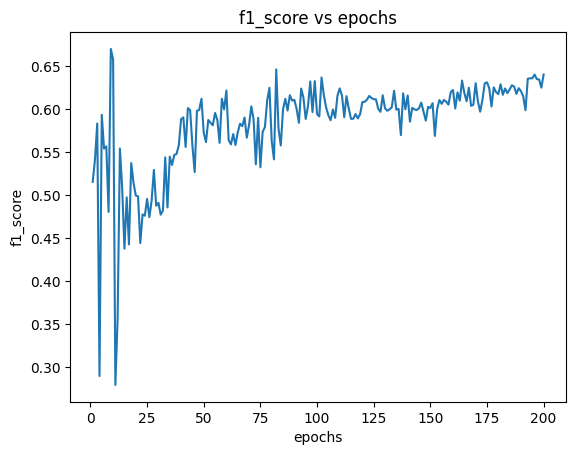

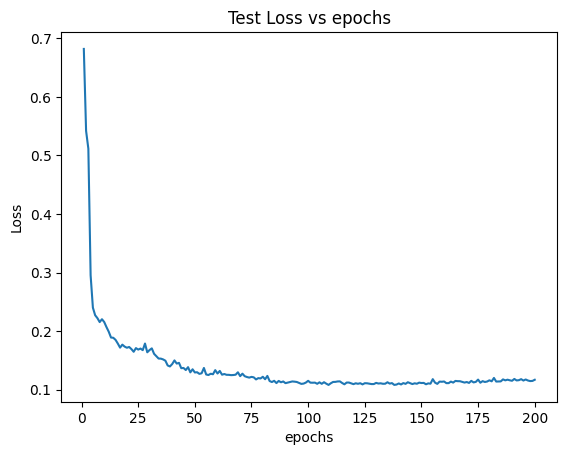

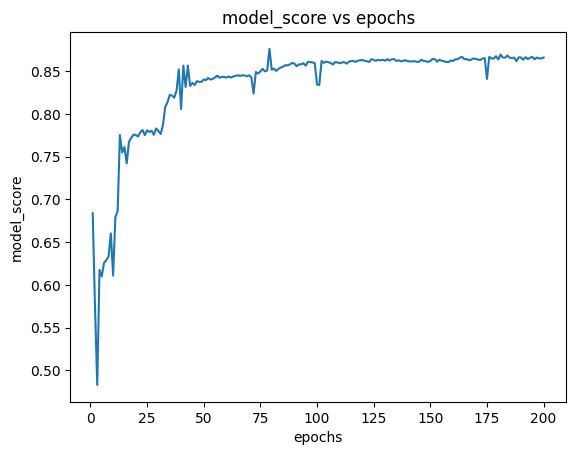

In [9]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

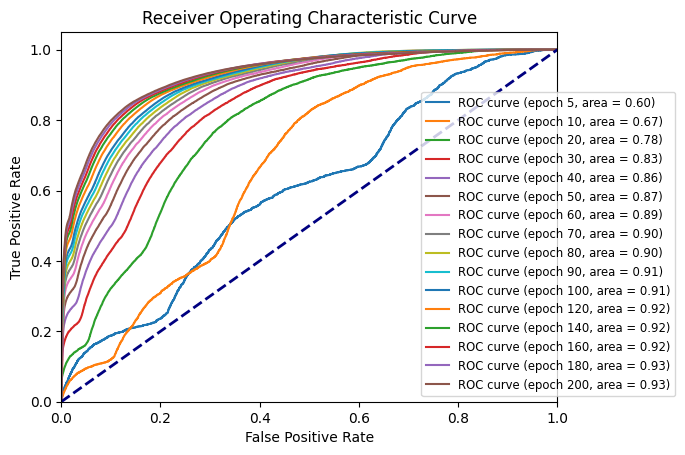

In [10]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [11]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model1.eval()
model2.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs1 = model1(images)
        outputs1 = torch.sigmoid(outputs1)
        outputs2 = model2(images)
        outputs2 = torch.sigmoid(outputs2)

        outputs = a * outputs1 + b * outputs2

        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh3).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 27/27 [00:06<00:00,  4.34it/s]


  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.6825    0.6667  1       1
      1       0.3492    0.3333  1       0.95
      2       0.5159    0.6667  0.6667  0.95
      3       0.6825    0.6667  1       1
      4       0.6825    0.6667  1       1
      5       0.6825    0.6667  1       1
      6       0.5238    0.5     0       1
      7       0.5159    0.6667  0.6667  1
      8       0.3492    0.3333  1       0.95
      9       0.5159    0.6667  0.6667  0.95
     10       0.6825    0.6667  1       1
     11       0.6825    0.6667  1       1
     12       0.5159    0.6667  0.6667  0.95
     13       0.5317    0.5     0.5     0.7368
     14       0.5238    0.5     0       1
     15       0.6825    0.6667  1       1
     16       0.6825    0.6667  1       1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.6825    0.6667  1       1
     20       0.6825    0.6667  1       1


In [12]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 